In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
def true_smooth(x): #[-3,3]
    term1 = (np.power(x,3) - x)
    term2 = np.sin(7*x)/7  
    
    term3 = np.sin(12*x)
    term12 = np.multiply(term1,term2)

    return 50*(term12  + term3)

In [3]:
# Domain bounds
label = "Regr_smooth_Swish"
loss_thresh = 0.1

lb = np.array(-3.0)  # [-1. 0.]
ub = np.array(3.0) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_smooth(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_smooth(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(model_NN.beta.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 5000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    beta_val = []
    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"beta": beta_full, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 3618.7754 Test MSE 3506.0583213543673 Test RE 0.9997959608967689
1 Train Loss 3616.1584 Test MSE 3504.201373638699 Test RE 0.9995311600080216
2 Train Loss 3612.5276 Test MSE 3501.4942557798327 Test RE 0.9991449990603807
3 Train Loss 3607.0923 Test MSE 3497.6861584584776 Test RE 0.99860153444483
4 Train Loss 3599.1448 Test MSE 3492.617740134028 Test RE 0.9978777466346478
5 Train Loss 3587.8896 Test MSE 3486.514708601563 Test RE 0.9970055151741226
6 Train Loss 3572.7297 Test MSE 3480.511575666441 Test RE 0.9961468159144872
7 Train Loss 3553.767 Test MSE 3477.6081063050465 Test RE

101 Train Loss 2647.0854 Test MSE 2733.2358846212333 Test RE 0.8827553673189552
102 Train Loss 2669.728 Test MSE 2724.0437927719136 Test RE 0.8812697285790003
103 Train Loss 2627.13 Test MSE 2750.7900808644163 Test RE 0.8855855767004471
104 Train Loss 2645.193 Test MSE 2703.3566963810463 Test RE 0.8779170555243482
105 Train Loss 2620.8154 Test MSE 2705.3334797869957 Test RE 0.8782379777930486
106 Train Loss 2619.9558 Test MSE 2717.7948192464582 Test RE 0.8802583290677136
107 Train Loss 2604.623 Test MSE 2704.90475944281 Test RE 0.8781683868518488
108 Train Loss 2591.8413 Test MSE 2689.4012385776127 Test RE 0.8756481009548397
109 Train Loss 2593.1226 Test MSE 2677.5112338922677 Test RE 0.873710310341011
110 Train Loss 2568.4717 Test MSE 2708.0064328572007 Test RE 0.8786717338077935
111 Train Loss 2580.6318 Test MSE 2664.707479144724 Test RE 0.8716187825553773
112 Train Loss 2545.5942 Test MSE 2664.4153818190825 Test RE 0.8715710091140532
113 Train Loss 2553.466 Test MSE 2660.63192569400

207 Train Loss 1382.4003 Test MSE 1440.0273834200925 Test RE 0.6407478907232789
208 Train Loss 1374.7552 Test MSE 1434.7337865745071 Test RE 0.6395690992821653
209 Train Loss 1367.3699 Test MSE 1424.7009300630968 Test RE 0.6373289756452114
210 Train Loss 1360.5303 Test MSE 1416.5183527635606 Test RE 0.6354961337548805
211 Train Loss 1354.1436 Test MSE 1410.380709008543 Test RE 0.6341178660046184
212 Train Loss 1348.145 Test MSE 1399.2671756518735 Test RE 0.6316145604052712
213 Train Loss 1342.7659 Test MSE 1401.0652992069022 Test RE 0.6320202571903994
214 Train Loss 1339.085 Test MSE 1385.2615765386763 Test RE 0.628445620354746
215 Train Loss 1342.2092 Test MSE 1448.9533370248919 Test RE 0.6427306483706489
216 Train Loss 1377.2467 Test MSE 1564.6605805982151 Test RE 0.6679006721187768
217 Train Loss 1594.1466 Test MSE 2447.771974539284 Test RE 0.8353861849214674
218 Train Loss 2331.7964 Test MSE 2252.715618842422 Test RE 0.801410438616908
219 Train Loss 2434.8887 Test MSE 1540.47736640

313 Train Loss 1240.1221 Test MSE 1266.6131504427913 Test RE 0.6009298900722886
314 Train Loss 1239.887 Test MSE 1267.547038334172 Test RE 0.6011513853808107
315 Train Loss 1239.594 Test MSE 1265.8328119398755 Test RE 0.600744750285293
316 Train Loss 1239.359 Test MSE 1266.7645978622704 Test RE 0.6009658152325486
317 Train Loss 1239.0863 Test MSE 1265.3018231599801 Test RE 0.600618737521931
318 Train Loss 1238.79 Test MSE 1266.292544965211 Test RE 0.6008538314874308
319 Train Loss 1238.5424 Test MSE 1265.1652506859791 Test RE 0.6005863222519181
320 Train Loss 1238.2656 Test MSE 1264.7935763378348 Test RE 0.6004980970471736
321 Train Loss 1238.0283 Test MSE 1264.9473727950383 Test RE 0.6005346056420345
322 Train Loss 1237.8135 Test MSE 1263.7039227858074 Test RE 0.6002393687103221
323 Train Loss 1237.5802 Test MSE 1264.35206972472 Test RE 0.6003932787483717
324 Train Loss 1237.3805 Test MSE 1263.1475172304124 Test RE 0.6001072122440652
325 Train Loss 1237.1675 Test MSE 1264.026990063851

418 Train Loss 1227.9402 Test MSE 1241.3958934739637 Test RE 0.5949177983822899
419 Train Loss 1228.0017 Test MSE 1252.3722162188026 Test RE 0.5975421178295365
420 Train Loss 1228.1125 Test MSE 1240.7130000467378 Test RE 0.5947541433615398
421 Train Loss 1228.3422 Test MSE 1253.3645118445443 Test RE 0.5977787970760902
422 Train Loss 1228.6931 Test MSE 1240.2746475853676 Test RE 0.5946490687090845
423 Train Loss 1229.2727 Test MSE 1255.8225448622393 Test RE 0.5983646762453698
424 Train Loss 1230.1053 Test MSE 1240.1783265839065 Test RE 0.5946259777324117
425 Train Loss 1231.3926 Test MSE 1260.5264183686697 Test RE 0.599484261582695
426 Train Loss 1233.1938 Test MSE 1241.116816517435 Test RE 0.5948509231889622
427 Train Loss 1235.9147 Test MSE 1269.4428147507017 Test RE 0.6016007662641338
428 Train Loss 1239.6205 Test MSE 1244.9447279606702 Test RE 0.5957675506940499
429 Train Loss 1245.0842 Test MSE 1285.2006698112696 Test RE 0.6053231473170544
430 Train Loss 1252.0477 Test MSE 1253.948

523 Train Loss 1296.3663 Test MSE 1269.5177779254357 Test RE 0.6016185288750512
524 Train Loss 1246.6718 Test MSE 1234.742525502293 Test RE 0.5933213999672673
525 Train Loss 1225.44 Test MSE 1229.59278210281 Test RE 0.5920828237430039
526 Train Loss 1236.6448 Test MSE 1285.9380649037637 Test RE 0.6054967771326083
527 Train Loss 1259.921 Test MSE 1248.2905216073184 Test RE 0.5965675773045829
528 Train Loss 1269.9586 Test MSE 1279.043726074631 Test RE 0.6038714616048655
529 Train Loss 1254.0424 Test MSE 1230.5535272079217 Test RE 0.5923140912041349
530 Train Loss 1232.0162 Test MSE 1233.1020317850714 Test RE 0.5929271220017873
531 Train Loss 1224.2334 Test MSE 1252.9052655582802 Test RE 0.5976692707403531
532 Train Loss 1233.218 Test MSE 1234.7622771753288 Test RE 0.5933261455086207
533 Train Loss 1244.2136 Test MSE 1264.9558677490115 Test RE 0.6005366221311705
534 Train Loss 1242.2535 Test MSE 1225.1430623491692 Test RE 0.5910105213678497
535 Train Loss 1230.4427 Test MSE 1233.479687131

627 Train Loss 1209.8942 Test MSE 1214.0182748582681 Test RE 0.5883210965928553
628 Train Loss 1208.7891 Test MSE 1218.1206892352345 Test RE 0.5893142865038927
629 Train Loss 1208.4019 Test MSE 1215.4671310200697 Test RE 0.5886720544390655
630 Train Loss 1208.4972 Test MSE 1216.2930766656534 Test RE 0.5888720304552815
631 Train Loss 1208.3894 Test MSE 1216.3489655636056 Test RE 0.5888855596907041
632 Train Loss 1208.0149 Test MSE 1214.0083730322583 Test RE 0.5883186973435459
633 Train Loss 1207.8545 Test MSE 1217.6442157267916 Test RE 0.5891990187345112
634 Train Loss 1208.0898 Test MSE 1213.0384275937997 Test RE 0.5880836285111235
635 Train Loss 1208.3954 Test MSE 1219.0977163948523 Test RE 0.5895505769883164
636 Train Loss 1208.4913 Test MSE 1211.8784560491074 Test RE 0.5878023829145662
637 Train Loss 1208.5377 Test MSE 1220.5954720141328 Test RE 0.5899126200119804
638 Train Loss 1208.8367 Test MSE 1211.3032432555347 Test RE 0.5876628674460965
639 Train Loss 1209.5002 Test MSE 1223.6

730 Train Loss 1239.7711 Test MSE 1205.3521002936086 Test RE 0.5862174936862549
731 Train Loss 1222.9523 Test MSE 1209.582415172955 Test RE 0.5872452898542163
732 Train Loss 1204.9132 Test MSE 1213.301220529036 Test RE 0.5881473263504368
733 Train Loss 1208.3353 Test MSE 1204.0141936351297 Test RE 0.5858920609568142
734 Train Loss 1218.7194 Test MSE 1234.0094606750733 Test RE 0.593145246795249
735 Train Loss 1220.2025 Test MSE 1202.3921047856095 Test RE 0.5854972610897212
736 Train Loss 1214.497 Test MSE 1211.976425214836 Test RE 0.5878261416277413
737 Train Loss 1206.3926 Test MSE 1205.818733563065 Test RE 0.5863309551867286
738 Train Loss 1201.8073 Test MSE 1198.3227396159293 Test RE 0.5845056455074631
739 Train Loss 1205.9148 Test MSE 1226.5032092114213 Test RE 0.5913384986237917
740 Train Loss 1213.584 Test MSE 1204.3894495450593 Test RE 0.5859833565293041
741 Train Loss 1213.7794 Test MSE 1217.162100189013 Test RE 0.5890823630966664
742 Train Loss 1205.9061 Test MSE 1198.902342700

834 Train Loss 1198.7908 Test MSE 1208.0445916522733 Test RE 0.586871868900465
835 Train Loss 1198.9911 Test MSE 1186.554907473231 Test RE 0.5816285680963977
836 Train Loss 1199.5087 Test MSE 1209.6313648954122 Test RE 0.5872571721380432
837 Train Loss 1200.3263 Test MSE 1187.504164351996 Test RE 0.5818611761852998
838 Train Loss 1201.5548 Test MSE 1213.1735776146534 Test RE 0.5881163881085034
839 Train Loss 1203.2 Test MSE 1189.2591041062126 Test RE 0.5822909659712241
840 Train Loss 1205.4065 Test MSE 1219.2691206886682 Test RE 0.5895920207328437
841 Train Loss 1208.1334 Test MSE 1192.5548757042982 Test RE 0.5830972537977565
842 Train Loss 1211.5559 Test MSE 1228.07307629976 Test RE 0.591716820497522
843 Train Loss 1215.378 Test MSE 1197.5703101455792 Test RE 0.584322110505523
844 Train Loss 1219.7275 Test MSE 1237.7167765640277 Test RE 0.5940355672328326
845 Train Loss 1223.7075 Test MSE 1202.6115519870473 Test RE 0.5855506878682959
846 Train Loss 1227.2767 Test MSE 1243.099510672139

939 Train Loss 1184.855 Test MSE 1189.6122077109228 Test RE 0.5823774037284614
940 Train Loss 1184.7771 Test MSE 1171.4406104996606 Test RE 0.5779123131004564
941 Train Loss 1185.0453 Test MSE 1189.4552657816516 Test RE 0.5823389868193948
942 Train Loss 1185.0631 Test MSE 1171.23886851971 Test RE 0.5778625477972352
943 Train Loss 1184.6956 Test MSE 1188.447937211268 Test RE 0.5820923483096202
944 Train Loss 1184.095 Test MSE 1169.6942410036877 Test RE 0.5774813800892675
945 Train Loss 1183.7388 Test MSE 1187.7604144822046 Test RE 0.5819239523691092
946 Train Loss 1183.5544 Test MSE 1169.0719782494048 Test RE 0.5773277532071197
947 Train Loss 1183.4471 Test MSE 1187.1543897839813 Test RE 0.5817754774415062
948 Train Loss 1183.111 Test MSE 1168.8098865373913 Test RE 0.5772630346510255
949 Train Loss 1182.7638 Test MSE 1186.2492145564097 Test RE 0.5815536405959891
950 Train Loss 1182.5165 Test MSE 1168.991132291303 Test RE 0.5773077906114983
951 Train Loss 1182.5781 Test MSE 1186.44693711

1042 Train Loss 1168.0011 Test MSE 1187.0337053696862 Test RE 0.5817459054591952
1043 Train Loss 1174.3894 Test MSE 1163.6681459722868 Test RE 0.5759919090825837
1044 Train Loss 1184.0342 Test MSE 1216.5967682618355 Test RE 0.5889455424765663
1045 Train Loss 1199.5035 Test MSE 1189.4048742027462 Test RE 0.5823266512181086
1046 Train Loss 1220.9299 Test MSE 1271.9427572796935 Test RE 0.6021928479248974
1047 Train Loss 1250.685 Test MSE 1235.5635916110446 Test RE 0.5935186374981616
1048 Train Loss 1279.6172 Test MSE 1325.0658358872854 Test RE 0.6146396009694564
1049 Train Loss 1302.8972 Test MSE 1253.9814203615235 Test RE 0.5979258929372456
1050 Train Loss 1295.884 Test MSE 1281.9440977666163 Test RE 0.6045557462306355
1051 Train Loss 1266.8944 Test MSE 1199.4925600517433 Test RE 0.5847908774537415
1052 Train Loss 1217.9246 Test MSE 1174.7329421431468 Test RE 0.5787238540291816
1053 Train Loss 1178.5088 Test MSE 1169.035939240166 Test RE 0.5773188544904578
1054 Train Loss 1165.8436 Test 

1147 Train Loss 1131.4235 Test MSE 1139.0489950783337 Test RE 0.5698663491856065
1148 Train Loss 1131.5096 Test MSE 1131.9586381910076 Test RE 0.5680899271987626
1149 Train Loss 1131.9773 Test MSE 1144.5181216846956 Test RE 0.5712328132350358
1150 Train Loss 1133.7 Test MSE 1131.3460037439843 Test RE 0.5679361766333771
1151 Train Loss 1136.7885 Test MSE 1158.6539957014018 Test RE 0.5747496185399631
1152 Train Loss 1143.4304 Test MSE 1138.7960244499952 Test RE 0.5698030650538425
1153 Train Loss 1152.7411 Test MSE 1190.3358988852804 Test RE 0.5825545191387632
1154 Train Loss 1170.2256 Test MSE 1162.5076171588623 Test RE 0.5757046184339453
1155 Train Loss 1189.8375 Test MSE 1243.9596311427144 Test RE 0.5955317953029994
1156 Train Loss 1219.9867 Test MSE 1197.4244376425816 Test RE 0.5842865221463868
1157 Train Loss 1238.0852 Test MSE 1272.9796045145126 Test RE 0.602438242143066
1158 Train Loss 1249.3265 Test MSE 1187.5678029713642 Test RE 0.5818767670130817
1159 Train Loss 1222.8627 Test M

1250 Train Loss 1099.6842 Test MSE 1116.9851828199146 Test RE 0.5643200956237291
1251 Train Loss 1105.9674 Test MSE 1086.6326397336984 Test RE 0.5565999754929682
1252 Train Loss 1109.0546 Test MSE 1126.717724413874 Test RE 0.5667732869844943
1253 Train Loss 1115.8694 Test MSE 1092.0710290523054 Test RE 0.5579910755300006
1254 Train Loss 1115.8947 Test MSE 1126.6836263814876 Test RE 0.5667647107458791
1255 Train Loss 1117.443 Test MSE 1088.4630186301583 Test RE 0.5570685608031198
1256 Train Loss 1109.5688 Test MSE 1107.4273775611837 Test RE 0.5619005248920262
1257 Train Loss 1101.6317 Test MSE 1074.8887887922622 Test RE 0.5535840599726619
1258 Train Loss 1088.5055 Test MSE 1078.1298733418691 Test RE 0.5544180356763551
1259 Train Loss 1077.5911 Test MSE 1064.6142047343205 Test RE 0.5509319235229433
1260 Train Loss 1069.4502 Test MSE 1061.1254654745655 Test RE 0.5500284811994004
1261 Train Loss 1065.6724 Test MSE 1067.5618014990926 Test RE 0.5516940788001201
1262 Train Loss 1065.7548 Test

1354 Train Loss 1019.0692 Test MSE 1008.3290691879413 Test RE 0.5361705471631976
1355 Train Loss 1009.5345 Test MSE 999.2321974335194 Test RE 0.5337464747179416
1356 Train Loss 997.2413 Test MSE 995.1385799894824 Test RE 0.532652036262896
1357 Train Loss 989.1594 Test MSE 988.1430893774949 Test RE 0.5307765518176142
1358 Train Loss 989.56824 Test MSE 1007.8606012569558 Test RE 0.5360459807415611
1359 Train Loss 997.03033 Test MSE 1000.8821870792096 Test RE 0.534186969381268
1360 Train Loss 1005.52826 Test MSE 1025.4754837122423 Test RE 0.5407100613940502
1361 Train Loss 1011.2696 Test MSE 1002.7442856190405 Test RE 0.5346836544882153
1362 Train Loss 1011.5744 Test MSE 1029.4025048698923 Test RE 0.5417443868930465
1363 Train Loss 1012.3966 Test MSE 997.75836655016 Test RE 0.5333527012160477
1364 Train Loss 1012.55743 Test MSE 1037.0096820149813 Test RE 0.5437424196319883
1365 Train Loss 1019.08484 Test MSE 1001.1204810084186 Test RE 0.5342505562538178
1366 Train Loss 1021.3913 Test MSE 

1458 Train Loss 895.6061 Test MSE 924.9395639146303 Test RE 0.5135213308176388
1459 Train Loss 893.215 Test MSE 901.9216609255759 Test RE 0.5070913688064534
1460 Train Loss 890.57916 Test MSE 919.0210888573969 Test RE 0.5118757418460815
1461 Train Loss 888.19025 Test MSE 899.5117509490412 Test RE 0.5064134485327287
1462 Train Loss 884.29865 Test MSE 909.7316062908013 Test RE 0.5092821463265008
1463 Train Loss 879.03375 Test MSE 889.8864925270559 Test RE 0.5036967135326774
1464 Train Loss 872.7864 Test MSE 898.5314504718497 Test RE 0.506137425081912
1465 Train Loss 867.04407 Test MSE 879.3796572553719 Test RE 0.5007143260655738
1466 Train Loss 862.73035 Test MSE 893.5568057668444 Test RE 0.5047343865387584
1467 Train Loss 861.3418 Test MSE 875.560863834768 Test RE 0.4996259423535278
1468 Train Loss 862.21436 Test MSE 900.4812866532968 Test RE 0.5066862930443893
1469 Train Loss 866.99554 Test MSE 880.2312098928448 Test RE 0.5009567022840713
1470 Train Loss 872.27484 Test MSE 917.69298293

1563 Train Loss 796.6669 Test MSE 819.1271384905551 Test RE 0.48325623636468035
1564 Train Loss 802.18463 Test MSE 849.6595201789951 Test RE 0.4921803534607162
1565 Train Loss 804.794 Test MSE 819.448359203706 Test RE 0.4833509815452637
1566 Train Loss 800.3345 Test MSE 842.7389816048213 Test RE 0.49017183282814974
1567 Train Loss 796.6965 Test MSE 819.1324751103951 Test RE 0.4832578105712334
1568 Train Loss 792.1285 Test MSE 826.0125735372466 Test RE 0.48528306838044316
1569 Train Loss 786.4202 Test MSE 819.7704837036399 Test RE 0.4834459746544533
1570 Train Loss 782.1681 Test MSE 810.8296455770763 Test RE 0.48080239171748684
1571 Train Loss 781.3415 Test MSE 834.5594616746937 Test RE 0.48778725914829185
1572 Train Loss 788.16174 Test MSE 817.3694949361114 Test RE 0.4827374839605745
1573 Train Loss 799.10736 Test MSE 869.183622102648 Test RE 0.49780307738220725
1574 Train Loss 817.49615 Test MSE 838.0204156359332 Test RE 0.4887976500640988
1575 Train Loss 828.08093 Test MSE 890.757814

1667 Train Loss 724.84686 Test MSE 767.0324715386548 Test RE 0.46763680509860056
1668 Train Loss 727.45355 Test MSE 755.8339225679109 Test RE 0.4642105428613452
1669 Train Loss 731.0391 Test MSE 786.8081619841771 Test RE 0.4736267665011358
1670 Train Loss 742.2706 Test MSE 775.844796708615 Test RE 0.47031543928208036
1671 Train Loss 758.4177 Test MSE 846.1406438635797 Test RE 0.49116011025459827
1672 Train Loss 794.3121 Test MSE 845.8085260263521 Test RE 0.4910637084065774
1673 Train Loss 840.9157 Test MSE 980.2572729422101 Test RE 0.5286543942402361
1674 Train Loss 920.74396 Test MSE 958.6796366970625 Test RE 0.5228035900459578
1675 Train Loss 969.77814 Test MSE 1049.7155603854787 Test RE 0.5470633585185956
1676 Train Loss 988.74023 Test MSE 873.8267595235869 Test RE 0.4991309265564202
1677 Train Loss 878.7979 Test MSE 796.3363718142738 Test RE 0.4764859353811696
1678 Train Loss 752.8994 Test MSE 740.2784424948456 Test RE 0.45940885424087646
1679 Train Loss 706.444 Test MSE 776.840636

1770 Train Loss 762.7196 Test MSE 769.2734001554395 Test RE 0.4683194205348771
1771 Train Loss 753.2029 Test MSE 730.8603465289951 Test RE 0.4564771151007187
1772 Train Loss 711.44147 Test MSE 723.4807536766126 Test RE 0.45416671352262117
1773 Train Loss 687.16833 Test MSE 708.4739699830565 Test RE 0.4494317596334338
1774 Train Loss 689.7997 Test MSE 752.8457369293036 Test RE 0.4632920070740223
1775 Train Loss 711.805 Test MSE 745.9848966133483 Test RE 0.4611761370760619
1776 Train Loss 732.23956 Test MSE 768.8006097858146 Test RE 0.4681754853990105
1777 Train Loss 732.68555 Test MSE 730.0261964435766 Test RE 0.45621654607804246
1778 Train Loss 714.92926 Test MSE 720.4449876960201 Test RE 0.45321285731045735
1779 Train Loss 684.7949 Test MSE 687.9043768057271 Test RE 0.4428593784691574
1780 Train Loss 662.7239 Test MSE 689.8574029938351 Test RE 0.44348759291880036
1781 Train Loss 659.37805 Test MSE 702.4974632548873 Test RE 0.44753209871434957
1782 Train Loss 671.79395 Test MSE 711.896

1873 Train Loss 637.4971 Test MSE 698.0767949796242 Test RE 0.4461217639549412
1874 Train Loss 672.78076 Test MSE 719.7504472552882 Test RE 0.4529943461376688
1875 Train Loss 711.43585 Test MSE 735.4522602303155 Test RE 0.4579088670322866
1876 Train Loss 711.63293 Test MSE 683.2659419516694 Test RE 0.441363786264569
1877 Train Loss 668.0489 Test MSE 657.7210527031855 Test RE 0.4330346828321741
1878 Train Loss 636.59906 Test MSE 668.0436031725753 Test RE 0.4364195676870992
1879 Train Loss 640.9438 Test MSE 678.8078113025114 Test RE 0.43992153850447224
1880 Train Loss 664.47876 Test MSE 705.8370410480363 Test RE 0.44859459096692716
1881 Train Loss 682.10254 Test MSE 696.5577453636984 Test RE 0.44563610810187165
1882 Train Loss 682.429 Test MSE 695.9726416661541 Test RE 0.4454489031536783
1883 Train Loss 684.48956 Test MSE 701.544871490484 Test RE 0.4472285673611243
1884 Train Loss 680.1363 Test MSE 683.6925936402156 Test RE 0.44150156513360544
1885 Train Loss 674.2801 Test MSE 685.863732

1977 Train Loss 630.26654 Test MSE 662.0184703787795 Test RE 0.43444706049986587
1978 Train Loss 634.0885 Test MSE 649.3564475649872 Test RE 0.43027230035655367
1979 Train Loss 635.6241 Test MSE 659.3769303255502 Test RE 0.43357944393775444
1980 Train Loss 635.186 Test MSE 649.3778368576704 Test RE 0.4302793867144506
1981 Train Loss 635.4372 Test MSE 657.7174705797971 Test RE 0.4330335036196713
1982 Train Loss 636.94293 Test MSE 656.7204177151232 Test RE 0.4327051551516154
1983 Train Loss 641.9258 Test MSE 661.6188187022881 Test RE 0.43431590576936674
1984 Train Loss 646.24884 Test MSE 671.5111742000294 Test RE 0.43755074921015324
1985 Train Loss 654.6847 Test MSE 671.4223082485755 Test RE 0.4375217961177503
1986 Train Loss 659.8415 Test MSE 687.4349267005352 Test RE 0.4427082412831202
1987 Train Loss 666.84814 Test MSE 677.1512846284733 Test RE 0.43938442999606975
1988 Train Loss 666.59937 Test MSE 689.6571616086594 Test RE 0.44342322380811416
1989 Train Loss 665.32574 Test MSE 667.98

2081 Train Loss 606.89014 Test MSE 622.0018316000146 Test RE 0.42111202365963213
2082 Train Loss 606.7286 Test MSE 625.1324374439674 Test RE 0.4221704458566438
2083 Train Loss 605.95844 Test MSE 621.4136161823217 Test RE 0.4209128577067343
2084 Train Loss 605.24097 Test MSE 622.8929117944917 Test RE 0.42141355837155653
2085 Train Loss 604.8999 Test MSE 622.7790894266747 Test RE 0.42137505377503764
2086 Train Loss 605.21075 Test MSE 622.4794874096199 Test RE 0.42127368556512346
2087 Train Loss 605.4547 Test MSE 623.1781082358252 Test RE 0.4215100210949744
2088 Train Loss 605.6924 Test MSE 622.9185995862183 Test RE 0.42142224772401937
2089 Train Loss 605.71625 Test MSE 622.4941596947195 Test RE 0.4212786503963525
2090 Train Loss 606.2801 Test MSE 625.2659198612345 Test RE 0.42221551576533584
2091 Train Loss 607.152 Test MSE 623.5599033655901 Test RE 0.42163912209337445
2092 Train Loss 608.6874 Test MSE 628.4335046401424 Test RE 0.4232836324343926
2093 Train Loss 610.18896 Test MSE 626.31

2184 Train Loss 628.21466 Test MSE 642.9284429712256 Test RE 0.4281373626856858
2185 Train Loss 634.7715 Test MSE 653.6493702491335 Test RE 0.43169223151983943
2186 Train Loss 643.4423 Test MSE 654.1285091130883 Test RE 0.43185042232064436
2187 Train Loss 648.4197 Test MSE 665.6593056163255 Test RE 0.4356400645093091
2188 Train Loss 654.29224 Test MSE 658.256172257066 Test RE 0.43321080477001855
2189 Train Loss 653.2453 Test MSE 668.7440978907565 Test RE 0.4366483173545229
2190 Train Loss 652.0671 Test MSE 651.6388833711898 Test RE 0.4310278233427341
2191 Train Loss 645.131 Test MSE 663.9305459518716 Test RE 0.4350740042330046
2192 Train Loss 640.8204 Test MSE 643.1242704181187 Test RE 0.4282025601927538
2193 Train Loss 635.8476 Test MSE 656.2348388598517 Test RE 0.43254515454718895
2194 Train Loss 631.6656 Test MSE 632.6465198402431 Test RE 0.4247001081089558
2195 Train Loss 624.6146 Test MSE 636.2957805112193 Test RE 0.425923234143129
2196 Train Loss 614.6296 Test MSE 614.45883647627

2289 Train Loss 613.9652 Test MSE 625.7897528880404 Test RE 0.422392339834197
2290 Train Loss 619.2453 Test MSE 644.3912918718981 Test RE 0.42862415435601453
2291 Train Loss 628.71387 Test MSE 643.8403157384594 Test RE 0.4284408711666122
2292 Train Loss 639.7397 Test MSE 678.7510872828125 Test RE 0.4399031572786378
2293 Train Loss 658.6488 Test MSE 679.3479031939806 Test RE 0.44009651499235114
2294 Train Loss 677.66754 Test MSE 723.62314872646 Test RE 0.45421140573431035
2295 Train Loss 699.0973 Test MSE 706.3602470823055 Test RE 0.448760821913184
2296 Train Loss 705.6789 Test MSE 722.476686779333 Test RE 0.45385145144575484
2297 Train Loss 697.21356 Test MSE 665.821638297097 Test RE 0.4356931805011977
2298 Train Loss 663.2621 Test MSE 641.4332425954977 Test RE 0.4276392327838834
2299 Train Loss 622.1167 Test MSE 599.1900967101135 Test RE 0.4133178135231897
2300 Train Loss 590.21063 Test MSE 593.6675798973853 Test RE 0.41140870460051476
2301 Train Loss 583.102 Test MSE 613.809887803517

2393 Train Loss 580.9985 Test MSE 593.3741662811793 Test RE 0.41130702494106774
2394 Train Loss 580.68066 Test MSE 586.6541000448359 Test RE 0.4089713310702444
2395 Train Loss 578.9466 Test MSE 587.992517492297 Test RE 0.4094375875234515
2396 Train Loss 576.7554 Test MSE 585.547043165295 Test RE 0.40858527025339075
2397 Train Loss 575.8433 Test MSE 585.5001577444269 Test RE 0.40856891198118195
2398 Train Loss 576.1707 Test MSE 589.4965675004477 Test RE 0.4099609116194968
2399 Train Loss 577.9575 Test MSE 587.8193635226339 Test RE 0.4093772968210435
2400 Train Loss 579.5681 Test MSE 593.6189790021402 Test RE 0.4113918641655047
2401 Train Loss 581.04224 Test MSE 588.9379768572151 Test RE 0.40976663177440376
2402 Train Loss 580.8689 Test MSE 592.6862479138015 Test RE 0.41106853485520284
2403 Train Loss 580.10187 Test MSE 586.4641361206138 Test RE 0.40890511139401386
2404 Train Loss 578.10925 Test MSE 588.2425799419465 Test RE 0.4095246414227533
2405 Train Loss 576.3916 Test MSE 583.706136

2498 Train Loss 637.6076 Test MSE 631.3041849594491 Test RE 0.42424930938234173
2499 Train Loss 621.1377 Test MSE 589.2071302794708 Test RE 0.409860255803951
2500 Train Loss 583.85614 Test MSE 567.1584096869083 Test RE 0.40211844819118864
2501 Train Loss 554.81506 Test MSE 562.1079408642519 Test RE 0.40032403935707656
2502 Train Loss 548.55554 Test MSE 572.7796213914123 Test RE 0.40410627000662536
2503 Train Loss 565.51044 Test MSE 603.3456793150372 Test RE 0.4147485853408304
2504 Train Loss 592.023 Test MSE 611.4548861246201 Test RE 0.4175264757913332
2505 Train Loss 611.65875 Test MSE 633.9616290963164 Test RE 0.4251413000451568
2506 Train Loss 625.6788 Test MSE 621.8388175864434 Test RE 0.4210568376006873
2507 Train Loss 628.65906 Test MSE 625.3167884939635 Test RE 0.4222326901294843
2508 Train Loss 618.67303 Test MSE 601.5464611147562 Test RE 0.4141297192561567
2509 Train Loss 603.3352 Test MSE 592.0838476493758 Test RE 0.41085957881096
2510 Train Loss 587.6244 Test MSE 588.5974674

2604 Train Loss 548.643 Test MSE 561.1007250188743 Test RE 0.39996521725808637
2605 Train Loss 551.6012 Test MSE 561.2304895955417 Test RE 0.4000114641388646
2606 Train Loss 553.37146 Test MSE 564.4512440475975 Test RE 0.40115760253754496
2607 Train Loss 555.5626 Test MSE 562.5588513252269 Test RE 0.4004845726801127
2608 Train Loss 555.0588 Test MSE 562.8845974489294 Test RE 0.40060050492199234
2609 Train Loss 553.88873 Test MSE 558.5814419918581 Test RE 0.39906630631604
2610 Train Loss 549.66064 Test MSE 554.3524384874817 Test RE 0.39755277657573296
2611 Train Loss 544.4686 Test MSE 550.3976370615973 Test RE 0.3961321492311305
2612 Train Loss 538.71796 Test MSE 544.4613669760411 Test RE 0.39399013198665844
2613 Train Loss 533.54315 Test MSE 543.9268221900462 Test RE 0.39379667740812513
2614 Train Loss 530.2835 Test MSE 540.7717751393194 Test RE 0.392652907747815
2615 Train Loss 529.06396 Test MSE 543.1690947405104 Test RE 0.39352228889489627
2616 Train Loss 529.44543 Test MSE 542.2964

2709 Train Loss 548.4795 Test MSE 557.1801261105146 Test RE 0.39856542221975066
2710 Train Loss 545.7961 Test MSE 620.4667690701484 Test RE 0.420592063276946
2711 Train Loss 617.6737 Test MSE 675.688866349292 Test RE 0.4389097124979284
2712 Train Loss 657.3076 Test MSE 609.2790150454815 Test RE 0.4167829267098819
2713 Train Loss 607.24365 Test MSE 559.1379205323345 Test RE 0.39926503879942143
2714 Train Loss 550.1828 Test MSE 570.6156436333124 Test RE 0.403342185128964
2715 Train Loss 562.2055 Test MSE 605.3091361882346 Test RE 0.41542289158061896
2716 Train Loss 604.91644 Test MSE 611.7832804737768 Test RE 0.41763858130675735
2717 Train Loss 600.3291 Test MSE 555.167129625432 Test RE 0.39784479641018483
2718 Train Loss 549.8662 Test MSE 540.8837040291389 Test RE 0.392693541275815
2719 Train Loss 533.57446 Test MSE 571.2047378972419 Test RE 0.40355033336031876
2720 Train Loss 557.04 Test MSE 566.246833374909 Test RE 0.40179516191434156
2721 Train Loss 560.3273 Test MSE 545.114761807976

2812 Train Loss 694.83905 Test MSE 694.0371038353736 Test RE 0.4448290630682415
2813 Train Loss 710.6058 Test MSE 655.2967068462606 Test RE 0.4322358677183051
2814 Train Loss 670.3971 Test MSE 585.0298038893412 Test RE 0.40840476977687057
2815 Train Loss 579.17224 Test MSE 543.2837988925177 Test RE 0.39356383788772886
2816 Train Loss 528.5917 Test MSE 566.6683480155237 Test RE 0.40194468242961323
2817 Train Loss 561.93304 Test MSE 625.8185169993242 Test RE 0.4224020472483895
2818 Train Loss 632.02783 Test MSE 641.562380446264 Test RE 0.42768227828612443
2819 Train Loss 648.7128 Test MSE 617.813919788422 Test RE 0.41969196467335346
2820 Train Loss 606.102 Test MSE 550.3046075462611 Test RE 0.39609867021822753
2821 Train Loss 540.24835 Test MSE 546.8124698643918 Test RE 0.3948398832666838
2822 Train Loss 534.0489 Test MSE 579.4187823031347 Test RE 0.4064415457837408
2823 Train Loss 586.4276 Test MSE 643.1766112938984 Test RE 0.4282199845398426
2824 Train Loss 650.50366 Test MSE 664.30584

2916 Train Loss 779.2475 Test MSE 652.6468480302924 Test RE 0.4313610546356422
2917 Train Loss 656.201 Test MSE 553.500639618535 Test RE 0.3972472262022941
2918 Train Loss 546.56696 Test MSE 540.7090641932618 Test RE 0.3926301399644686
2919 Train Loss 532.801 Test MSE 594.1620791314047 Test RE 0.41158001170012976
2920 Train Loss 591.56274 Test MSE 636.1635301408082 Test RE 0.4258789690117234
2921 Train Loss 620.9662 Test MSE 572.0570353893564 Test RE 0.4038512908886677
2922 Train Loss 568.46313 Test MSE 522.8110834899165 Test RE 0.38607724264006515
2923 Train Loss 514.24384 Test MSE 541.2282526806252 Test RE 0.39281859633731875
2924 Train Loss 532.93066 Test MSE 580.8844920704954 Test RE 0.4069552925741939
2925 Train Loss 578.6604 Test MSE 586.8885262751642 Test RE 0.4090530351200568
2926 Train Loss 575.88617 Test MSE 535.0453739815404 Test RE 0.39056841260475106
2927 Train Loss 531.7097 Test MSE 526.343710713957 Test RE 0.3873794059495245
2928 Train Loss 522.0124 Test MSE 554.99637708

3019 Train Loss 615.3775 Test MSE 619.0467169773818 Test RE 0.42011048650493593
3020 Train Loss 635.6746 Test MSE 587.8272471999873 Test RE 0.40938004204168693
3021 Train Loss 573.9917 Test MSE 516.7039093653481 Test RE 0.38381565402301066
3022 Train Loss 505.89062 Test MSE 530.367119336153 Test RE 0.38885716511648827
3023 Train Loss 525.9849 Test MSE 596.1534623965307 Test RE 0.4122691569469822
3024 Train Loss 612.2318 Test MSE 647.9774382962738 Test RE 0.42981518250943257
3025 Train Loss 668.97723 Test MSE 647.8112988372612 Test RE 0.42976007731938765
3026 Train Loss 644.48376 Test MSE 556.0642248946971 Test RE 0.39816610561728083
3027 Train Loss 549.7741 Test MSE 522.8680594863887 Test RE 0.3860982794323498
3028 Train Loss 511.81012 Test MSE 569.5217596824536 Test RE 0.4029553913184554
3029 Train Loss 580.02655 Test MSE 637.7345070797842 Test RE 0.4264044891586232
3030 Train Loss 647.1857 Test MSE 612.7936755937028 Test RE 0.4179833160442116
3031 Train Loss 629.50323 Test MSE 561.70

3122 Train Loss 488.3425 Test MSE 497.5989390545971 Test RE 0.3766530883174664
3123 Train Loss 488.1675 Test MSE 497.4905214638757 Test RE 0.37661205321695407
3124 Train Loss 488.00897 Test MSE 497.32779117005936 Test RE 0.3765504528447221
3125 Train Loss 487.85724 Test MSE 497.30690974904553 Test RE 0.37654254760474204
3126 Train Loss 487.70444 Test MSE 497.1154293044695 Test RE 0.37647004964156994
3127 Train Loss 487.54834 Test MSE 497.05615221923586 Test RE 0.37644760343370975
3128 Train Loss 487.39673 Test MSE 496.92233996669194 Test RE 0.37639692838195254
3129 Train Loss 487.2592 Test MSE 496.8313695213325 Test RE 0.3763624737391427
3130 Train Loss 487.16333 Test MSE 496.903755830324 Test RE 0.3763898899810951
3131 Train Loss 487.12518 Test MSE 496.84160019427827 Test RE 0.37636634871744756
3132 Train Loss 487.23065 Test MSE 497.2965450771958 Test RE 0.3765386237096564
3133 Train Loss 487.49573 Test MSE 497.5652098225428 Test RE 0.3766403225801268
3134 Train Loss 488.2247 Test MSE

3225 Train Loss 481.04834 Test MSE 494.18067782606784 Test RE 0.37535714765518496
3226 Train Loss 479.3413 Test MSE 493.25958400905995 Test RE 0.3750071740343622
3227 Train Loss 478.2734 Test MSE 492.9668526741781 Test RE 0.374895881070078
3228 Train Loss 477.8872 Test MSE 493.229978692636 Test RE 0.37499591994726345
3229 Train Loss 477.9959 Test MSE 493.4005592920639 Test RE 0.3750607593749894
3230 Train Loss 478.3503 Test MSE 493.90074596317504 Test RE 0.37525082084542916
3231 Train Loss 478.80576 Test MSE 494.5216260637345 Test RE 0.3754866097098601
3232 Train Loss 479.39096 Test MSE 494.84242193821353 Test RE 0.3756083789314714
3233 Train Loss 479.97162 Test MSE 495.80010007946646 Test RE 0.3759716643401898
3234 Train Loss 480.6401 Test MSE 495.95417547716687 Test RE 0.37603007849133246
3235 Train Loss 481.26367 Test MSE 497.1827588272253 Test RE 0.37649554340928204
3236 Train Loss 482.185 Test MSE 497.8016137717159 Test RE 0.3767297869199886
3237 Train Loss 483.39438 Test MSE 499.

3328 Train Loss 558.1345 Test MSE 591.9284127965299 Test RE 0.4108056454953831
3329 Train Loss 588.106 Test MSE 613.2538913210399 Test RE 0.4181402419397965
3330 Train Loss 621.1472 Test MSE 603.8238163099466 Test RE 0.4149128919533407
3331 Train Loss 594.4017 Test MSE 546.333731423436 Test RE 0.39466700277118205
3332 Train Loss 538.01373 Test MSE 504.5233924404129 Test RE 0.3792647356437796
3333 Train Loss 484.8239 Test MSE 495.96719298641244 Test RE 0.37603501336550604
3334 Train Loss 474.50906 Test MSE 519.7869767453229 Test RE 0.3849590260551289
3335 Train Loss 503.5224 Test MSE 550.1068179751145 Test RE 0.3960274812567964
3336 Train Loss 542.0526 Test MSE 558.7327476292569 Test RE 0.39912035115975897
3337 Train Loss 549.07715 Test MSE 530.9630326275424 Test RE 0.38907556110148833
3338 Train Loss 512.1272 Test MSE 494.86587592748407 Test RE 0.3756172801595346
3339 Train Loss 473.08356 Test MSE 492.17270915985125 Test RE 0.3745937906447199
3340 Train Loss 470.66367 Test MSE 512.4312

3431 Train Loss 440.19156 Test MSE 470.6529704411813 Test RE 0.3663128990810372
3432 Train Loss 442.01865 Test MSE 475.63379402070683 Test RE 0.3682461048947309
3433 Train Loss 445.55273 Test MSE 482.6052909607216 Test RE 0.37093503049594684
3434 Train Loss 453.82562 Test MSE 506.4638160786272 Test RE 0.3799933718340703
3435 Train Loss 474.40942 Test MSE 547.4970173089534 Test RE 0.3950869534313359
3436 Train Loss 520.15753 Test MSE 661.2475997457741 Test RE 0.43419404638885295
3437 Train Loss 627.1906 Test MSE 852.3997109202362 Test RE 0.4929733666539195
3438 Train Loss 827.8637 Test MSE 1225.2356288880112 Test RE 0.5910328480522719
3439 Train Loss 1186.3013 Test MSE 1424.7087462248217 Test RE 0.6373307238926534
3440 Train Loss 1403.1284 Test MSE 1231.4914555982368 Test RE 0.5925397792259889
3441 Train Loss 1191.3723 Test MSE 595.9127952471773 Test RE 0.41218593201851
3442 Train Loss 573.58136 Test MSE 538.995132695365 Test RE 0.39200736949041165
3443 Train Loss 517.52124 Test MSE 929

3535 Train Loss 418.45642 Test MSE 457.9470449920092 Test RE 0.36133450884800655
3536 Train Loss 423.22763 Test MSE 459.79129586125237 Test RE 0.3620613635264899
3537 Train Loss 424.3393 Test MSE 457.7132163648789 Test RE 0.3612422480276229
3538 Train Loss 423.09448 Test MSE 454.94638906649345 Test RE 0.36014875769363824
3539 Train Loss 418.20276 Test MSE 447.7775961729374 Test RE 0.35729997856673756
3540 Train Loss 411.79675 Test MSE 442.65999858160006 Test RE 0.3552523414436189
3541 Train Loss 403.97635 Test MSE 437.1255956872122 Test RE 0.3530245665315919
3542 Train Loss 397.98752 Test MSE 435.2440068292763 Test RE 0.3522639573999576
3543 Train Loss 395.27155 Test MSE 435.9184014339606 Test RE 0.35253676179848775
3544 Train Loss 395.71393 Test MSE 437.12003118277886 Test RE 0.35302231956523206
3545 Train Loss 397.97284 Test MSE 439.37430561977635 Test RE 0.35393143577245106
3546 Train Loss 400.114 Test MSE 439.2982927555473 Test RE 0.35390081893218883
3547 Train Loss 400.9644 Test M

3637 Train Loss 332.38095 Test MSE 372.6208182343316 Test RE 0.3259382785261783
3638 Train Loss 328.3262 Test MSE 371.9221511743127 Test RE 0.32563256669640817
3639 Train Loss 326.2696 Test MSE 375.61425081691635 Test RE 0.3272448649243231
3640 Train Loss 326.46588 Test MSE 370.87765760034523 Test RE 0.3251749974787929
3641 Train Loss 325.818 Test MSE 374.45063501853457 Test RE 0.32673758563184596
3642 Train Loss 325.03568 Test MSE 367.7030383649243 Test RE 0.3237802985024718
3643 Train Loss 324.3445 Test MSE 372.96458832105543 Test RE 0.32608859487139924
3644 Train Loss 323.84146 Test MSE 368.4069293703391 Test RE 0.3240900553587787
3645 Train Loss 324.16824 Test MSE 373.0186004355171 Test RE 0.3261122058219381
3646 Train Loss 324.21658 Test MSE 367.4154993062538 Test RE 0.32365367772387893
3647 Train Loss 323.99942 Test MSE 369.5264989617035 Test RE 0.3245821282487983
3648 Train Loss 322.96188 Test MSE 364.6244895937451 Test RE 0.32242204407345854
3649 Train Loss 321.53455 Test MSE 3

3739 Train Loss 267.34137 Test MSE 314.42231383604314 Test RE 0.29940461451956324
3740 Train Loss 266.56696 Test MSE 312.93877535473166 Test RE 0.2986974391240329
3741 Train Loss 266.09256 Test MSE 313.4155006774344 Test RE 0.29892486770498117
3742 Train Loss 265.47858 Test MSE 312.1552604111376 Test RE 0.29832327555139493
3743 Train Loss 264.74408 Test MSE 311.21556261849787 Test RE 0.2978739077956816
3744 Train Loss 264.17865 Test MSE 311.8462713035824 Test RE 0.29817559028610036
3745 Train Loss 263.63153 Test MSE 309.47112879469313 Test RE 0.2970379092480051
3746 Train Loss 262.92023 Test MSE 309.5901599668741 Test RE 0.29709502826184164
3747 Train Loss 262.09543 Test MSE 308.59449416272497 Test RE 0.2966169032815656
3748 Train Loss 261.35596 Test MSE 307.6443246870426 Test RE 0.2961599061339233
3749 Train Loss 260.66757 Test MSE 307.53775953138063 Test RE 0.2961086081617358
3750 Train Loss 259.88577 Test MSE 306.2263785526736 Test RE 0.295476610916499
3751 Train Loss 259.04413 Test

3842 Train Loss 228.7801 Test MSE 272.14949958799593 Test RE 0.27855155031038387
3843 Train Loss 228.46068 Test MSE 274.55652896280725 Test RE 0.2797806647569697
3844 Train Loss 226.47464 Test MSE 272.7617674759093 Test RE 0.2788647097223527
3845 Train Loss 225.69759 Test MSE 270.8019000208844 Test RE 0.27786104419251867
3846 Train Loss 226.72806 Test MSE 274.87317369331066 Test RE 0.27994195311774933
3847 Train Loss 226.84525 Test MSE 270.4341041227191 Test RE 0.27767228836046837
3848 Train Loss 225.65514 Test MSE 270.4112760217005 Test RE 0.27766056856491506
3849 Train Loss 225.21303 Test MSE 272.95251304375347 Test RE 0.27896219939559996
3850 Train Loss 225.28798 Test MSE 268.5771417170452 Test RE 0.27671731412516465
3851 Train Loss 224.1537 Test MSE 268.7390638885844 Test RE 0.2768007164519481
3852 Train Loss 222.7074 Test MSE 268.8103205021127 Test RE 0.2768374111068104
3853 Train Loss 222.14912 Test MSE 266.4667541006828 Test RE 0.27562799487213624
3854 Train Loss 222.05725 Test 

3945 Train Loss 238.10834 Test MSE 308.71203780946325 Test RE 0.2966733885943735
3946 Train Loss 280.53772 Test MSE 268.5936417701824 Test RE 0.2767258140671817
3947 Train Loss 219.34016 Test MSE 287.7141868730075 Test RE 0.2864062219014316
3948 Train Loss 232.45427 Test MSE 285.4517669028527 Test RE 0.2852779320266139
3949 Train Loss 252.80891 Test MSE 256.2657303133489 Test RE 0.27030064150947514
3950 Train Loss 208.15195 Test MSE 285.4098278956099 Test RE 0.28525697452322923
3951 Train Loss 230.39183 Test MSE 271.18156166713476 Test RE 0.2780557552197499
3952 Train Loss 235.47818 Test MSE 253.11678211152827 Test RE 0.2686348049546553
3953 Train Loss 207.00035 Test MSE 283.98402354243865 Test RE 0.2845435620434654
3954 Train Loss 229.97969 Test MSE 261.9996813030629 Test RE 0.27330790388766585
3955 Train Loss 225.2036 Test MSE 252.7611043499164 Test RE 0.26844599681923365
3956 Train Loss 209.27747 Test MSE 282.29950116074053 Test RE 0.28369838612387716
3957 Train Loss 227.76491 Test 

4049 Train Loss 191.06715 Test MSE 239.65409453122297 Test RE 0.261393170568848
4050 Train Loss 197.6999 Test MSE 245.24820807624076 Test RE 0.26442635062309744
4051 Train Loss 203.5384 Test MSE 247.28339940382006 Test RE 0.26552125433809803
4052 Train Loss 207.6417 Test MSE 250.4658680802726 Test RE 0.26722438455517034
4053 Train Loss 209.73422 Test MSE 249.71916693477792 Test RE 0.26682575600176733
4054 Train Loss 210.8808 Test MSE 250.48066488981118 Test RE 0.2672322778660546
4055 Train Loss 209.63547 Test MSE 246.9206881376804 Test RE 0.2653264517510844
4056 Train Loss 207.70386 Test MSE 245.15870161460228 Test RE 0.2643780933349799
4057 Train Loss 202.94208 Test MSE 238.76452554109989 Test RE 0.26090758854828483
4058 Train Loss 197.5542 Test MSE 235.38696066784706 Test RE 0.25905561530445337
4059 Train Loss 191.56578 Test MSE 230.42373712689903 Test RE 0.25630992163541677
4060 Train Loss 186.9446 Test MSE 228.4508655399559 Test RE 0.2552103092496692
4061 Train Loss 184.01633 Test 

4151 Train Loss 216.67654 Test MSE 242.92601709290912 Test RE 0.26317148115687494
4152 Train Loss 193.09253 Test MSE 222.6432684770652 Test RE 0.2519454933418694
4153 Train Loss 179.43846 Test MSE 229.95750179144937 Test RE 0.256050483840636
4154 Train Loss 196.85324 Test MSE 259.6254606864237 Test RE 0.2720667382294031
4155 Train Loss 206.56764 Test MSE 225.15311798458842 Test RE 0.25336159981102496
4156 Train Loss 190.16722 Test MSE 220.57849901956445 Test RE 0.2507745145837041
4157 Train Loss 178.63689 Test MSE 236.88082982451013 Test RE 0.2598763555925865
4158 Train Loss 188.23222 Test MSE 228.04415205797426 Test RE 0.25498303124752625
4159 Train Loss 194.31166 Test MSE 231.78552297225266 Test RE 0.2570661914699537
4160 Train Loss 183.9628 Test MSE 217.67818039581388 Test RE 0.24912038081013235
4161 Train Loss 175.4736 Test MSE 218.2868461342284 Test RE 0.24946842945598768
4162 Train Loss 181.13022 Test MSE 235.85875956564502 Test RE 0.25931510497753085
4163 Train Loss 186.37769 Te

4254 Train Loss 165.75945 Test MSE 211.2362901439309 Test RE 0.24540650795940083
4255 Train Loss 165.53036 Test MSE 204.08535164839026 Test RE 0.24121689726937484
4256 Train Loss 165.66425 Test MSE 212.5633516873162 Test RE 0.24617616654035188
4257 Train Loss 166.34688 Test MSE 204.83771245373495 Test RE 0.24166111138544794
4258 Train Loss 167.85909 Test MSE 218.65124294364605 Test RE 0.24967656749716513
4259 Train Loss 170.83037 Test MSE 210.08924082751656 Test RE 0.24473930123226026
4260 Train Loss 176.06264 Test MSE 236.99898840745692 Test RE 0.259941162005375
4261 Train Loss 185.84961 Test MSE 230.39693639172222 Test RE 0.2562950154148744
4262 Train Loss 202.35568 Test MSE 291.14968301527637 Test RE 0.28811108679369946
4263 Train Loss 233.90013 Test MSE 300.71357019100407 Test RE 0.2928048885595749
4264 Train Loss 284.31683 Test MSE 446.49095816791055 Test RE 0.3567862788572483
4265 Train Loss 379.2451 Test MSE 498.52227574808944 Test RE 0.37700238210281306
4266 Train Loss 501.9463

4358 Train Loss 162.65987 Test MSE 200.35429242357148 Test RE 0.23900178003851624
4359 Train Loss 157.35321 Test MSE 202.8914459118968 Test RE 0.24051029912415176
4360 Train Loss 164.24222 Test MSE 214.90855155322137 Test RE 0.2475304654202736
4361 Train Loss 175.71223 Test MSE 220.90525611281134 Test RE 0.25096019004085335
4362 Train Loss 185.0091 Test MSE 223.65246576054057 Test RE 0.25251585693271955
4363 Train Loss 187.71764 Test MSE 222.21313624613904 Test RE 0.251702004577615
4364 Train Loss 185.23875 Test MSE 215.96689101366934 Test RE 0.24813921161228242
4365 Train Loss 177.70494 Test MSE 208.14789825991286 Test RE 0.2436059125763246
4366 Train Loss 168.26152 Test MSE 201.7753001894059 Test RE 0.23984783957361852
4367 Train Loss 159.4337 Test MSE 197.07437184658622 Test RE 0.23703740573912213
4368 Train Loss 155.37172 Test MSE 198.6526730087697 Test RE 0.2379846886135565
4369 Train Loss 156.69727 Test MSE 201.52059440432558 Test RE 0.23969640893904573
4370 Train Loss 161.13075 

4462 Train Loss 177.59189 Test MSE 207.12185744178052 Test RE 0.24300475734526653
4463 Train Loss 176.5563 Test MSE 261.1821260847785 Test RE 0.2728811497676998
4464 Train Loss 210.35954 Test MSE 218.94400005771814 Test RE 0.24984366039755793
4465 Train Loss 190.01749 Test MSE 216.86963695242156 Test RE 0.24865728423063727
4466 Train Loss 185.28603 Test MSE 255.73562201137764 Test RE 0.2700209264029177
4467 Train Loss 213.6729 Test MSE 222.8997193178212 Test RE 0.2520905528333888
4468 Train Loss 194.5425 Test MSE 217.0276831934864 Test RE 0.24874787365634676
4469 Train Loss 184.74791 Test MSE 242.04873527759017 Test RE 0.26269585410038243
4470 Train Loss 192.61217 Test MSE 204.2455849455438 Test RE 0.24131157186248897
4471 Train Loss 172.1151 Test MSE 193.81802523823504 Test RE 0.23507091188623583
4472 Train Loss 156.26375 Test MSE 214.31679366236412 Test RE 0.24718943879002586
4473 Train Loss 166.11893 Test MSE 195.71630125773882 Test RE 0.23621926273414925
4474 Train Loss 160.69797 T

4565 Train Loss 146.47574 Test MSE 182.55163479443016 Test RE 0.2281364467741103
4566 Train Loss 143.12407 Test MSE 180.98560248489713 Test RE 0.2271557966533432
4567 Train Loss 140.52512 Test MSE 179.54615534305825 Test RE 0.22625066524335852
4568 Train Loss 139.41707 Test MSE 179.84476262108964 Test RE 0.22643872838602314
4569 Train Loss 139.741 Test MSE 180.87457543424802 Test RE 0.22708611070346618
4570 Train Loss 140.90573 Test MSE 181.56472810245654 Test RE 0.22751893789496622
4571 Train Loss 142.3036 Test MSE 182.9336792956935 Test RE 0.22837504425782712
4572 Train Loss 143.234 Test MSE 182.16311174286656 Test RE 0.22789354706035092
4573 Train Loss 143.21782 Test MSE 182.34498821044917 Test RE 0.22800728614911692
4574 Train Loss 142.27992 Test MSE 180.28176737899588 Test RE 0.22671367317895663
4575 Train Loss 140.89902 Test MSE 179.70023261032304 Test RE 0.22634772276201087
4576 Train Loss 139.46956 Test MSE 178.50762504020727 Test RE 0.22559537709971697
4577 Train Loss 138.5209

4667 Train Loss 242.47787 Test MSE 353.6888166666753 Test RE 0.3175502608883014
4668 Train Loss 298.78854 Test MSE 377.35222744452057 Test RE 0.32800107631013353
4669 Train Loss 374.06686 Test MSE 535.5914886148921 Test RE 0.390767686102485
4670 Train Loss 475.50513 Test MSE 553.9344791065147 Test RE 0.39740287893631615
4671 Train Loss 564.3794 Test MSE 685.1481613270797 Test RE 0.4419712892040812
4672 Train Loss 623.3067 Test MSE 556.0817157249348 Test RE 0.3981723676646165
4673 Train Loss 571.4662 Test MSE 494.07518376099193 Test RE 0.375317081271943
4674 Train Loss 446.20642 Test MSE 321.7050890251601 Test RE 0.3028522296626219
4675 Train Loss 322.91428 Test MSE 279.87258669298444 Test RE 0.282476283560555
4676 Train Loss 262.41736 Test MSE 318.1050949726288 Test RE 0.30115295046939927
4677 Train Loss 277.86096 Test MSE 287.3975868688598 Test RE 0.2862485981659925
4678 Train Loss 280.32007 Test MSE 314.6036037617318 Test RE 0.2994909175841329
4679 Train Loss 259.75153 Test MSE 242.6

4770 Train Loss 118.29181 Test MSE 155.31549277304092 Test RE 0.2104307481870694
4771 Train Loss 118.16063 Test MSE 154.40524708222426 Test RE 0.20981321433680927
4772 Train Loss 118.01865 Test MSE 154.90635420466324 Test RE 0.21015340267792662
4773 Train Loss 117.87417 Test MSE 154.11816125916076 Test RE 0.20961807063219318
4774 Train Loss 117.72767 Test MSE 154.51422884986275 Test RE 0.20988724608786816
4775 Train Loss 117.57904 Test MSE 153.8417284074342 Test RE 0.20942999634170148
4776 Train Loss 117.433975 Test MSE 154.14886134551668 Test RE 0.20963894738148264
4777 Train Loss 117.28805 Test MSE 153.51904260112485 Test RE 0.20921023944361283
4778 Train Loss 117.14737 Test MSE 153.81916587536267 Test RE 0.20941463820602635
4779 Train Loss 117.0086 Test MSE 153.20756002602903 Test RE 0.20899789304375485
4780 Train Loss 116.872086 Test MSE 153.57000104874606 Test RE 0.20924495873413437
4781 Train Loss 116.74163 Test MSE 152.84542032939657 Test RE 0.20875074071040126
4782 Train Loss 1

4871 Train Loss 120.30534 Test MSE 161.72596333881222 Test RE 0.21472948536276962
4872 Train Loss 129.1334 Test MSE 183.70151793870377 Test RE 0.22885382859834838
4873 Train Loss 150.55699 Test MSE 188.54693016385934 Test RE 0.231852371682592
4874 Train Loss 161.12256 Test MSE 176.06996651319508 Test RE 0.2240497433098346
4875 Train Loss 142.13142 Test MSE 156.6308839947372 Test RE 0.21131995492258018
4876 Train Loss 121.13872 Test MSE 153.2204365825382 Test RE 0.20900667562810016
4877 Train Loss 117.45831 Test MSE 161.96707059906856 Test RE 0.21488948922047305
4878 Train Loss 126.40188 Test MSE 170.4418975876695 Test RE 0.22043979080848974
4879 Train Loss 137.53511 Test MSE 170.43984262514715 Test RE 0.22043846191905472
4880 Train Loss 135.43065 Test MSE 158.62903117393807 Test RE 0.2126635923413063
4881 Train Loss 123.847115 Test MSE 152.210953923498 Test RE 0.20831702452787956
4882 Train Loss 115.97503 Test MSE 151.7572592708027 Test RE 0.20800632792244905
4883 Train Loss 115.78245 

4972 Train Loss 102.779236 Test MSE 137.03633869218368 Test RE 0.19766040606707802
4973 Train Loss 102.66659 Test MSE 136.8059156857435 Test RE 0.1974941557590889
4974 Train Loss 102.55673 Test MSE 136.7800964493465 Test RE 0.1974755184476798
4975 Train Loss 102.45066 Test MSE 136.53084927374098 Test RE 0.19729551178074414
4976 Train Loss 102.35035 Test MSE 136.56538996441063 Test RE 0.1973204669184386
4977 Train Loss 102.25796 Test MSE 136.27664063480907 Test RE 0.19711175261111183
4978 Train Loss 102.17777 Test MSE 136.38864736317362 Test RE 0.19719273974070795
4979 Train Loss 102.11383 Test MSE 136.0663308153656 Test RE 0.1969595968821169
4980 Train Loss 102.07774 Test MSE 136.32587992338784 Test RE 0.19714735946887876
4981 Train Loss 102.07768 Test MSE 135.97411104092768 Test RE 0.19689284029307128
4982 Train Loss 102.14291 Test MSE 136.48800857549472 Test RE 0.1972645556244095
4983 Train Loss 102.2877 Test MSE 136.1683439583431 Test RE 0.19703341640389682
4984 Train Loss 102.58834

71 Train Loss 3592.1367 Test MSE 3433.3935325873517 Test RE 0.9893810826658216
72 Train Loss 3588.846 Test MSE 3429.0470880522785 Test RE 0.9887546394995483
73 Train Loss 3585.0293 Test MSE 3423.730836841572 Test RE 0.9879878802735583
74 Train Loss 3580.294 Test MSE 3417.9565604384093 Test RE 0.9871543856436747
75 Train Loss 3574.4302 Test MSE 3410.3664498941953 Test RE 0.9860577106224844
76 Train Loss 3567.1377 Test MSE 3400.9791625835333 Test RE 0.984699676861376
77 Train Loss 3558.297 Test MSE 3391.528596480578 Test RE 0.983330594202223
78 Train Loss 3548.2168 Test MSE 3383.7427675051 Test RE 0.9822012446180522
79 Train Loss 3542.0637 Test MSE 3372.1317535321123 Test RE 0.9805146281643704
80 Train Loss 3527.808 Test MSE 3359.238875018495 Test RE 0.9786384021645332
81 Train Loss 3516.1704 Test MSE 3346.556389214768 Test RE 0.9767892772670368
82 Train Loss 3505.3005 Test MSE 3334.7403968235326 Test RE 0.9750633328611807
83 Train Loss 3493.034 Test MSE 3313.6263566226494 Test RE 0.9719

175 Train Loss 2639.7925 Test MSE 2434.20759791205 Test RE 0.8330683148277658
176 Train Loss 2633.648 Test MSE 2427.612699745567 Test RE 0.8319390506426952
177 Train Loss 2626.4377 Test MSE 2419.727858180756 Test RE 0.8305868904058461
178 Train Loss 2618.6304 Test MSE 2412.307489389014 Test RE 0.8293123682808689
179 Train Loss 2610.2485 Test MSE 2406.036189008631 Test RE 0.8282336808454616
180 Train Loss 2601.5706 Test MSE 2397.865790358791 Test RE 0.8268262302875155
181 Train Loss 2591.987 Test MSE 2389.7877628970223 Test RE 0.8254323324840517
182 Train Loss 2581.368 Test MSE 2382.9077375384823 Test RE 0.8242432962199383
183 Train Loss 2569.0295 Test MSE 2370.279924583043 Test RE 0.822056426782892
184 Train Loss 2554.9558 Test MSE 2364.1356016408986 Test RE 0.8209902536081557
185 Train Loss 2540.6846 Test MSE 2347.1009742365804 Test RE 0.8180271099724379
186 Train Loss 2539.1343 Test MSE 2451.9186768499135 Test RE 0.8360934877243373
187 Train Loss 2623.2158 Test MSE 2395.163420748696 

279 Train Loss 1846.9858 Test MSE 1762.3867074930458 Test RE 0.7088468506241924
280 Train Loss 1855.2529 Test MSE 1776.5508862090342 Test RE 0.7116896265395376
281 Train Loss 1850.5117 Test MSE 1753.5701069934921 Test RE 0.7070715718943383
282 Train Loss 1844.4893 Test MSE 1754.428422890461 Test RE 0.7072445950665642
283 Train Loss 1833.1406 Test MSE 1741.817132232786 Test RE 0.7046980809388882
284 Train Loss 1826.6588 Test MSE 1741.0117508545873 Test RE 0.704535142958106
285 Train Loss 1824.2485 Test MSE 1748.118592946338 Test RE 0.7059716412247057
286 Train Loss 1825.4003 Test MSE 1742.1822916388362 Test RE 0.7047719445043101
287 Train Loss 1828.5176 Test MSE 1754.9035916842543 Test RE 0.7073403635246044
288 Train Loss 1828.4386 Test MSE 1741.1396709840078 Test RE 0.7045610251990574
289 Train Loss 1828.0521 Test MSE 1749.056281335092 Test RE 0.7061609569455496
290 Train Loss 1822.8892 Test MSE 1734.4601835320057 Test RE 0.7032082822912504
291 Train Loss 1818.1663 Test MSE 1737.290292

383 Train Loss 1777.5305 Test MSE 1702.2418821839765 Test RE 0.6966464778887215
384 Train Loss 1737.6367 Test MSE 1616.885423410919 Test RE 0.6789556907518257
385 Train Loss 1687.6893 Test MSE 1589.1442391556038 Test RE 0.6731060108010857
386 Train Loss 1635.3694 Test MSE 1584.8077966215023 Test RE 0.6721870006061974
387 Train Loss 1634.463 Test MSE 1600.622534617307 Test RE 0.6755325395982813
388 Train Loss 1676.5509 Test MSE 1635.671546830642 Test RE 0.6828885946840565
389 Train Loss 1674.1427 Test MSE 1595.9543991176567 Test RE 0.6745467418977877
390 Train Loss 1656.6973 Test MSE 1583.2709046132327 Test RE 0.6718609896495122
391 Train Loss 1625.4637 Test MSE 1569.6483079263433 Test RE 0.6689643711300656
392 Train Loss 1620.2836 Test MSE 1571.2131191626027 Test RE 0.6692977395015038
393 Train Loss 1639.6954 Test MSE 1594.5140277274463 Test RE 0.6742422792050885
394 Train Loss 1635.841 Test MSE 1579.2191576491323 Test RE 0.6710007595553177
395 Train Loss 1632.3013 Test MSE 1567.592735

487 Train Loss 1431.3708 Test MSE 1409.4881709397725 Test RE 0.63391718830735
488 Train Loss 1426.0795 Test MSE 1428.3117455219635 Test RE 0.6381360997942368
489 Train Loss 1433.9994 Test MSE 1422.3726649086111 Test RE 0.6368079969784477
490 Train Loss 1447.9283 Test MSE 1464.3367660979914 Test RE 0.6461335517061794
491 Train Loss 1461.5248 Test MSE 1439.5114370032236 Test RE 0.6406330938800711
492 Train Loss 1472.2594 Test MSE 1460.5335031423315 Test RE 0.6452939178286287
493 Train Loss 1457.0242 Test MSE 1416.7572305775045 Test RE 0.6355497156683834
494 Train Loss 1440.6989 Test MSE 1418.5205157659432 Test RE 0.6359450928378146
495 Train Loss 1423.2335 Test MSE 1399.4313196435844 Test RE 0.6316516057589658
496 Train Loss 1412.7013 Test MSE 1398.0871784064132 Test RE 0.6313481850308275
497 Train Loss 1411.7698 Test MSE 1417.9809871034445 Test RE 0.6358241417366696
498 Train Loss 1418.0934 Test MSE 1409.4301518602176 Test RE 0.633904141134967
499 Train Loss 1428.2107 Test MSE 1444.1795

590 Train Loss 1296.4883 Test MSE 1297.085042579419 Test RE 0.6081154473487682
591 Train Loss 1267.8486 Test MSE 1283.877263801748 Test RE 0.6050114082083228
592 Train Loss 1259.9774 Test MSE 1274.8908044890543 Test RE 0.6028903107049962
593 Train Loss 1256.264 Test MSE 1314.9414293956831 Test RE 0.6122869655938533
594 Train Loss 1279.0267 Test MSE 1287.1666803161347 Test RE 0.6057859609927656
595 Train Loss 1272.0981 Test MSE 1288.9292691285898 Test RE 0.6062005872766393
596 Train Loss 1259.6327 Test MSE 1270.6960812614657 Test RE 0.6018976603371262
597 Train Loss 1250.1753 Test MSE 1264.3300725127272 Test RE 0.6003880559010365
598 Train Loss 1242.5415 Test MSE 1293.3346602820275 Test RE 0.6072356606362164
599 Train Loss 1260.6234 Test MSE 1288.7750256266845 Test RE 0.6061643148056984
600 Train Loss 1272.4672 Test MSE 1310.6431611090584 Test RE 0.6112854275066076
601 Train Loss 1272.3519 Test MSE 1277.4312400200672 Test RE 0.6034906922143383
602 Train Loss 1259.9694 Test MSE 1265.3546

694 Train Loss 1151.9882 Test MSE 1187.9509716072566 Test RE 0.581970630683501
695 Train Loss 1153.5948 Test MSE 1194.291621732007 Test RE 0.5835216885245573
696 Train Loss 1152.1619 Test MSE 1180.075010033547 Test RE 0.5800382273874034
697 Train Loss 1147.0371 Test MSE 1178.2921357463533 Test RE 0.5795998967201419
698 Train Loss 1140.6201 Test MSE 1180.0770711428179 Test RE 0.5800387339321722
699 Train Loss 1142.9545 Test MSE 1175.3457271168497 Test RE 0.5788747764360918
700 Train Loss 1142.0002 Test MSE 1188.1354608892327 Test RE 0.5820158190701125
701 Train Loss 1145.785 Test MSE 1177.837191527907 Test RE 0.5794879927739521
702 Train Loss 1142.8336 Test MSE 1180.5539899510507 Test RE 0.5801559311240041
703 Train Loss 1140.0396 Test MSE 1173.8012058356442 Test RE 0.57849430186046
704 Train Loss 1136.7365 Test MSE 1171.5008523453712 Test RE 0.577927172606142
705 Train Loss 1133.9984 Test MSE 1175.0723147646281 Test RE 0.5788074427503167
706 Train Loss 1136.6753 Test MSE 1170.772083865

798 Train Loss 1104.2574 Test MSE 1147.4805806518982 Test RE 0.5719716220401282
799 Train Loss 1109.1483 Test MSE 1164.3752114106671 Test RE 0.576166873966984
800 Train Loss 1113.3555 Test MSE 1159.0129292809447 Test RE 0.5748386360396831
801 Train Loss 1123.6245 Test MSE 1181.601133981856 Test RE 0.580413171441433
802 Train Loss 1128.5536 Test MSE 1174.8469894752448 Test RE 0.5787519456521186
803 Train Loss 1142.5518 Test MSE 1194.259550743652 Test RE 0.583513853653001
804 Train Loss 1139.8236 Test MSE 1176.9572403520253 Test RE 0.5792714872928705
805 Train Loss 1145.2231 Test MSE 1182.7701126669483 Test RE 0.5807002069218283
806 Train Loss 1129.2173 Test MSE 1155.0274587627625 Test RE 0.5738494428752605
807 Train Loss 1119.3773 Test MSE 1154.3798343361266 Test RE 0.5736885414946328
808 Train Loss 1104.1285 Test MSE 1137.1649948979866 Test RE 0.5693948713891248
809 Train Loss 1095.2836 Test MSE 1137.2766882321857 Test RE 0.5694228339321024
810 Train Loss 1090.9266 Test MSE 1137.651167

902 Train Loss 1085.709 Test MSE 1135.7512420842456 Test RE 0.5690408181273287
903 Train Loss 1083.1584 Test MSE 1125.4541980822212 Test RE 0.5664554017497199
904 Train Loss 1078.9263 Test MSE 1125.6658921640812 Test RE 0.5665086734057366
905 Train Loss 1075.7273 Test MSE 1126.6267962976544 Test RE 0.5667504167189483
906 Train Loss 1076.0155 Test MSE 1125.5991469249125 Test RE 0.5664918778726749
907 Train Loss 1078.724 Test MSE 1132.961805940374 Test RE 0.5683415986238967
908 Train Loss 1080.4115 Test MSE 1126.343585730976 Test RE 0.566679177602463
909 Train Loss 1080.0277 Test MSE 1129.093215322537 Test RE 0.567370444490622
910 Train Loss 1077.3785 Test MSE 1123.5111870840556 Test RE 0.5659662194595714
911 Train Loss 1075.1569 Test MSE 1123.6844297113078 Test RE 0.5660098530684164
912 Train Loss 1074.51 Test MSE 1126.531952584073 Test RE 0.5667265606178435
913 Train Loss 1075.4141 Test MSE 1124.261326195425 Test RE 0.5661551283728297
914 Train Loss 1076.8046 Test MSE 1129.408766052825

1007 Train Loss 1079.8767 Test MSE 1132.4611362137157 Test RE 0.5682160061833659
1008 Train Loss 1086.2343 Test MSE 1148.151512496835 Test RE 0.5721388134955903
1009 Train Loss 1089.5793 Test MSE 1142.8405699716566 Test RE 0.5708140238924189
1010 Train Loss 1098.5137 Test MSE 1158.7047583764465 Test RE 0.5747622087992952
1011 Train Loss 1099.2456 Test MSE 1149.4011171505674 Test RE 0.5724500759428938
1012 Train Loss 1106.1881 Test MSE 1159.3065718804755 Test RE 0.5749114507672228
1013 Train Loss 1099.6493 Test MSE 1142.3835864703221 Test RE 0.5706998878178592
1014 Train Loss 1097.961 Test MSE 1145.0839481448945 Test RE 0.571373998724471
1015 Train Loss 1086.4257 Test MSE 1126.8124651501425 Test RE 0.5667971152196475
1016 Train Loss 1078.9316 Test MSE 1127.2356787586618 Test RE 0.5669035454112765
1017 Train Loss 1070.662 Test MSE 1117.4707265226925 Test RE 0.5644427348059173
1018 Train Loss 1065.8644 Test MSE 1117.7035819624812 Test RE 0.5645015402456943
1019 Train Loss 1063.6682 Test M

1109 Train Loss 1065.8372 Test MSE 1128.0262275911189 Test RE 0.5671022999377587
1110 Train Loss 1069.0121 Test MSE 1125.397956576496 Test RE 0.5664412480405804
1111 Train Loss 1075.0513 Test MSE 1139.9932570133042 Test RE 0.570102507432248
1112 Train Loss 1080.0577 Test MSE 1138.1787073413807 Test RE 0.5696486050562186
1113 Train Loss 1090.1362 Test MSE 1154.879537844251 Test RE 0.5738126961061994
1114 Train Loss 1094.127 Test MSE 1150.1418033425707 Test RE 0.5726344926682975
1115 Train Loss 1103.8584 Test MSE 1160.2034889634806 Test RE 0.5751338027393204
1116 Train Loss 1099.0758 Test MSE 1145.005499413535 Test RE 0.5713544262149024
1117 Train Loss 1097.8593 Test MSE 1144.3006232237333 Test RE 0.5711785335523774
1118 Train Loss 1083.8157 Test MSE 1124.3685108973996 Test RE 0.5661821157471214
1119 Train Loss 1073.4159 Test MSE 1121.407617628034 Test RE 0.5654361370447762
1120 Train Loss 1062.8962 Test MSE 1112.5079259529007 Test RE 0.563187966467699
1121 Train Loss 1057.4348 Test MSE 

1211 Train Loss 1066.8783 Test MSE 1126.0193385810746 Test RE 0.5665976050981438
1212 Train Loss 1065.4875 Test MSE 1115.882799921192 Test RE 0.5640415554965961
1213 Train Loss 1061.4586 Test MSE 1115.405196205896 Test RE 0.5639208361999177
1214 Train Loss 1055.8784 Test MSE 1109.627360217119 Test RE 0.562458375504976
1215 Train Loss 1052.3882 Test MSE 1109.3801380709822 Test RE 0.5623957148687702
1216 Train Loss 1051.5471 Test MSE 1111.95790313366 Test RE 0.5630487294688656
1217 Train Loss 1052.9945 Test MSE 1111.4541305310338 Test RE 0.562921170387233
1218 Train Loss 1055.6173 Test MSE 1117.225449345644 Test RE 0.5643807857476223
1219 Train Loss 1057.441 Test MSE 1113.1700259994545 Test RE 0.5633555299099402
1220 Train Loss 1057.9062 Test MSE 1115.9900299480228 Test RE 0.5640686554475068
1221 Train Loss 1056.4772 Test MSE 1111.0465501291333 Test RE 0.5628179467505323
1222 Train Loss 1054.632 Test MSE 1111.5807492985061 Test RE 0.5629532339483618
1223 Train Loss 1052.7137 Test MSE 110

1314 Train Loss 1053.8967 Test MSE 1113.6172348750547 Test RE 0.5634686807713163
1315 Train Loss 1056.8254 Test MSE 1120.057960235002 Test RE 0.5650957724852826
1316 Train Loss 1059.0801 Test MSE 1117.781771755354 Test RE 0.5645212849648292
1317 Train Loss 1061.6558 Test MSE 1124.267557247189 Test RE 0.566156697286098
1318 Train Loss 1063.1863 Test MSE 1120.9347127505673 Test RE 0.5653169004265908
1319 Train Loss 1065.1937 Test MSE 1126.9125987863158 Test RE 0.5668222987337834
1320 Train Loss 1065.7369 Test MSE 1122.0878378952607 Test RE 0.5656076013750873
1321 Train Loss 1066.3943 Test MSE 1126.256027033817 Test RE 0.5666571511731179
1322 Train Loss 1064.9592 Test MSE 1119.4114089937889 Test RE 0.5649326487329315
1323 Train Loss 1063.1837 Test MSE 1120.816144426922 Test RE 0.5652870010715908
1324 Train Loss 1059.5574 Test MSE 1113.3481273716543 Test RE 0.5634005950741319
1325 Train Loss 1056.0406 Test MSE 1113.1044379640816 Test RE 0.5633389331970206
1326 Train Loss 1052.2943 Test MSE

1416 Train Loss 1045.9995 Test MSE 1107.728756969092 Test RE 0.5619769785407855
1417 Train Loss 1046.6833 Test MSE 1107.3845995796428 Test RE 0.5618896721702588
1418 Train Loss 1047.6818 Test MSE 1110.4214255333702 Test RE 0.5626595911693201
1419 Train Loss 1049.0715 Test MSE 1110.3392863118793 Test RE 0.562638780477801
1420 Train Loss 1051.176 Test MSE 1115.7647271060102 Test RE 0.5640117137712212
1421 Train Loss 1054.1492 Test MSE 1116.9159050705791 Test RE 0.5643025951980586
1422 Train Loss 1058.7076 Test MSE 1126.5248408778143 Test RE 0.5667247717652594
1423 Train Loss 1064.6654 Test MSE 1129.5929032938886 Test RE 0.5674959774503368
1424 Train Loss 1072.8746 Test MSE 1142.938073528905 Test RE 0.5708383734002428
1425 Train Loss 1080.6857 Test MSE 1143.8022642792594 Test RE 0.5710541418826816
1426 Train Loss 1088.3856 Test MSE 1151.1918043740475 Test RE 0.5728958211583675
1427 Train Loss 1088.308 Test MSE 1139.9044479459892 Test RE 0.5700803006087646
1428 Train Loss 1083.9634 Test MS

1519 Train Loss 1048.8578 Test MSE 1107.6279472013757 Test RE 0.5619514063701149
1520 Train Loss 1047.0192 Test MSE 1107.3983455106481 Test RE 0.5618931595190538
1521 Train Loss 1045.5408 Test MSE 1105.6105933582364 Test RE 0.5614394242139639
1522 Train Loss 1044.5209 Test MSE 1105.5801100655021 Test RE 0.5614316843097006
1523 Train Loss 1043.9077 Test MSE 1105.082510618912 Test RE 0.5613053255165033
1524 Train Loss 1043.6362 Test MSE 1105.074279412737 Test RE 0.5613032350714819
1525 Train Loss 1043.6249 Test MSE 1105.4765722754228 Test RE 0.5614053946015347
1526 Train Loss 1043.8009 Test MSE 1105.3345245192168 Test RE 0.5613693246654844
1527 Train Loss 1044.112 Test MSE 1106.3361036706065 Test RE 0.561623604472865
1528 Train Loss 1044.5211 Test MSE 1106.0230720316242 Test RE 0.5615441447162843
1529 Train Loss 1045.0156 Test MSE 1107.4746232213863 Test RE 0.5619125108148355
1530 Train Loss 1045.5745 Test MSE 1107.0231920005178 Test RE 0.5617979751403449
1531 Train Loss 1046.2172 Test M

1621 Train Loss 1042.5673 Test MSE 1104.5691929257043 Test RE 0.5611749454683214
1622 Train Loss 1042.5829 Test MSE 1104.4987181783126 Test RE 0.5611570428807658
1623 Train Loss 1042.5577 Test MSE 1104.4809142354893 Test RE 0.5611525200832269
1624 Train Loss 1042.5079 Test MSE 1104.4596962506953 Test RE 0.5611471299571194
1625 Train Loss 1042.4717 Test MSE 1104.4176944405408 Test RE 0.5611364598442193
1626 Train Loss 1042.4678 Test MSE 1104.5233676596276 Test RE 0.561163304614094
1627 Train Loss 1042.4846 Test MSE 1104.4303952997125 Test RE 0.5611396863837336
1628 Train Loss 1042.4984 Test MSE 1104.5603653914122 Test RE 0.5611727030551685
1629 Train Loss 1042.4949 Test MSE 1104.4120010920258 Test RE 0.5611350134940007
1630 Train Loss 1042.4832 Test MSE 1104.5606662926355 Test RE 0.561172779491707
1631 Train Loss 1042.4835 Test MSE 1104.4411936657136 Test RE 0.561142429597306
1632 Train Loss 1042.5171 Test MSE 1104.6940684842948 Test RE 0.5612066660045842
1633 Train Loss 1042.5963 Test 

1723 Train Loss 1041.7296 Test MSE 1103.9893251685403 Test RE 0.5610276256002146
1724 Train Loss 1041.7031 Test MSE 1104.0248101287477 Test RE 0.5610366419387537
1725 Train Loss 1041.6945 Test MSE 1103.9837361519983 Test RE 0.5610262054793052
1726 Train Loss 1041.6931 Test MSE 1104.0208759246677 Test RE 0.5610356423078613
1727 Train Loss 1041.6854 Test MSE 1103.9805279018715 Test RE 0.5610253902889887
1728 Train Loss 1041.6698 Test MSE 1103.9729470912066 Test RE 0.5610234640618246
1729 Train Loss 1041.6549 Test MSE 1103.9905766069917 Test RE 0.5610279435794412
1730 Train Loss 1041.6489 Test MSE 1103.9569854113809 Test RE 0.5610194082970069
1731 Train Loss 1041.6492 Test MSE 1104.0130719382075 Test RE 0.5610336594095353
1732 Train Loss 1041.648 Test MSE 1103.9465358685804 Test RE 0.5610167531164749
1733 Train Loss 1041.6406 Test MSE 1103.999892238395 Test RE 0.5610303105917216
1734 Train Loss 1041.6302 Test MSE 1103.9445423138002 Test RE 0.5610162465619912
1735 Train Loss 1041.6223 Test

1826 Train Loss 1041.4142 Test MSE 1104.0564830485057 Test RE 0.5610446895573097
1827 Train Loss 1041.4117 Test MSE 1103.8529635767554 Test RE 0.5609929762694601
1828 Train Loss 1041.3994 Test MSE 1104.024122098978 Test RE 0.5610364671193255
1829 Train Loss 1041.384 Test MSE 1103.8414513577354 Test RE 0.5609900509292821
1830 Train Loss 1041.3721 Test MSE 1103.998410920843 Test RE 0.5610299342038564
1831 Train Loss 1041.365 Test MSE 1103.8371759640681 Test RE 0.5609889645161785
1832 Train Loss 1041.3585 Test MSE 1103.9787528041106 Test RE 0.5610249392505466
1833 Train Loss 1041.3527 Test MSE 1103.8207579152295 Test RE 0.560984792533813
1834 Train Loss 1041.3444 Test MSE 1103.9683170804647 Test RE 0.5610222876075484
1835 Train Loss 1041.3396 Test MSE 1103.8067526438158 Test RE 0.560981233636617
1836 Train Loss 1041.3398 Test MSE 1103.991502975299 Test RE 0.5610281789611594
1837 Train Loss 1041.35 Test MSE 1103.8262817323066 Test RE 0.5609861961917337
1838 Train Loss 1041.3715 Test MSE 11

1928 Train Loss 1040.6482 Test MSE 1103.3045247228583 Test RE 0.5608535969407039
1929 Train Loss 1040.6669 Test MSE 1103.4543021001011 Test RE 0.5608916645494864
1930 Train Loss 1040.6844 Test MSE 1103.3369792075061 Test RE 0.5608618458330941
1931 Train Loss 1040.7054 Test MSE 1103.513121233112 Test RE 0.5609066133886572
1932 Train Loss 1040.7323 Test MSE 1103.3988631097277 Test RE 0.5608775744063291
1933 Train Loss 1040.7712 Test MSE 1103.6178876140887 Test RE 0.5609332387001891
1934 Train Loss 1040.8247 Test MSE 1103.5184307643087 Test RE 0.5609079627824808
1935 Train Loss 1040.8992 Test MSE 1103.8111362256452 Test RE 0.560982347556556
1936 Train Loss 1040.9987 Test MSE 1103.7357809255184 Test RE 0.5609631985765905
1937 Train Loss 1041.1327 Test MSE 1104.1602842304992 Test RE 0.5610710630871298
1938 Train Loss 1041.3119 Test MSE 1104.1307486698372 Test RE 0.5610635588961724
1939 Train Loss 1041.5565 Test MSE 1104.792907845683 Test RE 0.5612317716285633
1940 Train Loss 1041.8898 Test 

2030 Train Loss 1040.1404 Test MSE 1102.9957562794655 Test RE 0.560775111805398
2031 Train Loss 1040.1454 Test MSE 1102.9629239233584 Test RE 0.5607667655787347
2032 Train Loss 1040.1492 Test MSE 1103.00216386955 Test RE 0.5607767406474887
2033 Train Loss 1040.1456 Test MSE 1102.9495820032862 Test RE 0.5607633739289207
2034 Train Loss 1040.1359 Test MSE 1102.9754618520308 Test RE 0.5607699528271795
2035 Train Loss 1040.125 Test MSE 1102.940681799199 Test RE 0.5607611113964251
2036 Train Loss 1040.1177 Test MSE 1102.957564553935 Test RE 0.5607654031757732
2037 Train Loss 1040.1152 Test MSE 1102.9490553721664 Test RE 0.5607632400535909
2038 Train Loss 1040.1149 Test MSE 1102.9485096714595 Test RE 0.5607631013305316
2039 Train Loss 1040.1128 Test MSE 1102.9439806214773 Test RE 0.5607619499954062
2040 Train Loss 1040.107 Test MSE 1102.9357068611503 Test RE 0.5607598467069539
2041 Train Loss 1040.0985 Test MSE 1102.9257540785 Test RE 0.5607573165805696
2042 Train Loss 1040.0898 Test MSE 110

2132 Train Loss 1041.2842 Test MSE 1103.9226270341576 Test RE 0.5610106779448754
2133 Train Loss 1041.0413 Test MSE 1105.4482929552344 Test RE 0.5613982138684277
2134 Train Loss 1042.6034 Test MSE 1104.1940494010332 Test RE 0.5610796417851539
2135 Train Loss 1040.9359 Test MSE 1103.6807680864897 Test RE 0.5609492185266438
2136 Train Loss 1040.7485 Test MSE 1105.066130648619 Test RE 0.5613011655562563
2137 Train Loss 1042.2231 Test MSE 1103.9354107713057 Test RE 0.5610139262668616
2138 Train Loss 1040.894 Test MSE 1103.327016242906 Test RE 0.5608593135789253
2139 Train Loss 1040.2046 Test MSE 1104.2008745402636 Test RE 0.5610813758285311
2140 Train Loss 1041.2877 Test MSE 1103.9075086878565 Test RE 0.5610068363791083
2141 Train Loss 1040.9071 Test MSE 1103.369827445457 Test RE 0.5608701946814492
2142 Train Loss 1040.2094 Test MSE 1103.7397451150143 Test RE 0.5609642059564638
2143 Train Loss 1040.7461 Test MSE 1103.775748184667 Test RE 0.5609733549740535
2144 Train Loss 1040.6108 Test MS

2234 Train Loss 1039.5269 Test MSE 1102.4959834346068 Test RE 0.5606480524194619
2235 Train Loss 1039.5236 Test MSE 1102.4933001778359 Test RE 0.5606473701659116
2236 Train Loss 1039.52 Test MSE 1102.4898508316473 Test RE 0.5606464931227667
2237 Train Loss 1039.5166 Test MSE 1102.4872365883862 Test RE 0.5606458284149766
2238 Train Loss 1039.5132 Test MSE 1102.4827135132016 Test RE 0.5606446783581999
2239 Train Loss 1039.5098 Test MSE 1102.4805825301303 Test RE 0.5606441365243545
2240 Train Loss 1039.5063 Test MSE 1102.4778822797737 Test RE 0.5606434499451621
2241 Train Loss 1039.503 Test MSE 1102.4733019138453 Test RE 0.5606422853164358
2242 Train Loss 1039.4996 Test MSE 1102.4719955043315 Test RE 0.5606419531412117
2243 Train Loss 1039.4962 Test MSE 1102.4676639974193 Test RE 0.560640851785853
2244 Train Loss 1039.4929 Test MSE 1102.4653637168635 Test RE 0.5606402669016132
2245 Train Loss 1039.4896 Test MSE 1102.462074706075 Test RE 0.5606394306153577
2246 Train Loss 1039.4863 Test MS

2337 Train Loss 1039.2169 Test MSE 1102.2325837899511 Test RE 0.5605810756134856
2338 Train Loss 1039.2145 Test MSE 1102.2407440022637 Test RE 0.5605831506982708
2339 Train Loss 1039.2122 Test MSE 1102.2268060390045 Test RE 0.5605796063672792
2340 Train Loss 1039.2101 Test MSE 1102.241487554812 Test RE 0.5605833397780896
2341 Train Loss 1039.2084 Test MSE 1102.2210064558521 Test RE 0.5605781315654054
2342 Train Loss 1039.2073 Test MSE 1102.2472288831348 Test RE 0.5605847997525375
2343 Train Loss 1039.2072 Test MSE 1102.216829600208 Test RE 0.560577069411746
2344 Train Loss 1039.2089 Test MSE 1102.2648366090286 Test RE 0.5605892772344566
2345 Train Loss 1039.2136 Test MSE 1102.2209269857872 Test RE 0.5605781113565811
2346 Train Loss 1039.2235 Test MSE 1102.3125636943785 Test RE 0.5606014136112047
2347 Train Loss 1039.2423 Test MSE 1102.255977671562 Test RE 0.5605870244930259
2348 Train Loss 1039.2769 Test MSE 1102.4429952378707 Test RE 0.560634579315383
2349 Train Loss 1039.3383 Test MS

2439 Train Loss 1040.2753 Test MSE 1103.3635431418222 Test RE 0.5608685974456293
2440 Train Loss 1040.0056 Test MSE 1103.5567380319956 Test RE 0.5609176983085987
2441 Train Loss 1040.1011 Test MSE 1103.2537099087185 Test RE 0.5608406811958623
2442 Train Loss 1039.9272 Test MSE 1103.4295009881785 Test RE 0.5608853612458121
2443 Train Loss 1040.0637 Test MSE 1103.224074755034 Test RE 0.5608331486078248
2444 Train Loss 1039.8373 Test MSE 1103.3875698716054 Test RE 0.5608747041205129
2445 Train Loss 1039.925 Test MSE 1103.210663612138 Test RE 0.5608297397643598
2446 Train Loss 1039.8087 Test MSE 1103.0968586321114 Test RE 0.5608008119876705
2447 Train Loss 1039.8634 Test MSE 1103.1135228245594 Test RE 0.5608050479064334
2448 Train Loss 1039.7164 Test MSE 1103.255859352306 Test RE 0.560841227532035
2449 Train Loss 1039.78 Test MSE 1102.9203566866713 Test RE 0.5607559444888173
2450 Train Loss 1039.6951 Test MSE 1102.950596708607 Test RE 0.560763631877905
2451 Train Loss 1039.714 Test MSE 110

2542 Train Loss 1037.425 Test MSE 1100.8116372368331 Test RE 0.5602196216676296
2543 Train Loss 1037.6968 Test MSE 1100.2672324786615 Test RE 0.560081076645808
2544 Train Loss 1037.6411 Test MSE 1099.1384847408535 Test RE 0.55979371351645
2545 Train Loss 1036.6034 Test MSE 1097.6086800245664 Test RE 0.5594040113711514
2546 Train Loss 1034.8097 Test MSE 1093.6666598492052 Test RE 0.5583985686029105
2547 Train Loss 1029.5554 Test MSE 1125.6036499293157 Test RE 0.5664930110082481
2548 Train Loss 1042.7401 Test MSE 1094.7336550344835 Test RE 0.5586708925921382
2549 Train Loss 1032.1952 Test MSE 1100.7850462152333 Test RE 0.5602128553410763
2550 Train Loss 1038.1289 Test MSE 1100.4728084754483 Test RE 0.5601333975022824
2551 Train Loss 1037.7255 Test MSE 1103.098767733877 Test RE 0.5608012972693337
2552 Train Loss 1041.0884 Test MSE 1104.5851809749258 Test RE 0.5611790068074574
2553 Train Loss 1042.68 Test MSE 1103.343090187286 Test RE 0.5608633990352062
2554 Train Loss 1040.8164 Test MSE 1

2645 Train Loss 1039.117 Test MSE 1100.8515000205507 Test RE 0.5602297649613093
2646 Train Loss 1039.0996 Test MSE 1100.9342419667976 Test RE 0.5602508184958274
2647 Train Loss 1039.0833 Test MSE 1100.855851982936 Test RE 0.5602308723297665
2648 Train Loss 1039.0326 Test MSE 1100.8079035033868 Test RE 0.5602186715902315
2649 Train Loss 1039.0187 Test MSE 1100.9187463822684 Test RE 0.5602468757333385
2650 Train Loss 1039.0002 Test MSE 1100.8412523781062 Test RE 0.5602271574126623
2651 Train Loss 1038.9685 Test MSE 1100.9483548642252 Test RE 0.5602544094173804
2652 Train Loss 1038.9707 Test MSE 1100.9423437167163 Test RE 0.5602528799285176
2653 Train Loss 1038.9508 Test MSE 1100.8903586068707 Test RE 0.560239652554946
2654 Train Loss 1038.9246 Test MSE 1100.8955606108907 Test RE 0.560240976195152
2655 Train Loss 1038.9337 Test MSE 1100.9602484572754 Test RE 0.5602574356356057
2656 Train Loss 1038.929 Test MSE 1100.939595380499 Test RE 0.5602521806347487
2657 Train Loss 1038.9031 Test MSE

2748 Train Loss 1038.5273 Test MSE 1101.0579155225712 Test RE 0.5602822855273908
2749 Train Loss 1038.5248 Test MSE 1101.063246865134 Test RE 0.5602836419742854
2750 Train Loss 1038.5226 Test MSE 1101.0628635582443 Test RE 0.5602835444500971
2751 Train Loss 1038.52 Test MSE 1101.0689200659665 Test RE 0.56028508539615
2752 Train Loss 1038.5177 Test MSE 1101.0677563854424 Test RE 0.5602847893233964
2753 Train Loss 1038.5154 Test MSE 1101.0743810571494 Test RE 0.5602864748223981
2754 Train Loss 1038.513 Test MSE 1101.0721102266637 Test RE 0.5602858970611292
2755 Train Loss 1038.5105 Test MSE 1101.0805722074301 Test RE 0.5602880500170216
2756 Train Loss 1038.5082 Test MSE 1101.076141206224 Test RE 0.5602869226519649
2757 Train Loss 1038.5057 Test MSE 1101.0865598495861 Test RE 0.560289573429509
2758 Train Loss 1038.5034 Test MSE 1101.079472655015 Test RE 0.5602877702617304
2759 Train Loss 1038.5012 Test MSE 1101.0931174320776 Test RE 0.5602912418449456
2760 Train Loss 1038.499 Test MSE 110

2852 Train Loss 934.3399 Test MSE 980.9589196120821 Test RE 0.5288435600100668
2853 Train Loss 931.7575 Test MSE 982.0102093505817 Test RE 0.5291268638872453
2854 Train Loss 930.6254 Test MSE 973.1014649186651 Test RE 0.5267212902532483
2855 Train Loss 929.695 Test MSE 970.8156524620089 Test RE 0.5261022931591873
2856 Train Loss 926.899 Test MSE 977.9869998391252 Test RE 0.5280418583273819
2857 Train Loss 928.0688 Test MSE 967.6198909616343 Test RE 0.5252356593299552
2858 Train Loss 926.02325 Test MSE 965.8017770980103 Test RE 0.5247419803367156
2859 Train Loss 923.7215 Test MSE 971.8454861555798 Test RE 0.5263812618072536
2860 Train Loss 923.06024 Test MSE 963.8528014686513 Test RE 0.5242122516540402
2861 Train Loss 919.9338 Test MSE 960.868385234054 Test RE 0.5234000527055533
2862 Train Loss 919.6882 Test MSE 961.3923130358504 Test RE 0.5235427290971991
2863 Train Loss 919.17126 Test MSE 960.0307070686612 Test RE 0.5231718547537229
2864 Train Loss 917.37085 Test MSE 960.2554715914875

2957 Train Loss 892.8552 Test MSE 922.0152157133504 Test RE 0.5127088971740802
2958 Train Loss 892.9012 Test MSE 922.0178582119166 Test RE 0.512709631886226
2959 Train Loss 892.98645 Test MSE 922.0761497467636 Test RE 0.5127258388169004
2960 Train Loss 893.0841 Test MSE 922.1004389773859 Test RE 0.5127325918568397
2961 Train Loss 893.16473 Test MSE 922.1480824165574 Test RE 0.5127458377178564
2962 Train Loss 893.2532 Test MSE 922.1201645760556 Test RE 0.5127380760225636
2963 Train Loss 893.31024 Test MSE 922.1509352665266 Test RE 0.5127466308582663
2964 Train Loss 893.3796 Test MSE 922.1081946152805 Test RE 0.5127347481078237
2965 Train Loss 893.3934 Test MSE 922.1026265305373 Test RE 0.512733200049334
2966 Train Loss 893.4369 Test MSE 922.0303446027176 Test RE 0.5127131035495457
2967 Train Loss 893.42004 Test MSE 921.9905527160937 Test RE 0.512702039899672
2968 Train Loss 893.4218 Test MSE 921.8453701573341 Test RE 0.5126616716310848
2969 Train Loss 893.3511 Test MSE 921.7911579649326

3062 Train Loss 890.6627 Test MSE 915.812932222747 Test RE 0.5109815223176027
3063 Train Loss 890.6646 Test MSE 915.7161054819267 Test RE 0.5109545091681281
3064 Train Loss 890.68146 Test MSE 915.8392741050546 Test RE 0.5109888710445423
3065 Train Loss 890.7088 Test MSE 915.6961694904511 Test RE 0.5109489471603615
3066 Train Loss 890.74567 Test MSE 915.8940485028347 Test RE 0.5110041513944877
3067 Train Loss 890.7924 Test MSE 915.7250100702942 Test RE 0.5109569934689343
3068 Train Loss 890.85297 Test MSE 916.0006282476468 Test RE 0.5110338825123071
3069 Train Loss 890.9319 Test MSE 915.8251785581343 Test RE 0.5109849387523131
3070 Train Loss 891.0346 Test MSE 916.2162886188232 Test RE 0.5110940370947877
3071 Train Loss 891.17346 Test MSE 916.0534992491938 Test RE 0.5110486305826099
3072 Train Loss 891.3539 Test MSE 916.6383344272505 Test RE 0.5112117387029513
3073 Train Loss 891.6052 Test MSE 916.5250448677498 Test RE 0.5111801467761864
3074 Train Loss 891.93317 Test MSE 917.4460963095

3166 Train Loss 896.33093 Test MSE 919.4505998880807 Test RE 0.5119953422547556
3167 Train Loss 896.87305 Test MSE 920.3656908795245 Test RE 0.5122500627412008
3168 Train Loss 896.409 Test MSE 918.6756711785924 Test RE 0.5117795375534805
3169 Train Loss 896.11584 Test MSE 918.78465129864 Test RE 0.5118098921950657
3170 Train Loss 895.0825 Test MSE 916.6801719646102 Test RE 0.5112234050250825
3171 Train Loss 894.1273 Test MSE 916.3447430794996 Test RE 0.5111298637924442
3172 Train Loss 892.92896 Test MSE 914.4939866193538 Test RE 0.510613434228813
3173 Train Loss 891.87775 Test MSE 914.1443967683507 Test RE 0.5105158270603282
3174 Train Loss 890.98816 Test MSE 913.113874634028 Test RE 0.5102279916736222
3175 Train Loss 890.3713 Test MSE 912.9724456258734 Test RE 0.5101884764306669
3176 Train Loss 890.04047 Test MSE 912.8308772328836 Test RE 0.5101489191783022
3177 Train Loss 889.9677 Test MSE 912.8291432601915 Test RE 0.5101484346500412
3178 Train Loss 890.09314 Test MSE 913.29767246020

3270 Train Loss 891.3394 Test MSE 916.3561993284831 Test RE 0.51113305888508
3271 Train Loss 893.79047 Test MSE 925.0832431632928 Test RE 0.5135612142309796
3272 Train Loss 903.1813 Test MSE 928.37459552142 Test RE 0.5144740024076006
3273 Train Loss 904.3711 Test MSE 920.6253916631576 Test RE 0.5123223287768196
3274 Train Loss 899.20416 Test MSE 915.2492588336489 Test RE 0.5108242461920308
3275 Train Loss 892.7208 Test MSE 915.0190516253872 Test RE 0.5107599998580716
3276 Train Loss 892.98834 Test MSE 918.7291108390654 Test RE 0.5117944225275054
3277 Train Loss 897.07776 Test MSE 920.1192398220913 Test RE 0.5121814742315979
3278 Train Loss 897.1472 Test MSE 915.6017819844906 Test RE 0.5109226128579755
3279 Train Loss 894.14166 Test MSE 913.6506914419364 Test RE 0.510377950361769
3280 Train Loss 891.7056 Test MSE 914.5810702630708 Test RE 0.5106377454984892
3281 Train Loss 892.8176 Test MSE 916.2120147068775 Test RE 0.5110928450326702
3282 Train Loss 894.7171 Test MSE 915.8437126163799 

3374 Train Loss 889.55615 Test MSE 910.6082515145264 Test RE 0.5095274671740104
3375 Train Loss 889.55396 Test MSE 910.6127754988172 Test RE 0.5095287328617474
3376 Train Loss 889.5517 Test MSE 910.5949280098948 Test RE 0.5095237396015941
3377 Train Loss 889.5493 Test MSE 910.5986159432545 Test RE 0.509524771392809
3378 Train Loss 889.5469 Test MSE 910.5839891711246 Test RE 0.509520679176698
3379 Train Loss 889.5444 Test MSE 910.5832493909728 Test RE 0.5095204722032797
3380 Train Loss 889.5421 Test MSE 910.5730120722155 Test RE 0.5095176080290531
3381 Train Loss 889.5399 Test MSE 910.5690593713279 Test RE 0.5095165021468995
3382 Train Loss 889.5377 Test MSE 910.561545162455 Test RE 0.5095143998234785
3383 Train Loss 889.53546 Test MSE 910.5563718909962 Test RE 0.5095129524418817
3384 Train Loss 889.53326 Test MSE 910.5485205896055 Test RE 0.5095107557912959
3385 Train Loss 889.53094 Test MSE 910.5453096749687 Test RE 0.5095098574333563
3386 Train Loss 889.52856 Test MSE 910.53450824915

3478 Train Loss 889.8499 Test MSE 910.5536704741617 Test RE 0.5095121966359094
3479 Train Loss 889.96063 Test MSE 910.9015928182494 Test RE 0.509609529584535
3480 Train Loss 889.97125 Test MSE 910.4947970973691 Test RE 0.5094957246862631
3481 Train Loss 889.90106 Test MSE 910.7001144253134 Test RE 0.5095531673012432
3482 Train Loss 889.78064 Test MSE 910.2968761632364 Test RE 0.5094403452646787
3483 Train Loss 889.66614 Test MSE 910.425541449695 Test RE 0.5094763472403269
3484 Train Loss 889.57367 Test MSE 910.190996334112 Test RE 0.5094107170045575
3485 Train Loss 889.51526 Test MSE 910.2529556796751 Test RE 0.5094280552432633
3486 Train Loss 889.4851 Test MSE 910.2125295315667 Test RE 0.5094167427599884
3487 Train Loss 889.47864 Test MSE 910.1719032719238 Test RE 0.5094053740262456
3488 Train Loss 889.49426 Test MSE 910.3372891966545 Test RE 0.5094516535541711
3489 Train Loss 889.5292 Test MSE 910.1911404344108 Test RE 0.5094107573291894
3490 Train Loss 889.574 Test MSE 910.455676519

3582 Train Loss 889.47797 Test MSE 910.0323755768188 Test RE 0.5093663270716942
3583 Train Loss 889.57837 Test MSE 910.4172985660953 Test RE 0.5094740408662517
3584 Train Loss 889.70575 Test MSE 910.2412829294202 Test RE 0.5094247888734657
3585 Train Loss 889.8583 Test MSE 910.8223765099879 Test RE 0.509587370075965
3586 Train Loss 890.0063 Test MSE 910.4960571009027 Test RE 0.5094960772232536
3587 Train Loss 890.1722 Test MSE 911.1773014237541 Test RE 0.5096866471917889
3588 Train Loss 890.2968 Test MSE 910.7355740705 Test RE 0.5095630873607395
3589 Train Loss 890.4446 Test MSE 911.4226873658979 Test RE 0.5097552735274766
3590 Train Loss 890.5277 Test MSE 910.9262864548771 Test RE 0.5096164370415864
3591 Train Loss 890.649 Test MSE 911.5963028787119 Test RE 0.5098038224665288
3592 Train Loss 890.69836 Test MSE 911.0729941399957 Test RE 0.5096574730940406
3593 Train Loss 890.8021 Test MSE 911.7426760057781 Test RE 0.5098447498947289
3594 Train Loss 890.8471 Test MSE 911.2256233186947 T

3686 Train Loss 895.37573 Test MSE 911.4692971946415 Test RE 0.5097683077116005
3687 Train Loss 891.1598 Test MSE 910.1469677782185 Test RE 0.5093983960249184
3688 Train Loss 889.81036 Test MSE 913.3977630094831 Test RE 0.5103073008064126
3689 Train Loss 892.2184 Test MSE 914.7884866264244 Test RE 0.5106956455705741
3690 Train Loss 894.8688 Test MSE 915.965763706971 Test RE 0.5110241570107225
3691 Train Loss 894.69556 Test MSE 912.6962908146834 Test RE 0.5101113099954682
3692 Train Loss 892.7889 Test MSE 911.7578860236483 Test RE 0.5098490025833543
3693 Train Loss 890.80286 Test MSE 910.6581119184592 Test RE 0.5095414165850384
3694 Train Loss 890.3281 Test MSE 910.9493517868484 Test RE 0.5096228889346024
3695 Train Loss 890.5237 Test MSE 911.5279960898297 Test RE 0.5097847220630287
3696 Train Loss 890.76074 Test MSE 911.45981642379 Test RE 0.5097656564927963
3697 Train Loss 891.30524 Test MSE 912.986139045903 Test RE 0.5101923025039178
3698 Train Loss 891.76294 Test MSE 911.79392293186

3790 Train Loss 890.52356 Test MSE 911.516830031834 Test RE 0.5097815996667728
3791 Train Loss 891.44336 Test MSE 913.8125472992366 Test RE 0.5104231558233608
3792 Train Loss 892.7489 Test MSE 915.1715352518585 Test RE 0.5108025559624921
3793 Train Loss 895.2273 Test MSE 919.8222452946444 Test RE 0.5120988070265406
3794 Train Loss 898.3024 Test MSE 924.2739917647808 Test RE 0.5133365365794537
3795 Train Loss 904.3123 Test MSE 932.1847695542988 Test RE 0.5155286566082231
3796 Train Loss 909.90753 Test MSE 941.3100614406607 Test RE 0.5180458038193126
3797 Train Loss 920.86554 Test MSE 949.8394354432305 Test RE 0.5203875625262357
3798 Train Loss 926.53723 Test MSE 959.059686792094 Test RE 0.5229072074894271
3799 Train Loss 937.75494 Test MSE 960.9286675669265 Test RE 0.5234164708132952
3800 Train Loss 936.82605 Test MSE 960.138849871777 Test RE 0.5232013203100164
3801 Train Loss 938.3013 Test MSE 948.4030313986586 Test RE 0.5199939330431319
3802 Train Loss 924.5221 Test MSE 934.5731923528

3895 Train Loss 891.0619 Test MSE 912.772890184609 Test RE 0.5101327154649138
3896 Train Loss 891.8228 Test MSE 913.2400560532831 Test RE 0.5102632441595902
3897 Train Loss 893.25024 Test MSE 916.7927085730707 Test RE 0.5112547843350754
3898 Train Loss 895.16406 Test MSE 918.4091759527907 Test RE 0.5117053020533356
3899 Train Loss 898.4329 Test MSE 922.9177422006088 Test RE 0.5129597716549604
3900 Train Loss 900.4786 Test MSE 923.8636807491877 Test RE 0.5132225817248308
3901 Train Loss 903.6522 Test MSE 925.6090902528072 Test RE 0.5137071558560974
3902 Train Loss 902.8318 Test MSE 923.0690649086675 Test RE 0.5130018226833001
3903 Train Loss 902.8088 Test MSE 921.0642315350166 Test RE 0.512444420064479
3904 Train Loss 898.82733 Test MSE 916.044436328219 Test RE 0.511046102561696
3905 Train Loss 895.9942 Test MSE 913.7762171720295 Test RE 0.510413009364687
3906 Train Loss 892.4602 Test MSE 910.5656279022388 Test RE 0.5095155420924387
3907 Train Loss 890.38135 Test MSE 910.0605399654362 T

3999 Train Loss 911.3691 Test MSE 926.7350711984072 Test RE 0.5140195170203788
4000 Train Loss 906.51855 Test MSE 919.9007212710471 Test RE 0.5121206517889257
4001 Train Loss 898.4269 Test MSE 912.8089565806382 Test RE 0.5101427938025803
4002 Train Loss 892.75775 Test MSE 910.3495652592549 Test RE 0.5094550885663258
4003 Train Loss 889.62524 Test MSE 910.1422666844406 Test RE 0.5093970804501777
4004 Train Loss 889.55054 Test MSE 911.7815479989637 Test RE 0.509855618350779
4005 Train Loss 891.5834 Test MSE 915.785847709095 Test RE 0.5109739663048756
4006 Train Loss 894.6503 Test MSE 918.0584314800583 Test RE 0.5116075814783592
4007 Train Loss 898.3623 Test MSE 922.5836493875456 Test RE 0.5128669184799393
4008 Train Loss 900.9425 Test MSE 923.9047987321445 Test RE 0.5132340024804095
4009 Train Loss 904.18896 Test MSE 925.9454849299924 Test RE 0.5138004958289718
4010 Train Loss 903.5078 Test MSE 924.9885980878761 Test RE 0.513534942388152
4011 Train Loss 904.74896 Test MSE 925.58531371446

4104 Train Loss 894.9221 Test MSE 915.7469200314865 Test RE 0.5109631061014448
4105 Train Loss 894.30615 Test MSE 914.3430796981929 Test RE 0.5105713025792339
4106 Train Loss 894.3648 Test MSE 915.2937160018566 Test RE 0.5108366523881842
4107 Train Loss 893.8668 Test MSE 913.949315035681 Test RE 0.5104613511884868
4108 Train Loss 893.96356 Test MSE 914.9854951241882 Test RE 0.5107506342193684
4109 Train Loss 893.585 Test MSE 913.7282413623827 Test RE 0.5103996101328282
4110 Train Loss 893.74005 Test MSE 914.8292469501456 Test RE 0.5107070230027726
4111 Train Loss 893.45667 Test MSE 913.6679621943788 Test RE 0.5103827741799197
4112 Train Loss 893.6842 Test MSE 914.8284164102923 Test RE 0.5107067911766512
4113 Train Loss 893.4792 Test MSE 913.7731193718847 Test RE 0.5104121441863181
4114 Train Loss 893.80023 Test MSE 914.9941494823447 Test RE 0.5107530496721208
4115 Train Loss 893.6689 Test MSE 914.0655747418291 Test RE 0.5104938169929578
4116 Train Loss 894.11005 Test MSE 915.3500296657

4208 Train Loss 891.1219 Test MSE 913.070809354296 Test RE 0.5102159595652045
4209 Train Loss 892.8819 Test MSE 915.9898029336314 Test RE 0.5110308627989877
4210 Train Loss 894.3397 Test MSE 916.3380925383022 Test RE 0.5111280089793896
4211 Train Loss 896.3359 Test MSE 919.5553254383058 Test RE 0.5120244995945961
4212 Train Loss 897.54315 Test MSE 919.5645994908109 Test RE 0.5120270815654624
4213 Train Loss 899.6399 Test MSE 920.9222518890905 Test RE 0.5124049225577602
4214 Train Loss 899.055 Test MSE 918.7096214466698 Test RE 0.511788994042053
4215 Train Loss 898.78125 Test MSE 917.061257958116 Test RE 0.5113296579154168
4216 Train Loss 895.63617 Test MSE 913.0007413055691 Test RE 0.5101963824840916
4217 Train Loss 893.08856 Test MSE 911.5019759271662 Test RE 0.5097774459419924
4218 Train Loss 890.5967 Test MSE 909.5796137586904 Test RE 0.5092396006372599
4219 Train Loss 889.35126 Test MSE 909.6514037193408 Test RE 0.509259696497486
4220 Train Loss 889.1943 Test MSE 910.4955671132761 

4313 Train Loss 892.5493 Test MSE 916.2518020947451 Test RE 0.5111039422613536
4314 Train Loss 895.9099 Test MSE 917.139052452903 Test RE 0.5113513455554138
4315 Train Loss 896.9291 Test MSE 916.0295267794457 Test RE 0.511041943648933
4316 Train Loss 895.3046 Test MSE 913.0065881313011 Test RE 0.5101980161216271
4317 Train Loss 893.0742 Test MSE 914.1180189298813 Test RE 0.5105084614837219
4318 Train Loss 892.664 Test MSE 915.8496224012212 Test RE 0.5109917579316784
4319 Train Loss 895.79846 Test MSE 922.5223496052924 Test RE 0.5128498798338013
4320 Train Loss 900.1721 Test MSE 924.8985491167489 Test RE 0.5135099450969349
4321 Train Loss 904.9089 Test MSE 930.0786591164891 Test RE 0.5149459533256385
4322 Train Loss 906.7046 Test MSE 931.5352170456669 Test RE 0.515349013420993
4323 Train Loss 910.90076 Test MSE 934.7761604849892 Test RE 0.5162447212614069
4324 Train Loss 910.96783 Test MSE 936.4133882750981 Test RE 0.5166966157761407
4325 Train Loss 915.51526 Test MSE 934.1365981023602 

4417 Train Loss 889.9574 Test MSE 911.2412869805341 Test RE 0.5097045427272326
4418 Train Loss 891.00354 Test MSE 915.3444947200439 Test RE 0.5108508223044623
4419 Train Loss 893.67847 Test MSE 917.9308952881208 Test RE 0.5115720441167386
4420 Train Loss 897.914 Test MSE 922.8942022759649 Test RE 0.5129532298415272
4421 Train Loss 900.61053 Test MSE 922.8376510377483 Test RE 0.5129375137471945
4422 Train Loss 902.9425 Test MSE 923.3335674065979 Test RE 0.5130753169372458
4423 Train Loss 900.99023 Test MSE 919.3150405136269 Test RE 0.5119575977980501
4424 Train Loss 899.3601 Test MSE 917.144891445696 Test RE 0.511352973319525
4425 Train Loss 895.37524 Test MSE 912.7198551464637 Test RE 0.5101178950745842
4426 Train Loss 892.79877 Test MSE 911.4327781853104 Test RE 0.5097580953982968
4427 Train Loss 890.5424 Test MSE 909.6200563037107 Test RE 0.5092509216454711
4428 Train Loss 889.4222 Test MSE 909.579489619031 Test RE 0.5092395658866831
4429 Train Loss 889.3203 Test MSE 911.009803503413

4521 Train Loss 888.8707 Test MSE 909.2828227043262 Test RE 0.5091565127543596
4522 Train Loss 888.9845 Test MSE 909.7825184929658 Test RE 0.5092963968552586
4523 Train Loss 889.1948 Test MSE 909.6920547368175 Test RE 0.5092710754133312
4524 Train Loss 889.5169 Test MSE 910.6538720850463 Test RE 0.5095402304246067
4525 Train Loss 889.9098 Test MSE 910.5670741639155 Test RE 0.5095159467269246
4526 Train Loss 890.47375 Test MSE 911.9763796067763 Test RE 0.5099100890099375
4527 Train Loss 891.07294 Test MSE 912.0586851848211 Test RE 0.5099330981024417
4528 Train Loss 892.03546 Test MSE 914.0319596433933 Test RE 0.5104844301075114
4529 Train Loss 892.9889 Test MSE 914.635572084581 Test RE 0.5106529602637824
4530 Train Loss 894.70544 Test MSE 917.4137081256998 Test RE 0.5114279070289651
4531 Train Loss 896.2591 Test MSE 919.0184715423146 Test RE 0.5118750129503741
4532 Train Loss 899.199 Test MSE 922.5644905658917 Test RE 0.5128615932301132
4533 Train Loss 901.35187 Test MSE 925.09268805632

4625 Train Loss 908.8671 Test MSE 931.7089808516268 Test RE 0.5153970764618299
4626 Train Loss 909.3175 Test MSE 932.3635534780559 Test RE 0.5155780909157925
4627 Train Loss 911.87897 Test MSE 930.2455056370759 Test RE 0.5149921392513949
4628 Train Loss 907.7096 Test MSE 925.8494332337043 Test RE 0.5137738459398057
4629 Train Loss 905.51666 Test MSE 921.3193079845432 Test RE 0.5125153724748845
4630 Train Loss 899.2719 Test MSE 915.4458300771566 Test RE 0.5108790989905262
4631 Train Loss 895.4263 Test MSE 913.2115637297072 Test RE 0.5102552842049405
4632 Train Loss 891.9571 Test MSE 910.4244752080382 Test RE 0.5094760489045274
4633 Train Loss 890.256 Test MSE 910.2153553964312 Test RE 0.5094175335323138
4634 Train Loss 889.59607 Test MSE 910.2013988215537 Test RE 0.509413627999869
4635 Train Loss 889.6974 Test MSE 910.5265221710765 Test RE 0.509504600985541
4636 Train Loss 890.3672 Test MSE 912.4336903048734 Test RE 0.5100379202336162
4637 Train Loss 891.5501 Test MSE 913.3631324507498 

4729 Train Loss 889.52356 Test MSE 910.2911507516847 Test RE 0.5094387431718339
4730 Train Loss 889.60065 Test MSE 909.976307351 Test RE 0.5093506354837222
4731 Train Loss 889.8017 Test MSE 910.8314564294586 Test RE 0.5095899100886345
4732 Train Loss 890.044 Test MSE 910.5748313886721 Test RE 0.5095181170345331
4733 Train Loss 890.464 Test MSE 911.8193532660016 Test RE 0.5098661883321779
4734 Train Loss 890.9017 Test MSE 911.697898685154 Test RE 0.5098322300452465
4735 Train Loss 891.65576 Test MSE 913.460920020992 Test RE 0.5103249431350161
4736 Train Loss 892.3965 Test MSE 913.7381983287775 Test RE 0.5104023910570084
4737 Train Loss 893.75586 Test MSE 916.18377876394 Test RE 0.5110849695085756
4738 Train Loss 894.962 Test MSE 917.2134227617481 Test RE 0.5113720777369091
4739 Train Loss 897.25824 Test MSE 920.226458412092 Test RE 0.5122113148073785
4740 Train Loss 898.82074 Test MSE 921.8630124666795 Test RE 0.5126665772762288
4741 Train Loss 901.8822 Test MSE 924.4208526229123 Test R

4834 Train Loss 889.317 Test MSE 909.5039525037257 Test RE 0.5092184202436125
4835 Train Loss 888.9659 Test MSE 909.5702360423298 Test RE 0.5092369755141971
4836 Train Loss 889.2329 Test MSE 910.9448688865956 Test RE 0.5096216349727967
4837 Train Loss 890.0113 Test MSE 911.3583256882117 Test RE 0.5097372745878521
4838 Train Loss 891.16315 Test MSE 913.6271235118743 Test RE 0.5103713676329847
4839 Train Loss 892.33234 Test MSE 913.8478259896949 Test RE 0.5104330084385268
4840 Train Loss 893.7401 Test MSE 916.000581185051 Test RE 0.5110338693842694
4841 Train Loss 894.4817 Test MSE 915.7170683129909 Test RE 0.5109547777899979
4842 Train Loss 895.6244 Test MSE 917.160368437083 Test RE 0.5113572878898015
4843 Train Loss 895.6273 Test MSE 916.2936268249778 Test RE 0.5111156074720047
4844 Train Loss 896.2037 Test MSE 916.8141563267516 Test RE 0.5112607645323706
4845 Train Loss 895.5224 Test MSE 915.4221689609998 Test RE 0.5108724967168499
4846 Train Loss 895.40356 Test MSE 915.3716401247057 

4938 Train Loss 888.78265 Test MSE 909.113177345033 Test RE 0.5091090137438388
4939 Train Loss 888.7171 Test MSE 909.2241538642706 Test RE 0.5091400865648811
4940 Train Loss 888.82117 Test MSE 909.5422591437272 Test RE 0.5092291438041111
4941 Train Loss 889.0293 Test MSE 909.6283232185841 Test RE 0.5092532357569642
4942 Train Loss 889.27765 Test MSE 910.063436629293 Test RE 0.5093750197949626
4943 Train Loss 889.4976 Test MSE 909.9779589849383 Test RE 0.5093510977267539
4944 Train Loss 889.6782 Test MSE 910.321213984762 Test RE 0.5094471554524612
4945 Train Loss 889.7725 Test MSE 910.0530355344187 Test RE 0.5093721089687321
4946 Train Loss 889.7892 Test MSE 910.2168524767046 Test RE 0.509417952465384
4947 Train Loss 889.7224 Test MSE 909.8950261090343 Test RE 0.5093278867723239
4948 Train Loss 889.62054 Test MSE 909.8979318294624 Test RE 0.5093287000327668
4949 Train Loss 889.4826 Test MSE 909.7100730574506 Test RE 0.5092761189684774
4950 Train Loss 889.37 Test MSE 909.6306260267536 Te

38 Train Loss 3047.831 Test MSE 3452.131852199277 Test RE 0.9920772653456719
39 Train Loss 3043.1926 Test MSE 3448.744461656413 Test RE 0.9915904099650878
40 Train Loss 3037.3347 Test MSE 3442.4170567046117 Test RE 0.9906803578293099
41 Train Loss 3030.2847 Test MSE 3435.999834738525 Test RE 0.9897565329082769
42 Train Loss 3023.1833 Test MSE 3429.944576347045 Test RE 0.9888840249578689
43 Train Loss 3014.4656 Test MSE 3424.297554280769 Test RE 0.9880696458708134
44 Train Loss 3003.6973 Test MSE 3418.594870755547 Test RE 0.9872465578819623
45 Train Loss 2992.3235 Test MSE 3407.955488395283 Test RE 0.9857091018253882
46 Train Loss 2979.1926 Test MSE 3393.684969562824 Test RE 0.9836431510070653
47 Train Loss 2965.4612 Test MSE 3380.8526466992644 Test RE 0.981781696376691
48 Train Loss 2950.2634 Test MSE 3370.762796337264 Test RE 0.9803155821439942
49 Train Loss 2933.886 Test MSE 3351.8930891497275 Test RE 0.9775678021321765
50 Train Loss 2916.3718 Test MSE 3328.430468681702 Test RE 0.974

143 Train Loss 1860.2317 Test MSE 2111.3600487923404 Test RE 0.7758592810449726
144 Train Loss 1946.2351 Test MSE 2008.3224658392041 Test RE 0.7566909382405881
145 Train Loss 1832.278 Test MSE 2094.3992071500857 Test RE 0.7727367059644465
146 Train Loss 1911.42 Test MSE 2005.7066124104208 Test RE 0.7561979801668414
147 Train Loss 1828.0698 Test MSE 2025.8169462587368 Test RE 0.7599795562464507
148 Train Loss 1866.3254 Test MSE 1991.3052349938985 Test RE 0.753478262445433
149 Train Loss 1827.2205 Test MSE 2006.203344300834 Test RE 0.756291614100102
150 Train Loss 1827.2709 Test MSE 1994.6737406212217 Test RE 0.7541152876649634
151 Train Loss 1818.8154 Test MSE 1954.975354927279 Test RE 0.7465732987964756
152 Train Loss 1798.4023 Test MSE 1957.3793526771408 Test RE 0.747032181594856
153 Train Loss 1804.0958 Test MSE 1943.15797050912 Test RE 0.7443134450684189
154 Train Loss 1775.3442 Test MSE 1950.3308344874135 Test RE 0.745685938031198
155 Train Loss 1784.6813 Test MSE 1905.794306881483

248 Train Loss 1118.2067 Test MSE 1211.756861540597 Test RE 0.5877728934330017
249 Train Loss 1117.1561 Test MSE 1219.3996240166105 Test RE 0.5896235731033329
250 Train Loss 1121.5917 Test MSE 1237.4155769171798 Test RE 0.5939632832527372
251 Train Loss 1130.2909 Test MSE 1230.6172811109582 Test RE 0.5923294346431675
252 Train Loss 1131.0624 Test MSE 1228.9276457104509 Test RE 0.591922661325321
253 Train Loss 1131.5858 Test MSE 1231.9374882809193 Test RE 0.5926470752123032
254 Train Loss 1126.1979 Test MSE 1221.7963067443306 Test RE 0.590202729812479
255 Train Loss 1119.1987 Test MSE 1213.3666810258221 Test RE 0.5881631921124717
256 Train Loss 1109.1609 Test MSE 1212.6743652914042 Test RE 0.5879953727966215
257 Train Loss 1102.6648 Test MSE 1203.4199644507835 Test RE 0.5857474625247755
258 Train Loss 1095.5536 Test MSE 1197.4432021804228 Test RE 0.5842911002321756
259 Train Loss 1089.7073 Test MSE 1198.7248784651902 Test RE 0.5846037128741273
260 Train Loss 1087.7885 Test MSE 1193.1077

352 Train Loss 966.01666 Test MSE 1105.8951665778598 Test RE 0.5615116740395402
353 Train Loss 990.7112 Test MSE 1146.3826124701156 Test RE 0.5716979106799455
354 Train Loss 1029.2806 Test MSE 1132.2161281255896 Test RE 0.5681545360615173
355 Train Loss 1024.1744 Test MSE 1108.390816071938 Test RE 0.5621448925701406
356 Train Loss 989.36053 Test MSE 1086.9334467683507 Test RE 0.5566770105443984
357 Train Loss 962.3952 Test MSE 1084.578300737063 Test RE 0.5560735850914154
358 Train Loss 962.66565 Test MSE 1108.6072721786388 Test RE 0.5621997801391272
359 Train Loss 984.5837 Test MSE 1121.4832930860473 Test RE 0.5654552152622377
360 Train Loss 1000.8508 Test MSE 1121.5963789153852 Test RE 0.5654837236495044
361 Train Loss 1001.17065 Test MSE 1106.4858380052108 Test RE 0.5616616089686245
362 Train Loss 982.4942 Test MSE 1093.5788454160852 Test RE 0.5583761502372855
363 Train Loss 961.74304 Test MSE 1081.3741177606805 Test RE 0.5552515700136573
364 Train Loss 952.41046 Test MSE 1087.675203

456 Train Loss 924.5246 Test MSE 1049.2918412330368 Test RE 0.5469529359299456
457 Train Loss 923.2921 Test MSE 1038.2770736209648 Test RE 0.5440745882514438
458 Train Loss 916.48895 Test MSE 1033.3907789588395 Test RE 0.542792828283175
459 Train Loss 905.12146 Test MSE 1022.4443628769682 Test RE 0.539910349227334
460 Train Loss 893.6124 Test MSE 1012.6708556519159 Test RE 0.5373236615064937
461 Train Loss 885.3586 Test MSE 1016.1033635367869 Test RE 0.5382335363386378
462 Train Loss 882.15344 Test MSE 1007.7699101551135 Test RE 0.5360218624784544
463 Train Loss 883.17816 Test MSE 1019.4032019569942 Test RE 0.5391067959527679
464 Train Loss 886.3496 Test MSE 1013.5444881322179 Test RE 0.5375553864549844
465 Train Loss 890.005 Test MSE 1021.0497411287887 Test RE 0.5395420027029989
466 Train Loss 893.756 Test MSE 1024.9282088024001 Test RE 0.5405657592890601
467 Train Loss 898.0495 Test MSE 1022.5824424616565 Test RE 0.5399468050398358
468 Train Loss 903.8313 Test MSE 1044.0562738174326 

561 Train Loss 831.8646 Test MSE 976.5123140580764 Test RE 0.5276435965986273
562 Train Loss 837.0 Test MSE 946.7494577958535 Test RE 0.5195404215434202
563 Train Loss 846.1456 Test MSE 1000.5470399935011 Test RE 0.5340975251899047
564 Train Loss 847.0809 Test MSE 942.2018720114569 Test RE 0.5182911477121935
565 Train Loss 841.1679 Test MSE 969.0382691277924 Test RE 0.5256204746853054
566 Train Loss 824.8458 Test MSE 933.651352351587 Test RE 0.5159340313488266
567 Train Loss 811.9453 Test MSE 929.4861811505261 Test RE 0.514781911966769
568 Train Loss 805.34607 Test MSE 946.3572338029129 Test RE 0.5194327915222574
569 Train Loss 803.37317 Test MSE 916.4728650552989 Test RE 0.5111655952568417
570 Train Loss 800.05164 Test MSE 938.8065392774121 Test RE 0.5173564440148788
571 Train Loss 795.57587 Test MSE 917.7863556770824 Test RE 0.5115317658476055
572 Train Loss 793.3176 Test MSE 924.0606825910567 Test RE 0.5132772978083276
573 Train Loss 796.3728 Test MSE 937.4115008789322 Test RE 0.516

667 Train Loss 732.3502 Test MSE 856.4253117646393 Test RE 0.49413607027871403
668 Train Loss 719.3366 Test MSE 832.4717447915374 Test RE 0.4871767577884998
669 Train Loss 712.60474 Test MSE 849.3637193561902 Test RE 0.4920946720651215
670 Train Loss 711.86426 Test MSE 833.5519699899507 Test RE 0.4874927384829259
671 Train Loss 715.96625 Test MSE 861.9195794451749 Test RE 0.4957185640650219
672 Train Loss 724.80334 Test MSE 846.826228138983 Test RE 0.4913590508617358
673 Train Loss 738.11127 Test MSE 898.0857175776591 Test RE 0.5060118701641232
674 Train Loss 760.2246 Test MSE 878.7301647143208 Test RE 0.5005293830276327
675 Train Loss 785.5696 Test MSE 957.8577117348465 Test RE 0.5225794288944534
676 Train Loss 819.4624 Test MSE 908.5317789904352 Test RE 0.5089461943670508
677 Train Loss 826.0042 Test MSE 948.0987308709168 Test RE 0.5199105048392725
678 Train Loss 813.9838 Test MSE 870.0735650922455 Test RE 0.49805785842407063
679 Train Loss 763.72925 Test MSE 844.3135203356599 Test R

772 Train Loss 677.9585 Test MSE 796.1804828548499 Test RE 0.476439295208249
773 Train Loss 676.359 Test MSE 819.1702442953849 Test RE 0.48326895165268696
774 Train Loss 685.0666 Test MSE 798.1521553883293 Test RE 0.47702886091387875
775 Train Loss 698.3511 Test MSE 833.9749310881067 Test RE 0.4876164046259903
776 Train Loss 704.65546 Test MSE 825.0804275521311 Test RE 0.48500917281898925
777 Train Loss 718.6126 Test MSE 839.6247453656136 Test RE 0.4892653102940524
778 Train Loss 734.7422 Test MSE 849.189420004213 Test RE 0.4920441776883944
779 Train Loss 745.0672 Test MSE 855.0840199062715 Test RE 0.49374897266141504
780 Train Loss 739.76587 Test MSE 822.9385333116738 Test RE 0.48437922609067097
781 Train Loss 729.0287 Test MSE 837.3513012725099 Test RE 0.4886024717404499
782 Train Loss 705.767 Test MSE 788.6318088029589 Test RE 0.4741753297243191
783 Train Loss 679.08356 Test MSE 785.1243573159533 Test RE 0.4731197038365223
784 Train Loss 661.47534 Test MSE 791.7637726998622 Test RE 

877 Train Loss 642.3891 Test MSE 757.5832404405409 Test RE 0.464747421705077
878 Train Loss 642.4882 Test MSE 778.8324270044042 Test RE 0.47122011669863323
879 Train Loss 644.251 Test MSE 757.0958633671729 Test RE 0.46459790435326714
880 Train Loss 648.2053 Test MSE 800.6485554297439 Test RE 0.47777428592275745
881 Train Loss 656.84796 Test MSE 768.04218508879 Test RE 0.4679444999781585
882 Train Loss 671.31036 Test MSE 856.642269548016 Test RE 0.4941986559334284
883 Train Loss 697.8022 Test MSE 806.5018267600648 Test RE 0.4795175289253236
884 Train Loss 727.57416 Test MSE 932.0837204693116 Test RE 0.5155007141269919
885 Train Loss 758.5868 Test MSE 815.7230012730304 Test RE 0.48225103022907884
886 Train Loss 741.1658 Test MSE 850.0036978696714 Test RE 0.4922800288848925
887 Train Loss 690.7229 Test MSE 751.7867292970811 Test RE 0.4629660422662842
888 Train Loss 639.36285 Test MSE 752.6202045547071 Test RE 0.46322260695130474
889 Train Loss 641.51447 Test MSE 835.8774497326082 Test RE 

983 Train Loss 619.4559 Test MSE 748.4657874960949 Test RE 0.46194235768793207
984 Train Loss 620.5649 Test MSE 747.4598695479102 Test RE 0.46163183424821574
985 Train Loss 625.6385 Test MSE 758.5229019504894 Test RE 0.4650355550142508
986 Train Loss 631.9075 Test MSE 755.2609721003421 Test RE 0.4640345650026546
987 Train Loss 637.1182 Test MSE 766.3414282130594 Test RE 0.46742610338558904
988 Train Loss 640.0825 Test MSE 756.8792788575695 Test RE 0.46453144519553485
989 Train Loss 640.6821 Test MSE 766.4797965163276 Test RE 0.46746830000660045
990 Train Loss 638.76526 Test MSE 751.9471013208722 Test RE 0.46301541986173134
991 Train Loss 635.6863 Test MSE 763.4435431174181 Test RE 0.46654149108693493
992 Train Loss 631.9819 Test MSE 745.025986942044 Test RE 0.4608796374660095
993 Train Loss 629.2707 Test MSE 766.1374144935734 Test RE 0.46736388067258444
994 Train Loss 628.5106 Test MSE 742.2201829024774 Test RE 0.4600109712890446
995 Train Loss 631.65784 Test MSE 789.5621490404872 Test

1087 Train Loss 619.34625 Test MSE 750.9102524607756 Test RE 0.4626960871477444
1088 Train Loss 621.74365 Test MSE 750.9177298062169 Test RE 0.462698390838401
1089 Train Loss 624.7818 Test MSE 756.4835320025767 Test RE 0.464409985340286
1090 Train Loss 629.0814 Test MSE 758.260910847295 Test RE 0.4649552372677821
1091 Train Loss 634.03357 Test MSE 765.032475790293 Test RE 0.46702673830195335
1092 Train Loss 640.4445 Test MSE 768.3112988788208 Test RE 0.4680264741790098
1093 Train Loss 646.45166 Test MSE 774.6004926445701 Test RE 0.469938140725576
1094 Train Loss 652.81555 Test MSE 775.7251823529396 Test RE 0.4702791829026162
1095 Train Loss 655.59247 Test MSE 777.5136645954635 Test RE 0.4708209996122831
1096 Train Loss 655.9889 Test MSE 771.4374630818448 Test RE 0.4689776786650139
1097 Train Loss 649.81323 Test MSE 765.7052399840527 Test RE 0.4672320431950686
1098 Train Loss 640.57007 Test MSE 754.5115619269517 Test RE 0.4638042879566648
1099 Train Loss 627.742 Test MSE 746.55974873634

1190 Train Loss 630.38025 Test MSE 756.5188812303927 Test RE 0.464420835769874
1191 Train Loss 641.78076 Test MSE 791.4711679257662 Test RE 0.4750281639428775
1192 Train Loss 650.32666 Test MSE 775.9192589642205 Test RE 0.4703380081698002
1193 Train Loss 660.87805 Test MSE 793.8342726485229 Test RE 0.4757367839757171
1194 Train Loss 668.88934 Test MSE 799.4845654550204 Test RE 0.47742686335704076
1195 Train Loss 679.1368 Test MSE 790.1856723872532 Test RE 0.4746422403852792
1196 Train Loss 676.297 Test MSE 794.4860129870531 Test RE 0.4759320345777809
1197 Train Loss 664.5971 Test MSE 760.4293059925295 Test RE 0.46561957780191987
1198 Train Loss 638.9636 Test MSE 752.7374519210923 Test RE 0.4632586872447312
1199 Train Loss 614.3713 Test MSE 734.6059159676367 Test RE 0.45764531484579524
1200 Train Loss 599.25275 Test MSE 734.5125757100268 Test RE 0.45761623933220746
1201 Train Loss 598.8279 Test MSE 747.8778101605287 Test RE 0.46176087644649944
1202 Train Loss 609.23254 Test MSE 749.2817

1294 Train Loss 621.0221 Test MSE 752.2035441632052 Test RE 0.46309436615220984
1295 Train Loss 621.2028 Test MSE 752.3539142561758 Test RE 0.46314065153841805
1296 Train Loss 618.0361 Test MSE 745.7186667626912 Test RE 0.4610938366092187
1297 Train Loss 610.06104 Test MSE 737.4368072991904 Test RE 0.45852626229825166
1298 Train Loss 602.5798 Test MSE 737.3108371024185 Test RE 0.45848709751164324
1299 Train Loss 596.3027 Test MSE 727.5106319738526 Test RE 0.45542983972518875
1300 Train Loss 593.09845 Test MSE 737.12639546178 Test RE 0.4584297476142822
1301 Train Loss 592.89764 Test MSE 726.909036569595 Test RE 0.45524149803576136
1302 Train Loss 595.1434 Test MSE 745.3412265848259 Test RE 0.46097713216374814
1303 Train Loss 598.9973 Test MSE 731.7040094073667 Test RE 0.4567405044915814
1304 Train Loss 603.73456 Test MSE 757.6389162799355 Test RE 0.4647644988565009
1305 Train Loss 608.8213 Test MSE 737.598287580058 Test RE 0.45857646246180583
1306 Train Loss 614.32874 Test MSE 773.15858

1398 Train Loss 587.53864 Test MSE 732.1281397184828 Test RE 0.4568728595326587
1399 Train Loss 587.6243 Test MSE 725.0664221832334 Test RE 0.4546641446471901
1400 Train Loss 587.7593 Test MSE 733.4113507563474 Test RE 0.45727306791215666
1401 Train Loss 587.9618 Test MSE 724.4757099024416 Test RE 0.45447889926127055
1402 Train Loss 588.26526 Test MSE 735.2991913376143 Test RE 0.457861212511098
1403 Train Loss 588.7425 Test MSE 723.8641896583139 Test RE 0.4542870489920529
1404 Train Loss 589.4556 Test MSE 738.8674419424727 Test RE 0.45897081951577307
1405 Train Loss 590.5671 Test MSE 724.1845325041102 Test RE 0.4543875592197144
1406 Train Loss 592.2692 Test MSE 746.3177484737006 Test RE 0.4612790119578016
1407 Train Loss 594.9648 Test MSE 726.7891106978016 Test RE 0.4552039434843968
1408 Train Loss 599.10626 Test MSE 761.434703091115 Test RE 0.46592728420960877
1409 Train Loss 605.68604 Test MSE 736.2740201373261 Test RE 0.45816461857082375
1410 Train Loss 615.6502 Test MSE 791.9390511

1502 Train Loss 601.72064 Test MSE 733.0402244535485 Test RE 0.45715735690134024
1503 Train Loss 596.5525 Test MSE 732.1766649484783 Test RE 0.4568879999787391
1504 Train Loss 591.81604 Test MSE 726.7777633239241 Test RE 0.45520038991608985
1505 Train Loss 587.736 Test MSE 726.1782136196306 Test RE 0.4550125941544378
1506 Train Loss 584.98737 Test MSE 724.6481093079581 Test RE 0.454532970937033
1507 Train Loss 583.5556 Test MSE 724.5600925593192 Test RE 0.45450536600118735
1508 Train Loss 583.29816 Test MSE 725.791728202744 Test RE 0.4548914949989655
1509 Train Loss 583.93567 Test MSE 725.7130681914269 Test RE 0.4548668441671236
1510 Train Loss 585.1992 Test MSE 728.394971141511 Test RE 0.45570655879161887
1511 Train Loss 586.96985 Test MSE 728.4313469675083 Test RE 0.455717937573867
1512 Train Loss 589.1272 Test MSE 732.0974725026861 Test RE 0.4568632907396151
1513 Train Loss 591.99554 Test MSE 733.0597988469029 Test RE 0.45716346060335583
1514 Train Loss 595.3452 Test MSE 738.1201252

1606 Train Loss 613.8703 Test MSE 728.7047533244257 Test RE 0.45580345317698784
1607 Train Loss 590.4439 Test MSE 724.1854750336281 Test RE 0.45438785491337297
1608 Train Loss 580.9928 Test MSE 724.6957672201506 Test RE 0.4545479173199659
1609 Train Loss 585.9699 Test MSE 738.2028115340953 Test RE 0.45876434500089686
1610 Train Loss 598.4825 Test MSE 744.6717288150247 Test RE 0.46077005083863226
1611 Train Loss 610.7684 Test MSE 748.3708920886206 Test RE 0.4619130727168998
1612 Train Loss 612.6097 Test MSE 742.7846588134107 Test RE 0.46018586262617484
1613 Train Loss 607.1551 Test MSE 733.0061747092722 Test RE 0.45714673929036675
1614 Train Loss 594.7616 Test MSE 724.5677584964682 Test RE 0.4545077703568712
1615 Train Loss 584.4239 Test MSE 720.1971565017676 Test RE 0.4531348985858295
1616 Train Loss 579.93634 Test MSE 723.3339746720211 Test RE 0.45412064075619335
1617 Train Loss 581.84064 Test MSE 725.0557417004164 Test RE 0.4546607959536643
1618 Train Loss 587.6797 Test MSE 733.27493

1710 Train Loss 592.59656 Test MSE 739.0849633742082 Test RE 0.45903837469367786
1711 Train Loss 605.34406 Test MSE 747.3912003998504 Test RE 0.46161062869981995
1712 Train Loss 608.0424 Test MSE 742.7893376859031 Test RE 0.4601873120015473
1713 Train Loss 604.3876 Test MSE 730.1495757726981 Test RE 0.4562550962791275
1714 Train Loss 595.4251 Test MSE 731.3258717430506 Test RE 0.4566224696681168
1715 Train Loss 585.4023 Test MSE 718.4495727084179 Test RE 0.4525847907649894
1716 Train Loss 577.3965 Test MSE 718.9599474309592 Test RE 0.45274551660982476
1717 Train Loss 575.1332 Test MSE 724.4171476089645 Test RE 0.4544605302088704
1718 Train Loss 578.2923 Test MSE 722.2528504481337 Test RE 0.453781140309518
1719 Train Loss 583.5976 Test MSE 730.8540354251575 Test RE 0.456475144217563
1720 Train Loss 588.7467 Test MSE 731.370750305882 Test RE 0.45663648000646934
1721 Train Loss 592.3995 Test MSE 733.1826071415911 Test RE 0.4572017529185738
1722 Train Loss 595.17554 Test MSE 735.4817870578

1814 Train Loss 573.59625 Test MSE 709.1161344079177 Test RE 0.4496353971205533
1815 Train Loss 569.33374 Test MSE 718.0037689759273 Test RE 0.45244435272631855
1816 Train Loss 567.5255 Test MSE 709.8416622423806 Test RE 0.4498653591673465
1817 Train Loss 567.70496 Test MSE 714.9250360587079 Test RE 0.45147329114720053
1818 Train Loss 569.17865 Test MSE 714.4087027008745 Test RE 0.45131023011761096
1819 Train Loss 571.4288 Test MSE 714.8210471009444 Test RE 0.45144045557566015
1820 Train Loss 573.4291 Test MSE 721.9949771325262 Test RE 0.4537001240185879
1821 Train Loss 575.2467 Test MSE 714.4777885692884 Test RE 0.4513320512441637
1822 Train Loss 576.1287 Test MSE 725.4412829360135 Test RE 0.45478166058442043
1823 Train Loss 576.2243 Test MSE 711.6096970027153 Test RE 0.45042526074811734
1824 Train Loss 575.5983 Test MSE 724.000813753072 Test RE 0.45432991865554734
1825 Train Loss 574.48364 Test MSE 710.2136819306477 Test RE 0.4499832283046715
1826 Train Loss 572.9528 Test MSE 720.716

1918 Train Loss 555.0196 Test MSE 701.1155003380687 Test RE 0.4470916862833369
1919 Train Loss 555.19824 Test MSE 705.1525331388449 Test RE 0.4483770187720138
1920 Train Loss 555.1938 Test MSE 701.9707455650342 Test RE 0.4473642922188717
1921 Train Loss 555.1593 Test MSE 703.5516185520277 Test RE 0.44786775222772296
1922 Train Loss 555.2678 Test MSE 704.2222782868422 Test RE 0.44808116607898163
1923 Train Loss 555.7082 Test MSE 703.0092955272021 Test RE 0.4476951026220243
1924 Train Loss 556.35626 Test MSE 705.9812718791794 Test RE 0.4486404215638039
1925 Train Loss 557.2498 Test MSE 704.1452106711538 Test RE 0.44805664719268606
1926 Train Loss 558.2575 Test MSE 707.110758202412 Test RE 0.4489991638733267
1927 Train Loss 559.6484 Test MSE 707.7673408284395 Test RE 0.4492075729829718
1928 Train Loss 561.33954 Test MSE 708.9838908703838 Test RE 0.44959346876415535
1929 Train Loss 563.70776 Test MSE 713.0038123600996 Test RE 0.45086625918101725
1930 Train Loss 566.4978 Test MSE 713.019865

2022 Train Loss 580.8039 Test MSE 736.971735829108 Test RE 0.45838165254118013
2023 Train Loss 594.4573 Test MSE 747.3522519254943 Test RE 0.46159860068559905
2024 Train Loss 611.76447 Test MSE 752.4724478814372 Test RE 0.4631771340882349
2025 Train Loss 628.08624 Test MSE 775.2822424725993 Test RE 0.4701448987812007
2026 Train Loss 638.7997 Test MSE 750.1208217715233 Test RE 0.4624528073807532
2027 Train Loss 624.7794 Test MSE 737.9530183278755 Test RE 0.45868672005097844
2028 Train Loss 597.87854 Test MSE 710.799300166557 Test RE 0.4501687105696182
2029 Train Loss 563.509 Test MSE 688.074652919459 Test RE 0.442914185293027
2030 Train Loss 540.3934 Test MSE 689.1128087433638 Test RE 0.4432481902078824
2031 Train Loss 533.4831 Test MSE 691.4525571463481 Test RE 0.4440000340385642
2032 Train Loss 542.46094 Test MSE 704.7709304874988 Test RE 0.44825567976669217
2033 Train Loss 559.1803 Test MSE 716.8013304193269 Test RE 0.4520653404405011
2034 Train Loss 569.0872 Test MSE 710.22352530094

2125 Train Loss 582.6798 Test MSE 777.7790513940389 Test RE 0.4709013448352078
2126 Train Loss 603.4288 Test MSE 735.2080492340746 Test RE 0.4578328351323682
2127 Train Loss 620.84503 Test MSE 799.2745234506912 Test RE 0.4773641440207875
2128 Train Loss 627.705 Test MSE 734.2230043482349 Test RE 0.4575260260228189
2129 Train Loss 622.52814 Test MSE 763.1715693563966 Test RE 0.4664583818983684
2130 Train Loss 609.7589 Test MSE 719.4028853521654 Test RE 0.4528849592041083
2131 Train Loss 601.39514 Test MSE 740.1827841362257 Test RE 0.4593791710067176
2132 Train Loss 613.7873 Test MSE 765.9752346410264 Test RE 0.46731441107645366
2133 Train Loss 636.1475 Test MSE 774.3950531412531 Test RE 0.46987581810809403
2134 Train Loss 661.4502 Test MSE 796.7399746726151 Test RE 0.47660666748098396
2135 Train Loss 647.3272 Test MSE 722.3799327064346 Test RE 0.4538210605366133
2136 Train Loss 595.9675 Test MSE 702.2301978226577 Test RE 0.44744695873547036
2137 Train Loss 536.6757 Test MSE 663.10716202

2229 Train Loss 498.37698 Test MSE 682.0698042826797 Test RE 0.44097728733913893
2230 Train Loss 517.1241 Test MSE 660.2254717501082 Test RE 0.4338583374005208
2231 Train Loss 530.7264 Test MSE 697.3427947136098 Test RE 0.44588716253488975
2232 Train Loss 531.4752 Test MSE 651.6620107964976 Test RE 0.4310354721153879
2233 Train Loss 519.01636 Test MSE 659.684170869253 Test RE 0.4336804466144605
2234 Train Loss 500.2513 Test MSE 627.7562194981507 Test RE 0.4230554770313631
2235 Train Loss 484.41876 Test MSE 627.8073853132396 Test RE 0.42307271743184593
2236 Train Loss 478.01788 Test MSE 636.2109922166583 Test RE 0.4258948554324143
2237 Train Loss 481.3425 Test MSE 629.5050247298987 Test RE 0.42364434183410954
2238 Train Loss 490.08063 Test MSE 660.2631569154884 Test RE 0.4338707193750061
2239 Train Loss 498.49423 Test MSE 637.1028301939575 Test RE 0.4261932597302911
2240 Train Loss 502.03906 Test MSE 661.3897426663581 Test RE 0.4342407114304374
2241 Train Loss 499.4013 Test MSE 631.6602

2332 Train Loss 477.20193 Test MSE 640.8668503575097 Test RE 0.4274503861366654
2333 Train Loss 493.3711 Test MSE 660.1786347936376 Test RE 0.4338429479878612
2334 Train Loss 537.6424 Test MSE 714.9135780767335 Test RE 0.4514696732898744
2335 Train Loss 566.7155 Test MSE 671.9249388486212 Test RE 0.43768553114620773
2336 Train Loss 553.46594 Test MSE 658.4928608892793 Test RE 0.43328868239700935
2337 Train Loss 513.20874 Test MSE 626.7706070234773 Test RE 0.4227232361571375
2338 Train Loss 481.4629 Test MSE 618.915831838575 Test RE 0.4200660721460711
2339 Train Loss 479.51382 Test MSE 655.481539805224 Test RE 0.4322968216349177
2340 Train Loss 493.05075 Test MSE 631.337575858556 Test RE 0.4242605289171639
2341 Train Loss 496.64642 Test MSE 640.9054189414143 Test RE 0.42746324833108135
2342 Train Loss 483.1424 Test MSE 613.8424950983891 Test RE 0.41834086023278066
2343 Train Loss 468.95502 Test MSE 613.7714021564968 Test RE 0.41831663419444
2344 Train Loss 470.38324 Test MSE 642.6698828

2435 Train Loss 456.3484 Test MSE 592.5695012267576 Test RE 0.4110280469467249
2436 Train Loss 440.53168 Test MSE 598.0417066822243 Test RE 0.41292154721198704
2437 Train Loss 444.22845 Test MSE 598.2959538644208 Test RE 0.4130093111446637
2438 Train Loss 458.94656 Test MSE 628.435153482371 Test RE 0.4232841877258155
2439 Train Loss 468.34534 Test MSE 601.679928524659 Test RE 0.41417565897902753
2440 Train Loss 464.0044 Test MSE 606.8796818851577 Test RE 0.4159614742117577
2441 Train Loss 450.35013 Test MSE 587.3866069017232 Test RE 0.4092265758977557
2442 Train Loss 439.82492 Test MSE 586.9754010618283 Test RE 0.40908330925099373
2443 Train Loss 439.7523 Test MSE 604.3688224914713 Test RE 0.41510009812345877
2444 Train Loss 447.15512 Test MSE 594.8069350573609 Test RE 0.4118032991197456
2445 Train Loss 453.2088 Test MSE 610.8989503916845 Test RE 0.41733662476790345
2446 Train Loss 452.3161 Test MSE 589.9230812990107 Test RE 0.4101091926944605
2447 Train Loss 445.77512 Test MSE 592.758

2539 Train Loss 529.96265 Test MSE 636.747181268891 Test RE 0.4260742865231344
2540 Train Loss 506.42136 Test MSE 588.4677276015743 Test RE 0.40960300594172033
2541 Train Loss 439.49625 Test MSE 675.5313177503201 Test RE 0.4388585398021421
2542 Train Loss 516.9086 Test MSE 623.2348195443822 Test RE 0.4215292000750526
2543 Train Loss 495.7415 Test MSE 581.7551494631517 Test RE 0.4072601603842171
2544 Train Loss 434.79532 Test MSE 649.1621633440814 Test RE 0.4302079278746047
2545 Train Loss 482.28323 Test MSE 598.1399311492222 Test RE 0.4129554556611657
2546 Train Loss 459.45273 Test MSE 577.1105768801311 Test RE 0.405631176158295
2547 Train Loss 428.75854 Test MSE 639.5824813681396 Test RE 0.4270218420775404
2548 Train Loss 475.32278 Test MSE 597.0206778450829 Test RE 0.4125689088371483
2549 Train Loss 455.58334 Test MSE 581.4517055167516 Test RE 0.40715393291933305
2550 Train Loss 437.31375 Test MSE 624.0687809481292 Test RE 0.4218111335861966
2551 Train Loss 465.39792 Test MSE 582.869

2642 Train Loss 426.17932 Test MSE 575.1362735810648 Test RE 0.4049367467926025
2643 Train Loss 429.5302 Test MSE 576.6526024964421 Test RE 0.40547019699344117
2644 Train Loss 432.95844 Test MSE 580.3986173690597 Test RE 0.40678506024020966
2645 Train Loss 436.2216 Test MSE 580.974621297601 Test RE 0.40698686265727285
2646 Train Loss 438.86557 Test MSE 584.1399387819939 Test RE 0.4080940476094692
2647 Train Loss 440.5019 Test MSE 582.1028467253437 Test RE 0.40738184567676194
2648 Train Loss 440.52292 Test MSE 582.7110883136202 Test RE 0.4075946275655136
2649 Train Loss 438.69034 Test MSE 577.8836529614699 Test RE 0.4059027695293542
2650 Train Loss 434.85568 Test MSE 575.0726955896008 Test RE 0.4049143644653654
2651 Train Loss 429.42328 Test MSE 568.5773096137212 Test RE 0.40262113793053433
2652 Train Loss 423.12772 Test MSE 564.9469910414273 Test RE 0.4013337284919405
2653 Train Loss 416.8917 Test MSE 559.4511563956852 Test RE 0.3993768597060665
2654 Train Loss 411.64233 Test MSE 557.4

2746 Train Loss 427.92538 Test MSE 559.0774466846627 Test RE 0.39924344685838004
2747 Train Loss 410.38516 Test MSE 544.9960540800511 Test RE 0.39418354309067044
2748 Train Loss 397.6464 Test MSE 542.3665016679536 Test RE 0.39323144482452504
2749 Train Loss 392.4355 Test MSE 544.321930871684 Test RE 0.39393967848321726
2750 Train Loss 394.4735 Test MSE 547.0254400158618 Test RE 0.39491676604488296
2751 Train Loss 401.31174 Test MSE 558.0900328964477 Test RE 0.39889072944633264
2752 Train Loss 410.04593 Test MSE 560.2912180630907 Test RE 0.39967659573816217
2753 Train Loss 419.19156 Test MSE 571.5082539183097 Test RE 0.403657534611349
2754 Train Loss 425.6634 Test MSE 568.1219187807845 Test RE 0.4024598698851784
2755 Train Loss 429.12048 Test MSE 573.6784597108606 Test RE 0.40442321896915256
2756 Train Loss 426.79504 Test MSE 560.8691236065074 Test RE 0.3998826633904234
2757 Train Loss 419.88907 Test MSE 560.5154233028575 Test RE 0.39975655471429256
2758 Train Loss 409.794 Test MSE 546.

2850 Train Loss 394.3433 Test MSE 540.9094781193694 Test RE 0.3927028974443577
2851 Train Loss 396.9758 Test MSE 547.0434262016787 Test RE 0.3949232584193052
2852 Train Loss 399.83978 Test MSE 544.6106693875327 Test RE 0.39404414834876145
2853 Train Loss 402.11514 Test MSE 550.8334994244163 Test RE 0.396288967605773
2854 Train Loss 403.84818 Test MSE 546.2516873600541 Test RE 0.3946373676796026
2855 Train Loss 404.25104 Test MSE 551.4842590482701 Test RE 0.3965229881733984
2856 Train Loss 404.0978 Test MSE 544.8158163521141 Test RE 0.39411835672769446
2857 Train Loss 402.8446 Test MSE 549.5536992010472 Test RE 0.3958283332751085
2858 Train Loss 401.27066 Test MSE 541.2237341235053 Test RE 0.39281695656984417
2859 Train Loss 398.99643 Test MSE 546.1972921523288 Test RE 0.39461771838925286
2860 Train Loss 396.66055 Test MSE 537.1188290154214 Test RE 0.3913244634181617
2861 Train Loss 393.95996 Test MSE 542.4573184959595 Test RE 0.39326436586366714
2862 Train Loss 391.58777 Test MSE 533.4

2954 Train Loss 437.01865 Test MSE 582.9862241307114 Test RE 0.407690842180839
2955 Train Loss 453.9024 Test MSE 596.8882204457386 Test RE 0.41252313920288397
2956 Train Loss 467.54553 Test MSE 595.5151055826071 Test RE 0.41204837041190207
2957 Train Loss 469.30902 Test MSE 587.5738671748103 Test RE 0.40929180191144304
2958 Train Loss 455.01022 Test MSE 561.3859188493808 Test RE 0.4000668506338145
2959 Train Loss 425.6365 Test MSE 538.7971413415675 Test RE 0.391935364017671
2960 Train Loss 394.83188 Test MSE 525.0670041586069 Test RE 0.38690930429347703
2961 Train Loss 377.60596 Test MSE 523.199666864375 Test RE 0.38622069343554694
2962 Train Loss 379.34662 Test MSE 542.1673634517658 Test RE 0.3931592477055168
2963 Train Loss 394.44318 Test MSE 548.6160475069336 Test RE 0.39549050681956543
2964 Train Loss 413.5679 Test MSE 570.2353908269662 Test RE 0.4032077710452897
2965 Train Loss 428.29398 Test MSE 567.9997416662989 Test RE 0.40241659217674275
2966 Train Loss 435.06683 Test MSE 569.

3058 Train Loss 376.49887 Test MSE 518.0217421594615 Test RE 0.38430479562657177
3059 Train Loss 371.8125 Test MSE 515.9678706730999 Test RE 0.383542186139115
3060 Train Loss 370.2882 Test MSE 516.5403915997208 Test RE 0.3837549174549609
3061 Train Loss 371.79596 Test MSE 518.7699046399243 Test RE 0.3845822151495013
3062 Train Loss 375.14197 Test MSE 521.1456637992844 Test RE 0.38546182577653076
3063 Train Loss 378.43167 Test MSE 523.6959754727818 Test RE 0.3864038350069559
3064 Train Loss 380.6454 Test MSE 523.4446041454556 Test RE 0.3863110879668681
3065 Train Loss 381.39334 Test MSE 523.9476580496028 Test RE 0.3864966745892642
3066 Train Loss 380.57767 Test MSE 522.2551452594904 Test RE 0.3858719178152847
3067 Train Loss 378.43585 Test MSE 518.6532794364731 Test RE 0.38453898355513466
3068 Train Loss 375.77475 Test MSE 518.5429365369099 Test RE 0.38449807626199917
3069 Train Loss 373.31317 Test MSE 515.2507610544627 Test RE 0.38327556350761177
3070 Train Loss 371.41956 Test MSE 515.

3161 Train Loss 372.87927 Test MSE 516.8807248985116 Test RE 0.38388131906199124
3162 Train Loss 376.16614 Test MSE 528.600142726438 Test RE 0.3882088644072635
3163 Train Loss 384.37686 Test MSE 529.1443258972604 Test RE 0.3884086395969936
3164 Train Loss 393.2942 Test MSE 541.052556472216 Test RE 0.3927548317983503
3165 Train Loss 399.86844 Test MSE 535.3863866867738 Test RE 0.39069285772859697
3166 Train Loss 403.16653 Test MSE 547.9191546759422 Test RE 0.39523923629775387
3167 Train Loss 404.21198 Test MSE 537.0171947915294 Test RE 0.39128743824088025
3168 Train Loss 405.05637 Test MSE 556.6581357852049 Test RE 0.39837868185123854
3169 Train Loss 408.04153 Test MSE 548.954162533275 Test RE 0.39561235951308243
3170 Train Loss 415.5921 Test MSE 577.1499846188165 Test RE 0.4056450250939757
3171 Train Loss 425.57684 Test MSE 570.0746132741284 Test RE 0.4031509249341327
3172 Train Loss 437.95148 Test MSE 600.5775823511769 Test RE 0.4137960765443253
3173 Train Loss 447.36377 Test MSE 582.

3264 Train Loss 367.0684 Test MSE 507.60386751287126 Test RE 0.38042081448493265
3265 Train Loss 366.3227 Test MSE 510.16743753444064 Test RE 0.3813802311096448
3266 Train Loss 365.89392 Test MSE 507.3779565128697 Test RE 0.3803361512107051
3267 Train Loss 365.77423 Test MSE 509.3535922811758 Test RE 0.38107591104521216
3268 Train Loss 365.98337 Test MSE 507.9955186036203 Test RE 0.3805675465215953
3269 Train Loss 366.55164 Test MSE 510.19907000178995 Test RE 0.3813920544933246
3270 Train Loss 367.5331 Test MSE 509.9923421671868 Test RE 0.381314778439171
3271 Train Loss 369.0527 Test MSE 513.3268288588231 Test RE 0.3825593240620194
3272 Train Loss 371.45294 Test MSE 514.7184813571544 Test RE 0.38307754097988617
3273 Train Loss 375.03613 Test MSE 520.5201747183971 Test RE 0.38523043696608017
3274 Train Loss 380.44647 Test MSE 524.4475732493663 Test RE 0.38668101504103103
3275 Train Loss 388.0674 Test MSE 535.5330880022973 Test RE 0.39074638097080444
3276 Train Loss 399.35074 Test MSE 54

3368 Train Loss 367.8985 Test MSE 510.4357238113574 Test RE 0.38148049783233434
3369 Train Loss 366.84064 Test MSE 505.9897010551517 Test RE 0.3798154689476479
3370 Train Loss 365.95053 Test MSE 507.6582227062201 Test RE 0.38044118203404176
3371 Train Loss 365.5401 Test MSE 506.58178088572305 Test RE 0.38003762300611316
3372 Train Loss 365.74713 Test MSE 507.08379805950483 Test RE 0.38022588300425614
3373 Train Loss 366.5805 Test MSE 509.0412990953945 Test RE 0.38095907113376365
3374 Train Loss 367.9711 Test MSE 509.29270830329284 Test RE 0.38105313500999816
3375 Train Loss 369.92606 Test MSE 513.6003547971517 Test RE 0.38266123375831995
3376 Train Loss 372.61215 Test MSE 514.5468965739101 Test RE 0.3830136849517527
3377 Train Loss 376.47137 Test MSE 521.322337735667 Test RE 0.38552715807424265
3378 Train Loss 382.0474 Test MSE 525.44411842593 Test RE 0.38704822259182675
3379 Train Loss 390.1686 Test MSE 536.2005152895498 Test RE 0.3909897959878007
3380 Train Loss 401.40356 Test MSE 54

3471 Train Loss 381.84344 Test MSE 514.2364650525434 Test RE 0.3828981294402353
3472 Train Loss 374.11005 Test MSE 506.182311427462 Test RE 0.37988775247250495
3473 Train Loss 366.00937 Test MSE 505.0946194623541 Test RE 0.3794793787912275
3474 Train Loss 363.457 Test MSE 506.7275442326117 Test RE 0.3800922949008302
3475 Train Loss 366.35443 Test MSE 509.7905392354725 Test RE 0.38123932823372514
3476 Train Loss 370.0759 Test MSE 508.62255838879315 Test RE 0.3808023491835042
3477 Train Loss 372.6919 Test MSE 512.473041755675 Test RE 0.38224104716160934
3478 Train Loss 372.5428 Test MSE 506.4299486055288 Test RE 0.37998066645409767
3479 Train Loss 368.84094 Test MSE 505.6493531584186 Test RE 0.3796877083025952
3480 Train Loss 365.3136 Test MSE 504.8910402455999 Test RE 0.37940289619009665
3481 Train Loss 363.39288 Test MSE 502.2386257887788 Test RE 0.3784049988143155
3482 Train Loss 362.95477 Test MSE 505.37524979536096 Test RE 0.3795847834347538
3483 Train Loss 364.31995 Test MSE 504.92

3575 Train Loss 432.35236 Test MSE 547.7113901131314 Test RE 0.3951642941349045
3576 Train Loss 416.23016 Test MSE 526.2680377003169 Test RE 0.3873515579671303
3577 Train Loss 389.92505 Test MSE 508.5897611836946 Test RE 0.3807900714601876
3578 Train Loss 369.42166 Test MSE 506.0517688186379 Test RE 0.37983876346703116
3579 Train Loss 366.7023 Test MSE 520.1843604801365 Test RE 0.38510615096920686
3580 Train Loss 379.18903 Test MSE 524.6961619868263 Test RE 0.38677264780104786
3581 Train Loss 393.56638 Test MSE 536.2903986163018 Test RE 0.3910225654368554
3582 Train Loss 398.94553 Test MSE 529.0064530035991 Test RE 0.3883580347721968
3583 Train Loss 394.81598 Test MSE 520.3110157915888 Test RE 0.3851530312433572
3584 Train Loss 383.09152 Test MSE 510.16013152070207 Test RE 0.3813775002619085
3585 Train Loss 370.4689 Test MSE 502.7688983547096 Test RE 0.3786047095123769
3586 Train Loss 364.491 Test MSE 508.0796460448961 Test RE 0.3805990574772395
3587 Train Loss 366.59464 Test MSE 508.7

3679 Train Loss 458.639 Test MSE 605.3975756108547 Test RE 0.4154532384039192
3680 Train Loss 466.37543 Test MSE 587.2899425794873 Test RE 0.4091929019624494
3681 Train Loss 465.5176 Test MSE 590.3990867482912 Test RE 0.4102746166736969
3682 Train Loss 449.665 Test MSE 552.6167299242697 Test RE 0.39692990861926475
3683 Train Loss 424.56885 Test MSE 537.6934449828548 Test RE 0.39153372919449186
3684 Train Loss 394.435 Test MSE 507.7719048059124 Test RE 0.38048377656857907
3685 Train Loss 371.27164 Test MSE 502.44501562141664 Test RE 0.3784827416625575
3686 Train Loss 361.9196 Test MSE 507.97948843537995 Test RE 0.3805615419312968
3687 Train Loss 366.87357 Test MSE 513.6402444941144 Test RE 0.38267609350689863
3688 Train Loss 380.05627 Test MSE 532.987444074862 Test RE 0.3898165728373996
3689 Train Loss 392.90417 Test MSE 528.2579160789322 Test RE 0.3880831768433029
3690 Train Loss 398.7297 Test MSE 534.3235216914042 Test RE 0.39030485751873867
3691 Train Loss 395.48666 Test MSE 519.1678

3783 Train Loss 422.56052 Test MSE 510.3270389647635 Test RE 0.38143988218307484
3784 Train Loss 372.53336 Test MSE 508.0761730157918 Test RE 0.38059775666360424
3785 Train Loss 368.92783 Test MSE 536.5427242629743 Test RE 0.3911145430474479
3786 Train Loss 403.78702 Test MSE 563.3837483657788 Test RE 0.4007780864369789
3787 Train Loss 443.30917 Test MSE 582.4600954065567 Test RE 0.40750683587829495
3788 Train Loss 459.27084 Test MSE 577.6148596207092 Test RE 0.40580835895827394
3789 Train Loss 453.35074 Test MSE 549.3595655824583 Test RE 0.3957584125609267
3790 Train Loss 416.2051 Test MSE 512.3385143205015 Test RE 0.38219087351481223
3791 Train Loss 372.8173 Test MSE 511.70114374625786 Test RE 0.3819530688035138
3792 Train Loss 369.62115 Test MSE 530.1131401119015 Test RE 0.3887640471007059
3793 Train Loss 397.13193 Test MSE 544.9854801455878 Test RE 0.3941797191261323
3794 Train Loss 415.93094 Test MSE 536.1865195546146 Test RE 0.3909846932089896
3795 Train Loss 406.7028 Test MSE 51

3886 Train Loss 372.36682 Test MSE 507.50126907055835 Test RE 0.3803823666342245
3887 Train Loss 370.52203 Test MSE 504.61601807342794 Test RE 0.3792995487213573
3888 Train Loss 368.21808 Test MSE 503.40869258555324 Test RE 0.3788455280047899
3889 Train Loss 366.05402 Test MSE 501.66686250170613 Test RE 0.37818954376263414
3890 Train Loss 364.05356 Test MSE 500.06545634127605 Test RE 0.3775854385226217
3891 Train Loss 362.52615 Test MSE 499.884724699558 Test RE 0.37751719965274333
3892 Train Loss 361.39157 Test MSE 498.27020346459665 Test RE 0.376907056505591
3893 Train Loss 360.66714 Test MSE 499.21644846456917 Test RE 0.3772647713082691
3894 Train Loss 360.2191 Test MSE 497.5785560841104 Test RE 0.3766453738844132
3895 Train Loss 359.96802 Test MSE 499.0393867390774 Test RE 0.3771978613780176
3896 Train Loss 359.81506 Test MSE 497.3231687037828 Test RE 0.37654870289645354
3897 Train Loss 359.70844 Test MSE 498.8711067529835 Test RE 0.37713425898058095
3898 Train Loss 359.61148 Test M

3989 Train Loss 380.59787 Test MSE 509.58056877196424 Test RE 0.3811608084922259
3990 Train Loss 367.54117 Test MSE 497.34540810466615 Test RE 0.37655712209393405
3991 Train Loss 359.62863 Test MSE 497.23691665180627 Test RE 0.376516048569599
3992 Train Loss 359.8233 Test MSE 506.94711575810345 Test RE 0.380174635408202
3993 Train Loss 365.7095 Test MSE 506.1004619035835 Test RE 0.3798570373645049
3994 Train Loss 371.97928 Test MSE 516.2880061991303 Test RE 0.38366115327509565
3995 Train Loss 373.9744 Test MSE 505.57299406975363 Test RE 0.37965903853189115
3996 Train Loss 370.90463 Test MSE 506.02222538787123 Test RE 0.3798276757634707
3997 Train Loss 364.96 Test MSE 497.4771334885814 Test RE 0.3766069856763994
3998 Train Loss 360.1619 Test MSE 497.090081894109 Test RE 0.3764604516066685
3999 Train Loss 358.92654 Test MSE 501.0939071412374 Test RE 0.3779735163076655
4000 Train Loss 361.02307 Test MSE 499.8831539949898 Test RE 0.3775166065475467
4001 Train Loss 364.2359 Test MSE 507.262

4093 Train Loss 360.81412 Test MSE 502.59932032536597 Test RE 0.3785408546723151
4094 Train Loss 363.10544 Test MSE 500.61788798318094 Test RE 0.37779394379384207
4095 Train Loss 365.62927 Test MSE 507.2901159348211 Test RE 0.3803032266491774
4096 Train Loss 367.85843 Test MSE 504.0711963505555 Test RE 0.3790947331435005
4097 Train Loss 369.62286 Test MSE 509.7331606300677 Test RE 0.3812178727585291
4098 Train Loss 370.43997 Test MSE 504.7481987748573 Test RE 0.37934922292494555
4099 Train Loss 370.23563 Test MSE 508.42959073291286 Test RE 0.38073010552613057
4100 Train Loss 368.9749 Test MSE 502.1775069966889 Test RE 0.3783819735441347
4101 Train Loss 366.96268 Test MSE 504.3781325896584 Test RE 0.3792101337108055
4102 Train Loss 364.64508 Test MSE 498.51188565228006 Test RE 0.3769984533803958
4103 Train Loss 362.53027 Test MSE 500.66953702585727 Test RE 0.3778134319031727
4104 Train Loss 360.93524 Test MSE 496.3355443723499 Test RE 0.37617462674283675
4105 Train Loss 360.0429 Test MS

4197 Train Loss 364.19302 Test MSE 498.6713006174319 Test RE 0.37705872716037014
4198 Train Loss 360.794 Test MSE 495.6338203009161 Test RE 0.375908612993892
4199 Train Loss 358.9314 Test MSE 497.36592969651946 Test RE 0.37656489081133926
4200 Train Loss 358.55145 Test MSE 495.56985956485346 Test RE 0.37588435701464407
4201 Train Loss 359.281 Test MSE 499.1773302234984 Test RE 0.37724998992092346
4202 Train Loss 360.75204 Test MSE 498.597530812381 Test RE 0.37703083646609464
4203 Train Loss 362.7976 Test MSE 502.3686840647901 Test RE 0.3784539909801316
4204 Train Loss 365.1487 Test MSE 502.9149334561643 Test RE 0.37865969060115634
4205 Train Loss 367.77625 Test MSE 506.0209242666561 Test RE 0.3798271874428596
4206 Train Loss 370.1472 Test MSE 506.686298412706 Test RE 0.38007682550553906
4207 Train Loss 372.1244 Test MSE 508.1560139204962 Test RE 0.38062765973438106
4208 Train Loss 373.1173 Test MSE 507.92527069150515 Test RE 0.38054123231322734
4209 Train Loss 373.24908 Test MSE 507.12

4300 Train Loss 365.2898 Test MSE 501.0693588137848 Test RE 0.37796425783220217
4301 Train Loss 366.25522 Test MSE 505.4374296025584 Test RE 0.3796081341852193
4302 Train Loss 370.52606 Test MSE 513.0084341967432 Test RE 0.3824406630712972
4303 Train Loss 376.99594 Test MSE 517.4504224113709 Test RE 0.3840928146687156
4304 Train Loss 385.35272 Test MSE 527.7997248251929 Test RE 0.38791483588097725
4305 Train Loss 391.72644 Test MSE 525.8651648480179 Test RE 0.38720326537374783
4306 Train Loss 394.28342 Test MSE 527.1406643403461 Test RE 0.38767256671358136
4307 Train Loss 390.35614 Test MSE 513.9834804775458 Test RE 0.3828039322723866
4308 Train Loss 380.517 Test MSE 507.22734496497014 Test RE 0.38027969697637537
4309 Train Loss 368.67776 Test MSE 497.0699748685053 Test RE 0.3764528377186008
4310 Train Loss 359.98187 Test MSE 494.9362239387733 Test RE 0.37564397728186516
4311 Train Loss 357.5449 Test MSE 499.58841721375364 Test RE 0.3774052960996472
4312 Train Loss 360.9164 Test MSE 50

4404 Train Loss 418.69016 Test MSE 526.5087239037418 Test RE 0.38744012454541504
4405 Train Loss 397.07712 Test MSE 520.1572084453463 Test RE 0.3850961001556345
4406 Train Loss 381.20667 Test MSE 512.940207810485 Test RE 0.382415231313993
4407 Train Loss 380.5441 Test MSE 535.9001166327854 Test RE 0.39088025742797394
4408 Train Loss 392.24088 Test MSE 536.9170411677223 Test RE 0.3912509490161223
4409 Train Loss 409.06412 Test MSE 562.8210675381613 Test RE 0.4005778974171917
4410 Train Loss 421.26633 Test MSE 561.3713145080455 Test RE 0.4000616467707968
4411 Train Loss 433.46768 Test MSE 570.2599658639865 Test RE 0.4032164593337608
4412 Train Loss 432.30243 Test MSE 548.5023105384829 Test RE 0.3954495089093595
4413 Train Loss 417.28662 Test MSE 533.2161582041301 Test RE 0.38990020238291534
4414 Train Loss 393.2558 Test MSE 504.1558403168453 Test RE 0.3791265607256905
4415 Train Loss 370.01596 Test MSE 500.22197492696273 Test RE 0.37764452530249837
4416 Train Loss 360.93073 Test MSE 503.

4507 Train Loss 359.7162 Test MSE 493.5649959113265 Test RE 0.37512325280396125
4508 Train Loss 357.29398 Test MSE 495.2702944050817 Test RE 0.3757707313804327
4509 Train Loss 357.25122 Test MSE 494.89497853911473 Test RE 0.37562832485229436
4510 Train Loss 358.97388 Test MSE 499.5966355324414 Test RE 0.3774084002791432
4511 Train Loss 361.58572 Test MSE 499.3848968098231 Test RE 0.37732841531152
4512 Train Loss 364.1334 Test MSE 501.8928135186672 Test RE 0.37827470255886786
4513 Train Loss 365.6473 Test MSE 501.1007694624236 Test RE 0.3779761044121623
4514 Train Loss 366.06796 Test MSE 500.81964461719883 Test RE 0.3778700644820239
4515 Train Loss 365.3966 Test MSE 499.54572241873086 Test RE 0.377389169238539
4516 Train Loss 364.2118 Test MSE 498.22733156859994 Test RE 0.37689084133999445
4517 Train Loss 362.4632 Test MSE 497.3213674269194 Test RE 0.37654802097660406
4518 Train Loss 360.5449 Test MSE 494.9090643192737 Test RE 0.3756336704110361
4519 Train Loss 358.7749 Test MSE 495.491

4610 Train Loss 395.23294 Test MSE 514.3313902896728 Test RE 0.38293346825905505
4611 Train Loss 380.76605 Test MSE 503.1168306828421 Test RE 0.37873569020369047
4612 Train Loss 366.12274 Test MSE 494.26862169901426 Test RE 0.3753905452507329
4613 Train Loss 358.03073 Test MSE 495.4402918536143 Test RE 0.37583521595143715
4614 Train Loss 358.85864 Test MSE 504.1237611873129 Test RE 0.3791144987375609
4615 Train Loss 366.1737 Test MSE 505.5505380646348 Test RE 0.3796506067919789
4616 Train Loss 373.8449 Test MSE 514.0565163702462 Test RE 0.382831129093732
4617 Train Loss 376.927 Test MSE 509.78874368711433 Test RE 0.3812386568459689
4618 Train Loss 376.00214 Test MSE 507.5263029965706 Test RE 0.3803917482330257
4619 Train Loss 371.10245 Test MSE 500.9956735572955 Test RE 0.3779364658541464
4620 Train Loss 365.07022 Test MSE 495.9890198538061 Test RE 0.3760432876789969
4621 Train Loss 359.8494 Test MSE 494.0801492417747 Test RE 0.37531896724510394
4622 Train Loss 357.55933 Test MSE 493.7

4713 Train Loss 357.24222 Test MSE 492.14920588429646 Test RE 0.37458484633916395
4714 Train Loss 356.70053 Test MSE 494.9238153331889 Test RE 0.3756392683446883
4715 Train Loss 356.43073 Test MSE 492.18287658944837 Test RE 0.3745976598518633
4716 Train Loss 356.4162 Test MSE 494.3471155460032 Test RE 0.3754203515918253
4717 Train Loss 356.733 Test MSE 493.7472253188747 Test RE 0.37519249614595057
4718 Train Loss 357.50742 Test MSE 495.17145053066344 Test RE 0.3757332321716388
4719 Train Loss 358.67227 Test MSE 496.38472079804274 Test RE 0.3761932617827793
4720 Train Loss 360.1779 Test MSE 497.0756309979197 Test RE 0.3764549795296324
4721 Train Loss 361.61432 Test MSE 499.10815500994204 Test RE 0.3772238496585384
4722 Train Loss 362.88876 Test MSE 498.63521441161777 Test RE 0.3770450840401584
4723 Train Loss 363.64716 Test MSE 500.2522372522651 Test RE 0.3776559484598197
4724 Train Loss 364.13412 Test MSE 499.51874407871026 Test RE 0.37737897850890484
4725 Train Loss 364.1836 Test MSE 

4815 Train Loss 385.419 Test MSE 518.3351227589784 Test RE 0.3844210218857001
4816 Train Loss 385.55444 Test MSE 508.89637110386326 Test RE 0.3809048362774885
4817 Train Loss 372.72803 Test MSE 495.8588375115106 Test RE 0.3759939343599606
4818 Train Loss 359.4973 Test MSE 493.86411882659957 Test RE 0.37523690649319985
4819 Train Loss 357.58832 Test MSE 499.49620109371097 Test RE 0.37737046296796023
4820 Train Loss 364.457 Test MSE 507.73619941668863 Test RE 0.38047039894760615
4821 Train Loss 372.30496 Test MSE 503.94084527640035 Test RE 0.3790457136784862
4822 Train Loss 374.222 Test MSE 503.42747436271014 Test RE 0.37885259515124814
4823 Train Loss 367.89664 Test MSE 497.27893251287037 Test RE 0.37653195578735044
4824 Train Loss 360.51685 Test MSE 492.368610653774 Test RE 0.3746683337685134
4825 Train Loss 356.91595 Test MSE 497.46655902814695 Test RE 0.37660298304334916
4826 Train Loss 357.72668 Test MSE 496.57626914063934 Test RE 0.37626583880060277
4827 Train Loss 361.2973 Test MS

4919 Train Loss 356.31897 Test MSE 491.07370062484546 Test RE 0.37417532793745684
4920 Train Loss 354.62448 Test MSE 491.0265451897427 Test RE 0.3741573623816064
4921 Train Loss 353.84732 Test MSE 491.88983467745186 Test RE 0.3744861269602964
4922 Train Loss 354.00073 Test MSE 490.67564590446455 Test RE 0.374023647599044
4923 Train Loss 354.75912 Test MSE 494.5308023998631 Test RE 0.37549009345574397
4924 Train Loss 355.66376 Test MSE 491.60797474898135 Test RE 0.3743788186255406
4925 Train Loss 356.3466 Test MSE 495.6430867877148 Test RE 0.3759121270155103
4926 Train Loss 356.58887 Test MSE 491.6980136922733 Test RE 0.37441310115515825
4927 Train Loss 356.4311 Test MSE 494.53041031259016 Test RE 0.37548994460261365
4928 Train Loss 355.98425 Test MSE 491.12936069079524 Test RE 0.37419653252782237
4929 Train Loss 355.4994 Test MSE 492.8617793950984 Test RE 0.3748559254031075
4930 Train Loss 355.13538 Test MSE 491.2634326310708 Test RE 0.3742476044405953
4931 Train Loss 355.05063 Test MS

18 Train Loss 3444.4626 Test MSE 3469.6025782086067 Test RE 0.9945844749596127
19 Train Loss 3441.017 Test MSE 3469.228824884598 Test RE 0.9945309040885173
20 Train Loss 3437.5867 Test MSE 3465.6377251766835 Test RE 0.9940160368761459
21 Train Loss 3433.193 Test MSE 3457.828011864805 Test RE 0.9928954121544824
22 Train Loss 3427.3396 Test MSE 3447.890795756977 Test RE 0.9914676784438476
23 Train Loss 3420.7063 Test MSE 3440.2818402680623 Test RE 0.9903730671865063
24 Train Loss 3412.591 Test MSE 3436.5192100639965 Test RE 0.9898313343811896
25 Train Loss 3402.5999 Test MSE 3430.2913633418157 Test RE 0.9889340146069577
26 Train Loss 3391.4758 Test MSE 3414.1602337125687 Test RE 0.986606016802044
27 Train Loss 3377.4805 Test MSE 3396.9305513400413 Test RE 0.9841133966820157
28 Train Loss 3362.5374 Test MSE 3389.6387150788014 Test RE 0.9830565824830508
29 Train Loss 3344.8208 Test MSE 3374.7199325094825 Test RE 0.9808908383448747
30 Train Loss 3324.4233 Test MSE 3346.7909489533267 Test RE

123 Train Loss 1965.6208 Test MSE 2381.0733310270825 Test RE 0.8239259762606559
124 Train Loss 1971.1377 Test MSE 2349.2794948697992 Test RE 0.818406658109976
125 Train Loss 1979.9742 Test MSE 2405.701467899879 Test RE 0.8281760680506769
126 Train Loss 1987.8246 Test MSE 2349.8568046257124 Test RE 0.8185072091781417
127 Train Loss 1991.9062 Test MSE 2408.7204455857063 Test RE 0.8286955550254329
128 Train Loss 1989.3473 Test MSE 2341.368726515162 Test RE 0.8170275789297282
129 Train Loss 1979.8661 Test MSE 2378.8583124992656 Test RE 0.8235426541868027
130 Train Loss 1965.5247 Test MSE 2329.072967252668 Test RE 0.8148794340801615
131 Train Loss 1950.8738 Test MSE 2339.6222180581653 Test RE 0.8167227974227769
132 Train Loss 1940.7812 Test MSE 2332.4725190287554 Test RE 0.8154739226894542
133 Train Loss 1937.1196 Test MSE 2319.5279731617416 Test RE 0.8132079525888508
134 Train Loss 1938.7021 Test MSE 2347.6973878426115 Test RE 0.8181310363723358
135 Train Loss 1942.8936 Test MSE 2314.04523

228 Train Loss 1867.4805 Test MSE 2251.412263889781 Test RE 0.8011785688279045
229 Train Loss 1871.8557 Test MSE 2210.10030593361 Test RE 0.7937939822782384
230 Train Loss 1865.7697 Test MSE 2233.48474309251 Test RE 0.7979823855325576
231 Train Loss 1858.5034 Test MSE 2202.8144447989966 Test RE 0.7924844835510029
232 Train Loss 1847.5144 Test MSE 2207.336080724919 Test RE 0.7932974184226703
233 Train Loss 1840.489 Test MSE 2204.7069795666803 Test RE 0.7928248395993367
234 Train Loss 1838.2325 Test MSE 2200.8229460871767 Test RE 0.7921261717782501
235 Train Loss 1840.1644 Test MSE 2217.5231716530043 Test RE 0.7951258872129257
236 Train Loss 1845.1604 Test MSE 2204.918570412548 Test RE 0.7928628833065586
237 Train Loss 1851.7509 Test MSE 2239.6808142708796 Test RE 0.7990884891896202
238 Train Loss 1862.6969 Test MSE 2212.490947890521 Test RE 0.794223185490677
239 Train Loss 1870.3912 Test MSE 2263.644021371538 Test RE 0.8033519929753143
240 Train Loss 1882.0071 Test MSE 2213.402599651135

332 Train Loss 1796.61 Test MSE 2154.2212184046284 Test RE 0.7836947898168788
333 Train Loss 1792.1567 Test MSE 2168.5629783497807 Test RE 0.786299192181375
334 Train Loss 1791.9375 Test MSE 2149.6771128321134 Test RE 0.7828677921516918
335 Train Loss 1786.2765 Test MSE 2159.6816605408144 Test RE 0.784687401829197
336 Train Loss 1783.8596 Test MSE 2147.2813869796882 Test RE 0.7824314337235386
337 Train Loss 1779.3871 Test MSE 2151.671461113766 Test RE 0.7832308580909174
338 Train Loss 1777.3702 Test MSE 2147.342311526273 Test RE 0.7824425335594751
339 Train Loss 1775.2092 Test MSE 2148.0998345658054 Test RE 0.7825805334439515
340 Train Loss 1774.8092 Test MSE 2148.20634394651 Test RE 0.7825999345754631
341 Train Loss 1774.6082 Test MSE 2149.9451775042485 Test RE 0.7829166024252965
342 Train Loss 1776.8246 Test MSE 2150.647220540254 Test RE 0.7830444187742036
343 Train Loss 1779.5675 Test MSE 2162.880745892181 Test RE 0.7852683562126557
344 Train Loss 1788.9546 Test MSE 2160.59631488459

436 Train Loss 1747.0371 Test MSE 2155.2007064993977 Test RE 0.783872935977982
437 Train Loss 1768.8528 Test MSE 2128.177996143542 Test RE 0.7789431888523671
438 Train Loss 1753.8729 Test MSE 2133.9891599827056 Test RE 0.7800059478583703
439 Train Loss 1751.1184 Test MSE 2116.1970540299462 Test RE 0.7767474972646242
440 Train Loss 1729.6749 Test MSE 2097.133631804255 Test RE 0.773240979712346
441 Train Loss 1718.0096 Test MSE 2105.718621621179 Test RE 0.7748220630481132
442 Train Loss 1711.1646 Test MSE 2089.596343921513 Test RE 0.7718501799260156
443 Train Loss 1711.7694 Test MSE 2107.6802499422215 Test RE 0.7751828802709797
444 Train Loss 1717.2755 Test MSE 2107.8009366759106 Test RE 0.7752050736161591
445 Train Loss 1722.3235 Test MSE 2111.3620039789007 Test RE 0.7758596402800754
446 Train Loss 1731.2344 Test MSE 2124.0274509717383 Test RE 0.7781832390807574
447 Train Loss 1732.0437 Test MSE 2117.001041411816 Test RE 0.776895034537226
448 Train Loss 1739.463 Test MSE 2119.5642319438

540 Train Loss 1788.5674 Test MSE 2107.1836298823087 Test RE 0.7750915490436149
541 Train Loss 1736.2026 Test MSE 2073.59493735251 Test RE 0.7688892195790537
542 Train Loss 1704.0347 Test MSE 2066.545745633013 Test RE 0.7675811864537953
543 Train Loss 1675.9054 Test MSE 2053.5570561647405 Test RE 0.7651651768335945
544 Train Loss 1676.6064 Test MSE 2078.9726979898505 Test RE 0.7698856110782873
545 Train Loss 1700.2776 Test MSE 2099.7742804218788 Test RE 0.7737276476422906
546 Train Loss 1724.1655 Test MSE 2121.700790306636 Test RE 0.7777569111564453
547 Train Loss 1765.0725 Test MSE 2120.899961037554 Test RE 0.7776101163572292
548 Train Loss 1748.0724 Test MSE 2105.0674079934656 Test RE 0.7747022432159429
549 Train Loss 1743.2146 Test MSE 2075.0515797146904 Test RE 0.7691592337381318
550 Train Loss 1696.1215 Test MSE 2054.416697215719 Test RE 0.7653253132593367
551 Train Loss 1672.6981 Test MSE 2051.840819958515 Test RE 0.764845371093418
552 Train Loss 1674.9694 Test MSE 2077.680307145

644 Train Loss 1648.604 Test MSE 1975.366265717819 Test RE 0.750456677527417
645 Train Loss 1637.4669 Test MSE 1984.7170468705342 Test RE 0.7522307969324172
646 Train Loss 1640.3813 Test MSE 1988.3466519190076 Test RE 0.7529183139678405
647 Train Loss 1653.8217 Test MSE 2003.4321948964164 Test RE 0.7557691044332007
648 Train Loss 1667.8813 Test MSE 2013.6721056707229 Test RE 0.7576980802509607
649 Train Loss 1686.6128 Test MSE 2010.8113403555303 Test RE 0.7571596691588883
650 Train Loss 1685.1289 Test MSE 2010.8448568822648 Test RE 0.7571659793621472
651 Train Loss 1684.8997 Test MSE 1992.503079409436 Test RE 0.7537048510227421
652 Train Loss 1660.8064 Test MSE 1971.8408255018628 Test RE 0.7497867076858931
653 Train Loss 1642.5939 Test MSE 1976.6872418810794 Test RE 0.7507075600403359
654 Train Loss 1634.1925 Test MSE 1967.564959424213 Test RE 0.7489733237119955
655 Train Loss 1639.058 Test MSE 1988.1791558527127 Test RE 0.7528866008076426
656 Train Loss 1652.9818 Test MSE 1991.9855755

748 Train Loss 1648.6432 Test MSE 1883.4334255220115 Test RE 0.732785634214248
749 Train Loss 1717.9717 Test MSE 1849.2897722091475 Test RE 0.7261131362570674
750 Train Loss 1669.8563 Test MSE 1836.2016223044154 Test RE 0.7235390798689287
751 Train Loss 1639.8953 Test MSE 1741.74585549453 Test RE 0.7046836623487861
752 Train Loss 1551.1417 Test MSE 1733.1269837399363 Test RE 0.7029379684003678
753 Train Loss 1503.5046 Test MSE 1722.39783580965 Test RE 0.7007587760771661
754 Train Loss 1507.6486 Test MSE 1745.7696723177005 Test RE 0.7054971800579621
755 Train Loss 1558.6384 Test MSE 1830.9273625286867 Test RE 0.7224991947869114
756 Train Loss 1635.5416 Test MSE 1790.910342808168 Test RE 0.7145600506279207
757 Train Loss 1630.8146 Test MSE 1805.3375877117173 Test RE 0.7174324596178173
758 Train Loss 1619.489 Test MSE 1742.8593365598442 Test RE 0.7049088750420113
759 Train Loss 1537.5876 Test MSE 1684.8059033515617 Test RE 0.6930694368575203
760 Train Loss 1490.5709 Test MSE 1706.34041511

852 Train Loss 1257.777 Test MSE 1289.1241574086482 Test RE 0.6062464148201662
853 Train Loss 1257.7844 Test MSE 1286.6425283889218 Test RE 0.6056626062573642
854 Train Loss 1259.5986 Test MSE 1290.6071432919762 Test RE 0.6065950222270623
855 Train Loss 1263.8202 Test MSE 1290.6912065843371 Test RE 0.6066147770938501
856 Train Loss 1266.0079 Test MSE 1292.2489955409103 Test RE 0.606980741018648
857 Train Loss 1270.7205 Test MSE 1288.4111746404008 Test RE 0.606078741665142
858 Train Loss 1273.7878 Test MSE 1302.4217731104886 Test RE 0.609365179189742
859 Train Loss 1286.3844 Test MSE 1294.0129610887736 Test RE 0.6073948748213243
860 Train Loss 1291.8994 Test MSE 1318.049345326947 Test RE 0.6130101207408747
861 Train Loss 1307.2692 Test MSE 1292.5397492955562 Test RE 0.6070490219784875
862 Train Loss 1296.1947 Test MSE 1300.9344789273487 Test RE 0.6090171490083156
863 Train Loss 1292.1482 Test MSE 1279.3882449250775 Test RE 0.6039527845064346
864 Train Loss 1272.8195 Test MSE 1277.060126

956 Train Loss 1061.1702 Test MSE 1087.9298777516935 Test RE 0.5569321150104483
957 Train Loss 1090.1957 Test MSE 1106.9855322263734 Test RE 0.5617884191685503
958 Train Loss 1107.5059 Test MSE 1085.1036486671276 Test RE 0.5562082442209257
959 Train Loss 1086.4744 Test MSE 1065.1462319855425 Test RE 0.5510695668988905
960 Train Loss 1055.8485 Test MSE 1042.6800963304074 Test RE 0.5452269966366304
961 Train Loss 1033.623 Test MSE 1047.4742710751902 Test RE 0.5464790181069304
962 Train Loss 1039.1957 Test MSE 1066.9389822785686 Test RE 0.551533125211555
963 Train Loss 1062.2461 Test MSE 1076.1121538581765 Test RE 0.5538989961878671
964 Train Loss 1077.6411 Test MSE 1088.2576253181642 Test RE 0.5570159988175737
965 Train Loss 1085.9579 Test MSE 1068.2018388798576 Test RE 0.5518594331262758
966 Train Loss 1071.4458 Test MSE 1064.8374692633602 Test RE 0.5509896895698714
967 Train Loss 1053.2477 Test MSE 1039.7331137928606 Test RE 0.5444559493234883
968 Train Loss 1030.059 Test MSE 1035.6506

1060 Train Loss 929.6052 Test MSE 983.0849523918329 Test RE 0.5294163312983183
1061 Train Loss 931.729 Test MSE 972.719216109277 Test RE 0.5266178280915808
1062 Train Loss 933.0444 Test MSE 985.7801721477697 Test RE 0.5301415568749831
1063 Train Loss 932.7817 Test MSE 971.1604046053291 Test RE 0.5261956985308923
1064 Train Loss 931.2494 Test MSE 980.4721488318768 Test RE 0.5287123325294967
1065 Train Loss 929.7886 Test MSE 971.3576768659018 Test RE 0.5262491390045599
1066 Train Loss 932.01416 Test MSE 981.7062669994991 Test RE 0.5290449724223681
1067 Train Loss 939.00586 Test MSE 991.9565471343172 Test RE 0.5317997562935485
1068 Train Loss 958.8544 Test MSE 1006.9374921499098 Test RE 0.5358004397001966
1069 Train Loss 979.8441 Test MSE 1041.3485153466945 Test RE 0.5448787374510884
1070 Train Loss 1023.4997 Test MSE 1046.5902443067173 Test RE 0.5462483661154944
1071 Train Loss 1034.1184 Test MSE 1071.1768103245827 Test RE 0.5526273706514979
1072 Train Loss 1061.7659 Test MSE 1059.568221

1165 Train Loss 782.0868 Test MSE 853.3132925960257 Test RE 0.49323747445390087
1166 Train Loss 794.5844 Test MSE 853.201670183779 Test RE 0.49320521305718223
1167 Train Loss 801.9303 Test MSE 868.0940341331626 Test RE 0.4974909624722277
1168 Train Loss 818.8218 Test MSE 874.8310323332978 Test RE 0.4994176651301898
1169 Train Loss 825.3842 Test MSE 883.4126870998423 Test RE 0.5018612059990646
1170 Train Loss 847.30023 Test MSE 914.3215246559685 Test RE 0.5105652843509059
1171 Train Loss 855.84436 Test MSE 909.3998761083986 Test RE 0.5091892839579976
1172 Train Loss 882.0202 Test MSE 963.7532059814359 Test RE 0.5241851673714094
1173 Train Loss 888.08295 Test MSE 915.4169699678989 Test RE 0.5108710460056659
1174 Train Loss 885.9595 Test MSE 918.036090605719 Test RE 0.5116013564768597
1175 Train Loss 839.3894 Test MSE 836.5219588314013 Test RE 0.48836044718545785
1176 Train Loss 785.9266 Test MSE 816.3561727237908 Test RE 0.4824381576936542
1177 Train Loss 752.27826 Test MSE 834.790876218

1269 Train Loss 687.43787 Test MSE 761.9670543034048 Test RE 0.466090130488776
1270 Train Loss 688.11145 Test MSE 758.3949910823688 Test RE 0.46499634353540903
1271 Train Loss 695.2038 Test MSE 778.536671037402 Test RE 0.4711306369917107
1272 Train Loss 703.305 Test MSE 767.5344325233438 Test RE 0.46778979538817395
1273 Train Loss 710.27295 Test MSE 782.672888445009 Test RE 0.4723804929076747
1274 Train Loss 712.1726 Test MSE 772.5527976482164 Test RE 0.46931657722550435
1275 Train Loss 714.39764 Test MSE 776.9933567826813 Test RE 0.4706634378530214
1276 Train Loss 711.77716 Test MSE 772.8661776931491 Test RE 0.4694117548875544
1277 Train Loss 711.2361 Test MSE 770.417665901732 Test RE 0.46866759502205235
1278 Train Loss 706.34106 Test MSE 766.7246650655572 Test RE 0.467542965473369
1279 Train Loss 703.6993 Test MSE 766.1077228449452 Test RE 0.467354824243336
1280 Train Loss 699.0833 Test MSE 759.3650813312317 Test RE 0.4652936452484092
1281 Train Loss 696.79944 Test MSE 765.3203870810

1373 Train Loss 673.81165 Test MSE 741.5584407939618 Test RE 0.459805859303513
1374 Train Loss 662.88354 Test MSE 724.0858730549029 Test RE 0.45435660636774455
1375 Train Loss 657.22723 Test MSE 723.1915385907045 Test RE 0.4540759267296291
1376 Train Loss 660.9919 Test MSE 749.5361559124858 Test RE 0.46227254770380904
1377 Train Loss 670.2293 Test MSE 730.6868661503394 Test RE 0.4564229361300544
1378 Train Loss 677.9895 Test MSE 758.8694646124064 Test RE 0.46514177827726033
1379 Train Loss 679.216 Test MSE 732.4854969927936 Test RE 0.4569843474764005
1380 Train Loss 678.7808 Test MSE 746.8179000088614 Test RE 0.4614335512049197
1381 Train Loss 679.38385 Test MSE 746.7580618955797 Test RE 0.46141506486024736
1382 Train Loss 688.09143 Test MSE 748.993558141903 Test RE 0.4621051952268357
1383 Train Loss 693.5788 Test MSE 760.9817014433697 Test RE 0.46578866613218245
1384 Train Loss 701.8667 Test MSE 752.1275355051605 Test RE 0.4630709681831103
1385 Train Loss 697.28076 Test MSE 750.626480

1478 Train Loss 645.21875 Test MSE 711.4632640212275 Test RE 0.45037891476125713
1479 Train Loss 646.92535 Test MSE 722.6394002879567 Test RE 0.45390255593531736
1480 Train Loss 651.819 Test MSE 711.0332157936899 Test RE 0.45024277707072496
1481 Train Loss 659.30817 Test MSE 744.6292849352278 Test RE 0.4607569194502821
1482 Train Loss 663.1612 Test MSE 710.540994108697 Test RE 0.45008690697814474
1483 Train Loss 660.489 Test MSE 729.3046011184309 Test RE 0.4559910164195182
1484 Train Loss 651.20764 Test MSE 700.5686102167678 Test RE 0.4469172801218463
1485 Train Loss 642.28467 Test MSE 704.8305258389577 Test RE 0.44827463159126035
1486 Train Loss 638.69275 Test MSE 710.0321791752046 Test RE 0.44992572560041383
1487 Train Loss 640.9773 Test MSE 702.4289086773779 Test RE 0.44751026153763956
1488 Train Loss 644.126 Test MSE 717.5149138829082 Test RE 0.45229030243003615
1489 Train Loss 645.0125 Test MSE 701.6583875515345 Test RE 0.44726474863328847
1490 Train Loss 642.23926 Test MSE 706.52

1581 Train Loss 670.4389 Test MSE 734.4909802717491 Test RE 0.4576095120846302
1582 Train Loss 650.8215 Test MSE 693.1966561730891 Test RE 0.44455964750440424
1583 Train Loss 642.96387 Test MSE 705.6603538191994 Test RE 0.44853844068621884
1584 Train Loss 642.6572 Test MSE 715.2590537755704 Test RE 0.4515787444889795
1585 Train Loss 648.4043 Test MSE 704.8362007258448 Test RE 0.4482764362113889
1586 Train Loss 660.5294 Test MSE 748.2824321014311 Test RE 0.46188577206125525
1587 Train Loss 664.4404 Test MSE 698.0768648770053 Test RE 0.44612178628969174
1588 Train Loss 652.32605 Test MSE 705.1969214430845 Test RE 0.44839113088349786
1589 Train Loss 631.39197 Test MSE 683.1043043959844 Test RE 0.4413115773229903
1590 Train Loss 620.8692 Test MSE 682.0808534934899 Test RE 0.4409808591372504
1591 Train Loss 627.4287 Test MSE 717.0236463518737 Test RE 0.4521354390382953
1592 Train Loss 639.28217 Test MSE 690.8373200034964 Test RE 0.4438024600325798
1593 Train Loss 642.4577 Test MSE 709.83399

1684 Train Loss 618.96204 Test MSE 685.576371564766 Test RE 0.4421093812839249
1685 Train Loss 619.8092 Test MSE 675.5317792665097 Test RE 0.43885868971398284
1686 Train Loss 622.0521 Test MSE 683.2151498859955 Test RE 0.44134738108931026
1687 Train Loss 626.89795 Test MSE 691.8372666201868 Test RE 0.44412353294345513
1688 Train Loss 637.6679 Test MSE 694.6954757882885 Test RE 0.445039998158695
1689 Train Loss 646.27606 Test MSE 708.6088423718681 Test RE 0.4494745368228605
1690 Train Loss 661.8602 Test MSE 715.9058989140551 Test RE 0.45178289115671844
1691 Train Loss 669.8831 Test MSE 722.3906436815951 Test RE 0.4538244250044427
1692 Train Loss 686.61523 Test MSE 734.946208460844 Test RE 0.4577513004027122
1693 Train Loss 684.9058 Test MSE 715.6644961549423 Test RE 0.4517067143630714
1694 Train Loss 679.59796 Test MSE 716.1063944939266 Test RE 0.45184614956247005
1695 Train Loss 653.9769 Test MSE 677.9642758124354 Test RE 0.4396481144353186
1696 Train Loss 628.3424 Test MSE 678.0608901

1788 Train Loss 637.534 Test MSE 686.1931285034234 Test RE 0.4423082013875656
1789 Train Loss 648.9241 Test MSE 701.5562729512816 Test RE 0.44723220151089027
1790 Train Loss 653.56537 Test MSE 697.2166897657506 Test RE 0.4458468444014827
1791 Train Loss 661.7395 Test MSE 701.6281322851968 Test RE 0.44725510557891063
1792 Train Loss 655.3574 Test MSE 686.6254038767065 Test RE 0.4424474980610526
1793 Train Loss 647.2764 Test MSE 683.7876692160569 Test RE 0.44153226208477603
1794 Train Loss 628.18616 Test MSE 658.9106908577741 Test RE 0.4334261267776771
1795 Train Loss 611.8841 Test MSE 664.1510225316472 Test RE 0.43514623744081754
1796 Train Loss 600.5088 Test MSE 647.5874065224793 Test RE 0.42968580546441093
1797 Train Loss 596.6313 Test MSE 656.5426405916354 Test RE 0.432646583587202
1798 Train Loss 598.0631 Test MSE 656.6275692806145 Test RE 0.43267456571407337
1799 Train Loss 602.1151 Test MSE 656.2922278290605 Test RE 0.4325640675767922
1800 Train Loss 608.63116 Test MSE 676.0051819

1891 Train Loss 634.3951 Test MSE 680.6372760680609 Test RE 0.44051395906834045
1892 Train Loss 643.7267 Test MSE 673.6027094176454 Test RE 0.4382316323768261
1893 Train Loss 634.84503 Test MSE 662.2465701271519 Test RE 0.434521898842787
1894 Train Loss 625.9381 Test MSE 666.2392121367199 Test RE 0.43582978281892787
1895 Train Loss 609.77545 Test MSE 638.7152407627724 Test RE 0.42673223415823935
1896 Train Loss 597.9147 Test MSE 654.3327161048918 Test RE 0.4319178249738792
1897 Train Loss 589.653 Test MSE 629.7205549152593 Test RE 0.42371685938817494
1898 Train Loss 584.7463 Test MSE 637.1686060720535 Test RE 0.42621525972075824
1899 Train Loss 583.8864 Test MSE 641.8676953704504 Test RE 0.4277840316422972
1900 Train Loss 587.92926 Test MSE 636.5235105260722 Test RE 0.4259994462054257
1901 Train Loss 596.56824 Test MSE 665.6304421086465 Test RE 0.4356306195601063
1902 Train Loss 603.5698 Test MSE 641.8576795622226 Test RE 0.42778069402336943
1903 Train Loss 606.5088 Test MSE 662.537912

1996 Train Loss 575.6315 Test MSE 617.5516982441345 Test RE 0.41960288934536966
1997 Train Loss 584.55896 Test MSE 646.6127271156809 Test RE 0.42936232510798084
1998 Train Loss 594.4839 Test MSE 638.5360219095223 Test RE 0.42667236097661854
1999 Train Loss 612.22345 Test MSE 669.3139589040566 Test RE 0.43683431964368485
2000 Train Loss 631.92065 Test MSE 680.4436977654232 Test RE 0.44045131189084863
2001 Train Loss 665.16327 Test MSE 697.8490961418167 Test RE 0.4460489999748775
2002 Train Loss 674.80566 Test MSE 691.1374965670637 Test RE 0.4438988681342728
2003 Train Loss 676.94366 Test MSE 677.3258273960985 Test RE 0.4394410542946876
2004 Train Loss 637.0875 Test MSE 632.603844998956 Test RE 0.42468578390516537
2005 Train Loss 601.3916 Test MSE 651.0772703317454 Test RE 0.43084204327985787
2006 Train Loss 586.3726 Test MSE 621.9530679198504 Test RE 0.4210955161724493
2007 Train Loss 589.689 Test MSE 642.4985755147094 Test RE 0.42799421060204
2008 Train Loss 588.4595 Test MSE 614.19549

2099 Train Loss 541.2847 Test MSE 607.5839042133306 Test RE 0.416202744793972
2100 Train Loss 554.6725 Test MSE 603.6798233689544 Test RE 0.41486341718257536
2101 Train Loss 575.01953 Test MSE 639.3281651665237 Test RE 0.42693693561616447
2102 Train Loss 583.7089 Test MSE 602.3512140324559 Test RE 0.41440663943813216
2103 Train Loss 573.3303 Test MSE 604.8111997172714 Test RE 0.41525198984291184
2104 Train Loss 557.7488 Test MSE 587.1223354724802 Test RE 0.40913450786481975
2105 Train Loss 547.72864 Test MSE 585.4612177204197 Test RE 0.40855532535138595
2106 Train Loss 550.93384 Test MSE 614.1028150855935 Test RE 0.4184295563924507
2107 Train Loss 563.2973 Test MSE 603.5757287716672 Test RE 0.4148276474744736
2108 Train Loss 577.80865 Test MSE 637.9824561320667 Test RE 0.426487373425715
2109 Train Loss 586.1004 Test MSE 614.5667070072591 Test RE 0.4185875669431589
2110 Train Loss 592.3874 Test MSE 634.0176975342135 Test RE 0.4251600996699794
2111 Train Loss 595.5247 Test MSE 629.249927

2203 Train Loss 530.26636 Test MSE 587.3585338550405 Test RE 0.40921679667066563
2204 Train Loss 554.92084 Test MSE 623.3549484329417 Test RE 0.42156982312179936
2205 Train Loss 584.9765 Test MSE 610.1703928774612 Test RE 0.41708769289350217
2206 Train Loss 589.95 Test MSE 618.2548801216241 Test RE 0.4198417140491606
2207 Train Loss 586.36975 Test MSE 595.0767440513836 Test RE 0.4118966871001916
2208 Train Loss 565.06195 Test MSE 584.1837255750567 Test RE 0.4081093425701234
2209 Train Loss 554.8121 Test MSE 600.2404607328491 Test RE 0.413679922371349
2210 Train Loss 551.95264 Test MSE 585.293663491966 Test RE 0.408496858565904
2211 Train Loss 556.5152 Test MSE 615.0561226351434 Test RE 0.4187542067274351
2212 Train Loss 557.7122 Test MSE 582.0650650083429 Test RE 0.4073686247868031
2213 Train Loss 549.8969 Test MSE 588.977242816286 Test RE 0.40978029162675245
2214 Train Loss 535.752 Test MSE 564.0889552341597 Test RE 0.40102884186833154
2215 Train Loss 523.99567 Test MSE 563.3932386505

2307 Train Loss 519.27606 Test MSE 560.372299187365 Test RE 0.3997055137850389
2308 Train Loss 523.8451 Test MSE 561.5770123133681 Test RE 0.4001349353978102
2309 Train Loss 528.5041 Test MSE 571.0382347941736 Test RE 0.40349151269974065
2310 Train Loss 534.5372 Test MSE 565.8648990776351 Test RE 0.4016596333518525
2311 Train Loss 535.2627 Test MSE 570.4068433240038 Test RE 0.4032683826669694
2312 Train Loss 536.5043 Test MSE 567.0726428917285 Test RE 0.4020880424756561
2313 Train Loss 532.4975 Test MSE 562.2645562528985 Test RE 0.4003798049261799
2314 Train Loss 530.23126 Test MSE 569.5412588905251 Test RE 0.4029622894251845
2315 Train Loss 526.37317 Test MSE 557.1291261205795 Test RE 0.39854718099332226
2316 Train Loss 524.4484 Test MSE 571.9909045298527 Test RE 0.4038279472330388
2317 Train Loss 522.286 Test MSE 553.7091498287703 Test RE 0.3973220430113659
2318 Train Loss 519.2361 Test MSE 563.4896834903077 Test RE 0.40081576455690515
2319 Train Loss 514.4182 Test MSE 546.5102316374

2410 Train Loss 538.3198 Test MSE 562.7753773381945 Test RE 0.40056163749307194
2411 Train Loss 528.6632 Test MSE 552.5216697862232 Test RE 0.396895767565745
2412 Train Loss 517.90656 Test MSE 544.511176745726 Test RE 0.39400815356735036
2413 Train Loss 503.9077 Test MSE 534.7830583526281 Test RE 0.39047265926857966
2414 Train Loss 495.1328 Test MSE 536.8286918689764 Test RE 0.39121875766584957
2415 Train Loss 492.7821 Test MSE 534.7215732904358 Test RE 0.3904502119177589
2416 Train Loss 495.36584 Test MSE 540.5440976434626 Test RE 0.39257024104205096
2417 Train Loss 499.9666 Test MSE 542.0033630463827 Test RE 0.39309977976526184
2418 Train Loss 503.96033 Test MSE 544.0168650988662 Test RE 0.3938292710673434
2419 Train Loss 509.05096 Test MSE 552.4396311103392 Test RE 0.3968663008373195
2420 Train Loss 513.72107 Test MSE 551.9341056411087 Test RE 0.3966846774256478
2421 Train Loss 522.46405 Test MSE 569.1778809717914 Test RE 0.4028337201959055
2422 Train Loss 531.409 Test MSE 570.51831

2514 Train Loss 480.25354 Test MSE 520.9648480109058 Test RE 0.38539495039470717
2515 Train Loss 480.15073 Test MSE 526.2191463944102 Test RE 0.38733356469941815
2516 Train Loss 481.91635 Test MSE 523.2892161193638 Test RE 0.386253744197786
2517 Train Loss 484.66153 Test MSE 534.1563368377143 Test RE 0.3902437913641367
2518 Train Loss 487.51053 Test MSE 527.4641042676471 Test RE 0.38779148142396297
2519 Train Loss 490.15668 Test MSE 539.634420316889 Test RE 0.3922397752939172
2520 Train Loss 492.5722 Test MSE 531.5754799693059 Test RE 0.3892998889772493
2521 Train Loss 495.8693 Test MSE 544.7914341519328 Test RE 0.3941095376186522
2522 Train Loss 500.1009 Test MSE 540.3344466632019 Test RE 0.3924941041291907
2523 Train Loss 507.91684 Test MSE 555.5302450535585 Test RE 0.3979748833348644
2524 Train Loss 516.1677 Test MSE 556.9991321432532 Test RE 0.3985006821178879
2525 Train Loss 530.25305 Test MSE 571.094159631721 Test RE 0.40351127026015327
2526 Train Loss 537.90985 Test MSE 571.7241

2617 Train Loss 485.4879 Test MSE 525.4936442524153 Test RE 0.3870664628106922
2618 Train Loss 485.86966 Test MSE 527.6435683720047 Test RE 0.3878574467964151
2619 Train Loss 486.5782 Test MSE 526.8066763290677 Test RE 0.3875497356424397
2620 Train Loss 486.08844 Test MSE 526.6332292245729 Test RE 0.38748593148401284
2621 Train Loss 488.9797 Test MSE 534.7786087249672 Test RE 0.39047103481401574
2622 Train Loss 491.95023 Test MSE 532.6428965646752 Test RE 0.38969055481933845
2623 Train Loss 497.86075 Test MSE 546.082537256363 Test RE 0.39457626203762375
2624 Train Loss 501.42084 Test MSE 538.8070751124158 Test RE 0.39193897704551534
2625 Train Loss 505.15677 Test MSE 549.7570129244409 Test RE 0.395901547130622
2626 Train Loss 504.11594 Test MSE 536.6430201340335 Test RE 0.391151096838035
2627 Train Loss 502.09058 Test MSE 541.6016694065219 Test RE 0.39295408422161704
2628 Train Loss 496.14517 Test MSE 527.5335299969604 Test RE 0.38781700147391196
2629 Train Loss 490.51096 Test MSE 528.

2720 Train Loss 476.77792 Test MSE 517.1722857734537 Test RE 0.38398957323819916
2721 Train Loss 476.53293 Test MSE 519.985034913135 Test RE 0.3850323609222965
2722 Train Loss 473.71417 Test MSE 511.72291466258235 Test RE 0.38196119403438
2723 Train Loss 469.75854 Test MSE 511.39889056849233 Test RE 0.3818402455439538
2724 Train Loss 467.285 Test MSE 511.8194437028727 Test RE 0.38199721803079784
2725 Train Loss 467.31064 Test MSE 511.5734206327831 Test RE 0.3819053971495405
2726 Train Loss 470.81906 Test MSE 522.7593925696075 Test RE 0.38605815622250245
2727 Train Loss 476.76523 Test MSE 522.4372647781785 Test RE 0.38593919209983657
2728 Train Loss 485.7961 Test MSE 540.0549628241914 Test RE 0.3923925837206917
2729 Train Loss 495.59158 Test MSE 540.9738849862412 Test RE 0.39272627659687065
2730 Train Loss 510.0896 Test MSE 560.4636077583921 Test RE 0.3997380770048467
2731 Train Loss 522.0369 Test MSE 564.3250388406799 Test RE 0.40111275277499775
2732 Train Loss 540.69 Test MSE 575.0317

2824 Train Loss 468.22015 Test MSE 514.8446349065972 Test RE 0.38312448278642747
2825 Train Loss 474.3096 Test MSE 533.1648741405576 Test RE 0.3898814518750107
2826 Train Loss 483.16772 Test MSE 528.2460206612678 Test RE 0.38807880735131306
2827 Train Loss 489.22906 Test MSE 537.794183896986 Test RE 0.39157040514417246
2828 Train Loss 486.8808 Test MSE 517.3958600439926 Test RE 0.3840725638728577
2829 Train Loss 477.05185 Test MSE 512.9040029182753 Test RE 0.3824017350562052
2830 Train Loss 465.17627 Test MSE 500.84143519217196 Test RE 0.377878284922751
2831 Train Loss 457.68292 Test MSE 500.9086518991749 Test RE 0.3779036411333437
2832 Train Loss 457.29636 Test MSE 508.3283933306503 Test RE 0.3806922135389946
2833 Train Loss 462.0722 Test MSE 508.5843777474753 Test RE 0.38078805611831107
2834 Train Loss 467.3223 Test MSE 516.9103244542353 Test RE 0.38389231052798956
2835 Train Loss 469.23438 Test MSE 508.0254403578242 Test RE 0.3805787543772663
2836 Train Loss 466.58908 Test MSE 508.5

2928 Train Loss 558.8194 Test MSE 589.25124735139 Test RE 0.4098755997254642
2929 Train Loss 573.0503 Test MSE 581.5019071699368 Test RE 0.4071715090646717
2930 Train Loss 548.96265 Test MSE 558.5004717188245 Test RE 0.3990373815465997
2931 Train Loss 525.86816 Test MSE 557.2544724622265 Test RE 0.3985920122713949
2932 Train Loss 504.4018 Test MSE 534.4629723926854 Test RE 0.39035578615382566
2933 Train Loss 493.14606 Test MSE 536.3552856857801 Test RE 0.3910462201032625
2934 Train Loss 484.39487 Test MSE 513.5907475309369 Test RE 0.38265765476397096
2935 Train Loss 472.38824 Test MSE 509.20903077912124 Test RE 0.38102182993512174
2936 Train Loss 465.4508 Test MSE 517.7932612068621 Test RE 0.38422003469585836
2937 Train Loss 469.0871 Test MSE 522.7606087986475 Test RE 0.3860586053152153
2938 Train Loss 482.0459 Test MSE 545.1371013408612 Test RE 0.3942345479665561
2939 Train Loss 492.45938 Test MSE 530.7316987516579 Test RE 0.38899079421770916
2940 Train Loss 490.36438 Test MSE 526.419

3031 Train Loss 470.08417 Test MSE 503.95733442274667 Test RE 0.37905191489156265
3032 Train Loss 461.76724 Test MSE 497.8908113714234 Test RE 0.3767635371998666
3033 Train Loss 452.08725 Test MSE 492.8069624007946 Test RE 0.3748350787404344
3034 Train Loss 447.5672 Test MSE 493.8042830623448 Test RE 0.3752141742614568
3035 Train Loss 450.0515 Test MSE 504.696717469338 Test RE 0.37932987675264906
3036 Train Loss 455.75906 Test MSE 501.9547274073572 Test RE 0.37829803397042694
3037 Train Loss 459.4652 Test MSE 507.9492935523791 Test RE 0.38055023125610266
3038 Train Loss 458.5048 Test MSE 497.06676125889317 Test RE 0.37645162081305994
3039 Train Loss 454.1933 Test MSE 497.44155547901363 Test RE 0.37659351855840667
3040 Train Loss 450.07584 Test MSE 493.5880073930819 Test RE 0.37513199738810693
3041 Train Loss 449.24216 Test MSE 496.96627531352146 Test RE 0.3764135675655311
3042 Train Loss 452.2068 Test MSE 502.7263474532111 Test RE 0.37858868792410066
3043 Train Loss 457.90292 Test MSE 

3134 Train Loss 445.13428 Test MSE 496.5036538308064 Test RE 0.37623832675351493
3135 Train Loss 450.3211 Test MSE 497.590279901034 Test RE 0.3766498110685968
3136 Train Loss 454.94672 Test MSE 502.0493612863293 Test RE 0.3783336926874643
3137 Train Loss 458.21194 Test MSE 500.77190867572045 Test RE 0.3778520555906752
3138 Train Loss 458.71298 Test MSE 500.74394612070415 Test RE 0.3778415060208931
3139 Train Loss 460.39606 Test MSE 504.3339854589553 Test RE 0.3791935376248553
3140 Train Loss 462.36996 Test MSE 505.8608174551729 Test RE 0.3797670933557414
3141 Train Loss 469.80875 Test MSE 519.6216008586132 Test RE 0.3848977817303387
3142 Train Loss 478.3459 Test MSE 524.2155006634996 Test RE 0.3865954507279249
3143 Train Loss 493.41544 Test MSE 542.7945642642912 Test RE 0.39338659311693874
3144 Train Loss 504.40167 Test MSE 544.975468134947 Test RE 0.3941760983418989
3145 Train Loss 519.0865 Test MSE 555.4566469773661 Test RE 0.39794852009341974
3146 Train Loss 519.0063 Test MSE 544.27

3237 Train Loss 445.2051 Test MSE 492.0631978762414 Test RE 0.37455211368025393
3238 Train Loss 446.43637 Test MSE 490.20859926184875 Test RE 0.3738455991482059
3239 Train Loss 450.07657 Test MSE 498.0203307263911 Test RE 0.37681253890472916
3240 Train Loss 456.327 Test MSE 504.1729869294237 Test RE 0.37913300782048015
3241 Train Loss 468.5774 Test MSE 516.2365877114999 Test RE 0.38364204788505707
3242 Train Loss 481.93976 Test MSE 532.0399460169107 Test RE 0.38946992795340113
3243 Train Loss 504.79855 Test MSE 541.4992132410915 Test RE 0.39291691440183757
3244 Train Loss 516.28577 Test MSE 554.6196468420941 Test RE 0.3976485790092236
3245 Train Loss 533.3953 Test MSE 547.7154967528178 Test RE 0.3951657755668778
3246 Train Loss 521.5185 Test MSE 537.1926448856889 Test RE 0.3913513522199386
3247 Train Loss 508.48438 Test MSE 527.4221324076461 Test RE 0.3877760522663788
3248 Train Loss 485.32507 Test MSE 511.58167498863105 Test RE 0.38190847820321255
3249 Train Loss 471.80032 Test MSE 51

3340 Train Loss 447.08313 Test MSE 497.2333675400134 Test RE 0.37651470484401467
3341 Train Loss 450.9685 Test MSE 492.20563627436366 Test RE 0.37460632088676893
3342 Train Loss 454.98163 Test MSE 501.96073162900666 Test RE 0.37830029650360897
3343 Train Loss 458.2371 Test MSE 498.4097523430629 Test RE 0.3769598323634563
3344 Train Loss 464.63654 Test MSE 509.3712738483016 Test RE 0.38108252527246883
3345 Train Loss 471.28336 Test MSE 514.5858622416023 Test RE 0.3830281871298152
3346 Train Loss 485.30984 Test MSE 523.8374650814897 Test RE 0.38645602982772587
3347 Train Loss 493.47375 Test MSE 532.7911635192106 Test RE 0.38974478835169796
3348 Train Loss 507.21622 Test MSE 528.4511775895529 Test RE 0.38815415986145085
3349 Train Loss 500.74142 Test MSE 522.2459209492912 Test RE 0.38586851007673356
3350 Train Loss 492.2191 Test MSE 507.26980605921915 Test RE 0.3802956136597934
3351 Train Loss 469.77408 Test MSE 492.6932531684723 Test RE 0.37479183192045573
3352 Train Loss 452.55908 Test 

3443 Train Loss 491.07178 Test MSE 521.1612587153211 Test RE 0.385467593069877
3444 Train Loss 494.60522 Test MSE 529.1229951801678 Test RE 0.3884008108082305
3445 Train Loss 503.86844 Test MSE 521.5753617246265 Test RE 0.38562070459911435
3446 Train Loss 493.73038 Test MSE 514.601615686821 Test RE 0.3830340500652605
3447 Train Loss 484.79898 Test MSE 506.1778977669843 Test RE 0.37988609625183495
3448 Train Loss 467.1472 Test MSE 493.41664099666906 Test RE 0.37506687161694013
3449 Train Loss 455.125 Test MSE 497.02089063953025 Test RE 0.37643425044276274
3450 Train Loss 448.98178 Test MSE 488.1035880229599 Test RE 0.37304206793723027
3451 Train Loss 447.7603 Test MSE 494.23075303417306 Test RE 0.3753761645977723
3452 Train Loss 447.42642 Test MSE 484.2951148103549 Test RE 0.3715838703858261
3453 Train Loss 444.68997 Test MSE 483.3359606012916 Test RE 0.3712157241208531
3454 Train Loss 441.32385 Test MSE 481.4184164882034 Test RE 0.3704786281939428
3455 Train Loss 438.8997 Test MSE 479.

3546 Train Loss 446.53647 Test MSE 484.1236639724032 Test RE 0.3715180902411083
3547 Train Loss 446.30627 Test MSE 483.37654229580636 Test RE 0.37123130773985197
3548 Train Loss 448.29865 Test MSE 487.33769252068606 Test RE 0.3727492782342017
3549 Train Loss 449.3769 Test MSE 486.8064734430968 Test RE 0.3725460664567231
3550 Train Loss 454.1729 Test MSE 495.7662367627014 Test RE 0.37595882462417973
3551 Train Loss 457.85724 Test MSE 495.3058456985947 Test RE 0.37578421785033556
3552 Train Loss 465.0235 Test MSE 506.5859864508721 Test RE 0.38003920051020607
3553 Train Loss 469.11398 Test MSE 504.6761205266636 Test RE 0.379322136346212
3554 Train Loss 475.81943 Test MSE 514.3210142113494 Test RE 0.3829296056057406
3555 Train Loss 477.23294 Test MSE 508.6527442959881 Test RE 0.380813649010495
3556 Train Loss 479.81793 Test MSE 512.9289790006253 Test RE 0.38241104555183686
3557 Train Loss 475.33267 Test MSE 501.7634967009676 Test RE 0.37822596662280283
3558 Train Loss 470.51334 Test MSE 50

3648 Train Loss 483.03543 Test MSE 519.2296449907506 Test RE 0.38475258818572267
3649 Train Loss 491.6218 Test MSE 525.8812889011464 Test RE 0.3872092015324656
3650 Train Loss 504.9696 Test MSE 531.6478156156202 Test RE 0.3893263756213937
3651 Train Loss 502.99255 Test MSE 526.8894970148708 Test RE 0.38758019831016105
3652 Train Loss 501.62762 Test MSE 529.2704086480209 Test RE 0.388454911200459
3653 Train Loss 491.17554 Test MSE 516.8016867771729 Test RE 0.3838519675919122
3654 Train Loss 483.6628 Test MSE 523.0075933965429 Test RE 0.3861497935838741
3655 Train Loss 476.29193 Test MSE 505.55663514309185 Test RE 0.3796528961304153
3656 Train Loss 469.36636 Test MSE 507.05876433851705 Test RE 0.38021649738970503
3657 Train Loss 460.2388 Test MSE 484.3336588089152 Test RE 0.37159865686907545
3658 Train Loss 447.77747 Test MSE 478.19185255273595 Test RE 0.36923502949906434
3659 Train Loss 435.76642 Test MSE 466.2031878126461 Test RE 0.36457713628704996
3660 Train Loss 427.42746 Test MSE 4

3750 Train Loss 443.23843 Test MSE 480.38210930585376 Test RE 0.37007966495764877
3751 Train Loss 448.04074 Test MSE 482.18098179553226 Test RE 0.37077193060243474
3752 Train Loss 450.61273 Test MSE 486.8689452238663 Test RE 0.37256997007225934
3753 Train Loss 457.56552 Test MSE 490.16416087584685 Test RE 0.3738286538400405
3754 Train Loss 460.52823 Test MSE 494.3609734963287 Test RE 0.3754256136030313
3755 Train Loss 467.84042 Test MSE 497.60514936217584 Test RE 0.3766554387286578
3756 Train Loss 467.8948 Test MSE 497.55513319083576 Test RE 0.3766365087232119
3757 Train Loss 470.69565 Test MSE 502.05062149432126 Test RE 0.378334167520101
3758 Train Loss 467.91492 Test MSE 498.9532927716635 Test RE 0.37716532300330374
3759 Train Loss 468.579 Test MSE 510.73550507168716 Test RE 0.3815925040192877
3760 Train Loss 469.53027 Test MSE 507.7958204054504 Test RE 0.3804927366847287
3761 Train Loss 474.3997 Test MSE 525.5313290721867 Test RE 0.38708034144514175
3762 Train Loss 479.545 Test MSE 

3852 Train Loss 435.4959 Test MSE 460.83210775011975 Test RE 0.3624709240790531
3853 Train Loss 424.844 Test MSE 456.3427280757752 Test RE 0.36070102548876626
3854 Train Loss 418.94516 Test MSE 458.0133271688323 Test RE 0.36136065725480865
3855 Train Loss 419.4623 Test MSE 460.51982390849685 Test RE 0.36234808867571394
3856 Train Loss 424.50903 Test MSE 469.46032639739997 Test RE 0.36584848257656355
3857 Train Loss 430.5425 Test MSE 468.5356305227525 Test RE 0.3654879991507296
3858 Train Loss 433.76172 Test MSE 472.1049870045 Test RE 0.36687752187644335
3859 Train Loss 434.03397 Test MSE 465.4865834253326 Test RE 0.36429683141710945
3860 Train Loss 430.56934 Test MSE 463.66287681481356 Test RE 0.3635825009001739
3861 Train Loss 426.4704 Test MSE 458.614846610562 Test RE 0.36159787102893487
3862 Train Loss 422.3519 Test MSE 456.61274588334817 Test RE 0.36080772303330055
3863 Train Loss 419.99503 Test MSE 457.4165962919335 Test RE 0.3611251779238827
3864 Train Loss 419.38895 Test MSE 456

3954 Train Loss 420.91962 Test MSE 457.4930137520139 Test RE 0.361155342020035
3955 Train Loss 420.37463 Test MSE 456.19885194463785 Test RE 0.3606441599401647
3956 Train Loss 420.89575 Test MSE 458.7213736108076 Test RE 0.36163986454505065
3957 Train Loss 424.38654 Test MSE 464.72694808800566 Test RE 0.3639994590011323
3958 Train Loss 431.1923 Test MSE 473.4264784652546 Test RE 0.36739063519353166
3959 Train Loss 444.54938 Test MSE 488.72161184943644 Test RE 0.3732781612167734
3960 Train Loss 462.36877 Test MSE 512.7031046244414 Test RE 0.38232683665425077
3961 Train Loss 494.97455 Test MSE 533.0138481423157 Test RE 0.3898262284265944
3962 Train Loss 523.354 Test MSE 574.3160919143736 Test RE 0.4046479107354551
3963 Train Loss 570.7921 Test MSE 561.3019569323617 Test RE 0.4000369321458003
3964 Train Loss 563.4802 Test MSE 559.1476809402801 Test RE 0.3992685236038924
3965 Train Loss 548.408 Test MSE 503.70593593639387 Test RE 0.37895735831076066
3966 Train Loss 483.9478 Test MSE 470.06

4057 Train Loss 430.47568 Test MSE 464.03061884839326 Test RE 0.36372665527868986
4058 Train Loss 431.40356 Test MSE 462.26704430254284 Test RE 0.36303481547211824
4059 Train Loss 430.74435 Test MSE 459.5730610850484 Test RE 0.36197542914778313
4060 Train Loss 426.3595 Test MSE 455.6495341019081 Test RE 0.36042696524149664
4061 Train Loss 421.91382 Test MSE 452.4793873890105 Test RE 0.35917095528617193
4062 Train Loss 417.29272 Test MSE 450.1903370964337 Test RE 0.35826129746577495
4063 Train Loss 414.23322 Test MSE 448.73499467095525 Test RE 0.3576817482337251
4064 Train Loss 412.52194 Test MSE 448.6130922280431 Test RE 0.3576331613828648
4065 Train Loss 412.04684 Test MSE 448.47131333997663 Test RE 0.35757664404126843
4066 Train Loss 412.58994 Test MSE 450.1678394374812 Test RE 0.3582523455397538
4067 Train Loss 413.88266 Test MSE 450.6472453297939 Test RE 0.3584430550583767
4068 Train Loss 415.76614 Test MSE 453.74329719209766 Test RE 0.35967224123953506
4069 Train Loss 418.1035 Tes

4161 Train Loss 424.6137 Test MSE 453.3996268740477 Test RE 0.3595360055212045
4162 Train Loss 418.93002 Test MSE 459.1746587854136 Test RE 0.3618184975047655
4163 Train Loss 421.81888 Test MSE 462.56123212396886 Test RE 0.36315031519914537
4164 Train Loss 430.47247 Test MSE 470.7112456554573 Test RE 0.3663355764073094
4165 Train Loss 438.05475 Test MSE 470.91534027227215 Test RE 0.36641498710443304
4166 Train Loss 441.7822 Test MSE 467.96172354392985 Test RE 0.36526408834075524
4167 Train Loss 436.8897 Test MSE 460.25818663862026 Test RE 0.36224514279923264
4168 Train Loss 429.3262 Test MSE 453.5743199975744 Test RE 0.35960526276724375
4169 Train Loss 419.65402 Test MSE 447.7786666500394 Test RE 0.3573004056551183
4170 Train Loss 412.90558 Test MSE 445.79204031092655 Test RE 0.3565069204969456
4171 Train Loss 410.22693 Test MSE 447.3898496505078 Test RE 0.35714524569220146
4172 Train Loss 411.4773 Test MSE 449.3621743652793 Test RE 0.3579316199868766
4173 Train Loss 415.24265 Test MSE

4263 Train Loss 408.4213 Test MSE 444.4084244486899 Test RE 0.35595324084005314
4264 Train Loss 408.40625 Test MSE 443.6212470923367 Test RE 0.35563785244504575
4265 Train Loss 408.45383 Test MSE 444.4497025718661 Test RE 0.3559697715129009
4266 Train Loss 408.52512 Test MSE 443.6572917776374 Test RE 0.35565230012330823
4267 Train Loss 408.6391 Test MSE 444.5745299831136 Test RE 0.3560197565452579
4268 Train Loss 408.83105 Test MSE 443.96269958642387 Test RE 0.3557746922322013
4269 Train Loss 409.1365 Test MSE 445.0400159712519 Test RE 0.35620609071464016
4270 Train Loss 409.59366 Test MSE 444.9078648721128 Test RE 0.3561532005028301
4271 Train Loss 410.3629 Test MSE 446.4117263352 Test RE 0.35675462078617004
4272 Train Loss 411.55954 Test MSE 447.36446067950396 Test RE 0.3571351117129195
4273 Train Loss 413.59924 Test MSE 450.09364493476545 Test RE 0.35822282160712543
4274 Train Loss 416.68423 Test MSE 453.7701514025539 Test RE 0.35968288445037255
4275 Train Loss 422.11884 Test MSE 45

4367 Train Loss 429.25336 Test MSE 462.6006860045844 Test RE 0.36316580221219513
4368 Train Loss 430.50052 Test MSE 468.2199581988859 Test RE 0.3653648560232559
4369 Train Loss 430.80716 Test MSE 461.0043520404402 Test RE 0.36253865776471056
4370 Train Loss 428.74026 Test MSE 463.69313907510076 Test RE 0.3635943658232694
4371 Train Loss 426.25543 Test MSE 455.5157997770907 Test RE 0.3603740682334157
4372 Train Loss 422.66687 Test MSE 456.6440634788957 Test RE 0.3608200961401592
4373 Train Loss 419.30646 Test MSE 449.4503681742084 Test RE 0.3579667428854743
4374 Train Loss 416.05417 Test MSE 450.2230876327023 Test RE 0.35827432866087616
4375 Train Loss 413.417 Test MSE 445.1465362130959 Test RE 0.35624871709363687
4376 Train Loss 411.43802 Test MSE 446.109886592453 Test RE 0.35663399119123607
4377 Train Loss 410.18524 Test MSE 443.439779196057 Test RE 0.3555651063191986
4378 Train Loss 409.67612 Test MSE 444.700933973843 Test RE 0.35607036574191236
4379 Train Loss 409.84277 Test MSE 444

4471 Train Loss 525.7016 Test MSE 537.2329497001583 Test RE 0.39136603321747443
4472 Train Loss 527.5716 Test MSE 507.6204718050022 Test RE 0.38042703642992326
4473 Train Loss 492.00403 Test MSE 491.01209232983354 Test RE 0.37415185587306005
4474 Train Loss 464.90012 Test MSE 493.8982483307845 Test RE 0.3752498720315256
4475 Train Loss 455.73184 Test MSE 506.9165012255113 Test RE 0.38016315586316896
4476 Train Loss 475.48282 Test MSE 559.4594991916858 Test RE 0.3993798375417616
4477 Train Loss 514.6889 Test MSE 572.8667530793016 Test RE 0.40413700532010227
4478 Train Loss 545.3534 Test MSE 605.9152866224065 Test RE 0.41563083967102704
4479 Train Loss 561.6603 Test MSE 571.6794993202255 Test RE 0.4037180055835326
4480 Train Loss 540.56555 Test MSE 549.9998057171736 Test RE 0.395988959778034
4481 Train Loss 506.78867 Test MSE 501.1947914174997 Test RE 0.3780115627347415
4482 Train Loss 470.01782 Test MSE 478.21634408374075 Test RE 0.36924448492510037
4483 Train Loss 445.07303 Test MSE 46

4573 Train Loss 580.01117 Test MSE 554.9355081732381 Test RE 0.3977617952759327
4574 Train Loss 558.8167 Test MSE 543.5264081274846 Test RE 0.3936517031660059
4575 Train Loss 534.56793 Test MSE 504.58172407218825 Test RE 0.37928665979221277
4576 Train Loss 481.84616 Test MSE 481.92967192868366 Test RE 0.3706752959442532
4577 Train Loss 451.4414 Test MSE 494.5069371461651 Test RE 0.3754810330752647
4578 Train Loss 452.59454 Test MSE 499.56714862079195 Test RE 0.37739726252162564
4579 Train Loss 473.07632 Test MSE 528.060246506294 Test RE 0.38801056135474377
4580 Train Loss 490.6266 Test MSE 499.6837346512014 Test RE 0.3774412973246292
4581 Train Loss 475.23502 Test MSE 482.8292650703917 Test RE 0.3710210948302831
4582 Train Loss 446.4523 Test MSE 451.08141002489504 Test RE 0.3586156799401771
4583 Train Loss 418.39658 Test MSE 446.1017536497578 Test RE 0.356630740313907
4584 Train Loss 411.4974 Test MSE 454.24934976673285 Test RE 0.3598727536702997
4585 Train Loss 422.03406 Test MSE 460.

4676 Train Loss 404.19153 Test MSE 447.9072946037303 Test RE 0.3573517206500261
4677 Train Loss 414.41333 Test MSE 454.75925798217617 Test RE 0.3600746808783113
4678 Train Loss 427.53372 Test MSE 463.4749397536175 Test RE 0.36350880775405714
4679 Train Loss 435.25815 Test MSE 456.6857250535448 Test RE 0.3608365553386053
4680 Train Loss 428.67523 Test MSE 448.91620950378086 Test RE 0.35775396312273156
4681 Train Loss 418.1017 Test MSE 443.28263024251396 Test RE 0.3555020970467388
4682 Train Loss 408.9373 Test MSE 440.6637120275643 Test RE 0.35445038639307536
4683 Train Loss 407.47485 Test MSE 447.34526145590746 Test RE 0.3571274481734183
4684 Train Loss 412.18985 Test MSE 448.1575478983564 Test RE 0.35745153590053286
4685 Train Loss 417.36014 Test MSE 452.72226866099516 Test RE 0.3592673400027579
4686 Train Loss 419.8517 Test MSE 446.65528468953624 Test RE 0.35685192862416215
4687 Train Loss 416.00327 Test MSE 443.55452947928165 Test RE 0.3556111086845112
4688 Train Loss 410.3092 Test M

4779 Train Loss 406.61417 Test MSE 438.6941161385147 Test RE 0.35365737140344744
4780 Train Loss 406.1144 Test MSE 438.0114839370059 Test RE 0.35338210910887113
4781 Train Loss 405.95767 Test MSE 438.2562346956998 Test RE 0.35348082622432037
4782 Train Loss 405.8444 Test MSE 438.18425337520415 Test RE 0.3534517963332716
4783 Train Loss 406.1336 Test MSE 438.627161506878 Test RE 0.3536303823218605
4784 Train Loss 406.4963 Test MSE 439.19153154113854 Test RE 0.35385781264503297
4785 Train Loss 407.40814 Test MSE 440.07723829699296 Test RE 0.3542144411068781
4786 Train Loss 408.4683 Test MSE 441.5139474918472 Test RE 0.35479216749897097
4787 Train Loss 410.46313 Test MSE 443.29924556191395 Test RE 0.3555087595292472
4788 Train Loss 412.75302 Test MSE 446.36227771337167 Test RE 0.35673486154617345
4789 Train Loss 416.84604 Test MSE 449.7423581915712 Test RE 0.3580830023796482
4790 Train Loss 421.36362 Test MSE 456.07234857593585 Test RE 0.3605941533869274
4791 Train Loss 429.47018 Test MSE

4882 Train Loss 598.88214 Test MSE 535.2412696740163 Test RE 0.3906399052962613
4883 Train Loss 515.9814 Test MSE 508.0164501523423 Test RE 0.3805753869313973
4884 Train Loss 479.06125 Test MSE 543.2877380167483 Test RE 0.39356526466876224
4885 Train Loss 498.14075 Test MSE 551.1646271297072 Test RE 0.39640806216140684
4886 Train Loss 532.9108 Test MSE 579.9272773514792 Test RE 0.4066198522140438
4887 Train Loss 544.00354 Test MSE 509.59149764020657 Test RE 0.3811648958085167
4888 Train Loss 486.63898 Test MSE 465.5807819512393 Test RE 0.36433369014709505
4889 Train Loss 429.34348 Test MSE 442.1316157224254 Test RE 0.35504025395329897
4890 Train Loss 410.37726 Test MSE 457.0317442456817 Test RE 0.3609732278087
4891 Train Loss 431.07092 Test MSE 486.5628290917813 Test RE 0.3724528260112639
4892 Train Loss 456.88693 Test MSE 474.43652083659185 Test RE 0.36778233529248755
4893 Train Loss 449.0184 Test MSE 468.85425097766296 Test RE 0.3656122502789867
4894 Train Loss 432.7542 Test MSE 456.

4986 Train Loss 432.24484 Test MSE 444.13952613454524 Test RE 0.3558455361880927
4987 Train Loss 415.99927 Test MSE 440.5311981586194 Test RE 0.3543970882403053
4988 Train Loss 410.91382 Test MSE 448.63939984758025 Test RE 0.3576436474112234
4989 Train Loss 414.9837 Test MSE 454.8903923102891 Test RE 0.36012659268335345
4990 Train Loss 424.9852 Test MSE 470.934796424391 Test RE 0.36642255635466187
4991 Train Loss 433.4306 Test MSE 463.92029895463804 Test RE 0.3636834160294327
4992 Train Loss 434.14923 Test MSE 463.1666669236458 Test RE 0.3633878966549059
4993 Train Loss 426.93958 Test MSE 444.4155814183359 Test RE 0.355956107050664
4994 Train Loss 414.55716 Test MSE 437.9850208483933 Test RE 0.3533714339055237
4995 Train Loss 404.94153 Test MSE 433.90215607847153 Test RE 0.35172052597795467
4996 Train Loss 401.5917 Test MSE 435.92169108832906 Test RE 0.35253809200375863
4997 Train Loss 404.82117 Test MSE 445.8327818881392 Test RE 0.356523210965452
4998 Train Loss 410.6344 Test MSE 445.

86 Train Loss 3008.7568 Test MSE 3351.364587206426 Test RE 0.977490731229815
87 Train Loss 3011.0054 Test MSE 3334.0615127399374 Test RE 0.9749640764585956
88 Train Loss 3001.826 Test MSE 3330.909471633675 Test RE 0.9745030991317053
89 Train Loss 3004.374 Test MSE 3322.4306658154837 Test RE 0.9732620135616126
90 Train Loss 2993.758 Test MSE 3321.5477053200043 Test RE 0.9731326791828795
91 Train Loss 2996.2932 Test MSE 3301.50981225623 Test RE 0.9701929312057729
92 Train Loss 2983.7927 Test MSE 3300.224140878142 Test RE 0.9700040069237154
93 Train Loss 2988.9658 Test MSE 3319.1599568691386 Test RE 0.9727828401933136
94 Train Loss 2993.8596 Test MSE 3325.6837312909147 Test RE 0.973738368188152
95 Train Loss 2999.667 Test MSE 3300.2416987512206 Test RE 0.9700065872309704
96 Train Loss 2981.0679 Test MSE 3259.605431688293 Test RE 0.9640161869683986
97 Train Loss 2963.9233 Test MSE 3245.45029760744 Test RE 0.9619207454444633
98 Train Loss 2980.5667 Test MSE 3230.6299204588404 Test RE 0.9597

190 Train Loss 1395.0171 Test MSE 1543.693824600567 Test RE 0.6634105799263713
191 Train Loss 1415.8947 Test MSE 1569.3593820980116 Test RE 0.6689028000191267
192 Train Loss 1380.1265 Test MSE 1542.349938574818 Test RE 0.6631217459893268
193 Train Loss 1368.9238 Test MSE 1480.9979226854318 Test RE 0.6497989938516159
194 Train Loss 1375.2186 Test MSE 1509.9381331980767 Test RE 0.6561171450768509
195 Train Loss 1342.7242 Test MSE 1513.4051324315653 Test RE 0.6568699750461323
196 Train Loss 1333.3169 Test MSE 1454.7630167770312 Test RE 0.64401789607933
197 Train Loss 1334.5719 Test MSE 1469.5749328934724 Test RE 0.6472881815775061
198 Train Loss 1305.4717 Test MSE 1462.9109706167349 Test RE 0.645818911426492
199 Train Loss 1294.681 Test MSE 1417.421487248946 Test RE 0.6356986892035171
200 Train Loss 1296.5756 Test MSE 1432.360361292528 Test RE 0.6390398729603429
201 Train Loss 1268.7118 Test MSE 1419.7792157824983 Test RE 0.6362271777985821
202 Train Loss 1257.2499 Test MSE 1378.530863890

295 Train Loss 814.92914 Test MSE 956.698257644894 Test RE 0.5222630508368435
296 Train Loss 814.8172 Test MSE 946.1176554410005 Test RE 0.5193670379516521
297 Train Loss 810.0484 Test MSE 942.2780466369235 Test RE 0.5183120985494226
298 Train Loss 812.0844 Test MSE 948.3009677364645 Test RE 0.519965952368613
299 Train Loss 810.16187 Test MSE 941.5181065362284 Test RE 0.5181030490027638
300 Train Loss 807.13947 Test MSE 939.4323890965996 Test RE 0.5175288615890185
301 Train Loss 808.9589 Test MSE 944.6226269819507 Test RE 0.5189565311404938
302 Train Loss 806.35223 Test MSE 939.4309382762257 Test RE 0.5175284619638219
303 Train Loss 804.6408 Test MSE 934.7645850070426 Test RE 0.5162415248823493
304 Train Loss 805.75934 Test MSE 940.431511633448 Test RE 0.5178039943957612
305 Train Loss 803.3309 Test MSE 939.0161454406995 Test RE 0.5174141955550223
306 Train Loss 802.25854 Test MSE 932.9262140724727 Test RE 0.5157336373872766
307 Train Loss 802.85693 Test MSE 935.26035895967 Test RE 0.5

401 Train Loss 771.9133 Test MSE 878.037825291638 Test RE 0.5003321640617406
402 Train Loss 771.16864 Test MSE 885.8712699839936 Test RE 0.5025590735431626
403 Train Loss 770.43524 Test MSE 875.122749428156 Test RE 0.4995009249380078
404 Train Loss 768.2183 Test MSE 878.9695120156973 Test RE 0.500597545135436
405 Train Loss 766.23663 Test MSE 871.4930744951419 Test RE 0.49846397907467027
406 Train Loss 765.0745 Test MSE 874.7648091364769 Test RE 0.49939876224550245
407 Train Loss 764.3024 Test MSE 872.1786293806366 Test RE 0.49865999740725503
408 Train Loss 763.7155 Test MSE 869.866996069297 Test RE 0.49799873156597174
409 Train Loss 763.8399 Test MSE 875.5043658814424 Test RE 0.4996098222300036
410 Train Loss 764.41266 Test MSE 868.3420583911059 Test RE 0.49756202678654265
411 Train Loss 764.8559 Test MSE 877.3992694691121 Test RE 0.5001501968867395
412 Train Loss 765.5473 Test MSE 869.1784828158293 Test RE 0.4978016056813429
413 Train Loss 766.45105 Test MSE 880.795011542172 Test RE 

507 Train Loss 745.08185 Test MSE 828.620532132254 Test RE 0.4860485535555655
508 Train Loss 743.305 Test MSE 828.4390741922634 Test RE 0.48599533124516336
509 Train Loss 742.828 Test MSE 830.28202316889 Test RE 0.4865356045463376
510 Train Loss 743.3533 Test MSE 828.7216801648115 Test RE 0.48607821813229407
511 Train Loss 744.4603 Test MSE 834.6646038133601 Test RE 0.4878179851676754
512 Train Loss 745.91003 Test MSE 830.7914601091587 Test RE 0.48668484371727727
513 Train Loss 747.0795 Test MSE 838.3986237907948 Test RE 0.48890793759433887
514 Train Loss 748.4043 Test MSE 832.3085677764242 Test RE 0.48712900845306956
515 Train Loss 748.89044 Test MSE 840.1621569998713 Test RE 0.48942186523776215
516 Train Loss 749.728 Test MSE 832.6635214636062 Test RE 0.4872328700575948
517 Train Loss 749.5558 Test MSE 840.2930568042854 Test RE 0.4894599904560353
518 Train Loss 749.99817 Test MSE 832.215665210616 Test RE 0.48710182094146204
519 Train Loss 749.4811 Test MSE 839.6458183710298 Test RE 0

612 Train Loss 736.3544 Test MSE 802.8569018071364 Test RE 0.47843272998709346
613 Train Loss 729.5058 Test MSE 804.6352842363235 Test RE 0.47896231733616396
614 Train Loss 729.8013 Test MSE 807.6297138748982 Test RE 0.47985271271882096
615 Train Loss 735.1584 Test MSE 821.7419897897181 Test RE 0.4840269569776048
616 Train Loss 741.5581 Test MSE 815.0041543362302 Test RE 0.48203849418278144
617 Train Loss 742.39545 Test MSE 820.4410783855473 Test RE 0.4836436702490006
618 Train Loss 740.4581 Test MSE 806.3870434792412 Test RE 0.47948340466678324
619 Train Loss 734.9431 Test MSE 805.5840715332497 Test RE 0.47924461882648905
620 Train Loss 731.0382 Test MSE 801.2161305960751 Test RE 0.47794360164610145
621 Train Loss 729.93494 Test MSE 805.3025041173545 Test RE 0.4791608588151203
622 Train Loss 731.8366 Test MSE 808.4014326506746 Test RE 0.4800819161040426
623 Train Loss 735.1277 Test MSE 811.1297164428134 Test RE 0.4808913508748924
624 Train Loss 737.54877 Test MSE 813.7143579679204 Tes

718 Train Loss 722.0373 Test MSE 794.4031128319481 Test RE 0.47590720351208715
719 Train Loss 724.5646 Test MSE 795.7012156960999 Test RE 0.4762958754148597
720 Train Loss 728.0106 Test MSE 808.50243605203 Test RE 0.48011190639722107
721 Train Loss 735.2361 Test MSE 812.6207071819586 Test RE 0.4813331269221578
722 Train Loss 742.7374 Test MSE 842.0304574010859 Test RE 0.48996573601598564
723 Train Loss 760.2833 Test MSE 845.8717926908877 Test RE 0.4910820739000658
724 Train Loss 772.7155 Test MSE 904.1140006960109 Test RE 0.5077072991409376
725 Train Loss 806.7815 Test MSE 887.7399304100436 Test RE 0.5030888443824134
726 Train Loss 812.7834 Test MSE 950.0122146011325 Test RE 0.5204348905445405
727 Train Loss 843.6509 Test MSE 886.8199327958797 Test RE 0.5028280920508246
728 Train Loss 816.66956 Test MSE 882.5518509309245 Test RE 0.5016166285889772
729 Train Loss 796.22815 Test MSE 817.0623531310471 Test RE 0.4826467766400612
730 Train Loss 750.9421 Test MSE 790.8039686836435 Test RE 0.

823 Train Loss 707.70514 Test MSE 770.5594589061104 Test RE 0.46871072145328674
824 Train Loss 707.9615 Test MSE 771.4331257545264 Test RE 0.4689763602739233
825 Train Loss 708.55115 Test MSE 771.8038987391641 Test RE 0.46908904851004624
826 Train Loss 709.4534 Test MSE 772.8810709509191 Test RE 0.4694162776864478
827 Train Loss 710.03973 Test MSE 772.9287287621412 Test RE 0.4694307501637339
828 Train Loss 710.7794 Test MSE 773.3653396809813 Test RE 0.46956331714405514
829 Train Loss 710.6912 Test MSE 772.8195489449795 Test RE 0.46939759434250306
830 Train Loss 710.701 Test MSE 772.8223368418913 Test RE 0.46939844100258393
831 Train Loss 709.7603 Test MSE 771.513543133396 Test RE 0.46900080365441554
832 Train Loss 708.9204 Test MSE 771.3985471379386 Test RE 0.468965849488908
833 Train Loss 707.7849 Test MSE 770.1149631387117 Test RE 0.4685755145051369
834 Train Loss 707.10425 Test MSE 770.6681754116854 Test RE 0.46874378495926405
835 Train Loss 706.93646 Test MSE 770.4829762052223 Test

929 Train Loss 696.76324 Test MSE 760.5501796967475 Test RE 0.4656565825085525
930 Train Loss 691.62646 Test MSE 757.151661441752 Test RE 0.46461502450419107
931 Train Loss 688.44354 Test MSE 755.066827774622 Test RE 0.46397491974669175
932 Train Loss 687.01685 Test MSE 754.8328184254558 Test RE 0.46390301691728364
933 Train Loss 687.0989 Test MSE 756.3395939388492 Test RE 0.4643658009983321
934 Train Loss 688.27655 Test MSE 758.0266923480348 Test RE 0.4648834219287425
935 Train Loss 690.2072 Test MSE 761.8667305019334 Test RE 0.46605944578088154
936 Train Loss 692.9866 Test MSE 764.5964863091172 Test RE 0.46689364083847695
937 Train Loss 696.1188 Test MSE 770.8904194166603 Test RE 0.4688113678632906
938 Train Loss 701.10126 Test MSE 775.2978296477697 Test RE 0.4701496249271498
939 Train Loss 706.8357 Test MSE 785.9805849871291 Test RE 0.47337761698895986
940 Train Loss 715.71576 Test MSE 791.7766205359129 Test RE 0.4751198189529829
941 Train Loss 723.9422 Test MSE 803.3844145259923 Te

1033 Train Loss 665.88513 Test MSE 739.8256162633753 Test RE 0.45926832319798444
1034 Train Loss 668.59283 Test MSE 738.2170134080292 Test RE 0.4587687579359029
1035 Train Loss 667.62054 Test MSE 741.4786726167913 Test RE 0.45978112837225493
1036 Train Loss 670.8373 Test MSE 728.0719456683166 Test RE 0.4556055001924487
1037 Train Loss 660.1946 Test MSE 716.1063076972142 Test RE 0.4518461221791359
1038 Train Loss 650.60455 Test MSE 702.3072624922248 Test RE 0.4474715100906638
1039 Train Loss 640.4029 Test MSE 695.9013896564732 Test RE 0.4454261005749236
1040 Train Loss 636.28687 Test MSE 693.9701345177829 Test RE 0.44480760123479407
1041 Train Loss 635.79803 Test MSE 694.8573370590773 Test RE 0.44509184140994773
1042 Train Loss 634.66077 Test MSE 694.2503117248931 Test RE 0.44489738346678
1043 Train Loss 632.65533 Test MSE 693.3541139695718 Test RE 0.4446101349146402
1044 Train Loss 630.8927 Test MSE 694.1314123298113 Test RE 0.4448592846039223
1045 Train Loss 631.8778 Test MSE 695.9630

1137 Train Loss 602.0474 Test MSE 656.5853805403344 Test RE 0.4326606656823432
1138 Train Loss 602.7299 Test MSE 658.9700146659192 Test RE 0.4334456376992851
1139 Train Loss 603.7826 Test MSE 659.3589014391988 Test RE 0.43357351636613817
1140 Train Loss 605.89343 Test MSE 664.6851566271291 Test RE 0.4353211823866312
1141 Train Loss 609.48254 Test MSE 668.6599023024894 Test RE 0.4366208292471238
1142 Train Loss 616.1711 Test MSE 681.4926192211541 Test RE 0.440790664672051
1143 Train Loss 626.77997 Test MSE 693.0616475811153 Test RE 0.4445163536611737
1144 Train Loss 642.0268 Test MSE 714.8437371441368 Test RE 0.45144762039138087
1145 Train Loss 659.1851 Test MSE 730.3703100165461 Test RE 0.4563240571582282
1146 Train Loss 673.13086 Test MSE 738.5582429406179 Test RE 0.458874775109707
1147 Train Loss 672.8717 Test MSE 762.5492165214349 Test RE 0.4662681488523956
1148 Train Loss 686.57416 Test MSE 737.5132045627448 Test RE 0.4585500129736592
1149 Train Loss 665.7519 Test MSE 732.348088018

1241 Train Loss 588.8405 Test MSE 645.3231261217386 Test RE 0.4289339524432046
1242 Train Loss 590.09955 Test MSE 643.7705869711682 Test RE 0.42841767017874044
1243 Train Loss 590.6374 Test MSE 645.2039224069529 Test RE 0.4288943343977035
1244 Train Loss 589.77405 Test MSE 641.9445946067244 Test RE 0.4278096563000982
1245 Train Loss 588.5707 Test MSE 641.4487051700352 Test RE 0.42764438715009284
1246 Train Loss 586.9026 Test MSE 638.7564033860187 Test RE 0.4267459845230848
1247 Train Loss 585.6107 Test MSE 638.2159973038478 Test RE 0.42656542670640396
1248 Train Loss 584.8698 Test MSE 638.0793539424224 Test RE 0.4265197599930867
1249 Train Loss 584.7929 Test MSE 638.2977910678442 Test RE 0.4265927601438075
1250 Train Loss 585.17053 Test MSE 639.7787156368629 Test RE 0.4270873456637224
1251 Train Loss 585.67395 Test MSE 639.4902267949245 Test RE 0.4269910437523545
1252 Train Loss 586.1906 Test MSE 641.3484024326037 Test RE 0.4276109506653953
1253 Train Loss 586.4795 Test MSE 639.7077944

1345 Train Loss 599.17847 Test MSE 657.3018576771135 Test RE 0.4328966646576831
1346 Train Loss 599.40594 Test MSE 652.6723287633705 Test RE 0.4313694751839425
1347 Train Loss 593.4508 Test MSE 645.6054312939458 Test RE 0.42902776361172434
1348 Train Loss 589.8956 Test MSE 641.39951898369 Test RE 0.42762799098342635
1349 Train Loss 584.18115 Test MSE 634.0266953075039 Test RE 0.4251631165263159
1350 Train Loss 580.414 Test MSE 633.1008897319823 Test RE 0.42485259160515415
1351 Train Loss 577.32556 Test MSE 629.0792565088075 Test RE 0.42350105083543016
1352 Train Loss 575.464 Test MSE 629.6493467558055 Test RE 0.4236929019752741
1353 Train Loss 574.5593 Test MSE 629.2196638146129 Test RE 0.42354830984402764
1354 Train Loss 574.4822 Test MSE 629.3129944995162 Test RE 0.4235797206456754
1355 Train Loss 575.0974 Test MSE 632.046171876363 Test RE 0.42449855135204684
1356 Train Loss 576.2248 Test MSE 631.1160995237103 Test RE 0.4241861060467908
1357 Train Loss 577.91614 Test MSE 636.58615152

1449 Train Loss 566.7211 Test MSE 623.6122362322301 Test RE 0.4216568149572662
1450 Train Loss 567.99335 Test MSE 625.4123978872624 Test RE 0.4222649680637244
1451 Train Loss 571.9113 Test MSE 633.4661281611588 Test RE 0.42497512351298394
1452 Train Loss 575.5321 Test MSE 632.8205571688351 Test RE 0.42475852034022976
1453 Train Loss 578.5922 Test MSE 636.912321593545 Test RE 0.4261295341053513
1454 Train Loss 577.7148 Test MSE 629.5093266569925 Test RE 0.4236457893872562
1455 Train Loss 576.1198 Test MSE 629.6324923490594 Test RE 0.4236872312473279
1456 Train Loss 572.112 Test MSE 621.5859835699935 Test RE 0.4209712299546574
1457 Train Loss 568.843 Test MSE 621.5478316585946 Test RE 0.4209583105002731
1458 Train Loss 566.5719 Test MSE 619.4953625469477 Test RE 0.4202626935726751
1459 Train Loss 565.7576 Test MSE 619.9444264661834 Test RE 0.4204149873871715
1460 Train Loss 566.0238 Test MSE 622.715235881941 Test RE 0.4213534514275811
1461 Train Loss 566.9651 Test MSE 621.7113053364014 T

1554 Train Loss 558.992 Test MSE 616.2863797368868 Test RE 0.4191728010289035
1555 Train Loss 559.9782 Test MSE 614.2213002034664 Test RE 0.41846992038602143
1556 Train Loss 562.00275 Test MSE 623.5676740183986 Test RE 0.4216417492676066
1557 Train Loss 565.5895 Test MSE 624.0664566949055 Test RE 0.42181034809841883
1558 Train Loss 573.3508 Test MSE 648.1748708430114 Test RE 0.4298806578162167
1559 Train Loss 586.41364 Test MSE 664.3368691503787 Test RE 0.43520711576330695
1560 Train Loss 614.8998 Test MSE 719.2208046011598 Test RE 0.45282764302315665
1561 Train Loss 651.2672 Test MSE 784.1725857427288 Test RE 0.4728328458160709
1562 Train Loss 721.96594 Test MSE 811.0772852825194 Test RE 0.48087580829369064
1563 Train Loss 734.4982 Test MSE 905.5483621567654 Test RE 0.5081098740253783
1564 Train Loss 791.02167 Test MSE 734.6420617590877 Test RE 0.4576565737727045
1565 Train Loss 656.7991 Test MSE 661.1945775576423 Test RE 0.43417663809886886
1566 Train Loss 594.9898 Test MSE 617.66809

1657 Train Loss 605.04675 Test MSE 686.334489225788 Test RE 0.44235375837760244
1658 Train Loss 615.57947 Test MSE 649.0717736780749 Test RE 0.4301779756478402
1659 Train Loss 582.32715 Test MSE 614.2787777618956 Test RE 0.41848949970264504
1660 Train Loss 558.37085 Test MSE 606.9415509237498 Test RE 0.41598267650391135
1661 Train Loss 551.19666 Test MSE 621.8109685369819 Test RE 0.4210474089805567
1662 Train Loss 562.6322 Test MSE 640.1522572679423 Test RE 0.4272120072225323
1663 Train Loss 580.9454 Test MSE 648.2386938872743 Test RE 0.42990182156240225
1664 Train Loss 583.0397 Test MSE 635.7798163474124 Test RE 0.42575051125188024
1665 Train Loss 578.83276 Test MSE 622.0012781687127 Test RE 0.4211118363156282
1666 Train Loss 561.1138 Test MSE 605.6576725068579 Test RE 0.4155424743856454
1667 Train Loss 550.99677 Test MSE 606.2295501605693 Test RE 0.41573861107819515
1668 Train Loss 552.1773 Test MSE 619.8637108599091 Test RE 0.42038761787326484
1669 Train Loss 560.41974 Test MSE 623.

1761 Train Loss 544.57513 Test MSE 600.1153692403019 Test RE 0.41363681420163645
1762 Train Loss 545.19836 Test MSE 597.0707512436787 Test RE 0.4125862099918923
1763 Train Loss 545.616 Test MSE 600.8653574309716 Test RE 0.41389520273645214
1764 Train Loss 545.61835 Test MSE 597.0034962161678 Test RE 0.41256297214420107
1765 Train Loss 545.44507 Test MSE 599.9843919208072 Test RE 0.41359167288352383
1766 Train Loss 545.02185 Test MSE 596.4368918771721 Test RE 0.41236714794702556
1767 Train Loss 544.61053 Test MSE 598.5043700973999 Test RE 0.4130812407217108
1768 Train Loss 544.084 Test MSE 595.5270358249825 Test RE 0.41205249777346126
1769 Train Loss 543.63196 Test MSE 597.2647184288584 Test RE 0.41265322188880965
1770 Train Loss 543.1792 Test MSE 594.7667427102571 Test RE 0.4117893856801295
1771 Train Loss 542.8111 Test MSE 596.256034596542 Test RE 0.4123046222577561
1772 Train Loss 542.49023 Test MSE 594.2750865282168 Test RE 0.4116191503257369
1773 Train Loss 542.24255 Test MSE 595.4

1865 Train Loss 536.0209 Test MSE 587.0846414073476 Test RE 0.4091213741536738
1866 Train Loss 535.91254 Test MSE 587.7898245404596 Test RE 0.4093670107184189
1867 Train Loss 535.7861 Test MSE 587.1897835881389 Test RE 0.40915800770246175
1868 Train Loss 535.6847 Test MSE 587.2549349068811 Test RE 0.4091807060234549
1869 Train Loss 535.6166 Test MSE 587.1193861469018 Test RE 0.4091334802490133
1870 Train Loss 535.5449 Test MSE 587.1944820128576 Test RE 0.40915964464702853
1871 Train Loss 535.45605 Test MSE 586.7332401777853 Test RE 0.4089989154287555
1872 Train Loss 535.37335 Test MSE 587.2012033707094 Test RE 0.40916198637588047
1873 Train Loss 535.311 Test MSE 586.4895100180322 Test RE 0.4089139571217296
1874 Train Loss 535.2755 Test MSE 587.3676096509066 Test RE 0.4092199582436664
1875 Train Loss 535.2509 Test MSE 586.3233819679239 Test RE 0.40885603887386524
1876 Train Loss 535.25 Test MSE 587.6685589996699 Test RE 0.40932478076604933
1877 Train Loss 535.3097 Test MSE 586.446802612

1968 Train Loss 542.51196 Test MSE 594.4926157361048 Test RE 0.4116944782315262
1969 Train Loss 545.0606 Test MSE 600.5793548789499 Test RE 0.4137966871769216
1970 Train Loss 544.74426 Test MSE 595.1863574874111 Test RE 0.4119346211420343
1971 Train Loss 545.86395 Test MSE 599.5212281220987 Test RE 0.41343200400174235
1972 Train Loss 544.0166 Test MSE 592.7397800801382 Test RE 0.41108709854922737
1973 Train Loss 543.63824 Test MSE 595.6608032152415 Test RE 0.41209877282823487
1974 Train Loss 540.9202 Test MSE 588.2984851607499 Test RE 0.4095441010993638
1975 Train Loss 539.3952 Test MSE 590.3648659198818 Test RE 0.41026272629223687
1976 Train Loss 536.632 Test MSE 583.6960075769691 Test RE 0.40793894768933087
1977 Train Loss 534.73395 Test MSE 585.1995421555895 Test RE 0.40846401196386695
1978 Train Loss 532.63556 Test MSE 580.5542104136942 Test RE 0.4068395819799443
1979 Train Loss 531.17975 Test MSE 581.436844660392 Test RE 0.4071487298261807
1980 Train Loss 530.0663 Test MSE 579.415

2072 Train Loss 542.79095 Test MSE 603.9972502437688 Test RE 0.4149724745721845
2073 Train Loss 553.38385 Test MSE 611.7795433713845 Test RE 0.417637305723904
2074 Train Loss 553.4212 Test MSE 601.4340275354689 Test RE 0.41409101546057314
2075 Train Loss 550.6499 Test MSE 594.9227542349561 Test RE 0.4118433897736232
2076 Train Loss 539.86664 Test MSE 580.6139101684266 Test RE 0.4068604995776916
2077 Train Loss 531.5649 Test MSE 576.1650175804673 Test RE 0.4052987393775484
2078 Train Loss 526.0123 Test MSE 575.4781985055492 Test RE 0.4050570986121112
2079 Train Loss 525.60046 Test MSE 577.5549559210652 Test RE 0.4057873154792581
2080 Train Loss 529.03595 Test MSE 586.5617533302603 Test RE 0.408939141194515
2081 Train Loss 533.2902 Test MSE 586.2081937153655 Test RE 0.4088158752649969
2082 Train Loss 537.33826 Test MSE 592.0095956562021 Test RE 0.4108338154842948
2083 Train Loss 537.16565 Test MSE 584.6752768434307 Test RE 0.408281004732804
2084 Train Loss 535.80493 Test MSE 584.31053760

2176 Train Loss 531.307 Test MSE 576.2984609700611 Test RE 0.40534567151046214
2177 Train Loss 524.9286 Test MSE 569.9995795990955 Test RE 0.40312439253799465
2178 Train Loss 521.63965 Test MSE 569.9383680448863 Test RE 0.40310274644034516
2179 Train Loss 521.1682 Test MSE 573.5898464778229 Test RE 0.40439198315024677
2180 Train Loss 522.89374 Test MSE 573.5778650598578 Test RE 0.40438775956199446
2181 Train Loss 525.9167 Test MSE 581.5266070855372 Test RE 0.40718015649556616
2182 Train Loss 528.641 Test MSE 579.078475737008 Test RE 0.40632217181291147
2183 Train Loss 531.4677 Test MSE 585.8333061203449 Test RE 0.40868513288311314
2184 Train Loss 532.102 Test MSE 580.4633514017695 Test RE 0.4068077447387582
2185 Train Loss 532.765 Test MSE 584.2545787815311 Test RE 0.4081340907593742
2186 Train Loss 531.03015 Test MSE 577.0571051580955 Test RE 0.4056123840057982
2187 Train Loss 529.59015 Test MSE 578.7983151457547 Test RE 0.40622386973770547
2188 Train Loss 526.8647 Test MSE 572.094441

2279 Train Loss 520.4984 Test MSE 569.944218966828 Test RE 0.403104815538324
2280 Train Loss 519.94293 Test MSE 566.5010800388555 Test RE 0.4018853554563354
2281 Train Loss 519.07556 Test MSE 566.7741458807216 Test RE 0.40198220252827144
2282 Train Loss 518.0333 Test MSE 564.9015188875857 Test RE 0.40131757664356327
2283 Train Loss 517.34265 Test MSE 565.0259237198351 Test RE 0.4013617640777603
2284 Train Loss 517.13617 Test MSE 565.4004901736754 Test RE 0.40149477721871935
2285 Train Loss 517.3383 Test MSE 565.1511794882832 Test RE 0.40140624884230175
2286 Train Loss 517.73987 Test MSE 567.0727847696317 Test RE 0.4020880927755652
2287 Train Loss 518.0896 Test MSE 565.2115093730175 Test RE 0.4014276733277775
2288 Train Loss 518.3253 Test MSE 567.7288093954709 Test RE 0.4023206056492732
2289 Train Loss 518.2791 Test MSE 564.7791451276638 Test RE 0.401274105879971
2290 Train Loss 518.0852 Test MSE 566.8348569929742 Test RE 0.4020037315035186
2291 Train Loss 517.71686 Test MSE 564.4654868

2383 Train Loss 513.4197 Test MSE 560.3019193213527 Test RE 0.3996804125229987
2384 Train Loss 513.4042 Test MSE 560.7438592223255 Test RE 0.39983800604469877
2385 Train Loss 513.39874 Test MSE 560.1460608597142 Test RE 0.3996248193644459
2386 Train Loss 513.41064 Test MSE 561.0057313312465 Test RE 0.39993135900639964
2387 Train Loss 513.4484 Test MSE 560.0258948335425 Test RE 0.3995819520610824
2388 Train Loss 513.53534 Test MSE 561.5336524703049 Test RE 0.4001194877187446
2389 Train Loss 513.6938 Test MSE 560.2281459895917 Test RE 0.3996540992753596
2390 Train Loss 513.9928 Test MSE 562.8221191577878 Test RE 0.4005782716528116
2391 Train Loss 514.49 Test MSE 561.3400104134934 Test RE 0.4000504921732174
2392 Train Loss 515.4102 Test MSE 566.2070720819521 Test RE 0.4017810548371249
2393 Train Loss 516.86835 Test MSE 565.1753563955775 Test RE 0.40141483473774764
2394 Train Loss 519.5877 Test MSE 574.97640358496 Test RE 0.40488046297043195
2395 Train Loss 523.54095 Test MSE 576.460324475

2488 Train Loss 515.16174 Test MSE 566.7373092414847 Test RE 0.40196913919952737
2489 Train Loss 516.6179 Test MSE 562.9799075408423 Test RE 0.4006344192047771
2490 Train Loss 519.0364 Test MSE 573.8483898342745 Test RE 0.4044831119265362
2491 Train Loss 521.8412 Test MSE 570.3865146665523 Test RE 0.4032611965874626
2492 Train Loss 526.2647 Test MSE 583.4459782822017 Test RE 0.40785156691995705
2493 Train Loss 530.5797 Test MSE 581.6657583792784 Test RE 0.4072288698784186
2494 Train Loss 536.3181 Test MSE 595.0843823121821 Test RE 0.41189933059471046
2495 Train Loss 539.55035 Test MSE 588.7566972114084 Test RE 0.4097035622578838
2496 Train Loss 543.8194 Test MSE 600.2088763561025 Test RE 0.4136690384046229
2497 Train Loss 543.3383 Test MSE 587.7235749506566 Test RE 0.40934394026055093
2498 Train Loss 543.8717 Test MSE 594.5727093169045 Test RE 0.4117222102617842
2499 Train Loss 540.92664 Test MSE 577.4506819194629 Test RE 0.4057506826214111
2500 Train Loss 536.8316 Test MSE 581.4723049

2591 Train Loss 507.85742 Test MSE 555.96450743192 Test RE 0.39813040300218233
2592 Train Loss 508.722 Test MSE 554.6157938247286 Test RE 0.39764719774771395
2593 Train Loss 509.59772 Test MSE 558.3592483404268 Test RE 0.3989869277217258
2594 Train Loss 510.18497 Test MSE 555.4979001206135 Test RE 0.3979632974145608
2595 Train Loss 510.4842 Test MSE 558.3259406200527 Test RE 0.39897502719061284
2596 Train Loss 510.14896 Test MSE 554.411412005391 Test RE 0.3975739223853811
2597 Train Loss 509.76685 Test MSE 556.2737557872154 Test RE 0.39824111515581806
2598 Train Loss 509.1697 Test MSE 552.9904277972046 Test RE 0.3970640945624881
2599 Train Loss 508.5473 Test MSE 554.3707291720284 Test RE 0.39755933508611624
2600 Train Loss 507.89725 Test MSE 552.1054171084442 Test RE 0.3967462349205747
2601 Train Loss 507.40002 Test MSE 553.3243062935655 Test RE 0.39718394397726675
2602 Train Loss 507.02664 Test MSE 551.8751613082593 Test RE 0.3966634946995389
2603 Train Loss 506.6948 Test MSE 552.2195

2695 Train Loss 505.49026 Test MSE 549.6007685287033 Test RE 0.3958452842797273
2696 Train Loss 505.4099 Test MSE 551.8506228208165 Test RE 0.3966546760109423
2697 Train Loss 505.52512 Test MSE 549.1468208448141 Test RE 0.3956817745283114
2698 Train Loss 505.70242 Test MSE 553.6374658405267 Test RE 0.39729632323542674
2699 Train Loss 505.93094 Test MSE 549.9779075287739 Test RE 0.3959810765687399
2700 Train Loss 506.6118 Test MSE 555.5732451429224 Test RE 0.39799028539853404
2701 Train Loss 507.33255 Test MSE 551.2999951981715 Test RE 0.396456738815012
2702 Train Loss 508.51865 Test MSE 559.7583865564081 Test RE 0.3994865062537076
2703 Train Loss 510.29938 Test MSE 556.5163363671037 Test RE 0.398327938441989
2704 Train Loss 513.21405 Test MSE 568.0939970716975 Test RE 0.40244997983771674
2705 Train Loss 516.9395 Test MSE 564.957903047322 Test RE 0.40133760437315924
2706 Train Loss 522.76385 Test MSE 583.3649024679321 Test RE 0.4078232283522522
2707 Train Loss 529.22455 Test MSE 580.530

2799 Train Loss 502.5119 Test MSE 544.4561079476232 Test RE 0.3939882291791963
2800 Train Loss 504.258 Test MSE 552.8212960644181 Test RE 0.3970033690321133
2801 Train Loss 504.52377 Test MSE 545.7311833920048 Test RE 0.3944493048543883
2802 Train Loss 504.71255 Test MSE 552.5680544920904 Test RE 0.3969124270997321
2803 Train Loss 504.95334 Test MSE 547.3879468040154 Test RE 0.39504759752752827
2804 Train Loss 504.91345 Test MSE 551.9356855669469 Test RE 0.39668524518538256
2805 Train Loss 505.2507 Test MSE 549.4408786953634 Test RE 0.39578770044430883
2806 Train Loss 505.74396 Test MSE 551.8115848717829 Test RE 0.3966406460739987
2807 Train Loss 505.89297 Test MSE 550.1457453172817 Test RE 0.39604149310326836
2808 Train Loss 505.8851 Test MSE 552.7119821287732 Test RE 0.396964115708647
2809 Train Loss 506.06073 Test MSE 548.6371063145689 Test RE 0.39549809726339263
2810 Train Loss 506.28976 Test MSE 554.8681452176844 Test RE 0.39773765262969174
2811 Train Loss 506.51813 Test MSE 547.9

2903 Train Loss 499.3551 Test MSE 542.4079053849033 Test RE 0.3932464539859274
2904 Train Loss 498.1196 Test MSE 542.8075712303532 Test RE 0.3933913064428909
2905 Train Loss 498.0711 Test MSE 539.9713858144883 Test RE 0.3923622198966898
2906 Train Loss 498.7036 Test MSE 545.1247774821042 Test RE 0.3942300917312957
2907 Train Loss 498.8004 Test MSE 539.7109263791158 Test RE 0.392267578984702
2908 Train Loss 498.89648 Test MSE 545.7903305885955 Test RE 0.39447067979059564
2909 Train Loss 499.0071 Test MSE 541.4222511750102 Test RE 0.39288899121068355
2910 Train Loss 498.98242 Test MSE 544.1110150150757 Test RE 0.3938633484931793
2911 Train Loss 498.5838 Test MSE 541.48097655464 Test RE 0.3929102979906541
2912 Train Loss 498.37772 Test MSE 542.7504834469397 Test RE 0.3933706191594039
2913 Train Loss 498.17563 Test MSE 541.6414104083968 Test RE 0.39296850081541673
2914 Train Loss 497.68076 Test MSE 541.7039704296593 Test RE 0.3929911942500985
2915 Train Loss 497.34808 Test MSE 541.04516086

3007 Train Loss 506.0498 Test MSE 569.9991362203292 Test RE 0.4031242357511856
3008 Train Loss 515.88873 Test MSE 564.2819354409028 Test RE 0.4010974338964236
3009 Train Loss 532.1029 Test MSE 619.2200676692396 Test RE 0.42016930383151235
3010 Train Loss 557.2173 Test MSE 620.3666809900975 Test RE 0.42055813885747667
3011 Train Loss 591.4527 Test MSE 689.2606811318132 Test RE 0.44329574457919135
3012 Train Loss 620.60333 Test MSE 672.1165685757328 Test RE 0.4377479395900793
3013 Train Loss 632.7991 Test MSE 674.9675125089832 Test RE 0.43867536369539
3014 Train Loss 613.4516 Test MSE 688.4386761419516 Test RE 0.443031330815906
3015 Train Loss 611.09 Test MSE 624.5709905642276 Test RE 0.4219808224192366
3016 Train Loss 567.81396 Test MSE 608.2002997426919 Test RE 0.4164138106861675
3017 Train Loss 544.25934 Test MSE 550.6926239856696 Test RE 0.3962382889958535
3018 Train Loss 513.5531 Test MSE 555.753653416096 Test RE 0.39805489876215133
3019 Train Loss 508.30698 Test MSE 589.00996939175

3110 Train Loss 498.62344 Test MSE 543.2749512138306 Test RE 0.3935606331717362
3111 Train Loss 494.3338 Test MSE 531.648625590076 Test RE 0.3893266721939459
3112 Train Loss 491.17648 Test MSE 536.0244803877806 Test RE 0.39092560964486667
3113 Train Loss 491.98206 Test MSE 542.8502990213295 Test RE 0.39340678928767536
3114 Train Loss 495.17188 Test MSE 535.8536831167581 Test RE 0.3908633229869222
3115 Train Loss 496.537 Test MSE 542.894071946687 Test RE 0.39342265021556005
3116 Train Loss 494.3273 Test MSE 531.7340606916126 Test RE 0.38935795303055654
3117 Train Loss 490.77277 Test MSE 532.7966199484752 Test RE 0.38974678407682417
3118 Train Loss 489.487 Test MSE 537.1422803197754 Test RE 0.3913330061915934
3119 Train Loss 491.06357 Test MSE 532.5964472810072 Test RE 0.3896735629079847
3120 Train Loss 493.10236 Test MSE 541.1690440266348 Test RE 0.3927971091954648
3121 Train Loss 493.33502 Test MSE 532.1597961092314 Test RE 0.3895137924965939
3122 Train Loss 491.62335 Test MSE 533.8617

3213 Train Loss 484.12668 Test MSE 526.8225311148407 Test RE 0.38755556745141284
3214 Train Loss 483.99783 Test MSE 525.6146461441109 Test RE 0.38711102384287094
3215 Train Loss 483.97992 Test MSE 527.9001056499407 Test RE 0.38795172237225994
3216 Train Loss 484.00137 Test MSE 524.4520128794068 Test RE 0.3866826517318128
3217 Train Loss 484.0047 Test MSE 529.0269787033628 Test RE 0.38836556893653085
3218 Train Loss 484.08893 Test MSE 524.001555288514 Test RE 0.3865165530710217
3219 Train Loss 484.2024 Test MSE 529.5576344942566 Test RE 0.3885603007664733
3220 Train Loss 484.28845 Test MSE 523.8506173917497 Test RE 0.3864608812921982
3221 Train Loss 484.3575 Test MSE 530.3624265720607 Test RE 0.3888554447807891
3222 Train Loss 484.58325 Test MSE 524.0482176639249 Test RE 0.38653376235104747
3223 Train Loss 485.08334 Test MSE 532.6848435503312 Test RE 0.3897058990794444
3224 Train Loss 485.98096 Test MSE 525.2233518305788 Test RE 0.3869669044340522
3225 Train Loss 487.48804 Test MSE 539.

3317 Train Loss 482.68784 Test MSE 537.7301266349402 Test RE 0.3915470842569622
3318 Train Loss 488.8247 Test MSE 532.9021933595208 Test RE 0.38978539623931796
3319 Train Loss 493.09448 Test MSE 536.8601597498599 Test RE 0.3912302237490227
3320 Train Loss 487.6303 Test MSE 523.745010425162 Test RE 0.3864219245579901
3321 Train Loss 481.3398 Test MSE 521.3413224537992 Test RE 0.3855341777790065
3322 Train Loss 482.25125 Test MSE 533.9726226663037 Test RE 0.39017667666819067
3323 Train Loss 485.77167 Test MSE 527.1203365755337 Test RE 0.38766509186553066
3324 Train Loss 485.87064 Test MSE 529.5179645665474 Test RE 0.38854574668706515
3325 Train Loss 483.87625 Test MSE 529.4970732676895 Test RE 0.38853808188065453
3326 Train Loss 483.05164 Test MSE 520.9444248730109 Test RE 0.38538739609292655
3327 Train Loss 481.14194 Test MSE 527.1090602749714 Test RE 0.3876609453251973
3328 Train Loss 480.7396 Test MSE 523.2865981424883 Test RE 0.3862527779972567
3329 Train Loss 481.09625 Test MSE 524.

3421 Train Loss 474.10028 Test MSE 517.0402936516659 Test RE 0.3839405694205394
3422 Train Loss 473.85678 Test MSE 514.0907755578828 Test RE 0.3828438857309448
3423 Train Loss 473.37335 Test MSE 517.6105607504904 Test RE 0.3841522437702046
3424 Train Loss 473.54657 Test MSE 513.4683952347392 Test RE 0.3826120719417621
3425 Train Loss 474.36835 Test MSE 518.2901257922041 Test RE 0.38440433561979465
3426 Train Loss 474.4755 Test MSE 514.6540619219074 Test RE 0.3830535682531255
3427 Train Loss 473.41595 Test MSE 516.4058492634381 Test RE 0.38370493622744356
3428 Train Loss 472.8407 Test MSE 514.8961764030217 Test RE 0.38314365975131015
3429 Train Loss 473.41095 Test MSE 514.7493139512721 Test RE 0.38308901433657583
3430 Train Loss 472.66122 Test MSE 515.0255175870744 Test RE 0.38319177929963977
3431 Train Loss 472.31543 Test MSE 513.6183668911184 Test RE 0.3826679437124758
3432 Train Loss 472.2802 Test MSE 515.5828555252601 Test RE 0.38339905987299827
3433 Train Loss 473.04694 Test MSE 51

3525 Train Loss 597.58167 Test MSE 650.0445944679267 Test RE 0.4305002276752458
3526 Train Loss 598.4803 Test MSE 659.4649984954498 Test RE 0.43360839799381456
3527 Train Loss 565.1139 Test MSE 548.0431266513064 Test RE 0.3952839471069674
3528 Train Loss 498.80557 Test MSE 521.7996965869021 Test RE 0.3857036253752801
3529 Train Loss 487.16544 Test MSE 569.9930545315816 Test RE 0.40312208514909487
3530 Train Loss 503.19626 Test MSE 543.6826869244624 Test RE 0.3937082919464073
3531 Train Loss 501.3354 Test MSE 553.1102251363462 Test RE 0.39710710131603977
3532 Train Loss 499.65073 Test MSE 561.8944510915657 Test RE 0.4002480101832776
3533 Train Loss 503.34695 Test MSE 522.0097195464006 Test RE 0.3857812398965463
3534 Train Loss 487.17294 Test MSE 520.8602096112169 Test RE 0.3853562441977435
3535 Train Loss 472.3797 Test MSE 538.010330270081 Test RE 0.39164908582072117
3536 Train Loss 484.57184 Test MSE 533.9738816496041 Test RE 0.39017713664086495
3537 Train Loss 497.10516 Test MSE 535.6

3628 Train Loss 473.0038 Test MSE 519.7565650265392 Test RE 0.3849477642907766
3629 Train Loss 471.4881 Test MSE 510.11072632556665 Test RE 0.3813590330348007
3630 Train Loss 464.4817 Test MSE 506.58091133671735 Test RE 0.38003729683816606
3631 Train Loss 466.18747 Test MSE 514.6083266051503 Test RE 0.3830365476301423
3632 Train Loss 467.7642 Test MSE 510.48693625091516 Test RE 0.3814996344797334
3633 Train Loss 465.18335 Test MSE 508.1790165340967 Test RE 0.38063627454131266
3634 Train Loss 464.89563 Test MSE 511.35790176626307 Test RE 0.3818249429218511
3635 Train Loss 464.505 Test MSE 504.8719764333105 Test RE 0.3793957333239584
3636 Train Loss 462.04855 Test MSE 507.1447106267211 Test RE 0.38024871930789717
3637 Train Loss 462.99606 Test MSE 513.3158473675674 Test RE 0.38255523203516223
3638 Train Loss 464.5499 Test MSE 505.64962497746086 Test RE 0.37968781035586063
3639 Train Loss 462.46698 Test MSE 504.71087551914866 Test RE 0.37933519730798426
3640 Train Loss 461.1669 Test MSE 5

3731 Train Loss 456.18784 Test MSE 501.1124532285521 Test RE 0.3779805108698383
3732 Train Loss 456.3629 Test MSE 504.1257109131905 Test RE 0.3791152318597532
3733 Train Loss 456.68286 Test MSE 499.3539484965031 Test RE 0.3773167230686963
3734 Train Loss 456.10944 Test MSE 501.4916261875961 Test RE 0.3781234856521295
3735 Train Loss 455.20435 Test MSE 500.44131595190885 Test RE 0.3777273124081109
3736 Train Loss 454.41736 Test MSE 498.88599392832873 Test RE 0.3771398861073884
3737 Train Loss 454.9822 Test MSE 502.2503215115592 Test RE 0.3784094047818897
3738 Train Loss 454.91782 Test MSE 499.02364983848645 Test RE 0.37719191397967333
3739 Train Loss 453.97104 Test MSE 498.20289225773956 Test RE 0.3768815975020854
3740 Train Loss 453.34116 Test MSE 498.6488901109952 Test RE 0.3770502544730896
3741 Train Loss 452.91245 Test MSE 496.1347784113175 Test RE 0.3760985383989154
3742 Train Loss 453.10458 Test MSE 498.85924481410314 Test RE 0.37712977528723607
3743 Train Loss 453.0445 Test MSE 4

3835 Train Loss 450.1148 Test MSE 498.4307734113631 Test RE 0.376967781660992
3836 Train Loss 449.80484 Test MSE 493.97709941927155 Test RE 0.37527982524566394
3837 Train Loss 448.9196 Test MSE 496.8991110911103 Test RE 0.37638813085073397
3838 Train Loss 449.2816 Test MSE 496.7200005601508 Test RE 0.3763202889562677
3839 Train Loss 449.1493 Test MSE 494.81590141515494 Test RE 0.37559831364229757
3840 Train Loss 449.53876 Test MSE 495.47405301267395 Test RE 0.3758480211436664
3841 Train Loss 448.2981 Test MSE 496.258345185781 Test RE 0.3761453708243032
3842 Train Loss 447.66632 Test MSE 494.677171576672 Test RE 0.37554565734528617
3843 Train Loss 449.78397 Test MSE 495.45534026229717 Test RE 0.3758409236815858
3844 Train Loss 448.84204 Test MSE 496.582660025663 Test RE 0.37626826004395103
3845 Train Loss 449.09314 Test MSE 495.0378780652942 Test RE 0.375682551746635
3846 Train Loss 449.40845 Test MSE 495.8351220321136 Test RE 0.3759849429068002
3847 Train Loss 448.1935 Test MSE 496.869

3938 Train Loss 439.84106 Test MSE 484.0837154402123 Test RE 0.37150276160745904
3939 Train Loss 441.89865 Test MSE 490.6711556482348 Test RE 0.37402193621814495
3940 Train Loss 440.3805 Test MSE 492.7869727822594 Test RE 0.3748274764876324
3941 Train Loss 440.40622 Test MSE 486.8693618020697 Test RE 0.3725701294626837
3942 Train Loss 441.26096 Test MSE 487.53174143431954 Test RE 0.37282348180470776
3943 Train Loss 439.51578 Test MSE 490.4565435731134 Test RE 0.3739401315287457
3944 Train Loss 440.87534 Test MSE 485.9286122809715 Test RE 0.372210007556747
3945 Train Loss 440.41272 Test MSE 490.54324644400975 Test RE 0.3739731826222858
3946 Train Loss 439.34137 Test MSE 486.11779436073243 Test RE 0.3722824550411531
3947 Train Loss 438.0689 Test MSE 483.12505931793527 Test RE 0.37113472620096283
3948 Train Loss 438.29282 Test MSE 490.6791748006117 Test RE 0.3740249925692364
3949 Train Loss 439.35495 Test MSE 485.6667892653664 Test RE 0.372109718877644
3950 Train Loss 436.7805 Test MSE 48

4040 Train Loss 448.37552 Test MSE 498.5171513630665 Test RE 0.3770004444659019
4041 Train Loss 444.09866 Test MSE 486.363201222405 Test RE 0.37237641286630824
4042 Train Loss 436.8283 Test MSE 490.3105912230604 Test RE 0.37388448796292156
4043 Train Loss 438.15714 Test MSE 497.48853985600044 Test RE 0.3766113031542679
4044 Train Loss 441.68918 Test MSE 494.9725459477379 Test RE 0.3756577607684368
4045 Train Loss 442.40482 Test MSE 485.5480136395998 Test RE 0.3720642141527155
4046 Train Loss 434.0989 Test MSE 491.8556065437448 Test RE 0.37447309743283563
4047 Train Loss 437.64236 Test MSE 492.767703368898 Test RE 0.3748201479901364
4048 Train Loss 441.26846 Test MSE 491.0381333639472 Test RE 0.3741617773925227
4049 Train Loss 437.87637 Test MSE 485.2498593216825 Test RE 0.3719499622313372
4050 Train Loss 432.97012 Test MSE 484.628309784769 Test RE 0.3717116732341595
4051 Train Loss 435.61978 Test MSE 489.32364765806415 Test RE 0.3735080033691103
4052 Train Loss 436.87573 Test MSE 488.4

4143 Train Loss 441.4022 Test MSE 494.2752471291662 Test RE 0.3753930612060186
4144 Train Loss 443.42496 Test MSE 487.6687589532083 Test RE 0.3728758678910541
4145 Train Loss 437.9298 Test MSE 487.14958030624115 Test RE 0.37267733073148157
4146 Train Loss 438.87918 Test MSE 487.86304617394615 Test RE 0.3729501373625311
4147 Train Loss 434.9568 Test MSE 487.2335516503371 Test RE 0.3727094490676035
4148 Train Loss 435.8187 Test MSE 485.2151046644505 Test RE 0.3719366420575445
4149 Train Loss 432.59708 Test MSE 486.22735056620445 Test RE 0.3723244032642964
4150 Train Loss 433.0001 Test MSE 483.16854382095977 Test RE 0.37115142813525837
4151 Train Loss 429.36453 Test MSE 480.4960943903592 Test RE 0.3701235686116718
4152 Train Loss 430.42877 Test MSE 479.5888211475884 Test RE 0.3697739696450306
4153 Train Loss 427.14362 Test MSE 482.60527671251583 Test RE 0.37093502502029335
4154 Train Loss 429.4325 Test MSE 478.34640275789656 Test RE 0.3692946925183772
4155 Train Loss 425.82953 Test MSE 47

4245 Train Loss 401.236 Test MSE 456.3247819682704 Test RE 0.36069393296529156
4246 Train Loss 401.12683 Test MSE 456.8566881276702 Test RE 0.36090408969645027
4247 Train Loss 401.11102 Test MSE 456.77463275926465 Test RE 0.3608716775104571
4248 Train Loss 401.1187 Test MSE 456.6444462789222 Test RE 0.36082024737601726
4249 Train Loss 401.05518 Test MSE 457.0788018711104 Test RE 0.36099181087861965
4250 Train Loss 400.94366 Test MSE 455.9279728442603 Test RE 0.3605370734458819
4251 Train Loss 400.73303 Test MSE 457.1249590031579 Test RE 0.36101003741415677
4252 Train Loss 400.51917 Test MSE 454.778258375398 Test RE 0.3600822029781313
4253 Train Loss 400.31052 Test MSE 457.57003929102643 Test RE 0.36118574359257344
4254 Train Loss 400.19574 Test MSE 453.5323711419589 Test RE 0.3595886333226496
4255 Train Loss 400.26257 Test MSE 459.6707121078415 Test RE 0.3620138837444616
4256 Train Loss 400.66788 Test MSE 452.65855501738 Test RE 0.3592420584579057
4257 Train Loss 401.86417 Test MSE 467

4348 Train Loss 401.91156 Test MSE 455.73543109068834 Test RE 0.360460936670983
4349 Train Loss 400.0907 Test MSE 474.63617937650764 Test RE 0.3678597146224265
4350 Train Loss 412.3717 Test MSE 476.9092385343204 Test RE 0.36873951288366397
4351 Train Loss 413.76855 Test MSE 453.4068482756542 Test RE 0.35953886871671237
4352 Train Loss 397.1535 Test MSE 461.6565564252998 Test RE 0.3627950173103052
4353 Train Loss 400.1543 Test MSE 475.0440091457858 Test RE 0.3680177218877209
4354 Train Loss 414.03522 Test MSE 467.5281906379449 Test RE 0.36509485367197714
4355 Train Loss 405.88538 Test MSE 455.2011838815457 Test RE 0.3602495950600752
4356 Train Loss 396.007 Test MSE 449.8050201062862 Test RE 0.35810794708925014
4357 Train Loss 395.14203 Test MSE 465.3761496349656 Test RE 0.36425361527753924
4358 Train Loss 401.55237 Test MSE 463.2900915577834 Test RE 0.3634363112255358
4359 Train Loss 406.67517 Test MSE 458.1183379726807 Test RE 0.361402080283396
4360 Train Loss 397.4588 Test MSE 451.600

4452 Train Loss 385.3158 Test MSE 443.548565777021 Test RE 0.35560871803605604
4453 Train Loss 385.1945 Test MSE 441.49079446281536 Test RE 0.3547828647112602
4454 Train Loss 385.2285 Test MSE 444.16065834961364 Test RE 0.3558540016753025
4455 Train Loss 385.15668 Test MSE 441.70177233767237 Test RE 0.35486762570230723
4456 Train Loss 385.02182 Test MSE 442.9610940953236 Test RE 0.3553731414972779
4457 Train Loss 384.96262 Test MSE 443.23467915885476 Test RE 0.3554828687140051
4458 Train Loss 385.1356 Test MSE 442.6288843344802 Test RE 0.35523985601076086
4459 Train Loss 385.32355 Test MSE 443.9322241905462 Test RE 0.35576248111551106
4460 Train Loss 385.68005 Test MSE 444.300987907951 Test RE 0.3559102120693013
4461 Train Loss 385.9678 Test MSE 444.3196763661297 Test RE 0.35591769724641353
4462 Train Loss 386.8876 Test MSE 447.3986439371025 Test RE 0.3571487558547748
4463 Train Loss 387.5417 Test MSE 446.52838913129267 Test RE 0.3568012338905028
4464 Train Loss 389.42105 Test MSE 450.

4555 Train Loss 388.70486 Test MSE 446.41893881900216 Test RE 0.3567575027406293
4556 Train Loss 388.08768 Test MSE 444.50510212858194 Test RE 0.3559919561976247
4557 Train Loss 387.57224 Test MSE 444.2334367134615 Test RE 0.35588315487775984
4558 Train Loss 387.14407 Test MSE 445.35661408610736 Test RE 0.35633276935389707
4559 Train Loss 387.42178 Test MSE 444.72750808483477 Test RE 0.35608100447835506
4560 Train Loss 386.85617 Test MSE 443.80362893517685 Test RE 0.355710949960317
4561 Train Loss 386.6054 Test MSE 444.02600371645616 Test RE 0.35580005607989706
4562 Train Loss 385.9249 Test MSE 444.82839570539096 Test RE 0.3561213911504992
4563 Train Loss 386.03693 Test MSE 443.1162282019275 Test RE 0.3554353655497266
4564 Train Loss 385.77563 Test MSE 443.02115715996223 Test RE 0.35539723399292056
4565 Train Loss 385.6315 Test MSE 442.7788819538804 Test RE 0.3553000425700495
4566 Train Loss 385.08075 Test MSE 442.67836277656954 Test RE 0.3552597103674216
4567 Train Loss 384.8572 Test 

4657 Train Loss 373.79578 Test MSE 433.45115110407585 Test RE 0.35153768642981825
4658 Train Loss 375.26706 Test MSE 437.95016307511963 Test RE 0.3533573717962849
4659 Train Loss 377.3985 Test MSE 441.9087058035594 Test RE 0.3549507421776453
4660 Train Loss 382.4358 Test MSE 450.3115963836394 Test RE 0.358309543264336
4661 Train Loss 387.43387 Test MSE 466.0711770223557 Test RE 0.3645255155295873
4662 Train Loss 401.30307 Test MSE 473.5231643996635 Test RE 0.36742814861436346
4663 Train Loss 407.37375 Test MSE 505.2966767250324 Test RE 0.3795552743706964
4664 Train Loss 430.21713 Test MSE 502.5134873879207 Test RE 0.37850853005556456
4665 Train Loss 433.09543 Test MSE 537.558488911713 Test RE 0.3914845904423839
4666 Train Loss 452.8931 Test MSE 506.53014864595843 Test RE 0.38001825526093985
4667 Train Loss 436.99762 Test MSE 502.48993590903683 Test RE 0.37849966010448055
4668 Train Loss 425.21652 Test MSE 451.37084378628725 Test RE 0.3587307133224338
4669 Train Loss 390.02872 Test MSE 

4759 Train Loss 366.54056 Test MSE 424.7007033412763 Test RE 0.34797119930392634
4760 Train Loss 366.22388 Test MSE 423.3999042705171 Test RE 0.347437896986878
4761 Train Loss 366.2845 Test MSE 426.2057364551714 Test RE 0.34858721550202815
4762 Train Loss 366.28384 Test MSE 423.1979976530982 Test RE 0.34735504579237403
4763 Train Loss 365.9965 Test MSE 423.96389906038 Test RE 0.34766922433216835
4764 Train Loss 365.79068 Test MSE 425.0348826722783 Test RE 0.34810807442063363
4765 Train Loss 365.8267 Test MSE 422.9849234349199 Test RE 0.34726759060163664
4766 Train Loss 365.80438 Test MSE 424.544006912763 Test RE 0.3479070001230883
4767 Train Loss 365.6138 Test MSE 424.16964293509034 Test RE 0.3477535736569153
4768 Train Loss 365.4989 Test MSE 422.8762779350035 Test RE 0.3472229891490501
4769 Train Loss 365.59967 Test MSE 425.7896448762291 Test RE 0.3484170164522146
4770 Train Loss 365.7694 Test MSE 423.27187285240393 Test RE 0.347385362338776
4771 Train Loss 366.03656 Test MSE 426.2229

4862 Train Loss 375.7116 Test MSE 425.40376243066095 Test RE 0.3482590998758863
4863 Train Loss 373.38177 Test MSE 424.2177359137378 Test RE 0.34777328750423514
4864 Train Loss 366.15424 Test MSE 441.04004284153075 Test RE 0.3546017060181541
4865 Train Loss 373.90863 Test MSE 421.5688571170756 Test RE 0.3466858131266752
4866 Train Loss 367.2781 Test MSE 421.03203955879434 Test RE 0.34646501133763424
4867 Train Loss 365.87463 Test MSE 436.92978062789865 Test RE 0.35294548712002954
4868 Train Loss 371.04086 Test MSE 421.84209823096194 Test RE 0.3467981476497658
4869 Train Loss 364.91257 Test MSE 421.11733053286594 Test RE 0.3465001023035547
4870 Train Loss 366.6972 Test MSE 432.88249900282403 Test RE 0.3513070165486457
4871 Train Loss 368.23575 Test MSE 420.46830620461157 Test RE 0.3462329870658356
4872 Train Loss 363.2177 Test MSE 419.39721716824687 Test RE 0.34579171381984086
4873 Train Loss 365.8839 Test MSE 429.5694557317459 Test RE 0.3499600796018932
4874 Train Loss 366.05756 Test M

4965 Train Loss 358.55096 Test MSE 412.87477475012304 Test RE 0.34309231060918266
4966 Train Loss 356.43527 Test MSE 417.77665462946146 Test RE 0.34512299279446784
4967 Train Loss 357.38205 Test MSE 418.18886780743696 Test RE 0.3452932143338299
4968 Train Loss 359.08627 Test MSE 418.76654641245165 Test RE 0.34553162295695666
4969 Train Loss 359.5927 Test MSE 418.0997940579817 Test RE 0.34525643884602714
4970 Train Loss 357.7473 Test MSE 412.92839096139454 Test RE 0.3431145869914758
4971 Train Loss 356.23096 Test MSE 416.5234868120446 Test RE 0.3446049865332545
4972 Train Loss 356.13272 Test MSE 414.43514570972206 Test RE 0.34374002082677013
4973 Train Loss 357.0964 Test MSE 417.97643223632804 Test RE 0.34520550052221893
4974 Train Loss 357.82703 Test MSE 416.16379705724046 Test RE 0.34445616220748515
4975 Train Loss 357.22986 Test MSE 414.62907071058834 Test RE 0.34382043387618
4976 Train Loss 356.15933 Test MSE 415.0542543538007 Test RE 0.34399667497598974
4977 Train Loss 355.39355 Te

65 Train Loss 3292.0518 Test MSE 3431.646330211657 Test RE 0.989129310048069
66 Train Loss 3288.8105 Test MSE 3427.386665670228 Test RE 0.98851522180085
67 Train Loss 3285.2317 Test MSE 3423.0977137673 Test RE 0.9878965257140748
68 Train Loss 3281.0483 Test MSE 3418.550902023994 Test RE 0.987240209057358
69 Train Loss 3276.0083 Test MSE 3413.42005776347 Test RE 0.9864990649341425
70 Train Loss 3270.1995 Test MSE 3407.0125514264646 Test RE 0.9855727259458975
71 Train Loss 3263.3225 Test MSE 3399.3932992704 Test RE 0.9844700692834294
72 Train Loss 3255.2373 Test MSE 3390.7274120100765 Test RE 0.9832144407168606
73 Train Loss 3245.6025 Test MSE 3380.4904930759703 Test RE 0.9817291112217034
74 Train Loss 3233.8218 Test MSE 3368.035281811642 Test RE 0.9799188817138311
75 Train Loss 3219.769 Test MSE 3352.3355707423334 Test RE 0.9776323241011121
76 Train Loss 3202.906 Test MSE 3333.051014764953 Test RE 0.9748163176542332
77 Train Loss 3182.5127 Test MSE 3308.7622092633155 Test RE 0.971257953

169 Train Loss 1563.9169 Test MSE 1462.934562651048 Test RE 0.6458241188932474
170 Train Loss 1558.4495 Test MSE 1455.885527181512 Test RE 0.644266313650411
171 Train Loss 1554.3136 Test MSE 1471.7025408601276 Test RE 0.6477565746355426
172 Train Loss 1546.8472 Test MSE 1396.8343804806289 Test RE 0.6310652524006954
173 Train Loss 1481.4495 Test MSE 1354.9204134128938 Test RE 0.6215251439898546
174 Train Loss 1436.0327 Test MSE 1364.5178242334448 Test RE 0.6237225078306758
175 Train Loss 1442.0784 Test MSE 1369.7622326785797 Test RE 0.6249199706079253
176 Train Loss 1448.97 Test MSE 1381.2006807835357 Test RE 0.6275237997839406
177 Train Loss 1453.1044 Test MSE 1386.4211074786238 Test RE 0.6287085850277246
178 Train Loss 1463.0469 Test MSE 1378.0117449011682 Test RE 0.6267989632027753
179 Train Loss 1448.9346 Test MSE 1339.6776232560026 Test RE 0.6180191915080311
180 Train Loss 1411.0659 Test MSE 1311.532431490852 Test RE 0.6114927706894007
181 Train Loss 1376.4236 Test MSE 1308.9984119

274 Train Loss 965.2269 Test MSE 974.5128711002271 Test RE 0.5271031354873239
275 Train Loss 957.642 Test MSE 969.2010484755341 Test RE 0.5256646197763462
276 Train Loss 954.5793 Test MSE 973.2810893105379 Test RE 0.5267699016412509
277 Train Loss 957.0671 Test MSE 976.9204111668463 Test RE 0.5277538396188914
278 Train Loss 960.9562 Test MSE 976.9161454239791 Test RE 0.5277526873936902
279 Train Loss 961.0116 Test MSE 972.1390126588783 Test RE 0.5264607472752195
280 Train Loss 955.8206 Test MSE 966.6749231056531 Test RE 0.5249791267510744
281 Train Loss 949.9401 Test MSE 962.8136410248712 Test RE 0.5239295904738274
282 Train Loss 947.0598 Test MSE 964.5283160144155 Test RE 0.5243959160981254
283 Train Loss 947.2221 Test MSE 964.498709632324 Test RE 0.5243878678196339
284 Train Loss 948.3095 Test MSE 964.6218807837654 Test RE 0.5244213501845513
285 Train Loss 948.68994 Test MSE 965.5946276851888 Test RE 0.5246857028349935
286 Train Loss 948.0071 Test MSE 960.9030961407733 Test RE 0.5234

380 Train Loss 861.1773 Test MSE 878.3995726157117 Test RE 0.5004352206602034
381 Train Loss 859.003 Test MSE 878.732062290119 Test RE 0.5005299234619827
382 Train Loss 857.194 Test MSE 874.9664035014177 Test RE 0.4994563035272337
383 Train Loss 855.9994 Test MSE 878.3772520474898 Test RE 0.5004288624663977
384 Train Loss 855.48193 Test MSE 873.857098242693 Test RE 0.49913959123816437
385 Train Loss 856.0665 Test MSE 883.598671347709 Test RE 0.5019140314611622
386 Train Loss 858.0334 Test MSE 878.3431696535433 Test RE 0.5004191536658543
387 Train Loss 863.43933 Test MSE 903.7445342739009 Test RE 0.5076035511806136
388 Train Loss 872.27277 Test MSE 900.5673074596433 Test RE 0.506710493726448
389 Train Loss 890.36926 Test MSE 939.9451950966034 Test RE 0.5176700935186005
390 Train Loss 901.4771 Test MSE 921.0888909925438 Test RE 0.5124512798015096
391 Train Loss 910.48834 Test MSE 917.4629425090255 Test RE 0.5114416301178921
392 Train Loss 887.3089 Test MSE 894.9079687633192 Test RE 0.505

486 Train Loss 832.1676 Test MSE 843.5601461441871 Test RE 0.49041058630462464
487 Train Loss 819.8186 Test MSE 842.9640744458511 Test RE 0.49023729010873224
488 Train Loss 807.1618 Test MSE 828.0875334083855 Test RE 0.48589220639672964
489 Train Loss 799.6532 Test MSE 824.6386953765629 Test RE 0.48487932315030696
490 Train Loss 795.5234 Test MSE 831.7203152597917 Test RE 0.4869568334170351
491 Train Loss 798.18396 Test MSE 834.9192107525851 Test RE 0.4878923817416496
492 Train Loss 806.8425 Test MSE 850.7863928851694 Test RE 0.4925066258209184
493 Train Loss 813.0904 Test MSE 842.324139171401 Test RE 0.4900511732225029
494 Train Loss 814.85016 Test MSE 842.296938750267 Test RE 0.49004326076619253
495 Train Loss 804.1026 Test MSE 818.5594528520338 Test RE 0.4830887500489154
496 Train Loss 793.0028 Test MSE 820.9266603057785 Test RE 0.4837867724713947
497 Train Loss 786.3239 Test MSE 815.7261501200043 Test RE 0.482251961018838
498 Train Loss 786.6709 Test MSE 819.9809105268642 Test RE 0

591 Train Loss 775.03046 Test MSE 879.4090180058588 Test RE 0.5007226849271652
592 Train Loss 804.6366 Test MSE 877.4612217876103 Test RE 0.500167854137223
593 Train Loss 847.8229 Test MSE 901.734923241762 Test RE 0.5070388709157184
594 Train Loss 818.6717 Test MSE 826.6010926443672 Test RE 0.4854559153288085
595 Train Loss 786.57983 Test MSE 830.3723967206068 Test RE 0.48656208275070695
596 Train Loss 775.6789 Test MSE 876.8939959022506 Test RE 0.5000061637902685
597 Train Loss 807.5933 Test MSE 841.4920899665383 Test RE 0.48980907673432494
598 Train Loss 803.645 Test MSE 795.070022661058 Test RE 0.4761069261731076
599 Train Loss 737.3659 Test MSE 764.0990031117287 Test RE 0.4667417244096623
600 Train Loss 704.92957 Test MSE 766.107407086178 Test RE 0.46735472793090255
601 Train Loss 728.2531 Test MSE 803.8569166275761 Test RE 0.4787305980938396
602 Train Loss 745.15063 Test MSE 797.7987959564349 Test RE 0.47692325366413557
603 Train Loss 737.84265 Test MSE 772.3579963729333 Test RE 0

697 Train Loss 634.9413 Test MSE 707.5918627435384 Test RE 0.4491518830926908
698 Train Loss 638.29443 Test MSE 717.5633508159275 Test RE 0.4523055684439872
699 Train Loss 642.2551 Test MSE 714.9482785467443 Test RE 0.4514806298727693
700 Train Loss 645.8412 Test MSE 722.3353442691131 Test RE 0.4538070544137566
701 Train Loss 648.38293 Test MSE 720.9424327005993 Test RE 0.45336929504884
702 Train Loss 649.08 Test MSE 718.0133266705546 Test RE 0.45244736406884584
703 Train Loss 647.17395 Test MSE 716.0799393763996 Test RE 0.4518378032095499
704 Train Loss 641.999 Test MSE 704.5988541489703 Test RE 0.4482009535417633
705 Train Loss 635.3657 Test MSE 702.9669476301833 Test RE 0.44768161828281033
706 Train Loss 628.2265 Test MSE 691.829185884251 Test RE 0.4441209392298426
707 Train Loss 623.05884 Test MSE 695.6293005486284 Test RE 0.445339013926628
708 Train Loss 620.1753 Test MSE 687.3909444914985 Test RE 0.44269407878052686
709 Train Loss 619.6979 Test MSE 698.0742279668268 Test RE 0.446

803 Train Loss 611.97577 Test MSE 692.4633341263017 Test RE 0.4443244388862031
804 Train Loss 608.00867 Test MSE 674.2859385173135 Test RE 0.43845382322839155
805 Train Loss 601.0803 Test MSE 670.6020733347644 Test RE 0.4372544678522074
806 Train Loss 588.51013 Test MSE 651.1535472948486 Test RE 0.43086728019233106
807 Train Loss 577.0922 Test MSE 647.8914493227559 Test RE 0.42978666254067743
808 Train Loss 569.1015 Test MSE 643.4690423377779 Test RE 0.4283173221794847
809 Train Loss 566.6846 Test MSE 644.6880273319327 Test RE 0.428722831470692
810 Train Loss 569.01666 Test MSE 654.4532486204176 Test RE 0.43195760423558077
811 Train Loss 573.80383 Test MSE 652.5202795192703 Test RE 0.4313192254489847
812 Train Loss 579.0259 Test MSE 664.9751732930898 Test RE 0.43541614210419866
813 Train Loss 581.95123 Test MSE 656.1805330904955 Test RE 0.4325272568511264
814 Train Loss 583.2867 Test MSE 664.1298474157812 Test RE 0.43513930050544464
815 Train Loss 581.0958 Test MSE 651.6210489850511 Te

909 Train Loss 582.9919 Test MSE 638.7732477130503 Test RE 0.42675161123891575
910 Train Loss 570.75336 Test MSE 661.9879529387109 Test RE 0.43443704690846224
911 Train Loss 582.10504 Test MSE 692.4586857903689 Test RE 0.44432294756339985
912 Train Loss 605.7331 Test MSE 675.6113231660872 Test RE 0.4388845267693628
913 Train Loss 603.9124 Test MSE 663.3683536531596 Test RE 0.4348897627814161
914 Train Loss 575.1483 Test MSE 624.2408573918977 Test RE 0.42186928323193923
915 Train Loss 545.60596 Test MSE 610.6709726931786 Test RE 0.4172587458312032
916 Train Loss 534.50275 Test MSE 626.6646272262824 Test RE 0.42268749579511855
917 Train Loss 543.848 Test MSE 639.1467296884447 Test RE 0.42687635092137044
918 Train Loss 561.1766 Test MSE 654.5511787106354 Test RE 0.4319899213375992
919 Train Loss 571.762 Test MSE 648.8853414920969 Test RE 0.43011619143282026
920 Train Loss 563.8419 Test MSE 621.963547425435 Test RE 0.4210990637505967
921 Train Loss 542.76624 Test MSE 606.644120093793 Test 

1015 Train Loss 496.26532 Test MSE 582.7793745717632 Test RE 0.4076185092945049
1016 Train Loss 497.9066 Test MSE 575.1424207925363 Test RE 0.4049389108233533
1017 Train Loss 501.84933 Test MSE 600.7885971278672 Test RE 0.41386876442081166
1018 Train Loss 510.6023 Test MSE 595.6098342108918 Test RE 0.4120811413898647
1019 Train Loss 529.3383 Test MSE 667.7621133725413 Test RE 0.4363276121621225
1020 Train Loss 566.57983 Test MSE 685.3976484499025 Test RE 0.44205175071255143
1021 Train Loss 630.14746 Test MSE 818.9807202688888 Test RE 0.48321304363082046
1022 Train Loss 703.8927 Test MSE 784.9847924798681 Test RE 0.473077650747737
1023 Train Loss 731.7404 Test MSE 747.3092579030141 Test RE 0.46158532296682664
1024 Train Loss 640.3097 Test MSE 613.3868185334243 Test RE 0.418185556943825
1025 Train Loss 534.709 Test MSE 605.9935512762974 Test RE 0.41565768183375923
1026 Train Loss 534.89844 Test MSE 688.6012555998473 Test RE 0.44308364015305546
1027 Train Loss 595.27637 Test MSE 656.60377

1119 Train Loss 469.4055 Test MSE 553.4574846784955 Test RE 0.39723173975732423
1120 Train Loss 468.31 Test MSE 535.6765201787028 Test RE 0.39079870439667724
1121 Train Loss 468.10544 Test MSE 554.57062852485 Test RE 0.3976310061599622
1122 Train Loss 468.45532 Test MSE 536.5197347172159 Test RE 0.39110616380606034
1123 Train Loss 469.79346 Test MSE 558.801700730141 Test RE 0.3991449780828542
1124 Train Loss 471.39752 Test MSE 540.0807153323888 Test RE 0.39240193922472555
1125 Train Loss 473.50766 Test MSE 563.1318205944011 Test RE 0.4006884686406774
1126 Train Loss 474.65585 Test MSE 541.9462834267669 Test RE 0.39307908009971554
1127 Train Loss 475.22147 Test MSE 561.4675848101012 Test RE 0.4000959488481523
1128 Train Loss 473.3805 Test MSE 537.983734208078 Test RE 0.3916394052890312
1129 Train Loss 470.24896 Test MSE 550.4853812071857 Test RE 0.39616372357798196
1130 Train Loss 465.13626 Test MSE 530.0381633606745 Test RE 0.3887365536339704
1131 Train Loss 459.82938 Test MSE 536.0183

1222 Train Loss 446.8026 Test MSE 536.9259682448791 Test RE 0.39125420157901736
1223 Train Loss 457.0846 Test MSE 495.89169909798517 Test RE 0.3760063930997768
1224 Train Loss 432.57794 Test MSE 489.9348863180666 Test RE 0.37374121433391555
1225 Train Loss 412.9265 Test MSE 492.92643445478666 Test RE 0.37488051194891864
1226 Train Loss 421.3093 Test MSE 501.7423005808041 Test RE 0.3782179777916531
1227 Train Loss 434.4393 Test MSE 506.7021754317636 Test RE 0.3800827803140161
1228 Train Loss 426.89365 Test MSE 476.272017168442 Test RE 0.3684930852431568
1229 Train Loss 412.4727 Test MSE 480.8257561859647 Test RE 0.37025051519928864
1230 Train Loss 407.25293 Test MSE 487.53459101364064 Test RE 0.3728245713630293
1231 Train Loss 412.8114 Test MSE 479.42476210498813 Test RE 0.3697107175947926
1232 Train Loss 417.77484 Test MSE 494.7528754022073 Test RE 0.37557439240415114
1233 Train Loss 413.42804 Test MSE 470.01517935761274 Test RE 0.3660646160373668
1234 Train Loss 404.99197 Test MSE 472

1324 Train Loss 373.1045 Test MSE 433.8721737051746 Test RE 0.351708373931537
1325 Train Loss 371.32648 Test MSE 442.44196906081794 Test RE 0.3551648419655552
1326 Train Loss 369.22537 Test MSE 433.1266014098347 Test RE 0.35140605358831634
1327 Train Loss 367.5907 Test MSE 435.6333173067528 Test RE 0.35242146605518315
1328 Train Loss 366.7615 Test MSE 436.93956818977 Test RE 0.3529494402225645
1329 Train Loss 366.86642 Test MSE 431.6638974371371 Test RE 0.3508121882833252
1330 Train Loss 367.80893 Test MSE 443.55882268592865 Test RE 0.3556128296772864
1331 Train Loss 369.20325 Test MSE 431.96587816585964 Test RE 0.35093487632767845
1332 Train Loss 370.89752 Test MSE 449.30764900183925 Test RE 0.35790990371340986
1333 Train Loss 372.43094 Test MSE 435.77973080262484 Test RE 0.35248068434956187
1334 Train Loss 375.0607 Test MSE 456.82115326766007 Test RE 0.3608900536474801
1335 Train Loss 378.64255 Test MSE 449.2748938617182 Test RE 0.3578968574156856
1336 Train Loss 387.17715 Test MSE 4

1426 Train Loss 350.94507 Test MSE 408.9690907947737 Test RE 0.3414656742453608
1427 Train Loss 348.9283 Test MSE 412.7747115344276 Test RE 0.3430507326268028
1428 Train Loss 347.33734 Test MSE 419.3562499443203 Test RE 0.34577482473241966
1429 Train Loss 348.74545 Test MSE 409.7415757617477 Test RE 0.34178801236832046
1430 Train Loss 349.9247 Test MSE 419.2893446944506 Test RE 0.34574724069874235
1431 Train Loss 347.1635 Test MSE 407.3319662687023 Test RE 0.340781536478432
1432 Train Loss 343.81802 Test MSE 407.3680314649164 Test RE 0.3407966225531349
1433 Train Loss 343.24918 Test MSE 414.36769498330057 Test RE 0.3437120472610604
1434 Train Loss 344.7603 Test MSE 405.3631185181798 Test RE 0.3399569514450836
1435 Train Loss 345.04727 Test MSE 412.4630555161259 Test RE 0.3429212019036942
1436 Train Loss 343.22125 Test MSE 406.40150909523766 Test RE 0.3403920950223769
1437 Train Loss 341.736 Test MSE 406.0146224929571 Test RE 0.34023003300314825
1438 Train Loss 342.2143 Test MSE 412.648

1529 Train Loss 334.96655 Test MSE 394.6708909845412 Test RE 0.3354434823132317
1530 Train Loss 332.97516 Test MSE 397.2234614277454 Test RE 0.3365264898760136
1531 Train Loss 329.9674 Test MSE 390.03815408359105 Test RE 0.33346891468998247
1532 Train Loss 327.21194 Test MSE 390.6824459301714 Test RE 0.3337442244862698
1533 Train Loss 325.63086 Test MSE 390.35687156383136 Test RE 0.3336051329906434
1534 Train Loss 325.53247 Test MSE 389.5743636067659 Test RE 0.333270593437607
1535 Train Loss 326.5146 Test MSE 394.1772456959071 Test RE 0.3352336341715139
1536 Train Loss 327.82318 Test MSE 391.057373713358 Test RE 0.3339043289098755
1537 Train Loss 328.83835 Test MSE 396.15463229459186 Test RE 0.33607343053283195
1538 Train Loss 329.21313 Test MSE 391.7001188655613 Test RE 0.33417862021546724
1539 Train Loss 329.22266 Test MSE 395.9521001686554 Test RE 0.33598751159791146
1540 Train Loss 328.98752 Test MSE 392.2050644375897 Test RE 0.334393947783137
1541 Train Loss 329.2968 Test MSE 397.

1631 Train Loss 322.16794 Test MSE 382.1865489925861 Test RE 0.3300954277972872
1632 Train Loss 321.47037 Test MSE 389.28847630874776 Test RE 0.3331482864731587
1633 Train Loss 320.37515 Test MSE 378.81174937867127 Test RE 0.32863478497934684
1634 Train Loss 319.78528 Test MSE 389.9719211737609 Test RE 0.3334406000827501
1635 Train Loss 319.5021 Test MSE 379.48004372347583 Test RE 0.3289245436646145
1636 Train Loss 320.2416 Test MSE 390.92154593553624 Test RE 0.33384633560129345
1637 Train Loss 321.12506 Test MSE 383.73294454701534 Test RE 0.33076256638979235
1638 Train Loss 322.86426 Test MSE 392.14742731110806 Test RE 0.3343693761799694
1639 Train Loss 324.175 Test MSE 388.7373397202708 Test RE 0.33291237499106735
1640 Train Loss 325.874 Test MSE 392.64343577500034 Test RE 0.33458077324432056
1641 Train Loss 326.42297 Test MSE 391.1023681460374 Test RE 0.33392353760497834
1642 Train Loss 326.87976 Test MSE 391.1131441189324 Test RE 0.33392813784074454
1643 Train Loss 325.7647 Test MS

1735 Train Loss 308.63858 Test MSE 371.1255395521259 Test RE 0.3252836472551864
1736 Train Loss 305.62454 Test MSE 372.18787730126144 Test RE 0.32574887279764153
1737 Train Loss 301.06683 Test MSE 364.4711625526333 Test RE 0.32235424663039697
1738 Train Loss 299.61914 Test MSE 372.36460756646864 Test RE 0.3258262031671858
1739 Train Loss 301.90167 Test MSE 373.47094420216604 Test RE 0.32630987710323506
1740 Train Loss 304.07034 Test MSE 369.6052222963141 Test RE 0.324616700636446
1741 Train Loss 303.04468 Test MSE 373.02268534488485 Test RE 0.32611399143685915
1742 Train Loss 299.92892 Test MSE 362.5616156361704 Test RE 0.3215086942353462
1743 Train Loss 298.20203 Test MSE 371.6456803795865 Test RE 0.32551151363308806
1744 Train Loss 299.03583 Test MSE 367.707378168701 Test RE 0.32378220920033074
1745 Train Loss 300.83926 Test MSE 371.30470473754673 Test RE 0.3253621550196544
1746 Train Loss 300.733 Test MSE 368.3779130208458 Test RE 0.32407729216848813
1747 Train Loss 299.00333 Test M

1837 Train Loss 279.12863 Test MSE 350.1594409340018 Test RE 0.3159619096265124
1838 Train Loss 278.87103 Test MSE 364.02451794109203 Test RE 0.32215667006077553
1839 Train Loss 278.07745 Test MSE 349.24110654993206 Test RE 0.31554731395174807
1840 Train Loss 277.70007 Test MSE 362.640117344596 Test RE 0.32154349882392774
1841 Train Loss 277.1956 Test MSE 349.56469731588044 Test RE 0.31569346592793307
1842 Train Loss 277.33435 Test MSE 362.759445350817 Test RE 0.32159639698237286
1843 Train Loss 277.5083 Test MSE 350.983257260789 Test RE 0.3163333713538769
1844 Train Loss 278.37448 Test MSE 365.1924355743322 Test RE 0.32267305169576327
1845 Train Loss 279.22635 Test MSE 353.07145685377964 Test RE 0.317272999659285
1846 Train Loss 280.99963 Test MSE 370.9238173748397 Test RE 0.32519523263887407
1847 Train Loss 282.8122 Test MSE 356.9129163605982 Test RE 0.31899431431280634
1848 Train Loss 286.3872 Test MSE 382.2643733183064 Test RE 0.3301290346137909
1849 Train Loss 290.1322 Test MSE 36

1939 Train Loss 265.63876 Test MSE 336.22245464767775 Test RE 0.3096101338252225
1940 Train Loss 262.89667 Test MSE 345.14879280168753 Test RE 0.3136931167438843
1941 Train Loss 259.2956 Test MSE 348.46326469097227 Test RE 0.31519571913161276
1942 Train Loss 260.0176 Test MSE 334.8174995149692 Test RE 0.3089625808312275
1943 Train Loss 264.7559 Test MSE 361.6980404939664 Test RE 0.32112556977957674
1944 Train Loss 265.1982 Test MSE 331.63291144823853 Test RE 0.3074897346436204
1945 Train Loss 259.37296 Test MSE 339.63222284876116 Test RE 0.3111761144636585
1946 Train Loss 253.0839 Test MSE 341.5766295354067 Test RE 0.31206559043160836
1947 Train Loss 253.61902 Test MSE 331.77396145021214 Test RE 0.30755511840904504
1948 Train Loss 258.68823 Test MSE 355.19253231413 Test RE 0.3182245808253245
1949 Train Loss 260.49695 Test MSE 330.5750099898966 Test RE 0.3069989002570817
1950 Train Loss 257.37238 Test MSE 340.3627340634681 Test RE 0.31151058734874587
1951 Train Loss 253.1258 Test MSE 33

2041 Train Loss 246.28662 Test MSE 330.6269407976059 Test RE 0.30702301290066414
2042 Train Loss 240.77206 Test MSE 318.4816017108315 Test RE 0.3013311189206129
2043 Train Loss 236.29875 Test MSE 324.4955469386273 Test RE 0.3041628581715407
2044 Train Loss 235.77844 Test MSE 324.46124516635825 Test RE 0.30414678152437535
2045 Train Loss 238.57927 Test MSE 326.33042672396806 Test RE 0.3050215996120674
2046 Train Loss 241.54492 Test MSE 329.7794608347617 Test RE 0.3066292718434193
2047 Train Loss 241.8774 Test MSE 323.0281177573303 Test RE 0.3034743383943191
2048 Train Loss 239.1942 Test MSE 323.7230034682051 Test RE 0.3038005742269977
2049 Train Loss 235.63005 Test MSE 319.7519824748597 Test RE 0.3019315056849805
2050 Train Loss 233.62183 Test MSE 319.6328674063251 Test RE 0.3018752621837669
2051 Train Loss 234.01163 Test MSE 323.42427837381615 Test RE 0.3036603713372852
2052 Train Loss 235.74582 Test MSE 320.9380076408994 Test RE 0.3024909500876282
2053 Train Loss 237.03545 Test MSE 32

2143 Train Loss 218.9638 Test MSE 309.14942564107287 Test RE 0.2968834798522925
2144 Train Loss 218.40112 Test MSE 308.43563619913 Test RE 0.29654054737799795
2145 Train Loss 217.92151 Test MSE 305.7551612031227 Test RE 0.2952491855226882
2146 Train Loss 217.68199 Test MSE 310.01953749576694 Test RE 0.29730098075194944
2147 Train Loss 217.60516 Test MSE 303.85030432854967 Test RE 0.2943280463203133
2148 Train Loss 217.53816 Test MSE 310.5031242336037 Test RE 0.2975327641916927
2149 Train Loss 217.32658 Test MSE 304.16608076497556 Test RE 0.2944809468199426
2150 Train Loss 216.96785 Test MSE 308.8521482539771 Test RE 0.29674070428015936
2151 Train Loss 216.52893 Test MSE 305.041618347352 Test RE 0.29490447179485246
2152 Train Loss 216.12659 Test MSE 305.9572202015861 Test RE 0.29534672746033463
2153 Train Loss 215.83893 Test MSE 306.3318852453875 Test RE 0.29552750802630695
2154 Train Loss 215.67186 Test MSE 304.32659266386986 Test RE 0.29455863704359125
2155 Train Loss 215.5765 Test MS

2245 Train Loss 202.89967 Test MSE 295.60855371944683 Test RE 0.2903088719138557
2246 Train Loss 202.74489 Test MSE 297.7476949332219 Test RE 0.29135737379167226
2247 Train Loss 202.65717 Test MSE 294.2897614052601 Test RE 0.28966057356882396
2248 Train Loss 202.58159 Test MSE 298.2580930631564 Test RE 0.29160698879628105
2249 Train Loss 202.4725 Test MSE 293.8064865049406 Test RE 0.2894226393614164
2250 Train Loss 202.31241 Test MSE 297.7126946050992 Test RE 0.291340248716386
2251 Train Loss 202.11147 Test MSE 294.21464007474214 Test RE 0.2896236013745315
2252 Train Loss 201.89699 Test MSE 296.3939967536641 Test RE 0.2906942968518264
2253 Train Loss 201.6941 Test MSE 294.9225847401578 Test RE 0.28997184082728433
2254 Train Loss 201.52028 Test MSE 295.0227060531242 Test RE 0.2900210569594935
2255 Train Loss 201.37839 Test MSE 295.7578735050147 Test RE 0.29038218404432775
2256 Train Loss 201.26186 Test MSE 294.12302269223846 Test RE 0.2895785039886986
2257 Train Loss 201.15935 Test MSE 

2347 Train Loss 194.5801 Test MSE 289.7308851298529 Test RE 0.2874082342123952
2348 Train Loss 194.25854 Test MSE 286.21204240052026 Test RE 0.28565758565319754
2349 Train Loss 194.75266 Test MSE 290.36626225478665 Test RE 0.28772320341241797
2350 Train Loss 194.59285 Test MSE 287.8334887618652 Test RE 0.2864655955150511
2351 Train Loss 193.92184 Test MSE 286.512255232517 Test RE 0.2858073620140224
2352 Train Loss 193.90889 Test MSE 290.6071260222407 Test RE 0.2878425143274675
2353 Train Loss 194.17232 Test MSE 286.73050005495594 Test RE 0.2859161952348583
2354 Train Loss 193.84818 Test MSE 287.53360071398595 Test RE 0.28631632519105366
2355 Train Loss 193.45499 Test MSE 289.3273636321678 Test RE 0.28720802115903904
2356 Train Loss 193.54517 Test MSE 285.6283758375656 Test RE 0.28536616907222484
2357 Train Loss 193.62318 Test MSE 288.5456613691339 Test RE 0.2868197706180583
2358 Train Loss 193.29938 Test MSE 287.65437282294096 Test RE 0.2863764492879591
2359 Train Loss 193.06308 Test M

2449 Train Loss 196.55469 Test MSE 289.28102825006704 Test RE 0.2871850222520421
2450 Train Loss 198.54883 Test MSE 327.9301318297737 Test RE 0.30576830914787473
2451 Train Loss 217.6834 Test MSE 310.26819891102565 Test RE 0.2974201868916908
2452 Train Loss 235.21771 Test MSE 345.0567696847776 Test RE 0.3136512957331547
2453 Train Loss 228.78835 Test MSE 289.65020459494474 Test RE 0.28736821454970163
2454 Train Loss 209.35341 Test MSE 288.31010607879125 Test RE 0.2867026735384186
2455 Train Loss 192.35666 Test MSE 287.5195190136691 Test RE 0.286309314062542
2456 Train Loss 190.33899 Test MSE 277.0877857610872 Test RE 0.2810674159769248
2457 Train Loss 196.19269 Test MSE 306.3657974523578 Test RE 0.2955438656324634
2458 Train Loss 199.41756 Test MSE 285.8074801866387 Test RE 0.28545562501666727
2459 Train Loss 199.99031 Test MSE 302.14938443462836 Test RE 0.2935030825050868
2460 Train Loss 202.04013 Test MSE 302.7023745647745 Test RE 0.29377154261486416
2461 Train Loss 207.38902 Test MS

2552 Train Loss 192.1742 Test MSE 272.48070964689174 Test RE 0.27872099949625173
2553 Train Loss 187.60878 Test MSE 292.94763896148197 Test RE 0.2889993133738234
2554 Train Loss 191.04126 Test MSE 268.4476773222995 Test RE 0.27665061195226476
2555 Train Loss 195.44077 Test MSE 302.6549506622657 Test RE 0.29374852935187334
2556 Train Loss 194.30681 Test MSE 265.87792737980647 Test RE 0.27532329103122816
2557 Train Loss 188.66072 Test MSE 278.97452882439563 Test RE 0.2820227130947077
2558 Train Loss 183.46492 Test MSE 274.7168040957528 Test RE 0.27986231522999494
2559 Train Loss 183.45717 Test MSE 268.4896819101487 Test RE 0.2766722551650313
2560 Train Loss 187.33755 Test MSE 292.02229898738756 Test RE 0.2885425182095551
2561 Train Loss 191.01544 Test MSE 269.6276201198391 Test RE 0.2772579444208147
2562 Train Loss 191.33798 Test MSE 286.14526561101167 Test RE 0.28562425999529745
2563 Train Loss 189.26846 Test MSE 271.671954612873 Test RE 0.2783070536310267
2564 Train Loss 186.65836 Test

2654 Train Loss 193.94112 Test MSE 283.43738772395966 Test RE 0.2842695736990116
2655 Train Loss 195.83636 Test MSE 284.18267775063504 Test RE 0.284643067454815
2656 Train Loss 189.94885 Test MSE 257.8089142461288 Test RE 0.2711132697336869
2657 Train Loss 184.61806 Test MSE 285.1581886225356 Test RE 0.285131194539899
2658 Train Loss 185.09822 Test MSE 259.97393522428473 Test RE 0.2722492637385335
2659 Train Loss 189.0532 Test MSE 286.2137565952241 Test RE 0.2856584410888793
2660 Train Loss 188.80263 Test MSE 262.4888657666309 Test RE 0.2735629340281342
2661 Train Loss 182.3481 Test MSE 262.3201113208626 Test RE 0.27347498290029326
2662 Train Loss 175.60695 Test MSE 264.4941303020832 Test RE 0.27460587798022623
2663 Train Loss 174.96971 Test MSE 255.95569961127924 Test RE 0.27013708694699945
2664 Train Loss 179.58784 Test MSE 279.19256767565383 Test RE 0.2821329021830203
2665 Train Loss 183.15425 Test MSE 257.74106067512383 Test RE 0.2710775897919412
2666 Train Loss 181.61331 Test MSE 

2757 Train Loss 178.22583 Test MSE 250.9048228916288 Test RE 0.2674584445526816
2758 Train Loss 175.67242 Test MSE 258.8917938402198 Test RE 0.2716820541539738
2759 Train Loss 172.776 Test MSE 251.72575752921367 Test RE 0.2678956354219193
2760 Train Loss 170.6194 Test MSE 249.7958361599918 Test RE 0.2668667135186869
2761 Train Loss 169.82137 Test MSE 256.161852985122 Test RE 0.27024585276662166
2762 Train Loss 170.04686 Test MSE 246.59450438765447 Test RE 0.26515114489802544
2763 Train Loss 170.58612 Test MSE 257.8299085804279 Test RE 0.2711243083875715
2764 Train Loss 170.8472 Test MSE 247.75141133730563 Test RE 0.26577240013698505
2765 Train Loss 170.74066 Test MSE 254.77836903085708 Test RE 0.2695150902034933
2766 Train Loss 170.53717 Test MSE 251.6775212167484 Test RE 0.26786996677995134
2767 Train Loss 170.52823 Test MSE 250.9282297047885 Test RE 0.26747091980877247
2768 Train Loss 170.84729 Test MSE 255.96516054152772 Test RE 0.27014207946039986
2769 Train Loss 171.28062 Test MSE

2859 Train Loss 191.0367 Test MSE 249.97278421793192 Test RE 0.2669612170696308
2860 Train Loss 186.8189 Test MSE 279.9503716048688 Test RE 0.2825155351117745
2861 Train Loss 182.62747 Test MSE 242.8121524806911 Test RE 0.2631097968810467
2862 Train Loss 180.74173 Test MSE 274.71052892913406 Test RE 0.2798591188607501
2863 Train Loss 180.01021 Test MSE 244.77160824556498 Test RE 0.26416929096503344
2864 Train Loss 180.34818 Test MSE 272.2119846903076 Test RE 0.2785835259767042
2865 Train Loss 180.49973 Test MSE 248.83542047531316 Test RE 0.26635319452922607
2866 Train Loss 179.98615 Test MSE 266.7626249065441 Test RE 0.27578097390417294
2867 Train Loss 178.91907 Test MSE 251.28369655646048 Test RE 0.26766030343850794
2868 Train Loss 177.10324 Test MSE 258.41717750683966 Test RE 0.2714329078020159
2869 Train Loss 175.62688 Test MSE 253.8829826877026 Test RE 0.26904108503654917
2870 Train Loss 174.24084 Test MSE 251.14974629881206 Test RE 0.26758895391130016
2871 Train Loss 173.8698 Test

2961 Train Loss 197.36575 Test MSE 279.5700214194019 Test RE 0.2823235522286424
2962 Train Loss 200.01329 Test MSE 277.2482604625866 Test RE 0.28114879394338577
2963 Train Loss 199.09917 Test MSE 274.0933743903558 Test RE 0.2795445815189438
2964 Train Loss 197.58533 Test MSE 268.6919679680375 Test RE 0.2767764610356508
2965 Train Loss 190.97159 Test MSE 260.94242583877826 Test RE 0.27275590250431614
2966 Train Loss 183.43266 Test MSE 249.28778510258462 Test RE 0.2665951899274499
2967 Train Loss 174.8031 Test MSE 249.35058694462245 Test RE 0.26662876881832354
2968 Train Loss 168.6414 Test MSE 236.9932383725427 Test RE 0.25993800865895533
2969 Train Loss 165.54506 Test MSE 248.7228623751981 Test RE 0.26629294667433057
2970 Train Loss 165.41977 Test MSE 237.93712784967676 Test RE 0.26045513088187267
2971 Train Loss 167.18404 Test MSE 251.64588827310007 Test RE 0.2678531321778867
2972 Train Loss 169.5059 Test MSE 245.50774416549422 Test RE 0.264566229390164
2973 Train Loss 172.0013 Test MS

3063 Train Loss 166.30795 Test MSE 243.69158964898162 Test RE 0.2635858426542495
3064 Train Loss 162.1614 Test MSE 232.14077163442792 Test RE 0.25726311372516597
3065 Train Loss 160.1771 Test MSE 234.73021408186378 Test RE 0.25869397095562724
3066 Train Loss 160.14723 Test MSE 240.06839750265556 Test RE 0.26161901524642844
3067 Train Loss 161.54842 Test MSE 233.41303974988392 Test RE 0.2579671271124348
3068 Train Loss 163.81665 Test MSE 249.95910684977227 Test RE 0.2669539135209486
3069 Train Loss 166.23152 Test MSE 235.54404850364594 Test RE 0.25914204256159856
3070 Train Loss 168.81235 Test MSE 257.5834306508972 Test RE 0.27099468390538567
3071 Train Loss 170.71965 Test MSE 238.61734827428054 Test RE 0.26082716289666424
3072 Train Loss 172.7979 Test MSE 261.81978050525635 Test RE 0.2732140550079546
3073 Train Loss 173.84326 Test MSE 241.9300819518739 Test RE 0.2626314588918591
3074 Train Loss 175.34285 Test MSE 262.97122906220903 Test RE 0.2738141754493906
3075 Train Loss 175.58276 T

3166 Train Loss 192.02953 Test MSE 290.96185411773666 Test RE 0.28801813749364963
3167 Train Loss 206.47758 Test MSE 285.5627832268762 Test RE 0.2853334009925292
3168 Train Loss 215.587 Test MSE 312.34906583265575 Test RE 0.2984158700135684
3169 Train Loss 223.02878 Test MSE 282.0373576032371 Test RE 0.28356663424891093
3170 Train Loss 214.06502 Test MSE 283.9763786308881 Test RE 0.2845397320304648
3171 Train Loss 200.34068 Test MSE 250.14200337117987 Test RE 0.2670515615215904
3172 Train Loss 181.79314 Test MSE 246.63296057818803 Test RE 0.2651718191329664
3173 Train Loss 171.6317 Test MSE 244.47398176448993 Test RE 0.26400863570778543
3174 Train Loss 170.64479 Test MSE 246.76610450275854 Test RE 0.2652433855061937
3175 Train Loss 174.52757 Test MSE 256.4369886990871 Test RE 0.27039094527370716
3176 Train Loss 176.69254 Test MSE 243.51570712570694 Test RE 0.26349070496153887
3177 Train Loss 173.3163 Test MSE 246.61411574613717 Test RE 0.2651616882610757
3178 Train Loss 168.15524 Test 

3268 Train Loss 154.68677 Test MSE 224.58278734116925 Test RE 0.25304050386303034
3269 Train Loss 153.72603 Test MSE 225.3887022392471 Test RE 0.25349411496121316
3270 Train Loss 153.40646 Test MSE 223.31689933446825 Test RE 0.2523263494048978
3271 Train Loss 153.6674 Test MSE 227.63239138514194 Test RE 0.25475272623804673
3272 Train Loss 154.39427 Test MSE 224.03838010934325 Test RE 0.2527336222296357
3273 Train Loss 155.50648 Test MSE 231.3548036735095 Test RE 0.2568272316450819
3274 Train Loss 156.86015 Test MSE 225.95383984805613 Test RE 0.25381172042977196
3275 Train Loss 158.53603 Test MSE 236.51507082203693 Test RE 0.25967564531004766
3276 Train Loss 160.38971 Test MSE 229.08875364148128 Test RE 0.2555663642307189
3277 Train Loss 162.90633 Test MSE 244.58696511399035 Test RE 0.26406963429387176
3278 Train Loss 165.86937 Test MSE 235.49984531417252 Test RE 0.25911772557641033
3279 Train Loss 170.56816 Test MSE 259.1933462755997 Test RE 0.27184023325489975
3280 Train Loss 176.1776

3370 Train Loss 175.69518 Test MSE 316.9562297655904 Test RE 0.30060863806152144
3371 Train Loss 214.16815 Test MSE 272.13668749866474 Test RE 0.27854499349261436
3372 Train Loss 243.11073 Test MSE 321.3069625238841 Test RE 0.30266477408640907
3373 Train Loss 214.37167 Test MSE 219.49968061369503 Test RE 0.2501605114779142
3374 Train Loss 167.49619 Test MSE 217.23071650636942 Test RE 0.24886420051788954
3375 Train Loss 153.21011 Test MSE 270.1521381887351 Test RE 0.27752749422436307
3376 Train Loss 180.08318 Test MSE 242.04335465480662 Test RE 0.2626929342851821
3377 Train Loss 202.56845 Test MSE 280.8410978821436 Test RE 0.28296462214361195
3378 Train Loss 185.22345 Test MSE 218.2551100482224 Test RE 0.24945029405420555
3379 Train Loss 157.76521 Test MSE 219.07901165211786 Test RE 0.24992068144487176
3380 Train Loss 156.5885 Test MSE 263.6213345764972 Test RE 0.2741524220056334
3381 Train Loss 175.41173 Test MSE 229.10554641827252 Test RE 0.25557573088490204
3382 Train Loss 181.12215 

3472 Train Loss 145.6611 Test MSE 212.89222523707784 Test RE 0.2463665322315508
3473 Train Loss 145.69585 Test MSE 211.4136657628162 Test RE 0.2455095205552804
3474 Train Loss 146.06497 Test MSE 214.32859374793236 Test RE 0.24719624370794832
3475 Train Loss 146.50815 Test MSE 211.12694525776806 Test RE 0.24534298331561172
3476 Train Loss 146.77364 Test MSE 214.6859814255486 Test RE 0.2474022547033731
3477 Train Loss 146.77386 Test MSE 210.87959811234694 Test RE 0.24519922461427524
3478 Train Loss 146.48625 Test MSE 213.732573629565 Test RE 0.2468522940191011
3479 Train Loss 146.05475 Test MSE 210.8503111744806 Test RE 0.24518219740095884
3480 Train Loss 145.59898 Test MSE 212.13434582789543 Test RE 0.24592761861748097
3481 Train Loss 145.2631 Test MSE 211.4832040106698 Test RE 0.24554989376910108
3482 Train Loss 145.11018 Test MSE 210.8555906752459 Test RE 0.2451852669517904
3483 Train Loss 145.1561 Test MSE 212.46995551954137 Test RE 0.2461220781086596
3484 Train Loss 145.35944 Test M

3574 Train Loss 147.33548 Test MSE 197.79176954339258 Test RE 0.23746845015311888
3575 Train Loss 148.79218 Test MSE 220.16994052311807 Test RE 0.2505421629590098
3576 Train Loss 149.81 Test MSE 201.41359781941895 Test RE 0.23963276754694746
3577 Train Loss 150.29637 Test MSE 217.8663840213671 Test RE 0.2492280517511076
3578 Train Loss 151.02824 Test MSE 207.29253293702797 Test RE 0.24310485884382932
3579 Train Loss 151.42099 Test MSE 215.10786412176688 Test RE 0.2476452223689825
3580 Train Loss 152.78548 Test MSE 216.10352340538273 Test RE 0.24821769237649077
3581 Train Loss 153.91846 Test MSE 214.79518976972 Test RE 0.24746517207526397
3582 Train Loss 156.68045 Test MSE 227.8058661525959 Test RE 0.25484977910729084
3583 Train Loss 158.8653 Test MSE 218.11825336174456 Test RE 0.2493720729897484
3584 Train Loss 163.01537 Test MSE 239.53805223705078 Test RE 0.2613298786481162
3585 Train Loss 164.75005 Test MSE 220.7561453215519 Test RE 0.25087547682473604
3586 Train Loss 167.72139 Test 

3676 Train Loss 271.3722 Test MSE 285.5964204574248 Test RE 0.28535020560316854
3677 Train Loss 281.25095 Test MSE 342.7690207239127 Test RE 0.3126098022629913
3678 Train Loss 248.25276 Test MSE 221.03359858279595 Test RE 0.25103308141151215
3679 Train Loss 201.7661 Test MSE 223.47583292505445 Test RE 0.2524161231749639
3680 Train Loss 151.87541 Test MSE 186.62636646958475 Test RE 0.23066850993027135
3681 Train Loss 136.86014 Test MSE 188.9328744747495 Test RE 0.23208954435735873
3682 Train Loss 150.79161 Test MSE 243.22038542319393 Test RE 0.2633308833815385
3683 Train Loss 171.23451 Test MSE 193.67821311185892 Test RE 0.2349861114835608
3684 Train Loss 172.52429 Test MSE 220.75044603008195 Test RE 0.25087223836065714
3685 Train Loss 150.381 Test MSE 161.60998205091414 Test RE 0.2146524752512985
3686 Train Loss 128.18155 Test MSE 171.41896863762838 Test RE 0.22107073174591868
3687 Train Loss 123.34734 Test MSE 192.04928985705442 Test RE 0.23399585407402998
3688 Train Loss 135.70995 Te

3777 Train Loss 229.42087 Test MSE 131.20406012751448 Test RE 0.1934084511976521
3778 Train Loss 109.66646 Test MSE 126.84888792894385 Test RE 0.19017137296664396
3779 Train Loss 105.078865 Test MSE 235.58531359456208 Test RE 0.2591647411857085
3780 Train Loss 179.81204 Test MSE 192.40508204084657 Test RE 0.23421250515468398
3781 Train Loss 185.20644 Test MSE 160.57152548898017 Test RE 0.21396171807371506
3782 Train Loss 119.70305 Test MSE 155.603779909401 Test RE 0.21062595200217032
3783 Train Loss 113.37505 Test MSE 171.91048134487792 Test RE 0.22138744493161056
3784 Train Loss 156.63506 Test MSE 190.12613758683855 Test RE 0.23282130686121252
3785 Train Loss 138.21672 Test MSE 114.03502524950869 Test RE 0.18031046832972547
3786 Train Loss 90.94918 Test MSE 119.73139632580562 Test RE 0.1847590980846591
3787 Train Loss 98.44061 Test MSE 180.23876266895547 Test RE 0.22668663123949964
3788 Train Loss 130.58664 Test MSE 138.89433715342477 Test RE 0.1989958775881877
3789 Train Loss 119.856

3879 Train Loss 93.99156 Test MSE 110.07225730774657 Test RE 0.17714983260936168
3880 Train Loss 90.215324 Test MSE 99.12021931978147 Test RE 0.16810589261415604
3881 Train Loss 80.198944 Test MSE 89.49040690222067 Test RE 0.15973130919494924
3882 Train Loss 71.03797 Test MSE 85.82892896444581 Test RE 0.1564294997365743
3883 Train Loss 65.92874 Test MSE 82.11143126700564 Test RE 0.1530042946116382
3884 Train Loss 66.01211 Test MSE 87.41495737759284 Test RE 0.15786821008208257
3885 Train Loss 68.78771 Test MSE 86.5940038183846 Test RE 0.15712515535175173
3886 Train Loss 70.975365 Test MSE 88.92468748300368 Test RE 0.15922563283902458
3887 Train Loss 71.16573 Test MSE 85.54908501137697 Test RE 0.15617427349159438
3888 Train Loss 69.05203 Test MSE 84.70293354746417 Test RE 0.15540000759935788
3889 Train Loss 66.85935 Test MSE 85.43347349452753 Test RE 0.15606871041710083
3890 Train Loss 65.980194 Test MSE 83.42013779163527 Test RE 0.15421877933730033
3891 Train Loss 67.370895 Test MSE 90.

3983 Train Loss 88.54124 Test MSE 97.25178688712309 Test RE 0.1665139429357379
3984 Train Loss 93.238045 Test MSE 109.8941569971448 Test RE 0.17700645764043316
3985 Train Loss 96.200485 Test MSE 93.63700583074001 Test RE 0.1633900361706948
3986 Train Loss 88.714554 Test MSE 91.26659010854753 Test RE 0.16130867439346436
3987 Train Loss 78.39983 Test MSE 75.1879098589452 Test RE 0.14641171099512193
3988 Train Loss 65.43567 Test MSE 69.69114788592111 Test RE 0.1409582887773898
3989 Train Loss 58.372555 Test MSE 72.17120945254537 Test RE 0.14344446713423506
3990 Train Loss 58.31534 Test MSE 75.49335906683078 Test RE 0.14670880672098102
3991 Train Loss 64.394226 Test MSE 85.13436831702234 Test RE 0.1557952702363178
3992 Train Loss 70.15504 Test MSE 82.82495589381253 Test RE 0.15366763823154386
3993 Train Loss 72.45485 Test MSE 81.90835782005816 Test RE 0.1528149766101477
3994 Train Loss 67.66326 Test MSE 69.29790649215036 Test RE 0.1405600384209091
3995 Train Loss 59.160816 Test MSE 61.9881

4085 Train Loss 36.6564 Test MSE 44.96227909733375 Test RE 0.113220734619045
4086 Train Loss 36.648838 Test MSE 44.284832774680225 Test RE 0.11236454936398871
4087 Train Loss 37.461037 Test MSE 47.09826450400452 Test RE 0.1158788728142092
4088 Train Loss 38.425312 Test MSE 46.71912444685268 Test RE 0.11541151909955624
4089 Train Loss 39.36282 Test MSE 48.530774147549586 Test RE 0.11762792051601728
4090 Train Loss 39.926895 Test MSE 48.14148713984541 Test RE 0.1171551975921163
4091 Train Loss 40.505653 Test MSE 48.92444686307688 Test RE 0.11810404493805747
4092 Train Loss 40.82811 Test MSE 49.06477500654413 Test RE 0.1182733003438822
4093 Train Loss 41.37239 Test MSE 49.280779407328225 Test RE 0.11853335959453327
4094 Train Loss 41.714615 Test MSE 50.14563009671122 Test RE 0.11956893368801275
4095 Train Loss 42.294315 Test MSE 49.67045991056075 Test RE 0.11900107934834288
4096 Train Loss 42.53985 Test MSE 50.94894514816531 Test RE 0.1205228542675672
4097 Train Loss 42.929726 Test MSE 49

4189 Train Loss 41.34408 Test MSE 42.687300983422915 Test RE 0.11031921376459553
4190 Train Loss 35.756042 Test MSE 37.55977363458919 Test RE 0.10348163763404543
4191 Train Loss 31.38255 Test MSE 34.290746219382065 Test RE 0.09887586091450662
4192 Train Loss 28.812963 Test MSE 34.38544306378537 Test RE 0.09901229388281167
4193 Train Loss 28.476648 Test MSE 34.56810530051842 Test RE 0.09927493193833248
4194 Train Loss 29.825476 Test MSE 38.13301843782546 Test RE 0.10426832611191994
4195 Train Loss 32.01323 Test MSE 38.497110472532384 Test RE 0.10476491779006963
4196 Train Loss 33.825523 Test MSE 41.1028090057911 Test RE 0.1082524069163172
4197 Train Loss 34.69016 Test MSE 38.996280578187175 Test RE 0.10544194371643799
4198 Train Loss 34.13135 Test MSE 38.94372820769702 Test RE 0.10537087165339128
4199 Train Loss 32.50074 Test MSE 35.38573549793684 Test RE 0.10044213218144353
4200 Train Loss 30.289818 Test MSE 34.19707250295317 Test RE 0.0987407165323362
4201 Train Loss 28.159437 Test MS

4292 Train Loss 24.116135 Test MSE 30.01781021332842 Test RE 0.09251056078662054
4293 Train Loss 25.29111 Test MSE 33.219740108782936 Test RE 0.09731951257584909
4294 Train Loss 26.827927 Test MSE 34.49470078462938 Test RE 0.09916947199294991
4295 Train Loss 29.1638 Test MSE 39.47655875020246 Test RE 0.1060892681667531
4296 Train Loss 32.123333 Test MSE 43.726971755632114 Test RE 0.11165457192853652
4297 Train Loss 36.903137 Test MSE 51.1158954492052 Test RE 0.12072015835527196
4298 Train Loss 42.480473 Test MSE 60.29563966673038 Test RE 0.13111270072849215
4299 Train Loss 50.86622 Test MSE 67.64634095054723 Test RE 0.1388749657909069
4300 Train Loss 57.96637 Test MSE 78.51493014715615 Test RE 0.14961596366763913
4301 Train Loss 66.64478 Test MSE 77.60218246092671 Test RE 0.14874376754191163
4302 Train Loss 69.176605 Test MSE 82.13796189714446 Test RE 0.15302901085665468
4303 Train Loss 71.208855 Test MSE 71.8133424017313 Test RE 0.14308838440319965
4304 Train Loss 67.852295 Test MSE 7

4395 Train Loss 66.11109 Test MSE 50.29770193631063 Test RE 0.11975009905598429
4396 Train Loss 44.579044 Test MSE 38.82771197585891 Test RE 0.10521380079476611
4397 Train Loss 34.3698 Test MSE 52.26549338679469 Test RE 0.12207011033460788
4398 Train Loss 47.426266 Test MSE 65.22339553554485 Test RE 0.136365186913443
4399 Train Loss 62.10882 Test MSE 66.1288727703008 Test RE 0.13730848323136996
4400 Train Loss 58.727795 Test MSE 48.50269268437491 Test RE 0.11759388394701753
4401 Train Loss 42.210033 Test MSE 40.14540825108727 Test RE 0.10698422605245318
4402 Train Loss 34.37 Test MSE 49.49312127549969 Test RE 0.1187884543878662
4403 Train Loss 41.168175 Test MSE 56.248688214932066 Test RE 0.12663624056336886
4404 Train Loss 49.370007 Test MSE 50.330654104394874 Test RE 0.11978931932996881
4405 Train Loss 41.82861 Test MSE 32.29659193032156 Test RE 0.09595777249560387
4406 Train Loss 26.669655 Test MSE 23.409608242572652 Test RE 0.0816956406476887
4407 Train Loss 19.202501 Test MSE 30.0

4498 Train Loss 20.790928 Test MSE 22.206490456239322 Test RE 0.0795686104141163
4499 Train Loss 18.247898 Test MSE 19.78062034186128 Test RE 0.0750968574419831
4500 Train Loss 16.31095 Test MSE 19.0246969676204 Test RE 0.0736479535799195
4501 Train Loss 15.109792 Test MSE 18.10543194705025 Test RE 0.07184660566417142
4502 Train Loss 14.498597 Test MSE 18.421948151929218 Test RE 0.0724718900387974
4503 Train Loss 14.409607 Test MSE 18.5412775276729 Test RE 0.07270623186744685
4504 Train Loss 14.798683 Test MSE 19.569757848435344 Test RE 0.07469551669630567
4505 Train Loss 15.574131 Test MSE 20.545084267873005 Test RE 0.07653423989312892
4506 Train Loss 16.716066 Test MSE 21.96419931254744 Test RE 0.07913334025437144
4507 Train Loss 18.017324 Test MSE 23.504991943629314 Test RE 0.0818619080824924
4508 Train Loss 19.572174 Test MSE 25.01614414165369 Test RE 0.08445239983538029
4509 Train Loss 21.00472 Test MSE 26.78906784595632 Test RE 0.08739379747826684
4510 Train Loss 22.684261 Test M

4600 Train Loss 26.847801 Test MSE 30.070375112138017 Test RE 0.09259152407556841
4601 Train Loss 25.224752 Test MSE 26.63670357363722 Test RE 0.08714491461494
4602 Train Loss 21.105799 Test MSE 22.305382711114035 Test RE 0.07974558521161902
4603 Train Loss 17.450329 Test MSE 19.28868708077573 Test RE 0.07415716929147402
4604 Train Loss 15.938366 Test MSE 21.68004062986797 Test RE 0.07861978570983057
4605 Train Loss 17.339586 Test MSE 22.005862729659427 Test RE 0.07920835786168412
4606 Train Loss 20.015162 Test MSE 26.840463162870744 Test RE 0.08747759060776529
4607 Train Loss 22.059883 Test MSE 23.395483563093237 Test RE 0.08167099053734131
4608 Train Loss 21.322985 Test MSE 23.42432401570863 Test RE 0.08172131441434316
4609 Train Loss 18.678225 Test MSE 18.15341894449162 Test RE 0.0719417544971169
4610 Train Loss 15.533735 Test MSE 18.290453483032252 Test RE 0.07221277700669922
4611 Train Loss 13.901671 Test MSE 17.557045167517867 Test RE 0.07075017575767366
4612 Train Loss 14.499834

4701 Train Loss 12.830232 Test MSE 17.089138251141048 Test RE 0.06980103968612507
4702 Train Loss 13.597396 Test MSE 18.825268062657624 Test RE 0.07326092442429927
4703 Train Loss 14.862504 Test MSE 20.90649172103451 Test RE 0.07720446010377531
4704 Train Loss 16.984983 Test MSE 23.782818630807917 Test RE 0.0823442866939178
4705 Train Loss 19.75598 Test MSE 28.698267232170064 Test RE 0.09045438965064642
4706 Train Loss 23.95774 Test MSE 33.404598477154764 Test RE 0.09758991457002979
4707 Train Loss 28.820639 Test MSE 42.307815729685835 Test RE 0.10982775644078675
4708 Train Loss 35.817814 Test MSE 47.683266685815326 Test RE 0.11659631102868345
4709 Train Loss 42.119904 Test MSE 58.843190306520874 Test RE 0.12952390078692205
4710 Train Loss 49.7705 Test MSE 58.15138894052456 Test RE 0.12876026327235046
4711 Train Loss 52.356655 Test MSE 63.45619303431164 Test RE 0.13450512013028443
4712 Train Loss 53.27324 Test MSE 50.66933740830906 Test RE 0.12019168464986824
4713 Train Loss 47.0832 Te

4803 Train Loss 10.515166 Test MSE 12.994754641714572 Test RE 0.06086755429184375
4804 Train Loss 9.857369 Test MSE 14.873818643767635 Test RE 0.06511979891081962
4805 Train Loss 11.865487 Test MSE 17.44322629341423 Test RE 0.07052047312910345
4806 Train Loss 14.419012 Test MSE 18.580108361504397 Test RE 0.07278232605718774
4807 Train Loss 15.698877 Test MSE 18.71788712961294 Test RE 0.07305168233633248
4808 Train Loss 15.695876 Test MSE 18.68097033539194 Test RE 0.0729796078296826
4809 Train Loss 14.935266 Test MSE 18.026127167649545 Test RE 0.07168908298713843
4810 Train Loss 14.75532 Test MSE 19.96304693161564 Test RE 0.07544235272803838
4811 Train Loss 15.26779 Test MSE 19.876535845840767 Test RE 0.0752787082180623
4812 Train Loss 16.432138 Test MSE 22.15172737164267 Test RE 0.0794704383884031
4813 Train Loss 17.01252 Test MSE 20.43271637919223 Test RE 0.07632465734395708
4814 Train Loss 16.976603 Test MSE 20.66222969878145 Test RE 0.07675212394933917
4815 Train Loss 15.753083 Test

4904 Train Loss 12.947073 Test MSE 18.515641640923 Test RE 0.07265595125867244
4905 Train Loss 14.19282 Test MSE 19.300002251529396 Test RE 0.07417891722089248
4906 Train Loss 15.915073 Test MSE 22.553482654018293 Test RE 0.08018785878942511
4907 Train Loss 17.686398 Test MSE 23.78859050229023 Test RE 0.08235427818850083
4908 Train Loss 20.01107 Test MSE 27.473238105408782 Test RE 0.08850274376661127
4909 Train Loss 22.032845 Test MSE 28.864219479504353 Test RE 0.09071554602318925
4910 Train Loss 24.470354 Test MSE 31.622182411906024 Test RE 0.0949506035476662
4911 Train Loss 25.805485 Test MSE 31.731054713045452 Test RE 0.0951139162515801
4912 Train Loss 26.974838 Test MSE 31.79980514469168 Test RE 0.09521690029471587
4913 Train Loss 26.137472 Test MSE 28.973034969240697 Test RE 0.09088637985838181
4914 Train Loss 24.6108 Test MSE 26.241717885576826 Test RE 0.08649638179397644
4915 Train Loss 21.423628 Test MSE 21.421347316568504 Test RE 0.07814931960130389
4916 Train Loss 18.104382 T

1 Train Loss 3919.764 Test MSE 3504.8353794579602 Test RE 0.9996215771734759
2 Train Loss 3915.401 Test MSE 3502.61018970975 Test RE 0.9993042012325737
3 Train Loss 3908.7954 Test MSE 3499.4074850432507 Test RE 0.9988472265765395
4 Train Loss 3898.896 Test MSE 3495.107971110942 Test RE 0.9982334258812576
5 Train Loss 3884.7234 Test MSE 3489.8343449650833 Test RE 0.9974800446962993
6 Train Loss 3865.3667 Test MSE 3484.176688288698 Test RE 0.9966711683748509
7 Train Loss 3840.151 Test MSE 3479.5805551505955 Test RE 0.9960135747038854
8 Train Loss 3808.911 Test MSE 3479.111957135564 Test RE 0.9959465054563941
9 Train Loss 3772.4497 Test MSE 3489.2028682082823 Test RE 0.9973897948594931
10 Train Loss 3733.9268 Test MSE 3522.857481431907 Test RE 1.0021883428630975
11 Train Loss 3702.1401 Test MSE 3602.1007706161317 Test RE 1.013397290985943
12 Train Loss 3696.4402 Test MSE 3711.1589657585905 Test RE 1.0286238472764149
13 Train Loss 3727.6887 Test MSE 3729.84242806134 Test RE 1.0312098490681

107 Train Loss 2846.3713 Test MSE 3036.929325273243 Test RE 0.9305059456487503
108 Train Loss 2860.3262 Test MSE 2899.994741412239 Test RE 0.9092858128724535
109 Train Loss 2766.0623 Test MSE 2790.6634464437498 Test RE 0.8919808729870782
110 Train Loss 2806.8972 Test MSE 2777.0382290438283 Test RE 0.8898006917434444
111 Train Loss 2673.2947 Test MSE 2890.252130853879 Test RE 0.9077571427824818
112 Train Loss 2707.257 Test MSE 2665.1671620548523 Test RE 0.8716939598466015
113 Train Loss 2620.3625 Test MSE 2632.197569681074 Test RE 0.866285513139676
114 Train Loss 2560.6829 Test MSE 2783.5030960762188 Test RE 0.8908358051795876
115 Train Loss 2589.0532 Test MSE 2545.96449235804 Test RE 0.8519772165334953
116 Train Loss 2498.9285 Test MSE 2524.373780565415 Test RE 0.8483569854807886
117 Train Loss 2423.3975 Test MSE 2638.69304488671 Test RE 0.8673537211295995
118 Train Loss 2444.457 Test MSE 2457.811291055181 Test RE 0.8370975625885555
119 Train Loss 2447.011 Test MSE 2501.5246238526274 T

212 Train Loss 1651.963 Test MSE 1810.8869523564676 Test RE 0.7185342589588466
213 Train Loss 1658.2334 Test MSE 1761.8615429234935 Test RE 0.7087412299378268
214 Train Loss 1676.6836 Test MSE 1829.225169108088 Test RE 0.7221632668373423
215 Train Loss 1673.4137 Test MSE 1762.0572907555327 Test RE 0.7087806004282484
216 Train Loss 1681.8046 Test MSE 1808.0523496231106 Test RE 0.7179716736364937
217 Train Loss 1656.6611 Test MSE 1743.600901733794 Test RE 0.7050588241139137
218 Train Loss 1640.554 Test MSE 1762.4400045696805 Test RE 0.7088575688108247
219 Train Loss 1624.574 Test MSE 1748.4406339198272 Test RE 0.7060366657961813
220 Train Loss 1619.4274 Test MSE 1739.2693894716213 Test RE 0.7041825140611976
221 Train Loss 1623.2456 Test MSE 1774.319793465721 Test RE 0.7112425961692372
222 Train Loss 1631.0396 Test MSE 1740.2317663106178 Test RE 0.7043773071239793
223 Train Loss 1641.2109 Test MSE 1788.5457093992457 Test RE 0.7140881591441697
224 Train Loss 1639.9061 Test MSE 1739.0195380

317 Train Loss 1567.4423 Test MSE 1694.3298528295177 Test RE 0.6950255839402212
318 Train Loss 1566.7662 Test MSE 1694.3323722681707 Test RE 0.6950261006854309
319 Train Loss 1566.438 Test MSE 1689.8757525599394 Test RE 0.6941114317052768
320 Train Loss 1566.3722 Test MSE 1697.9735166861146 Test RE 0.6957725103877893
321 Train Loss 1566.545 Test MSE 1686.1926022489306 Test RE 0.6933545975833384
322 Train Loss 1567.0964 Test MSE 1703.5804356783435 Test RE 0.6969203271407443
323 Train Loss 1568.0532 Test MSE 1682.7808522312687 Test RE 0.6926527944939582
324 Train Loss 1570.2552 Test MSE 1715.1151060643522 Test RE 0.6992757148574363
325 Train Loss 1573.4061 Test MSE 1681.8629058402264 Test RE 0.6924638498478192
326 Train Loss 1581.0632 Test MSE 1739.9997799380621 Test RE 0.7043303560839695
327 Train Loss 1589.6732 Test MSE 1693.6631053870713 Test RE 0.6948888183251016
328 Train Loss 1612.8567 Test MSE 1781.4794896103253 Test RE 0.7126761466954515
329 Train Loss 1623.5721 Test MSE 1721.863

421 Train Loss 1557.1252 Test MSE 1648.3073118722039 Test RE 0.6855212195630379
422 Train Loss 1579.0012 Test MSE 1732.3889444630317 Test RE 0.7027882820017723
423 Train Loss 1577.1313 Test MSE 1652.8137471396328 Test RE 0.6864576797636862
424 Train Loss 1593.7239 Test MSE 1722.659194441533 Test RE 0.7008119410324081
425 Train Loss 1567.936 Test MSE 1633.504475439098 Test RE 0.6824360714291179
426 Train Loss 1555.7954 Test MSE 1669.0927920105569 Test RE 0.6898299574679796
427 Train Loss 1531.0006 Test MSE 1626.4149131655083 Test RE 0.6809535428984037
428 Train Loss 1517.6764 Test MSE 1629.5151236532256 Test RE 0.6816022378382866
429 Train Loss 1512.4081 Test MSE 1643.01096161639 Test RE 0.6844189731097725
430 Train Loss 1514.7314 Test MSE 1618.9959641513526 Test RE 0.6793986709142253
431 Train Loss 1522.7163 Test MSE 1670.3882860230449 Test RE 0.6900976170138634
432 Train Loss 1530.6627 Test MSE 1618.7762315757693 Test RE 0.6793525648433061
433 Train Loss 1542.9182 Test MSE 1690.259821

525 Train Loss 1448.7552 Test MSE 1503.6691619788232 Test RE 0.654753692636111
526 Train Loss 1400.0546 Test MSE 1520.954722582008 Test RE 0.6585063279878338
527 Train Loss 1408.4481 Test MSE 1514.1809239137451 Test RE 0.6570383135931552
528 Train Loss 1425.9481 Test MSE 1627.9570608795507 Test RE 0.6812763025240404
529 Train Loss 1450.8103 Test MSE 1501.9496712418463 Test RE 0.6543792203183639
530 Train Loss 1436.5195 Test MSE 1518.7940494958418 Test RE 0.6580384236667476
531 Train Loss 1407.1312 Test MSE 1493.8585563295148 Test RE 0.6526142452597139
532 Train Loss 1391.6676 Test MSE 1483.500768177087 Test RE 0.650347833224448
533 Train Loss 1382.6057 Test MSE 1565.4665224805692 Test RE 0.6680726646366824
534 Train Loss 1412.1941 Test MSE 1482.0153176031797 Test RE 0.6500221503746977
535 Train Loss 1403.0004 Test MSE 1532.6404185105944 Test RE 0.661031183095312
536 Train Loss 1395.337 Test MSE 1470.1979384969266 Test RE 0.6474253713950048
537 Train Loss 1372.142 Test MSE 1472.27455158

629 Train Loss 1229.5194 Test MSE 1320.7484935939792 Test RE 0.6136374716770701
630 Train Loss 1227.9191 Test MSE 1315.9648301394666 Test RE 0.612525186494031
631 Train Loss 1226.666 Test MSE 1317.0817992818156 Test RE 0.6127850819713764
632 Train Loss 1225.4402 Test MSE 1310.2789658781026 Test RE 0.6112004910754517
633 Train Loss 1223.9996 Test MSE 1316.5423846789902 Test RE 0.6126595851826973
634 Train Loss 1222.982 Test MSE 1305.482736583134 Test RE 0.610080826743691
635 Train Loss 1221.8634 Test MSE 1315.9413305592868 Test RE 0.6125197174462786
636 Train Loss 1221.0043 Test MSE 1299.6367438678667 Test RE 0.6087133135281022
637 Train Loss 1220.7582 Test MSE 1320.7683793777992 Test RE 0.6136420912606746
638 Train Loss 1221.1447 Test MSE 1293.4780287091485 Test RE 0.6072693162752861
639 Train Loss 1224.3318 Test MSE 1343.1567976481813 Test RE 0.6188211763623354
640 Train Loss 1231.5374 Test MSE 1298.144809219115 Test RE 0.6083638230757827
641 Train Loss 1255.0801 Test MSE 1422.4452132

734 Train Loss 1172.4392 Test MSE 1205.3688430555324 Test RE 0.5862215650550469
735 Train Loss 1176.2915 Test MSE 1268.9676899574572 Test RE 0.6014881726967567
736 Train Loss 1168.2688 Test MSE 1201.4505615961666 Test RE 0.5852679769327354
737 Train Loss 1163.6895 Test MSE 1238.6472596706753 Test RE 0.5942588154854507
738 Train Loss 1150.4486 Test MSE 1197.7072009019535 Test RE 0.5843555056261767
739 Train Loss 1141.6937 Test MSE 1208.738094180871 Test RE 0.5870402975881875
740 Train Loss 1137.8048 Test MSE 1208.8951733879753 Test RE 0.587078440188855
741 Train Loss 1138.003 Test MSE 1192.6963032196625 Test RE 0.5831318281191117
742 Train Loss 1141.0419 Test MSE 1226.4516277481591 Test RE 0.5913260639128523
743 Train Loss 1144.8726 Test MSE 1189.8023375506002 Test RE 0.5824239411201375
744 Train Loss 1149.3264 Test MSE 1240.2924313674732 Test RE 0.5946533319065869
745 Train Loss 1151.0095 Test MSE 1190.9306046598722 Test RE 0.5827000265015335
746 Train Loss 1152.3236 Test MSE 1238.9552

838 Train Loss 1106.3417 Test MSE 1141.4252643239658 Test RE 0.5704604633833538
839 Train Loss 1107.9111 Test MSE 1179.0707937902914 Test RE 0.5797913753748287
840 Train Loss 1104.247 Test MSE 1136.1341770793192 Test RE 0.5691367402229413
841 Train Loss 1100.6061 Test MSE 1166.7839653944397 Test RE 0.5767625269915545
842 Train Loss 1099.0942 Test MSE 1139.778023934503 Test RE 0.5700486866269782
843 Train Loss 1101.2534 Test MSE 1166.310647110369 Test RE 0.576645530208578
844 Train Loss 1101.8009 Test MSE 1147.4406182914222 Test RE 0.5719616621612686
845 Train Loss 1105.4169 Test MSE 1169.298693315252 Test RE 0.5773837303226861
846 Train Loss 1102.5359 Test MSE 1140.5801051467413 Test RE 0.5702492278380651
847 Train Loss 1102.629 Test MSE 1166.81925771399 Test RE 0.57677124974319
848 Train Loss 1098.4937 Test MSE 1130.025577439802 Test RE 0.5676046525882674
849 Train Loss 1098.1029 Test MSE 1168.9187244373222 Test RE 0.5772899109782089
850 Train Loss 1098.9437 Test MSE 1130.415950269405

942 Train Loss 1144.4165 Test MSE 1143.4816293384345 Test RE 0.5709740962531522
943 Train Loss 1100.8737 Test MSE 1116.641150569193 Test RE 0.5642331834305053
944 Train Loss 1101.3938 Test MSE 1103.0297407939117 Test RE 0.560783750788361
945 Train Loss 1083.1135 Test MSE 1187.8783959484392 Test RE 0.5819528532044382
946 Train Loss 1111.6965 Test MSE 1120.28829747263 Test RE 0.5651538747945524
947 Train Loss 1083.5552 Test MSE 1138.4438223184306 Test RE 0.5697149450705452
948 Train Loss 1092.6852 Test MSE 1142.0194555195046 Test RE 0.5706089262277554
949 Train Loss 1075.9882 Test MSE 1119.7267219982875 Test RE 0.5650122075382554
950 Train Loss 1092.344 Test MSE 1113.3257534445588 Test RE 0.5633949339754779
951 Train Loss 1070.2758 Test MSE 1110.274268864582 Test RE 0.5626223071920038
952 Train Loss 1080.7842 Test MSE 1096.9498406364125 Test RE 0.5592360950971087
953 Train Loss 1072.4966 Test MSE 1148.9153559193883 Test RE 0.5723290984026195
954 Train Loss 1078.5693 Test MSE 1112.8912350

1046 Train Loss 1026.3933 Test MSE 1061.633185558222 Test RE 0.5501600524032287
1047 Train Loss 1026.0775 Test MSE 1060.9295217579843 Test RE 0.5499776956871685
1048 Train Loss 1025.7623 Test MSE 1060.7675114742362 Test RE 0.5499357016420554
1049 Train Loss 1025.4456 Test MSE 1060.2891556584077 Test RE 0.5498116902057574
1050 Train Loss 1025.1292 Test MSE 1060.0605978786887 Test RE 0.5497524278284567
1051 Train Loss 1024.8125 Test MSE 1059.6904255985426 Test RE 0.5496564329018392
1052 Train Loss 1024.495 Test MSE 1059.0162011384618 Test RE 0.5494815465536865
1053 Train Loss 1024.178 Test MSE 1058.767950758466 Test RE 0.5494171391359164
1054 Train Loss 1023.86005 Test MSE 1058.1130448611705 Test RE 0.549247190573059
1055 Train Loss 1023.542 Test MSE 1057.882308759402 Test RE 0.5491873018561128
1056 Train Loss 1023.2227 Test MSE 1057.3533229956017 Test RE 0.5490499762821267
1057 Train Loss 1022.90326 Test MSE 1057.1499098604118 Test RE 0.5489971607536903
1058 Train Loss 1022.5834 Test MS

1148 Train Loss 1046.3771 Test MSE 1080.0593644167943 Test RE 0.5549139251256581
1149 Train Loss 1017.6219 Test MSE 1022.9320571815998 Test RE 0.5400390994167159
1150 Train Loss 992.41315 Test MSE 1018.4162720581032 Test RE 0.5388457660409022
1151 Train Loss 1000.0452 Test MSE 1085.2091746380402 Test RE 0.5562352890973019
1152 Train Loss 1021.41907 Test MSE 1022.8838910705663 Test RE 0.5400263850388414
1153 Train Loss 1022.7575 Test MSE 1057.780952709821 Test RE 0.5491609923185193
1154 Train Loss 1004.39105 Test MSE 1017.9907569536733 Test RE 0.5387331839004244
1155 Train Loss 989.2892 Test MSE 1013.4533502404557 Test RE 0.5375312174290647
1156 Train Loss 993.224 Test MSE 1059.2484107738921 Test RE 0.5495417854413552
1157 Train Loss 1006.0809 Test MSE 1014.1487857474841 Test RE 0.5377156137743729
1158 Train Loss 1009.08026 Test MSE 1048.6880947013128 Test RE 0.5467955590974001
1159 Train Loss 999.67535 Test MSE 1010.9243591202969 Test RE 0.5368601155916068
1160 Train Loss 988.3856 Test

1251 Train Loss 980.66046 Test MSE 1055.7674314423793 Test RE 0.5486380702321506
1252 Train Loss 1004.40485 Test MSE 1008.1972561609157 Test RE 0.536135500780601
1253 Train Loss 1030.7529 Test MSE 1133.1247523084219 Test RE 0.5683824675522308
1254 Train Loss 1068.4708 Test MSE 1038.5590469653075 Test RE 0.5441484626152937
1255 Train Loss 1079.4785 Test MSE 1150.6546232578773 Test RE 0.5727621402525841
1256 Train Loss 1079.5237 Test MSE 1000.1702820000022 Test RE 0.5339969579749643
1257 Train Loss 1029.7732 Test MSE 1031.871965934782 Test RE 0.5423938001663543
1258 Train Loss 978.9641 Test MSE 960.8741126489069 Test RE 0.5234016126094979
1259 Train Loss 944.4796 Test MSE 960.1315239784855 Test RE 0.5231993242839447
1260 Train Loss 948.0541 Test MSE 1032.384962697108 Test RE 0.5425286093764734
1261 Train Loss 976.5067 Test MSE 984.1736527926107 Test RE 0.5297093966558022
1262 Train Loss 997.47253 Test MSE 1062.673865280221 Test RE 0.5504296371227255
1263 Train Loss 999.2615 Test MSE 974.

1355 Train Loss 909.974 Test MSE 923.4266171616807 Test RE 0.5131011690948664
1356 Train Loss 909.92566 Test MSE 943.1583074589984 Test RE 0.5185541413997454
1357 Train Loss 908.6154 Test MSE 924.0194072880222 Test RE 0.513265834322764
1358 Train Loss 906.9521 Test MSE 934.5103627316663 Test RE 0.5161713205648334
1359 Train Loss 905.811 Test MSE 927.6847157607867 Test RE 0.5142828127926947
1360 Train Loss 904.93054 Test MSE 928.0918982723641 Test RE 0.514395665785988
1361 Train Loss 904.04156 Test MSE 929.8237558668204 Test RE 0.5148753838149661
1362 Train Loss 903.20483 Test MSE 924.7107605731243 Test RE 0.5134578117142558
1363 Train Loss 902.79596 Test MSE 930.841278676931 Test RE 0.5151570254674126
1364 Train Loss 902.9829 Test MSE 924.5988822528728 Test RE 0.513426749820325
1365 Train Loss 903.5098 Test MSE 932.5749234150061 Test RE 0.5156365292430205
1366 Train Loss 903.9777 Test MSE 924.1076328073862 Test RE 0.5132903370894748
1367 Train Loss 904.06104 Test MSE 933.3825972120172 

1460 Train Loss 890.4199 Test MSE 918.979481199228 Test RE 0.5118641544123351
1461 Train Loss 884.4074 Test MSE 913.4195156178795 Test RE 0.5103133772657804
1462 Train Loss 883.5977 Test MSE 907.8611679260887 Test RE 0.5087583264455451
1463 Train Loss 886.5265 Test MSE 929.8527743932441 Test RE 0.5148834180301955
1464 Train Loss 889.81305 Test MSE 905.5139225587949 Test RE 0.5081002117771203
1465 Train Loss 891.025 Test MSE 932.0228673002824 Test RE 0.5154838860441535
1466 Train Loss 890.15845 Test MSE 904.0431785500588 Test RE 0.5076874135819285
1467 Train Loss 888.157 Test MSE 923.6089802731753 Test RE 0.513151831543141
1468 Train Loss 886.5371 Test MSE 907.5769175924817 Test RE 0.5086786743739634
1469 Train Loss 885.41046 Test MSE 914.5941535861069 Test RE 0.5106413978891319
1470 Train Loss 884.6144 Test MSE 912.4686010479392 Test RE 0.5100476774535992
1471 Train Loss 883.6807 Test MSE 907.2732987765797 Test RE 0.5085935811257605
1472 Train Loss 882.7734 Test MSE 915.2621227393065 T

1564 Train Loss 869.2756 Test MSE 895.3580873932999 Test RE 0.5052428662704388
1565 Train Loss 869.14124 Test MSE 897.0058300745588 Test RE 0.5057075560846197
1566 Train Loss 869.04584 Test MSE 895.2846256797959 Test RE 0.5052221389387919
1567 Train Loss 868.97095 Test MSE 897.0354853298232 Test RE 0.5057159154297953
1568 Train Loss 868.90015 Test MSE 895.0116127785335 Test RE 0.5051451004892173
1569 Train Loss 868.8191 Test MSE 897.1042187109906 Test RE 0.5057352897463792
1570 Train Loss 868.72595 Test MSE 894.4232213032354 Test RE 0.5049790289364867
1571 Train Loss 868.6233 Test MSE 897.2626208810497 Test RE 0.5057799367504647
1572 Train Loss 868.52106 Test MSE 893.6338177522845 Test RE 0.5047561365604066
1573 Train Loss 868.4252 Test MSE 897.7890959076356 Test RE 0.5059282999221975
1574 Train Loss 868.35046 Test MSE 892.734547320029 Test RE 0.5045021026869034
1575 Train Loss 868.30853 Test MSE 898.8589518111479 Test RE 0.5062296564572982
1576 Train Loss 868.32336 Test MSE 891.570911

1669 Train Loss 858.46436 Test MSE 878.5339372414344 Test RE 0.5004734938003772
1670 Train Loss 858.65607 Test MSE 893.1731196930248 Test RE 0.5046260104695092
1671 Train Loss 858.99243 Test MSE 878.1335576928899 Test RE 0.5003594389083371
1672 Train Loss 859.47687 Test MSE 895.8765951845853 Test RE 0.5053891398395486
1673 Train Loss 860.2614 Test MSE 878.354805947107 Test RE 0.5004224684322762
1674 Train Loss 861.3669 Test MSE 900.6967714114329 Test RE 0.5067469143165003
1675 Train Loss 863.1375 Test MSE 880.0796150824857 Test RE 0.5009135626490299
1676 Train Loss 865.62427 Test MSE 909.8867660332344 Test RE 0.509325574914154
1677 Train Loss 869.64984 Test MSE 886.2136420454 Test RE 0.5026561788282953
1678 Train Loss 875.1993 Test MSE 927.9839142069744 Test RE 0.5143657397888286
1679 Train Loss 884.1431 Test MSE 901.9372313877831 Test RE 0.5070957459121708
1680 Train Loss 895.3666 Test MSE 960.1277697892443 Test RE 0.5231983014078359
1681 Train Loss 911.92584 Test MSE 928.110466252683

1773 Train Loss 856.9095 Test MSE 889.3641274908246 Test RE 0.5035488563747152
1774 Train Loss 864.50214 Test MSE 903.5765551419614 Test RE 0.5075563748143013
1775 Train Loss 875.2968 Test MSE 914.1185009809764 Test RE 0.5105085960894977
1776 Train Loss 890.22797 Test MSE 932.6886991118279 Test RE 0.5156679825422099
1777 Train Loss 903.20355 Test MSE 932.9387118303173 Test RE 0.5157370918365295
1778 Train Loss 909.1975 Test MSE 924.1107652284454 Test RE 0.5132912070314825
1779 Train Loss 894.701 Test MSE 893.934038822964 Test RE 0.5048409172050851
1780 Train Loss 868.25555 Test MSE 873.5727101293402 Test RE 0.49905836461780495
1781 Train Loss 846.74615 Test MSE 875.5060439123986 Test RE 0.49961030101707704
1782 Train Loss 846.63666 Test MSE 886.3357092876518 Test RE 0.5026907956170266
1783 Train Loss 861.8841 Test MSE 902.827245460338 Test RE 0.5073458803174089
1784 Train Loss 872.4545 Test MSE 890.6410969791673 Test RE 0.5039102302241234
1785 Train Loss 867.03156 Test MSE 880.70097538

1878 Train Loss 836.01074 Test MSE 864.3442600713994 Test RE 0.4964153315482782
1879 Train Loss 836.63116 Test MSE 861.5686979758416 Test RE 0.49561765200305474
1880 Train Loss 837.63916 Test MSE 867.7079387766192 Test RE 0.49738031759673534
1881 Train Loss 839.34174 Test MSE 865.2668048029548 Test RE 0.4966801815822941
1882 Train Loss 842.0376 Test MSE 875.8705586543996 Test RE 0.4997142959405692
1883 Train Loss 846.51416 Test MSE 875.3659230273049 Test RE 0.49957031920351735
1884 Train Loss 853.19055 Test MSE 894.5441788830419 Test RE 0.5050131732737535
1885 Train Loss 863.51245 Test MSE 896.7674502546681 Test RE 0.5056403555814295
1886 Train Loss 876.07794 Test MSE 924.5448277965974 Test RE 0.5134117414691515
1887 Train Loss 890.8104 Test MSE 915.9075775189591 Test RE 0.5110079254979909
1888 Train Loss 897.7084 Test MSE 932.2701023813663 Test RE 0.5155522519899713
1889 Train Loss 894.3744 Test MSE 887.5936488921517 Test RE 0.5030473932607724
1890 Train Loss 874.5964 Test MSE 899.238

1982 Train Loss 840.7159 Test MSE 893.2497771023708 Test RE 0.504647665001999
1983 Train Loss 847.81226 Test MSE 855.4455398933676 Test RE 0.49385333741101417
1984 Train Loss 857.3642 Test MSE 926.070016078547 Test RE 0.5138350453870933
1985 Train Loss 872.2177 Test MSE 874.4767732630635 Test RE 0.4993165363716799
1986 Train Loss 888.98566 Test MSE 975.4671660837456 Test RE 0.5273611560887691
1987 Train Loss 912.5671 Test MSE 902.8767386849962 Test RE 0.507359786543452
1988 Train Loss 928.17816 Test MSE 1011.4924005347506 Test RE 0.5370109260599635
1989 Train Loss 943.8848 Test MSE 912.4690664368972 Test RE 0.510047807524117
1990 Train Loss 932.95483 Test MSE 975.7682336528002 Test RE 0.5274425320171017
1991 Train Loss 916.97156 Test MSE 895.5440271388082 Test RE 0.5052953256464184
1992 Train Loss 888.12524 Test MSE 902.8558065970082 Test RE 0.5073539052526886
1993 Train Loss 870.7184 Test MSE 906.3969980382981 Test RE 0.5083479062008007
1994 Train Loss 864.5351 Test MSE 870.3646820791

2085 Train Loss 840.6446 Test MSE 845.4507737363278 Test RE 0.4909598446232611
2086 Train Loss 825.5131 Test MSE 880.2560288448943 Test RE 0.5009637647084622
2087 Train Loss 844.92865 Test MSE 888.8688076125022 Test RE 0.5034086143255182
2088 Train Loss 868.8157 Test MSE 900.8752393988143 Test RE 0.506797116351899
2089 Train Loss 864.497 Test MSE 857.6474211917498 Test RE 0.4944885079399729
2090 Train Loss 840.01483 Test MSE 863.8435497871731 Test RE 0.49627152526581897
2091 Train Loss 826.74713 Test MSE 856.3830661965396 Test RE 0.4941238828082146
2092 Train Loss 838.8176 Test MSE 892.3181858107705 Test RE 0.5043844418687442
2093 Train Loss 853.64594 Test MSE 863.2737316997205 Test RE 0.4961078201943375
2094 Train Loss 848.05743 Test MSE 876.8927708071257 Test RE 0.500005814514683
2095 Train Loss 835.0758 Test MSE 844.881402092713 Test RE 0.49079449750768994
2096 Train Loss 835.0901 Test MSE 893.3058018495254 Test RE 0.5046634905388505
2097 Train Loss 848.0032 Test MSE 859.18285498948

2189 Train Loss 824.0167 Test MSE 861.041127947149 Test RE 0.4954658863579382
2190 Train Loss 823.96655 Test MSE 838.1198641014645 Test RE 0.48882665218223476
2191 Train Loss 823.941 Test MSE 861.3480209140718 Test RE 0.495554175665186
2192 Train Loss 824.11395 Test MSE 837.9707900793953 Test RE 0.4887831771383295
2193 Train Loss 824.32825 Test MSE 862.6152341783906 Test RE 0.4959185707825152
2194 Train Loss 824.7784 Test MSE 837.8429153546002 Test RE 0.48874588144754877
2195 Train Loss 825.28406 Test MSE 865.0351359954356 Test RE 0.4966136859027247
2196 Train Loss 826.0948 Test MSE 837.8754006792379 Test RE 0.4887553563231117
2197 Train Loss 826.9733 Test MSE 868.8280299001776 Test RE 0.49770123871627336
2198 Train Loss 828.26294 Test MSE 838.2567324323203 Test RE 0.48886656422798824
2199 Train Loss 829.6039 Test MSE 874.1249616585002 Test RE 0.49921608600593154
2200 Train Loss 831.47424 Test MSE 839.1685249330097 Test RE 0.4891323680705457
2201 Train Loss 833.2646 Test MSE 880.612512

2293 Train Loss 819.2418 Test MSE 835.1565350159403 Test RE 0.48796171807478816
2294 Train Loss 818.87146 Test MSE 852.6620604367607 Test RE 0.4930492238914073
2295 Train Loss 818.5154 Test MSE 835.5851269114914 Test RE 0.4880869099425816
2296 Train Loss 818.14166 Test MSE 851.1961222638046 Test RE 0.49262520443583957
2297 Train Loss 817.8025 Test MSE 836.254210479712 Test RE 0.48828228535834084
2298 Train Loss 817.49225 Test MSE 849.770352302156 Test RE 0.4922124531509311
2299 Train Loss 817.2388 Test MSE 836.7880926187122 Test RE 0.4884381252896896
2300 Train Loss 817.0454 Test MSE 848.3830254551312 Test RE 0.4918104983851184
2301 Train Loss 816.92773 Test MSE 837.3053417776842 Test RE 0.4885890626546343
2302 Train Loss 816.904 Test MSE 847.5276040874319 Test RE 0.49156249052845835
2303 Train Loss 816.98315 Test MSE 838.239002080875 Test RE 0.48886139408053053
2304 Train Loss 817.2072 Test MSE 847.6555256577367 Test RE 0.49159958611851023
2305 Train Loss 817.59143 Test MSE 839.730652

2397 Train Loss 839.5557 Test MSE 899.9956339419035 Test RE 0.5065496401438284
2398 Train Loss 848.7492 Test MSE 856.9163989634637 Test RE 0.4942777225153089
2399 Train Loss 857.94244 Test MSE 914.5404113420118 Test RE 0.5106263948313833
2400 Train Loss 864.0421 Test MSE 857.82116685884 Test RE 0.4945385931397501
2401 Train Loss 855.47186 Test MSE 887.0838394707897 Test RE 0.5029029042048698
2402 Train Loss 841.07275 Test MSE 834.7752896697658 Test RE 0.48785032915426607
2403 Train Loss 824.7905 Test MSE 854.4144011202869 Test RE 0.4935556066684912
2404 Train Loss 816.45087 Test MSE 837.791282369999 Test RE 0.4887308214661907
2405 Train Loss 816.30743 Test MSE 847.4701203251174 Test RE 0.4915458200740799
2406 Train Loss 820.04895 Test MSE 855.8786211204548 Test RE 0.4939783316604944
2407 Train Loss 823.09296 Test MSE 840.3098945534106 Test RE 0.48946489431854756
2408 Train Loss 823.19073 Test MSE 863.4424103840233 Test RE 0.49615628612346585
2409 Train Loss 822.58856 Test MSE 832.68886

2501 Train Loss 829.1714 Test MSE 857.0259464715831 Test RE 0.49430931554029517
2502 Train Loss 831.92255 Test MSE 866.7391759700447 Test RE 0.497102586982559
2503 Train Loss 835.0314 Test MSE 853.4418159502708 Test RE 0.4932746179909759
2504 Train Loss 835.3696 Test MSE 870.3569325171036 Test RE 0.49813895609738806
2505 Train Loss 834.3231 Test MSE 842.4863619927563 Test RE 0.49009836031652304
2506 Train Loss 829.8197 Test MSE 864.2174842384043 Test RE 0.49637892488839586
2507 Train Loss 825.0448 Test MSE 830.8446337072351 Test RE 0.4867004182455688
2508 Train Loss 820.0872 Test MSE 857.5049877524841 Test RE 0.4944474452482453
2509 Train Loss 817.2466 Test MSE 827.9508443985525 Test RE 0.4858521026257612
2510 Train Loss 816.06433 Test MSE 854.5675275983361 Test RE 0.49359983172240524
2511 Train Loss 816.27295 Test MSE 831.7841907230145 Test RE 0.4869755320081084
2512 Train Loss 816.6284 Test MSE 850.1266059142132 Test RE 0.4923156187233891
2513 Train Loss 816.27234 Test MSE 835.162769

2604 Train Loss 811.5091 Test MSE 842.3884251138112 Test RE 0.4900698731498676
2605 Train Loss 810.0944 Test MSE 836.2273337248317 Test RE 0.48827443873193327
2606 Train Loss 811.4913 Test MSE 839.3664390872221 Test RE 0.4891900445138897
2607 Train Loss 815.47235 Test MSE 854.1681524936604 Test RE 0.49348447833287024
2608 Train Loss 822.06915 Test MSE 847.9278714938273 Test RE 0.4916785535433012
2609 Train Loss 829.65515 Test MSE 874.4899325385152 Test RE 0.49932029325769567
2610 Train Loss 838.9223 Test MSE 862.4720643028768 Test RE 0.4958774148050291
2611 Train Loss 845.4618 Test MSE 885.7989628171266 Test RE 0.5025385630211678
2612 Train Loss 850.6927 Test MSE 866.9152783273672 Test RE 0.4971530845795747
2613 Train Loss 847.0611 Test MSE 869.9331681078517 Test RE 0.49801767294708593
2614 Train Loss 838.3705 Test MSE 848.0658770315891 Test RE 0.4917185637875469
2615 Train Loss 823.215 Test MSE 836.755991668447 Test RE 0.48842875644321476
2616 Train Loss 810.2592 Test MSE 834.28812051

2708 Train Loss 803.8201 Test MSE 822.2501496671669 Test RE 0.4841765934014811
2709 Train Loss 803.28864 Test MSE 833.1238685514586 Test RE 0.4873675374439218
2710 Train Loss 803.2756 Test MSE 826.2557257611181 Test RE 0.48535448919087537
2711 Train Loss 803.8564 Test MSE 832.2207828049409 Test RE 0.4871033186215624
2712 Train Loss 805.00836 Test MSE 831.9994049692439 Test RE 0.48703852749113025
2713 Train Loss 806.97107 Test MSE 834.7531941870573 Test RE 0.48784387271025337
2714 Train Loss 809.6298 Test MSE 840.37355458339 Test RE 0.4894834343595072
2715 Train Loss 813.492 Test MSE 841.7743582149043 Test RE 0.4898912200839264
2716 Train Loss 817.91437 Test MSE 851.739801471606 Test RE 0.4927825050391779
2717 Train Loss 823.66034 Test MSE 851.7879053917942 Test RE 0.49279642034263443
2718 Train Loss 828.4136 Test MSE 861.4757145736976 Test RE 0.49559090691643987
2719 Train Loss 832.8998 Test MSE 855.8852799707545 Test RE 0.4939802532655462
2720 Train Loss 832.5361 Test MSE 857.72779983

2811 Train Loss 866.10376 Test MSE 895.3137939610797 Test RE 0.5052303689144948
2812 Train Loss 873.7071 Test MSE 887.6930108334279 Test RE 0.5030755493696105
2813 Train Loss 857.8558 Test MSE 853.7273810665774 Test RE 0.493357136939394
2814 Train Loss 830.60297 Test MSE 832.931816318745 Test RE 0.4873113600721902
2815 Train Loss 803.7158 Test MSE 821.6124997527238 Test RE 0.48398881901052715
2816 Train Loss 796.8945 Test MSE 838.2741796781656 Test RE 0.48887165176884534
2817 Train Loss 809.49286 Test MSE 849.5282223651374 Test RE 0.4921423236972598
2818 Train Loss 824.8074 Test MSE 856.1620618431402 Test RE 0.49406012011842043
2819 Train Loss 828.3739 Test MSE 838.0888864823627 Test RE 0.48881761837549004
2820 Train Loss 814.79614 Test MSE 829.1660611446977 Test RE 0.4862085242236816
2821 Train Loss 800.14685 Test MSE 817.3104777644461 Test RE 0.4827200559091099
2822 Train Loss 797.50574 Test MSE 838.0418738441982 Test RE 0.4888039080587949
2823 Train Loss 806.5821 Test MSE 832.893020

2915 Train Loss 804.4322 Test MSE 811.371357735313 Test RE 0.4809629760120751
2916 Train Loss 805.4361 Test MSE 849.4953511782926 Test RE 0.49213280226033596
2917 Train Loss 807.11945 Test MSE 812.0706284914454 Test RE 0.481170187486724
2918 Train Loss 808.0287 Test MSE 853.2921290230979 Test RE 0.4932313578657283
2919 Train Loss 809.5671 Test MSE 812.5374315313609 Test RE 0.48130846329009014
2920 Train Loss 809.80817 Test MSE 854.7085814192152 Test RE 0.493640566519376
2921 Train Loss 810.4479 Test MSE 812.2556731311562 Test RE 0.4812250059281371
2922 Train Loss 809.31494 Test MSE 851.6729142608289 Test RE 0.4927631555298824
2923 Train Loss 808.28595 Test MSE 811.070689551506 Test RE 0.4808738530336998
2924 Train Loss 805.54974 Test MSE 843.4838224353122 Test RE 0.49038840009675594
2925 Train Loss 802.8945 Test MSE 810.0119768615165 Test RE 0.4805599016707257
2926 Train Loss 799.4398 Test MSE 832.3242295899034 Test RE 0.4871335916617951
2927 Train Loss 796.4697 Test MSE 811.0407032273

3018 Train Loss 803.2206 Test MSE 844.8294669132038 Test RE 0.4907794126141231
3019 Train Loss 803.1887 Test MSE 808.1890052226695 Test RE 0.480018835273752
3020 Train Loss 801.65656 Test MSE 840.3360781007549 Test RE 0.48947251997396607
3021 Train Loss 800.257 Test MSE 807.1311609940079 Test RE 0.47970458240655306
3022 Train Loss 797.7366 Test MSE 832.3040094898395 Test RE 0.48712767452671674
3023 Train Loss 795.4712 Test MSE 806.7958762229421 Test RE 0.47960493667643633
3024 Train Loss 792.92114 Test MSE 823.254057508253 Test RE 0.4844720755036293
3025 Train Loss 790.88 Test MSE 808.3868497793367 Test RE 0.4800775859506654
3026 Train Loss 789.2217 Test MSE 815.8847031245177 Test RE 0.4822988264909026
3027 Train Loss 788.1627 Test MSE 811.785836493524 Test RE 0.48108580724275934
3028 Train Loss 787.6069 Test MSE 811.0469917074581 Test RE 0.4808668279020045
3029 Train Loss 787.4697 Test MSE 815.5088323886662 Test RE 0.482187718329616
3030 Train Loss 787.6056 Test MSE 808.0517975260121 

3122 Train Loss 825.50836 Test MSE 814.3615941409646 Test RE 0.48184843391012955
3123 Train Loss 801.7568 Test MSE 821.839204269464 Test RE 0.48405558703290413
3124 Train Loss 803.4792 Test MSE 876.5825775071983 Test RE 0.4999173703072699
3125 Train Loss 825.17334 Test MSE 837.1544194041658 Test RE 0.48854502713948017
3126 Train Loss 841.5197 Test MSE 905.8935440763687 Test RE 0.5082067068606718
3127 Train Loss 845.4303 Test MSE 824.4870915683013 Test RE 0.4848347503384753
3128 Train Loss 823.3166 Test MSE 839.4973439532382 Test RE 0.4892281892726516
3129 Train Loss 800.0383 Test MSE 816.6463996221796 Test RE 0.48252390708378906
3130 Train Loss 788.02057 Test MSE 805.2787931757772 Test RE 0.4791538046716759
3131 Train Loss 792.5056 Test MSE 855.4965444756446 Test RE 0.49386805980218756
3132 Train Loss 803.81805 Test MSE 809.4918319909596 Test RE 0.48040558240408315
3133 Train Loss 808.4442 Test MSE 854.7307602521165 Test RE 0.4936469712173352
3134 Train Loss 806.27094 Test MSE 806.4424

3225 Train Loss 791.444 Test MSE 838.0977968122156 Test RE 0.4888202168556222
3226 Train Loss 795.80615 Test MSE 799.1638574217556 Test RE 0.4773310954114752
3227 Train Loss 799.5979 Test MSE 852.1363114836703 Test RE 0.49289719409189536
3228 Train Loss 805.5426 Test MSE 803.3791272220218 Test RE 0.4785883051053451
3229 Train Loss 809.2091 Test MSE 865.3097763557419 Test RE 0.49669251468784004
3230 Train Loss 814.99915 Test MSE 806.1848217109439 Test RE 0.47942327965459486
3231 Train Loss 815.2758 Test MSE 867.3527073079844 Test RE 0.4972784957625648
3232 Train Loss 816.1489 Test MSE 802.7856608517938 Test RE 0.4784115028164647
3233 Train Loss 809.2368 Test MSE 848.4396392407617 Test RE 0.49182690771251036
3234 Train Loss 801.9127 Test MSE 795.5414920609172 Test RE 0.47624806882285264
3235 Train Loss 791.0765 Test MSE 818.3797528040155 Test RE 0.4830357204025929
3236 Train Loss 782.7532 Test MSE 798.6730940561981 Test RE 0.4771845093341924
3237 Train Loss 778.04565 Test MSE 800.0080588

3330 Train Loss 783.8213 Test MSE 821.1238807717406 Test RE 0.48384488175659657
3331 Train Loss 787.52734 Test MSE 803.7096928933403 Test RE 0.47868675712397923
3332 Train Loss 792.3847 Test MSE 833.6405741912043 Test RE 0.48751864733952927
3333 Train Loss 798.06824 Test MSE 813.7049314529044 Test RE 0.48165412483369957
3334 Train Loss 804.8215 Test MSE 848.5905742159135 Test RE 0.49187065306424577
3335 Train Loss 810.84784 Test MSE 822.5584724730193 Test RE 0.4842673618216455
3336 Train Loss 815.8848 Test MSE 856.3707383436418 Test RE 0.4941203262756866
3337 Train Loss 816.3812 Test MSE 818.1482754418371 Test RE 0.4829674026432763
3338 Train Loss 812.6829 Test MSE 845.7684387387021 Test RE 0.49105207123056066
3339 Train Loss 804.13525 Test MSE 799.5394264320707 Test RE 0.47744324369508145
3340 Train Loss 794.1175 Test MSE 829.376688949812 Test RE 0.48627027453904664
3341 Train Loss 787.2074 Test MSE 790.7033496268026 Test RE 0.4747976919854989
3342 Train Loss 784.8878 Test MSE 830.871

3433 Train Loss 790.40765 Test MSE 807.3383506393908 Test RE 0.4797661482645111
3434 Train Loss 801.139 Test MSE 862.2906703835112 Test RE 0.49582526594043874
3435 Train Loss 818.09814 Test MSE 831.1428810222554 Test RE 0.4867877655441446
3436 Train Loss 833.9924 Test MSE 910.4075882836719 Test RE 0.5094713238978772
3437 Train Loss 856.6473 Test MSE 849.8541118539357 Test RE 0.4922367105744068
3438 Train Loss 863.80963 Test MSE 934.9982433823493 Test RE 0.5163060419922686
3439 Train Loss 872.86786 Test MSE 832.2804845320156 Test RE 0.4871207901798645
3440 Train Loss 853.5529 Test MSE 900.5329667493507 Test RE 0.5067008326139417
3441 Train Loss 838.8661 Test MSE 798.283312309957 Test RE 0.47706805335759267
3442 Train Loss 810.9083 Test MSE 842.0352260427824 Test RE 0.4899671234169461
3443 Train Loss 795.6089 Test MSE 805.3610679152303 Test RE 0.4791782814416388
3444 Train Loss 790.2522 Test MSE 818.3222689365291 Test RE 0.48301875563235225
3445 Train Loss 795.1803 Test MSE 849.168344054

3537 Train Loss 778.0415 Test MSE 824.5948473533334 Test RE 0.48486643187890754
3538 Train Loss 779.37103 Test MSE 777.7065164096756 Test RE 0.4708793864023991
3539 Train Loss 777.8098 Test MSE 820.7624451211008 Test RE 0.4837383825777513
3540 Train Loss 776.75104 Test MSE 775.7989507773782 Test RE 0.47030154322456713
3541 Train Loss 772.8947 Test MSE 809.4786280035702 Test RE 0.4804016643317393
3542 Train Loss 769.40906 Test MSE 774.5275014378112 Test RE 0.4699159988857384
3543 Train Loss 764.92224 Test MSE 795.3777496198429 Test RE 0.47619905438727483
3544 Train Loss 761.42444 Test MSE 777.1603220481642 Test RE 0.470714004710473
3545 Train Loss 758.85864 Test MSE 784.6292236946416 Test RE 0.4729704953608309
3546 Train Loss 757.6978 Test MSE 784.2900452452686 Test RE 0.47286825679081296
3547 Train Loss 757.8717 Test MSE 779.3399792792075 Test RE 0.471373634888788
3548 Train Loss 759.22314 Test MSE 794.1554639785504 Test RE 0.4758330175867583
3549 Train Loss 761.7143 Test MSE 779.56809

3640 Train Loss 751.35834 Test MSE 783.2066747064448 Test RE 0.472541548211735
3641 Train Loss 751.5277 Test MSE 766.1205197523301 Test RE 0.4673587275269399
3642 Train Loss 751.3565 Test MSE 783.3342893340383 Test RE 0.47258004428142775
3643 Train Loss 751.14355 Test MSE 766.952565386238 Test RE 0.46761244626605697
3644 Train Loss 750.73724 Test MSE 782.1187355938655 Test RE 0.472213234431994
3645 Train Loss 750.36005 Test MSE 767.5643647979656 Test RE 0.4677989167223564
3646 Train Loss 749.8975 Test MSE 779.9037106024045 Test RE 0.47154408684436055
3647 Train Loss 749.49915 Test MSE 767.9430799586727 Test RE 0.4679143081491228
3648 Train Loss 749.06494 Test MSE 777.8426384348747 Test RE 0.4709205936250896
3649 Train Loss 748.6732 Test MSE 768.5638061831501 Test RE 0.4681033768583505
3650 Train Loss 748.307 Test MSE 776.0708389004141 Test RE 0.470383947436598
3651 Train Loss 748.01135 Test MSE 768.9915642119369 Test RE 0.4682336244206202
3652 Train Loss 747.75085 Test MSE 774.28712891

3743 Train Loss 740.1455 Test MSE 771.0531239382601 Test RE 0.4688608390352159
3744 Train Loss 739.90955 Test MSE 758.4436700549114 Test RE 0.46501126661724046
3745 Train Loss 739.6171 Test MSE 768.7536440017693 Test RE 0.4681611848350631
3746 Train Loss 739.2719 Test MSE 758.6368696075036 Test RE 0.46507048937277723
3747 Train Loss 738.7529 Test MSE 766.7997978861506 Test RE 0.467565872628197
3748 Train Loss 738.2249 Test MSE 758.534561907138 Test RE 0.46503912924619545
3749 Train Loss 737.75116 Test MSE 765.5212947640284 Test RE 0.4671759182929762
3750 Train Loss 737.4202 Test MSE 758.3625313359325 Test RE 0.4649863923720374
3751 Train Loss 737.19135 Test MSE 764.5247187231328 Test RE 0.46687172822414985
3752 Train Loss 737.0401 Test MSE 758.5032834625562 Test RE 0.46502954111975053
3753 Train Loss 736.89453 Test MSE 763.6640112782472 Test RE 0.4666088504356764
3754 Train Loss 736.71155 Test MSE 759.0495895215655 Test RE 0.4651969779218267
3755 Train Loss 736.4906 Test MSE 762.757027

3847 Train Loss 730.894 Test MSE 739.964818757655 Test RE 0.459311528169365
3848 Train Loss 730.68024 Test MSE 771.0690024237697 Test RE 0.46886566669331103
3849 Train Loss 731.1322 Test MSE 739.9827599560155 Test RE 0.4593170963727967
3850 Train Loss 730.3726 Test MSE 768.7763085661128 Test RE 0.46816808599980825
3851 Train Loss 730.15515 Test MSE 740.6816177374467 Test RE 0.4595339403255554
3852 Train Loss 729.09155 Test MSE 764.9434885896533 Test RE 0.4669995756572426
3853 Train Loss 728.6412 Test MSE 742.9026438607808 Test RE 0.46022240948686366
3854 Train Loss 728.0959 Test MSE 761.5958808420373 Test RE 0.4659765945035884
3855 Train Loss 728.3351 Test MSE 748.0400205218295 Test RE 0.461810950360013
3856 Train Loss 729.28076 Test MSE 761.0115262752543 Test RE 0.4657977937712051
3857 Train Loss 731.25214 Test MSE 758.0814586058292 Test RE 0.464900215180051
3858 Train Loss 734.6306 Test MSE 764.8057597041109 Test RE 0.46695753188046996
3859 Train Loss 738.91254 Test MSE 773.468986506

3951 Train Loss 709.94836 Test MSE 723.3626652646745 Test RE 0.45412964687341
3952 Train Loss 705.91077 Test MSE 740.1864774546714 Test RE 0.459380317096228
3953 Train Loss 701.2952 Test MSE 716.6929012143848 Test RE 0.45203114760548074
3954 Train Loss 696.8051 Test MSE 729.7310290643944 Test RE 0.456124307020555
3955 Train Loss 694.49756 Test MSE 714.6604032774937 Test RE 0.45138972595873944
3956 Train Loss 693.582 Test MSE 730.2124262920872 Test RE 0.4562747328396734
3957 Train Loss 694.5136 Test MSE 717.271523206277 Test RE 0.4522135844569157
3958 Train Loss 696.16125 Test MSE 736.5376807417924 Test RE 0.45824664587605063
3959 Train Loss 698.2681 Test MSE 721.3905993189263 Test RE 0.4535101893889675
3960 Train Loss 699.7446 Test MSE 738.8930400581849 Test RE 0.45897876998545256
3961 Train Loss 699.98395 Test MSE 722.1067237913429 Test RE 0.4537352333427318
3962 Train Loss 698.33624 Test MSE 732.106078186243 Test RE 0.4568659759075762
3963 Train Loss 695.3114 Test MSE 717.69798760806

4055 Train Loss 686.1529 Test MSE 742.0790730107686 Test RE 0.459967240880345
4056 Train Loss 691.7681 Test MSE 712.2098897796852 Test RE 0.4506151717411892
4057 Train Loss 692.6704 Test MSE 745.9915324271822 Test RE 0.46117818823835666
4058 Train Loss 694.5944 Test MSE 708.2046663738712 Test RE 0.4493463329953182
4059 Train Loss 688.95337 Test MSE 735.4948931280389 Test RE 0.45792213893315964
4060 Train Loss 683.80774 Test MSE 693.4253549971413 Test RE 0.44463297581848493
4061 Train Loss 673.04535 Test MSE 715.1932117906872 Test RE 0.4515579593447757
4062 Train Loss 664.632 Test MSE 680.6225010796668 Test RE 0.44050917779630067
4063 Train Loss 656.2449 Test MSE 699.2188652082663 Test RE 0.4464865477218654
4064 Train Loss 651.4664 Test MSE 679.2312905488272 Test RE 0.4400587412529776
4065 Train Loss 649.0715 Test MSE 691.9096086788276 Test RE 0.44414675225554595
4066 Train Loss 648.9578 Test MSE 686.536262338231 Test RE 0.442418776628211
4067 Train Loss 650.15265 Test MSE 689.025280067

4159 Train Loss 616.10114 Test MSE 663.2459951070144 Test RE 0.4348496531403652
4160 Train Loss 614.55 Test MSE 654.4063698389036 Test RE 0.43194213329947456
4161 Train Loss 613.59045 Test MSE 660.4325506846562 Test RE 0.4339263716421706
4162 Train Loss 613.2517 Test MSE 655.7791318209045 Test RE 0.43239494299784
4163 Train Loss 613.44135 Test MSE 660.7674512148506 Test RE 0.43403637814737234
4164 Train Loss 614.2464 Test MSE 658.9509002505259 Test RE 0.4334393512827061
4165 Train Loss 615.8139 Test MSE 666.3649763501783 Test RE 0.43587091609539574
4166 Train Loss 618.8742 Test MSE 667.0208897916989 Test RE 0.43608538060433694
4167 Train Loss 624.91296 Test MSE 687.5130769038664 Test RE 0.4427334049418785
4168 Train Loss 636.49805 Test MSE 697.3698696125501 Test RE 0.4458958184160278
4169 Train Loss 658.7506 Test MSE 751.7834557715549 Test RE 0.4629650343123341
4170 Train Loss 694.15546 Test MSE 767.194741808305 Test RE 0.4676862681528374
4171 Train Loss 734.54016 Test MSE 837.73102184

4263 Train Loss 608.20374 Test MSE 665.3742328075531 Test RE 0.43554677171313005
4264 Train Loss 606.71 Test MSE 654.5634835236098 Test RE 0.43199398177655385
4265 Train Loss 603.06995 Test MSE 649.2176228092696 Test RE 0.4302263043245765
4266 Train Loss 598.3959 Test MSE 646.5195018594948 Test RE 0.4293313723800834
4267 Train Loss 592.2392 Test MSE 640.3910475674048 Test RE 0.42729167933990986
4268 Train Loss 586.9921 Test MSE 631.1290357996739 Test RE 0.42419045339303424
4269 Train Loss 585.0247 Test MSE 642.099470001838 Test RE 0.4278612598140877
4270 Train Loss 584.833 Test MSE 631.4622674788928 Test RE 0.42430242339881835
4271 Train Loss 583.92957 Test MSE 633.6613648744398 Test RE 0.42504060795695126
4272 Train Loss 583.24646 Test MSE 641.3943084011285 Test RE 0.42762625400404597
4273 Train Loss 583.89197 Test MSE 627.9845374346669 Test RE 0.4231324036865507
4274 Train Loss 584.82404 Test MSE 646.39456366665 Test RE 0.42928988679663654
4275 Train Loss 585.4779 Test MSE 629.846034

4366 Train Loss 590.88477 Test MSE 692.3050328249117 Test RE 0.444273648357823
4367 Train Loss 627.1172 Test MSE 703.7444544136624 Test RE 0.4479291258672032
4368 Train Loss 655.85406 Test MSE 737.3263958209131 Test RE 0.4584919349788907
4369 Train Loss 664.7396 Test MSE 663.0399106815631 Test RE 0.4347820894430039
4370 Train Loss 622.30994 Test MSE 664.7020301560888 Test RE 0.43532670782817895
4371 Train Loss 593.33234 Test MSE 632.3336272675431 Test RE 0.4245950716155223
4372 Train Loss 585.5152 Test MSE 659.041711317495 Test RE 0.43346921673545175
4373 Train Loss 596.5041 Test MSE 659.5008234026637 Test RE 0.43362017554811905
4374 Train Loss 598.71313 Test MSE 640.0211367292102 Test RE 0.4271682526808507
4375 Train Loss 584.5815 Test MSE 643.4048561067274 Test RE 0.4282959592556957
4376 Train Loss 570.79553 Test MSE 624.7472805182182 Test RE 0.4220403718798084
4377 Train Loss 574.2055 Test MSE 663.1131977315895 Test RE 0.43480611742064207
4378 Train Loss 594.50836 Test MSE 654.70869

4471 Train Loss 566.626 Test MSE 612.1332762610795 Test RE 0.41775802788925265
4472 Train Loss 562.0363 Test MSE 618.0768587852199 Test RE 0.41978126473736577
4473 Train Loss 556.7218 Test MSE 601.4400913742958 Test RE 0.41409310295041685
4474 Train Loss 551.01764 Test MSE 609.2146175131576 Test RE 0.41676090026503865
4475 Train Loss 546.89197 Test MSE 598.285974791179 Test RE 0.4130058668063521
4476 Train Loss 544.7066 Test MSE 605.7595905446327 Test RE 0.41557743596046837
4477 Train Loss 544.7852 Test MSE 602.412985975123 Test RE 0.41442788787784135
4478 Train Loss 546.7118 Test MSE 609.7558944020752 Test RE 0.41694600166658213
4479 Train Loss 550.5209 Test MSE 609.5827748184627 Test RE 0.4168868086001737
4480 Train Loss 554.47107 Test MSE 619.1363198889284 Test RE 0.4201408895098143
4481 Train Loss 560.7068 Test MSE 616.4758520261624 Test RE 0.41923723172977323
4482 Train Loss 564.3437 Test MSE 629.319465237884 Test RE 0.4235818983112636
4483 Train Loss 570.98645 Test MSE 620.099234

4576 Train Loss 526.41095 Test MSE 582.3747630056417 Test RE 0.40747698421062456
4577 Train Loss 528.6928 Test MSE 586.4557273389913 Test RE 0.40890217992225003
4578 Train Loss 532.47003 Test MSE 593.123435772606 Test RE 0.4112201167793891
4579 Train Loss 538.19666 Test MSE 598.286211621924 Test RE 0.4130059485502685
4580 Train Loss 547.4176 Test MSE 619.6187422813226 Test RE 0.420304541600251
4581 Train Loss 561.0878 Test MSE 625.6450585005292 Test RE 0.4223435044754163
4582 Train Loss 581.05524 Test MSE 672.3036136904836 Test RE 0.43780884637445144
4583 Train Loss 606.4779 Test MSE 664.8212971337299 Test RE 0.43536576124579063
4584 Train Loss 629.71515 Test MSE 725.8147201724046 Test RE 0.4548987000746205
4585 Train Loss 648.8874 Test MSE 657.7936058712959 Test RE 0.4330585661879139
4586 Train Loss 628.4095 Test MSE 674.8151761405112 Test RE 0.43862585762168627
4587 Train Loss 598.2084 Test MSE 589.7134950742227 Test RE 0.4100363349984017
4588 Train Loss 548.4795 Test MSE 585.7151058

4679 Train Loss 517.39624 Test MSE 574.903264332193 Test RE 0.4048547109603421
4680 Train Loss 523.7999 Test MSE 603.0842031325104 Test RE 0.4146587043383921
4681 Train Loss 541.7137 Test MSE 597.8596156321878 Test RE 0.4128586794876001
4682 Train Loss 556.197 Test MSE 625.7574287626734 Test RE 0.42238143070760925
4683 Train Loss 559.5084 Test MSE 585.880866134912 Test RE 0.40870172179688224
4684 Train Loss 543.70544 Test MSE 588.8663541640391 Test RE 0.4097417144798467
4685 Train Loss 526.7375 Test MSE 568.764977462288 Test RE 0.4026875781556653
4686 Train Loss 516.77936 Test MSE 571.0016905908585 Test RE 0.4034786015574605
4687 Train Loss 519.0597 Test MSE 589.553273775945 Test RE 0.4099806291196822
4688 Train Loss 528.7024 Test MSE 580.0228469888189 Test RE 0.4066533554759591
4689 Train Loss 536.7591 Test MSE 604.28653172991 Test RE 0.41507183718016205
4690 Train Loss 539.1473 Test MSE 574.4122640360638 Test RE 0.4046817894823973
4691 Train Loss 531.1583 Test MSE 584.9048809012296 T

4784 Train Loss 557.8095 Test MSE 595.5006394410625 Test RE 0.41204336568054134
4785 Train Loss 558.92487 Test MSE 621.9231659928039 Test RE 0.4210853934482438
4786 Train Loss 557.75323 Test MSE 582.3673113569896 Test RE 0.4074743773110593
4787 Train Loss 539.1572 Test MSE 579.6284197181686 Test RE 0.4065150657075474
4788 Train Loss 522.8669 Test MSE 568.9073743973113 Test RE 0.40273798376307435
4789 Train Loss 513.0322 Test MSE 561.7375942734335 Test RE 0.40019214024959626
4790 Train Loss 512.60583 Test MSE 581.6937942791958 Test RE 0.40723868383953377
4791 Train Loss 519.6368 Test MSE 571.2266228070031 Test RE 0.4035580640192683
4792 Train Loss 527.1298 Test MSE 594.7347063503703 Test RE 0.41177829527303356
4793 Train Loss 533.4991 Test MSE 579.6238002286938 Test RE 0.4065134457940432
4794 Train Loss 533.4216 Test MSE 589.1022885457303 Test RE 0.4098237895348921
4795 Train Loss 530.9797 Test MSE 577.4590257262643 Test RE 0.40575361403458776
4796 Train Loss 527.3013 Test MSE 578.42086

4887 Train Loss 511.4245 Test MSE 570.3565011130811 Test RE 0.40325058671117925
4888 Train Loss 510.13104 Test MSE 566.1327772924662 Test RE 0.40175469414717285
4889 Train Loss 514.52313 Test MSE 574.1109301439449 Test RE 0.40457562850414264
4890 Train Loss 520.7934 Test MSE 582.9377678128565 Test RE 0.4076738987208267
4891 Train Loss 525.28766 Test MSE 573.4235825616258 Test RE 0.40433336925719143
4892 Train Loss 526.28845 Test MSE 590.0241015264353 Test RE 0.41014430536572144
4893 Train Loss 525.1628 Test MSE 563.7420222061905 Test RE 0.40090550001941533
4894 Train Loss 519.8944 Test MSE 582.8204109746895 Test RE 0.40763286026818935
4895 Train Loss 517.0262 Test MSE 557.247611226472 Test RE 0.3985895584174382
4896 Train Loss 511.15198 Test MSE 568.0047628271798 Test RE 0.4024183708694398
4897 Train Loss 508.87534 Test MSE 562.0840711364642 Test RE 0.4003155394528786
4898 Train Loss 508.6634 Test MSE 562.2113366008822 Test RE 0.4003608560364676
4899 Train Loss 510.8175 Test MSE 575.01

4991 Train Loss 535.2495 Test MSE 571.8294607158622 Test RE 0.40377095321051865
4992 Train Loss 513.75024 Test MSE 557.9843683509165 Test RE 0.3988529661820092
4993 Train Loss 507.8671 Test MSE 578.3850064875614 Test RE 0.4060788055403581
4994 Train Loss 516.8529 Test MSE 580.3350457059679 Test RE 0.40676278183517606
4995 Train Loss 532.66095 Test MSE 611.127211285465 Test RE 0.417414585888977
4996 Train Loss 548.51685 Test MSE 602.3836201299275 Test RE 0.4144177866899519
4997 Train Loss 554.7355 Test MSE 609.9246028823094 Test RE 0.4170036784040977
4998 Train Loss 549.0541 Test MSE 587.203521655208 Test RE 0.4091627940657734
4999 Train Loss 535.4381 Test MSE 575.7746923576317 Test RE 0.405161430518081
Training time: 792.89
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, b

92 Train Loss 2021.9736 Test MSE 2195.993057275353 Test RE 0.7912565010258881
93 Train Loss 1977.0265 Test MSE 2157.2461781496622 Test RE 0.7842448293252401
94 Train Loss 1964.3438 Test MSE 2102.702425848826 Test RE 0.7742669431754964
95 Train Loss 1892.7429 Test MSE 2063.5644319531216 Test RE 0.7670273089904818
96 Train Loss 1861.0809 Test MSE 2026.8544389711983 Test RE 0.7601741375799823
97 Train Loss 1839.7357 Test MSE 1979.325748252527 Test RE 0.75120841978634
98 Train Loss 1778.8596 Test MSE 1947.1231287702906 Test RE 0.7450724715056168
99 Train Loss 1754.7213 Test MSE 1920.7879293988324 Test RE 0.7400166969518392
100 Train Loss 1734.2848 Test MSE 1868.9612660521855 Test RE 0.729964870537796
101 Train Loss 1680.4327 Test MSE 1844.1471813116857 Test RE 0.7251028288221151
102 Train Loss 1672.324 Test MSE 1810.7999576535915 Test RE 0.7185169996194308
103 Train Loss 1635.7333 Test MSE 1755.137426659282 Test RE 0.7073874873118068
104 Train Loss 1592.31 Test MSE 1742.4274174018014 Test 

197 Train Loss 957.8138 Test MSE 1046.7404486096582 Test RE 0.5462875628841705
198 Train Loss 949.07025 Test MSE 1037.9164622022602 Test RE 0.5439800968324587
199 Train Loss 942.08026 Test MSE 1036.4161972277122 Test RE 0.5435868043836006
200 Train Loss 941.16656 Test MSE 1033.1954935710583 Test RE 0.5427415386266328
201 Train Loss 939.19 Test MSE 1030.095266142106 Test RE 0.5419266462174707
202 Train Loss 934.9367 Test MSE 1028.3241901073125 Test RE 0.5414605698101579
203 Train Loss 933.32355 Test MSE 1029.2748394149098 Test RE 0.541710792556626
204 Train Loss 937.32043 Test MSE 1044.324157512619 Test RE 0.5456566746723243
205 Train Loss 952.252 Test MSE 1085.5532601727778 Test RE 0.5563234644245276
206 Train Loss 1004.78375 Test MSE 1153.9118272426228 Test RE 0.5735722376935982
207 Train Loss 1077.6895 Test MSE 1195.998377306907 Test RE 0.5839384934789533
208 Train Loss 1130.6451 Test MSE 1122.8039865027583 Test RE 0.5657880660735598
209 Train Loss 1043.8762 Test MSE 1028.32203389357

302 Train Loss 747.74445 Test MSE 848.8525406128349 Test RE 0.4919465693209558
303 Train Loss 743.5971 Test MSE 848.7495124867357 Test RE 0.49191671379907254
304 Train Loss 740.74854 Test MSE 844.7036833166198 Test RE 0.4907428760703587
305 Train Loss 741.00055 Test MSE 858.2171605592945 Test RE 0.4946527262363056
306 Train Loss 746.52203 Test MSE 863.4845388338101 Test RE 0.49616839002291463
307 Train Loss 763.4534 Test MSE 891.6257341433699 Test RE 0.504188699118183
308 Train Loss 779.1502 Test MSE 876.028613458643 Test RE 0.4997593817592372
309 Train Loss 778.5703 Test MSE 847.8081321143601 Test RE 0.4916438363430185
310 Train Loss 739.64856 Test MSE 831.269731189274 Test RE 0.4868249112352725
311 Train Loss 724.6688 Test MSE 839.8774740118033 Test RE 0.4893389396485688
312 Train Loss 742.6275 Test MSE 853.5272668650861 Test RE 0.493299311948748
313 Train Loss 748.5785 Test MSE 828.7542887349166 Test RE 0.4860877811497192
314 Train Loss 725.6649 Test MSE 821.8985002513274 Test RE 0.

407 Train Loss 609.7772 Test MSE 710.2282319641379 Test RE 0.4499878376480814
408 Train Loss 610.4055 Test MSE 711.1646492665988 Test RE 0.4502843885145269
409 Train Loss 610.1974 Test MSE 709.8907717246996 Test RE 0.4498809205763038
410 Train Loss 609.60077 Test MSE 708.365820635282 Test RE 0.44939745519261787
411 Train Loss 609.1349 Test MSE 710.5947602843659 Test RE 0.45010393554802014
412 Train Loss 608.9923 Test MSE 705.8294109023278 Test RE 0.4485921662915812
413 Train Loss 608.34094 Test MSE 708.0532409526127 Test RE 0.4492982917308896
414 Train Loss 606.7544 Test MSE 702.9257685369121 Test RE 0.44766850572242406
415 Train Loss 604.63275 Test MSE 702.6859170390012 Test RE 0.44759212274747967
416 Train Loss 602.648 Test MSE 700.9346037952577 Test RE 0.4470340049470643
417 Train Loss 601.4145 Test MSE 700.3964814185939 Test RE 0.4468623732511946
418 Train Loss 601.0709 Test MSE 701.5849722473 Test RE 0.4472413491149895
419 Train Loss 601.088 Test MSE 699.122220487434 Test RE 0.446

512 Train Loss 570.97003 Test MSE 661.704095987759 Test RE 0.43434389476171376
513 Train Loss 569.46295 Test MSE 668.6195002075895 Test RE 0.43660763818946136
514 Train Loss 572.2793 Test MSE 673.7729124519138 Test RE 0.43828699412153804
515 Train Loss 579.42145 Test MSE 686.8429309738654 Test RE 0.44251757753806154
516 Train Loss 592.0095 Test MSE 703.1381453907342 Test RE 0.4477361282601566
517 Train Loss 607.7558 Test MSE 714.98212524819 Test RE 0.45149131662430975
518 Train Loss 621.6767 Test MSE 722.9802600062103 Test RE 0.45400959331596247
519 Train Loss 627.1125 Test MSE 711.882748946003 Test RE 0.4505116688574022
520 Train Loss 617.73413 Test MSE 691.7705681359348 Test RE 0.44410212394896453
521 Train Loss 594.6683 Test MSE 664.5902424073927 Test RE 0.43529010026822584
522 Train Loss 566.97504 Test MSE 645.3276522019643 Test RE 0.4289354566400927
523 Train Loss 547.19385 Test MSE 642.0525894225289 Test RE 0.4278456401548315
524 Train Loss 542.1064 Test MSE 647.3474971881332 Tes

618 Train Loss 500.6673 Test MSE 601.5155007254631 Test RE 0.41411906190619713
619 Train Loss 499.9627 Test MSE 602.0200699750305 Test RE 0.41429271324491257
620 Train Loss 499.2841 Test MSE 600.6352116086234 Test RE 0.41381592925718996
621 Train Loss 498.65018 Test MSE 600.5984313243093 Test RE 0.41380325892064396
622 Train Loss 498.08157 Test MSE 599.9076361840454 Test RE 0.41356521673786306
623 Train Loss 497.59125 Test MSE 599.4773181090953 Test RE 0.4134168634727363
624 Train Loss 497.17105 Test MSE 599.3254471006253 Test RE 0.4133644928399202
625 Train Loss 496.8024 Test MSE 598.5945327218441 Test RE 0.4131123541839093
626 Train Loss 496.46857 Test MSE 598.9178968614959 Test RE 0.41322392192936974
627 Train Loss 496.16458 Test MSE 597.8201599822636 Test RE 0.4128450559914929
628 Train Loss 495.9097 Test MSE 598.7003287490132 Test RE 0.4131488594579194
629 Train Loss 495.74646 Test MSE 597.3929026495379 Test RE 0.41269750107710956
630 Train Loss 495.76172 Test MSE 599.273818827960

722 Train Loss 452.91013 Test MSE 575.0394045777172 Test RE 0.40490264403061166
723 Train Loss 473.89157 Test MSE 636.9805195285895 Test RE 0.42615234758799786
724 Train Loss 532.77014 Test MSE 643.1758490228578 Test RE 0.42821973078388814
725 Train Loss 550.58295 Test MSE 607.0180578403046 Test RE 0.416008893648714
726 Train Loss 501.27594 Test MSE 556.0820790860075 Test RE 0.3981724977536942
727 Train Loss 450.85846 Test MSE 556.8371460907911 Test RE 0.3984427320758099
728 Train Loss 454.0498 Test MSE 596.7177096873869 Test RE 0.41246421304634046
729 Train Loss 491.5053 Test MSE 604.3012115273384 Test RE 0.415076878773151
730 Train Loss 508.55554 Test MSE 589.439684061962 Test RE 0.40994113156463674
731 Train Loss 483.08438 Test MSE 551.6937618705921 Test RE 0.39659829838912325
732 Train Loss 448.5804 Test MSE 545.5389431526339 Test RE 0.39437982402739297
733 Train Loss 441.14703 Test MSE 567.9806726373073 Test RE 0.4024098371049471
734 Train Loss 460.85345 Test MSE 576.6270855565605

827 Train Loss 618.4658 Test MSE 650.7268271966038 Test RE 0.4307260770452808
828 Train Loss 551.9796 Test MSE 553.125586030474 Test RE 0.3971126154771533
829 Train Loss 452.93314 Test MSE 506.65117950797605 Test RE 0.38006365353585736
830 Train Loss 398.41098 Test MSE 532.1403520983848 Test RE 0.38950667642014025
831 Train Loss 423.60608 Test MSE 570.2249718061076 Test RE 0.40320408743547326
832 Train Loss 477.57635 Test MSE 586.8196526984376 Test RE 0.4090290324594688
833 Train Loss 482.80017 Test MSE 538.3416638374404 Test RE 0.3917696657691353
834 Train Loss 438.3531 Test MSE 506.4042420943733 Test RE 0.37997102237476604
835 Train Loss 399.1735 Test MSE 513.1268806408951 Test RE 0.3824848106127523
836 Train Loss 404.99014 Test MSE 526.8813370795052 Test RE 0.3875771970721119
837 Train Loss 429.41843 Test MSE 535.5532193038918 Test RE 0.39075372520358365
838 Train Loss 429.46732 Test MSE 515.272423052786 Test RE 0.3832836201937737
839 Train Loss 413.71555 Test MSE 513.4515878702592 

931 Train Loss 408.59543 Test MSE 481.8423083632903 Test RE 0.37064169666090707
932 Train Loss 379.11273 Test MSE 459.0470372078952 Test RE 0.3617682126561984
933 Train Loss 354.81772 Test MSE 459.6711710369297 Test RE 0.36201406445932516
934 Train Loss 355.1375 Test MSE 474.768819928842 Test RE 0.3679111115759532
935 Train Loss 372.89304 Test MSE 490.6257536283558 Test RE 0.37400463160992714
936 Train Loss 386.49918 Test MSE 483.06890718510573 Test RE 0.3711131576530072
937 Train Loss 382.97537 Test MSE 472.59221841304304 Test RE 0.367066789264046
938 Train Loss 367.37433 Test MSE 456.5963755997214 Test RE 0.3608012552137373
939 Train Loss 353.7108 Test MSE 455.88352031062425 Test RE 0.3605194970105598
940 Train Loss 351.53674 Test MSE 463.01966245226873 Test RE 0.36333022423495864
941 Train Loss 358.86096 Test MSE 467.6158759378512 Test RE 0.3651290889881388
942 Train Loss 365.66226 Test MSE 468.4742585915488 Test RE 0.36546406133527065
943 Train Loss 364.3008 Test MSE 459.1874698508

1035 Train Loss 387.45648 Test MSE 489.57452423667957 Test RE 0.37360374000775204
1036 Train Loss 392.59033 Test MSE 483.88127113729985 Test RE 0.3714250720674794
1037 Train Loss 390.64996 Test MSE 477.3575420331044 Test RE 0.3689127831526177
1038 Train Loss 379.03995 Test MSE 457.38069322457466 Test RE 0.3611110051149798
1039 Train Loss 361.41306 Test MSE 443.3015583887932 Test RE 0.355509686926655
1040 Train Loss 343.661 Test MSE 431.03080341197676 Test RE 0.35055483690951966
1041 Train Loss 332.36066 Test MSE 429.2442386208626 Test RE 0.3498275811735817
1042 Train Loss 330.22302 Test MSE 434.53228486026995 Test RE 0.35197582411060424
1043 Train Loss 335.37814 Test MSE 440.40507998672507 Test RE 0.35434635504308976
1044 Train Loss 343.64304 Test MSE 449.2624913786859 Test RE 0.35789191741080617
1045 Train Loss 351.08374 Test MSE 449.6908794463539 Test RE 0.35806250821133995
1046 Train Loss 354.68372 Test MSE 451.94275006860306 Test RE 0.3589579050050852
1047 Train Loss 354.18753 Test

1138 Train Loss 383.08557 Test MSE 466.35244899035223 Test RE 0.3646354937363844
1139 Train Loss 374.47708 Test MSE 457.6740579014708 Test RE 0.3612267951267589
1140 Train Loss 367.95013 Test MSE 463.47979632824564 Test RE 0.3635107122831663
1141 Train Loss 367.88492 Test MSE 460.85098670258606 Test RE 0.36247834869329676
1142 Train Loss 368.81567 Test MSE 460.65258575590866 Test RE 0.3624003150214413
1143 Train Loss 366.4234 Test MSE 445.0433541947729 Test RE 0.3562074266544184
1144 Train Loss 352.10117 Test MSE 429.8398276565303 Test RE 0.3500701950853515
1145 Train Loss 335.141 Test MSE 418.58087483038065 Test RE 0.3454550140247496
1146 Train Loss 323.8867 Test MSE 418.0410379771142 Test RE 0.345232178336598
1147 Train Loss 324.4689 Test MSE 430.60339183824914 Test RE 0.35038098813230995
1148 Train Loss 335.0403 Test MSE 438.83933873487666 Test RE 0.3537159028381268
1149 Train Loss 346.84003 Test MSE 447.9766144092288 Test RE 0.3573793721235656
1150 Train Loss 352.0109 Test MSE 438.

1242 Train Loss 312.84854 Test MSE 405.8747589231008 Test RE 0.3401714268801967
1243 Train Loss 313.7795 Test MSE 408.3417615253037 Test RE 0.341203681803758
1244 Train Loss 315.06262 Test MSE 408.495947568109 Test RE 0.34126809338889236
1245 Train Loss 316.60443 Test MSE 411.62826455492467 Test RE 0.34257400412669786
1246 Train Loss 318.3244 Test MSE 411.7907485365259 Test RE 0.3426416103882823
1247 Train Loss 320.42026 Test MSE 415.74873262081144 Test RE 0.3442843462421177
1248 Train Loss 323.155 Test MSE 417.1489209667676 Test RE 0.344863611663805
1249 Train Loss 326.85638 Test MSE 422.9461104339245 Test RE 0.3472516576383051
1250 Train Loss 331.62415 Test MSE 426.1515530042307 Test RE 0.34856505688588535
1251 Train Loss 337.47287 Test MSE 433.26736105714247 Test RE 0.3514631497974953
1252 Train Loss 343.2719 Test MSE 436.7710404226137 Test RE 0.3528813672874796
1253 Train Loss 349.3567 Test MSE 440.87494977641273 Test RE 0.35453533136237914
1254 Train Loss 351.81018 Test MSE 439.07

1344 Train Loss 322.3515 Test MSE 414.8546511949326 Test RE 0.3439139495498965
1345 Train Loss 326.18042 Test MSE 422.53504537022707 Test RE 0.34708286813840133
1346 Train Loss 330.81564 Test MSE 423.12143065422845 Test RE 0.3473236218057049
1347 Train Loss 335.4697 Test MSE 431.21293887414214 Test RE 0.35062889394121666
1348 Train Loss 340.64447 Test MSE 431.1576158521034 Test RE 0.3506064010259001
1349 Train Loss 344.54352 Test MSE 436.9513776685883 Test RE 0.3529542098990579
1350 Train Loss 347.56494 Test MSE 433.4280785187213 Test RE 0.35152833013765805
1351 Train Loss 346.97495 Test MSE 432.79380887987605 Test RE 0.3512710263450321
1352 Train Loss 343.80945 Test MSE 424.70021709554555 Test RE 0.34797100010534104
1353 Train Loss 336.69476 Test MSE 417.85839751978983 Test RE 0.3451567548187479
1354 Train Loss 328.2313 Test MSE 410.0403798119133 Test RE 0.34191261411253404
1355 Train Loss 319.67966 Test MSE 403.9175593009627 Test RE 0.33935025243441724
1356 Train Loss 313.64557 Test 

1447 Train Loss 304.0344 Test MSE 391.5185371534398 Test RE 0.3341011530955819
1448 Train Loss 302.95914 Test MSE 389.22205485916214 Test RE 0.33311986393122034
1449 Train Loss 301.85428 Test MSE 388.964128499258 Test RE 0.33300947112098533
1450 Train Loss 300.3767 Test MSE 387.0242816644431 Test RE 0.33217803866371404
1451 Train Loss 299.09567 Test MSE 386.57919701078663 Test RE 0.3319869784570142
1452 Train Loss 297.8572 Test MSE 385.4074259837773 Test RE 0.33148344908946703
1453 Train Loss 296.95428 Test MSE 385.0840640455224 Test RE 0.33134436040554316
1454 Train Loss 296.29547 Test MSE 384.78747196332154 Test RE 0.33121673496872517
1455 Train Loss 295.94492 Test MSE 384.56516177633034 Test RE 0.3311210412442239
1456 Train Loss 295.83276 Test MSE 385.12653468359946 Test RE 0.33136263176462566
1457 Train Loss 295.97128 Test MSE 384.6910838122251 Test RE 0.33117524795241654
1458 Train Loss 296.30887 Test MSE 386.01543951534677 Test RE 0.3317448179453422
1459 Train Loss 296.8773 Test 

1551 Train Loss 282.9927 Test MSE 360.2493387652719 Test RE 0.32048182571636624
1552 Train Loss 280.81558 Test MSE 367.0528251311029 Test RE 0.32349389974547105
1553 Train Loss 286.41284 Test MSE 369.7159852454076 Test RE 0.3246653374082559
1554 Train Loss 293.58002 Test MSE 375.5159794342287 Test RE 0.32720205383691936
1555 Train Loss 296.1365 Test MSE 370.49982673215675 Test RE 0.3250093195845074
1556 Train Loss 294.8162 Test MSE 370.6690405199211 Test RE 0.3250835298486895
1557 Train Loss 292.90958 Test MSE 375.69671591835146 Test RE 0.32728078581908754
1558 Train Loss 298.2572 Test MSE 387.15014905717874 Test RE 0.3322320494671806
1559 Train Loss 311.7925 Test MSE 411.4478909548603 Test RE 0.34249893873106807
1560 Train Loss 334.65906 Test MSE 432.9047555496346 Test RE 0.35131604761432506
1561 Train Loss 362.3525 Test MSE 464.0745902002643 Test RE 0.3637438881650846
1562 Train Loss 392.3852 Test MSE 478.28295018231546 Test RE 0.3692701982644315
1563 Train Loss 412.65463 Test MSE 48

1655 Train Loss 283.17224 Test MSE 352.9687521978364 Test RE 0.31722685066639983
1656 Train Loss 297.1796 Test MSE 376.75436362693927 Test RE 0.3277411365290975
1657 Train Loss 314.86096 Test MSE 390.4123308009837 Test RE 0.33362883031793417
1658 Train Loss 342.12674 Test MSE 428.75629983281726 Test RE 0.34962869325968415
1659 Train Loss 367.87994 Test MSE 439.3082415844228 Test RE 0.3539048263217124
1660 Train Loss 397.44427 Test MSE 458.79034587378317 Test RE 0.36166705118137055
1661 Train Loss 396.35812 Test MSE 418.0527853881845 Test RE 0.34523702900370246
1662 Train Loss 372.02856 Test MSE 381.3316704664441 Test RE 0.3297260408154104
1663 Train Loss 317.06088 Test MSE 340.0124270861378 Test RE 0.31135024014569035
1664 Train Loss 281.28793 Test MSE 349.15158539268333 Test RE 0.3155068691549724
1665 Train Loss 290.62766 Test MSE 392.2322320213966 Test RE 0.33440552912043836
1666 Train Loss 331.13834 Test MSE 419.71795232373626 Test RE 0.3459239111240313
1667 Train Loss 370.567 Test 

1757 Train Loss 239.37152 Test MSE 289.5795765654504 Test RE 0.2873331766180579
1758 Train Loss 239.97409 Test MSE 288.9636959431264 Test RE 0.2870274625039308
1759 Train Loss 240.35237 Test MSE 287.63296664162965 Test RE 0.286365793548246
1760 Train Loss 241.51175 Test MSE 295.0975259773833 Test RE 0.29005783036280397
1761 Train Loss 242.83214 Test MSE 286.45878364666993 Test RE 0.2857806907535002
1762 Train Loss 242.0706 Test MSE 289.74628364981675 Test RE 0.28741587164916427
1763 Train Loss 238.05313 Test MSE 279.838415324829 Test RE 0.2824590383993744
1764 Train Loss 233.70438 Test MSE 279.17726395940207 Test RE 0.2821251696328927
1765 Train Loss 231.3 Test MSE 280.18590885054596 Test RE 0.2826343578516258
1766 Train Loss 230.9376 Test MSE 276.71906371284064 Test RE 0.28088034484144164
1767 Train Loss 231.15579 Test MSE 281.07305105958164 Test RE 0.28308145154825465
1768 Train Loss 231.42253 Test MSE 277.08355646300765 Test RE 0.2810652709483821
1769 Train Loss 232.28615 Test MSE 2

1859 Train Loss 232.07208 Test MSE 273.0032390578304 Test RE 0.2789881196241981
1860 Train Loss 233.4137 Test MSE 270.26202600667295 Test RE 0.2775839324046114
1861 Train Loss 233.61308 Test MSE 270.9053231286584 Test RE 0.27791409867524147
1862 Train Loss 233.78511 Test MSE 272.36751115586117 Test RE 0.27866309801375216
1863 Train Loss 235.20773 Test MSE 271.4596746630597 Test RE 0.27819830012937913
1864 Train Loss 236.9795 Test MSE 275.1336301672642 Test RE 0.2800745514158795
1865 Train Loss 237.14172 Test MSE 270.7552512539131 Test RE 0.2778371107685723
1866 Train Loss 236.10973 Test MSE 272.0496042872766 Test RE 0.27850042299828204
1867 Train Loss 234.21555 Test MSE 269.034262676695 Test RE 0.27695270181662135
1868 Train Loss 232.14552 Test MSE 266.99562197553274 Test RE 0.2759013845764323
1869 Train Loss 230.30284 Test MSE 266.25217315484923 Test RE 0.2755169933555657
1870 Train Loss 227.57922 Test MSE 260.14972277898175 Test RE 0.2723412920892736
1871 Train Loss 224.25876 Test MS

1962 Train Loss 213.77725 Test MSE 237.71675745890596 Test RE 0.2603344899894463
1963 Train Loss 204.74568 Test MSE 244.547667109594 Test RE 0.2640484192906213
1964 Train Loss 207.73305 Test MSE 242.97799455551032 Test RE 0.263199634284231
1965 Train Loss 217.83946 Test MSE 267.05158005105187 Test RE 0.2759302953532204
1966 Train Loss 227.09157 Test MSE 252.50012152459712 Test RE 0.26830737207139754
1967 Train Loss 230.70285 Test MSE 264.0333833351505 Test RE 0.2743665929454478
1968 Train Loss 225.44434 Test MSE 242.090511016797 Test RE 0.2627185227584101
1969 Train Loss 216.3629 Test MSE 242.4097996253322 Test RE 0.26289171292497726
1970 Train Loss 207.55965 Test MSE 236.3213502999706 Test RE 0.25956927829028376
1971 Train Loss 203.91321 Test MSE 235.7882306112639 Test RE 0.259276330520508
1972 Train Loss 205.88638 Test MSE 247.33867200342817 Test RE 0.26555092723569357
1973 Train Loss 210.99495 Test MSE 242.19199472009421 Test RE 0.26277358244448507
1974 Train Loss 215.57823 Test MSE

2065 Train Loss 198.5404 Test MSE 228.27109210762217 Test RE 0.25510987394878204
2066 Train Loss 198.48636 Test MSE 228.32860537799542 Test RE 0.2551420095971572
2067 Train Loss 198.41026 Test MSE 228.05080519627919 Test RE 0.2549867507575068
2068 Train Loss 198.32535 Test MSE 228.3095761307859 Test RE 0.2551313774174323
2069 Train Loss 198.24799 Test MSE 227.72581793904507 Test RE 0.25480499961521147
2070 Train Loss 198.18298 Test MSE 228.24838390757884 Test RE 0.2550971845844016
2071 Train Loss 198.11868 Test MSE 227.50895226226632 Test RE 0.2546836439840005
2072 Train Loss 198.04759 Test MSE 228.0014583105492 Test RE 0.25495916154816584
2073 Train Loss 197.97778 Test MSE 227.44817972540028 Test RE 0.2546496259712173
2074 Train Loss 197.91885 Test MSE 227.74880554387144 Test RE 0.2548178598365136
2075 Train Loss 197.86902 Test MSE 227.3176848698925 Test RE 0.2545765648591875
2076 Train Loss 197.81969 Test MSE 227.65476854607277 Test RE 0.25476524752868085
2077 Train Loss 197.76724 Te

2167 Train Loss 196.13521 Test MSE 225.10204700503974 Test RE 0.25333286345810063
2168 Train Loss 195.81743 Test MSE 223.7643354618679 Test RE 0.25257900254079685
2169 Train Loss 195.5218 Test MSE 223.62817198684962 Test RE 0.25250214206117017
2170 Train Loss 195.45859 Test MSE 224.80394493727832 Test RE 0.2531650638524896
2171 Train Loss 195.52542 Test MSE 222.87705212331193 Test RE 0.2520777346681346
2172 Train Loss 195.52956 Test MSE 224.7534879590603 Test RE 0.25313665095926713
2173 Train Loss 195.39502 Test MSE 223.24648045580608 Test RE 0.2522865630304645
2174 Train Loss 195.27335 Test MSE 223.6336384931429 Test RE 0.2525052282021094
2175 Train Loss 195.29407 Test MSE 224.29170209577308 Test RE 0.252876465825428
2176 Train Loss 195.4588 Test MSE 223.32061126107135 Test RE 0.25232844645397856
2177 Train Loss 195.66176 Test MSE 224.86249854802497 Test RE 0.25319803205388575
2178 Train Loss 195.86003 Test MSE 224.13395308607747 Test RE 0.2527875235502606
2179 Train Loss 196.15285 Te

2270 Train Loss 190.9129 Test MSE 218.0378637685292 Test RE 0.24932611450929132
2271 Train Loss 190.86891 Test MSE 218.58964007375656 Test RE 0.24964139304218624
2272 Train Loss 190.8288 Test MSE 217.93094255151715 Test RE 0.2492649748519412
2273 Train Loss 190.79274 Test MSE 218.61924168978237 Test RE 0.2496582958068653
2274 Train Loss 190.76038 Test MSE 217.72358603854698 Test RE 0.24914636155193803
2275 Train Loss 190.73727 Test MSE 218.71926183347526 Test RE 0.24971539966237766
2276 Train Loss 190.72571 Test MSE 217.53966965175417 Test RE 0.24904110933677492
2277 Train Loss 190.72969 Test MSE 218.83869779170547 Test RE 0.24978357136173565
2278 Train Loss 190.7514 Test MSE 217.4721816509218 Test RE 0.24900247594552402
2279 Train Loss 190.80174 Test MSE 219.01542622626343 Test RE 0.24988441036148615
2280 Train Loss 190.8915 Test MSE 217.5531032682184 Test RE 0.2490487986724833
2281 Train Loss 191.04645 Test MSE 219.50789605331425 Test RE 0.25016519294109785
2282 Train Loss 191.28722 

2372 Train Loss 186.69568 Test MSE 214.71357212646325 Test RE 0.24741815183431368
2373 Train Loss 186.62091 Test MSE 211.8734138604943 Test RE 0.24577632269659078
2374 Train Loss 186.54727 Test MSE 215.047073220887 Test RE 0.24761022680987357
2375 Train Loss 186.50734 Test MSE 211.59555873036223 Test RE 0.24561511177618833
2376 Train Loss 186.47415 Test MSE 214.86657013583078 Test RE 0.24750628725879023
2377 Train Loss 186.40485 Test MSE 211.6500332698344 Test RE 0.2456467261190146
2378 Train Loss 186.31795 Test MSE 214.39473988737737 Test RE 0.24723438564586478
2379 Train Loss 186.25865 Test MSE 211.9236696580826 Test RE 0.24580546970597889
2380 Train Loss 186.24277 Test MSE 214.12370712439397 Test RE 0.2470780622916724
2381 Train Loss 186.23734 Test MSE 211.9470352102869 Test RE 0.24581901992017638
2382 Train Loss 186.23703 Test MSE 214.2433827518517 Test RE 0.2471470997001459
2383 Train Loss 186.2699 Test MSE 211.808052349745 Test RE 0.24573840960832483
2384 Train Loss 186.37804 Tes

2474 Train Loss 179.68002 Test MSE 206.4542500277031 Test RE 0.24261280760239348
2475 Train Loss 179.54166 Test MSE 205.15768148882646 Test RE 0.24184978245346497
2476 Train Loss 179.43419 Test MSE 206.46190936440578 Test RE 0.2426173079600922
2477 Train Loss 179.3282 Test MSE 204.9988688197569 Test RE 0.2417561563090896
2478 Train Loss 179.20464 Test MSE 205.9346315499764 Test RE 0.24230730282175378
2479 Train Loss 179.0769 Test MSE 205.23424493765498 Test RE 0.24189490658930066
2480 Train Loss 178.96652 Test MSE 205.30043083520798 Test RE 0.24193390773394913
2481 Train Loss 178.8774 Test MSE 205.3746177319155 Test RE 0.24197761612901056
2482 Train Loss 178.79385 Test MSE 204.8506827152296 Test RE 0.24166876221828126
2483 Train Loss 178.70178 Test MSE 205.23384149878942 Test RE 0.24189466883693458
2484 Train Loss 178.60657 Test MSE 204.6945352225115 Test RE 0.24157663861733888
2485 Train Loss 178.52084 Test MSE 205.02753113033134 Test RE 0.24177305651903766
2486 Train Loss 178.44118 T

2577 Train Loss 168.75548 Test MSE 195.2442012888167 Test RE 0.23593419082719486
2578 Train Loss 168.48604 Test MSE 193.5706776395387 Test RE 0.23492086704895554
2579 Train Loss 168.67009 Test MSE 196.8917152161502 Test RE 0.23692753226775437
2580 Train Loss 168.73009 Test MSE 193.42750350500887 Test RE 0.2348339716214753
2581 Train Loss 168.43462 Test MSE 195.21432854070775 Test RE 0.23591614093834656
2582 Train Loss 168.1194 Test MSE 194.35625015026477 Test RE 0.23539707687142633
2583 Train Loss 168.05815 Test MSE 193.80097289288963 Test RE 0.23506057074655723
2584 Train Loss 168.02742 Test MSE 194.85553053401043 Test RE 0.23569923787636612
2585 Train Loss 167.81117 Test MSE 193.3264773180623 Test RE 0.2347726373259948
2586 Train Loss 167.5706 Test MSE 194.31854501095094 Test RE 0.23537424223121492
2587 Train Loss 167.50916 Test MSE 193.67378375768826 Test RE 0.23498342444239292
2588 Train Loss 167.49185 Test MSE 193.80291952297213 Test RE 0.23506175127424586
2589 Train Loss 167.3284

2679 Train Loss 156.44637 Test MSE 182.47841143707913 Test RE 0.22809068823557216
2680 Train Loss 156.1882 Test MSE 182.64290152600623 Test RE 0.22819346808242347
2681 Train Loss 155.98688 Test MSE 182.48960974839065 Test RE 0.22809768684797874
2682 Train Loss 155.74959 Test MSE 182.14232992929098 Test RE 0.22788054723769594
2683 Train Loss 155.48347 Test MSE 181.92921063995237 Test RE 0.22774719011267358
2684 Train Loss 155.28925 Test MSE 182.18969008118316 Test RE 0.2279101717513098
2685 Train Loss 155.2117 Test MSE 181.51051763399116 Test RE 0.22748496976382135
2686 Train Loss 155.21591 Test MSE 182.4317023388698 Test RE 0.22806149411849114
2687 Train Loss 155.21269 Test MSE 181.4396031169702 Test RE 0.22744052726281974
2688 Train Loss 155.13815 Test MSE 182.0209020336266 Test RE 0.22780457459395953
2689 Train Loss 155.03114 Test MSE 181.6048637269655 Test RE 0.22754408350051986
2690 Train Loss 154.94637 Test MSE 181.71005357293456 Test RE 0.2276099734266747
2691 Train Loss 154.8792

2781 Train Loss 147.46687 Test MSE 174.66811325540752 Test RE 0.22315602887083422
2782 Train Loss 147.34161 Test MSE 174.47823953169421 Test RE 0.22303470452987417
2783 Train Loss 147.31953 Test MSE 174.20315584580703 Test RE 0.22285881609149236
2784 Train Loss 147.32234 Test MSE 174.51275407966477 Test RE 0.22305676333036795
2785 Train Loss 147.28271 Test MSE 174.33917286226105 Test RE 0.22294580268032393
2786 Train Loss 147.21794 Test MSE 174.1525747424635 Test RE 0.222826459435466
2787 Train Loss 147.1716 Test MSE 174.53385049641267 Test RE 0.2230702453141232
2788 Train Loss 147.13858 Test MSE 173.82832482069477 Test RE 0.22261892554098497
2789 Train Loss 147.075 Test MSE 174.31595015458984 Test RE 0.2229309535286913
2790 Train Loss 146.96693 Test MSE 173.97755253357298 Test RE 0.22271446171537704
2791 Train Loss 146.84274 Test MSE 173.70454592093853 Test RE 0.22253965067928413
2792 Train Loss 146.73743 Test MSE 174.0284688783088 Test RE 0.22274704918596874
2793 Train Loss 146.64935

2883 Train Loss 143.94975 Test MSE 172.30259947690146 Test RE 0.22163978726948882
2884 Train Loss 143.34555 Test MSE 169.44554413737072 Test RE 0.21979453317888598
2885 Train Loss 142.7626 Test MSE 169.20523537761392 Test RE 0.219638620870504
2886 Train Loss 142.54341 Test MSE 171.33424938605253 Test RE 0.22101609583913928
2887 Train Loss 142.5694 Test MSE 168.04909156735215 Test RE 0.2188869624219413
2888 Train Loss 142.62793 Test MSE 171.57503238435777 Test RE 0.22117134277479616
2889 Train Loss 142.61841 Test MSE 168.503856294673 Test RE 0.2191829319391576
2890 Train Loss 142.4968 Test MSE 170.1395621893637 Test RE 0.2202441923840768
2891 Train Loss 142.28319 Test MSE 169.11421786029086 Test RE 0.2195795398054209
2892 Train Loss 142.06563 Test MSE 168.90488007105753 Test RE 0.21944359461510976
2893 Train Loss 141.92348 Test MSE 169.79168747500432 Test RE 0.22001891676791924
2894 Train Loss 141.92442 Test MSE 168.4923639117538 Test RE 0.21917545740062347
2895 Train Loss 142.0491 Test

2985 Train Loss 145.23924 Test MSE 166.23469437946426 Test RE 0.21770211311354615
2986 Train Loss 142.8035 Test MSE 174.82663735176567 Test RE 0.22325727111910842
2987 Train Loss 143.35524 Test MSE 167.2254239274818 Test RE 0.21834988255616677
2988 Train Loss 144.72238 Test MSE 170.99239465609494 Test RE 0.22079549451844557
2989 Train Loss 144.34508 Test MSE 170.27585806473016 Test RE 0.22033239164007296
2990 Train Loss 141.8248 Test MSE 164.45173457155488 Test RE 0.21653147743241782
2991 Train Loss 140.06876 Test MSE 170.17229251139977 Test RE 0.22026537592479825
2992 Train Loss 141.66992 Test MSE 169.1936455347259 Test RE 0.21963109858345967
2993 Train Loss 143.4019 Test MSE 167.577607400774 Test RE 0.21857968844510464
2994 Train Loss 141.57292 Test MSE 166.8321611730424 Test RE 0.218092985554586
2995 Train Loss 139.04164 Test MSE 165.87507438492653 Test RE 0.21746650519602584
2996 Train Loss 139.67357 Test MSE 167.90639597584888 Test RE 0.2187940108993283
2997 Train Loss 141.45395 T

3086 Train Loss 194.91823 Test MSE 199.77655585539281 Test RE 0.23865694152435096
3087 Train Loss 168.50458 Test MSE 213.28459121230028 Test RE 0.2465934577243582
3088 Train Loss 201.23943 Test MSE 253.31565479800688 Test RE 0.2687403167963548
3089 Train Loss 225.69615 Test MSE 229.90753463463932 Test RE 0.2560226638963915
3090 Train Loss 209.77133 Test MSE 198.73719367610755 Test RE 0.23803531085112326
3091 Train Loss 175.96696 Test MSE 197.64174861250257 Test RE 0.23737837563726752
3092 Train Loss 166.18399 Test MSE 189.9119556321272 Test RE 0.2326901303301565
3093 Train Loss 176.21878 Test MSE 223.81901300744556 Test RE 0.2526098599076419
3094 Train Loss 187.1404 Test MSE 201.74850812063573 Test RE 0.23983191534222142
3095 Train Loss 188.02591 Test MSE 201.94455315102266 Test RE 0.23994841295341282
3096 Train Loss 172.31467 Test MSE 180.40429692212084 Test RE 0.22679070372048518
3097 Train Loss 153.57811 Test MSE 167.2833128175608 Test RE 0.21838767267902529
3098 Train Loss 148.8339

3187 Train Loss 265.09674 Test MSE 315.25258820756505 Test RE 0.299799662956086
3188 Train Loss 314.24518 Test MSE 385.6127860535731 Test RE 0.3315717509669347
3189 Train Loss 340.8832 Test MSE 344.8987615491635 Test RE 0.3135794740277385
3190 Train Loss 343.60928 Test MSE 329.8563252508518 Test RE 0.30666500406683983
3191 Train Loss 291.17538 Test MSE 232.77775394214115 Test RE 0.2576158302914271
3192 Train Loss 216.0887 Test MSE 178.0981191689157 Test RE 0.22533646470045618
3193 Train Loss 151.15614 Test MSE 169.71293907632304 Test RE 0.2199678891026688
3194 Train Loss 140.49837 Test MSE 195.08982378313834 Test RE 0.23584089705893607
3195 Train Loss 178.106 Test MSE 251.5171579895662 Test RE 0.2677846128376571
3196 Train Loss 216.79982 Test MSE 234.68132276933227 Test RE 0.2586670282237328
3197 Train Loss 219.89622 Test MSE 224.17974027253672 Test RE 0.25281334257110954
3198 Train Loss 190.71828 Test MSE 175.36772186540674 Test RE 0.2236024923308665
3199 Train Loss 154.34323 Test MSE

3289 Train Loss 180.71599 Test MSE 201.89198523466115 Test RE 0.2399171805956448
3290 Train Loss 196.18668 Test MSE 241.76961607005242 Test RE 0.26254434616330796
3291 Train Loss 204.19714 Test MSE 215.30363156524373 Test RE 0.24775788641964777
3292 Train Loss 211.30457 Test MSE 242.38987849668288 Test RE 0.2628809105414884
3293 Train Loss 202.29233 Test MSE 194.97054946996082 Test RE 0.23576879165310521
3294 Train Loss 187.11441 Test MSE 200.40847028384078 Test RE 0.23903409212338791
3295 Train Loss 162.38742 Test MSE 158.34081837981097 Test RE 0.21247031046370138
3296 Train Loss 142.55534 Test MSE 162.39264502849903 Test RE 0.21517161902992957
3297 Train Loss 132.94008 Test MSE 160.26576317039383 Test RE 0.21375790670500136
3298 Train Loss 136.1023 Test MSE 166.89407709163825 Test RE 0.2181334518975434
3299 Train Loss 147.77972 Test MSE 190.26887847416202 Test RE 0.2329086880206073
3300 Train Loss 161.26485 Test MSE 185.4728781203213 Test RE 0.22995455441662943
3301 Train Loss 172.55

3390 Train Loss 122.64182 Test MSE 147.9518159118311 Test RE 0.20538180191977118
3391 Train Loss 122.710266 Test MSE 154.53887953360748 Test RE 0.20990398777510658
3392 Train Loss 122.08625 Test MSE 146.44645179770885 Test RE 0.2043342823018485
3393 Train Loss 120.91003 Test MSE 151.2312818086783 Test RE 0.20764554912311464
3394 Train Loss 119.41404 Test MSE 144.64908359164838 Test RE 0.20307649222374916
3395 Train Loss 117.92581 Test MSE 147.4785025546223 Test RE 0.20505301980787774
3396 Train Loss 116.63618 Test MSE 144.051538123828 Test RE 0.20265660356755144
3397 Train Loss 115.7093 Test MSE 144.81109394459884 Test RE 0.20319018560565413
3398 Train Loss 115.21533 Test MSE 144.88718007300955 Test RE 0.20324355832709928
3399 Train Loss 115.094925 Test MSE 143.69562290428118 Test RE 0.20240609191555164
3400 Train Loss 115.20098 Test MSE 146.12342592382197 Test RE 0.2041088015972965
3401 Train Loss 115.424286 Test MSE 143.47429175528367 Test RE 0.20225015105974564
3402 Train Loss 115.7

3491 Train Loss 105.20895 Test MSE 136.93645333143724 Test RE 0.19758835590801885
3492 Train Loss 105.39878 Test MSE 136.5377102820647 Test RE 0.19730046900890974
3493 Train Loss 105.53937 Test MSE 137.27302997339447 Test RE 0.1978310334747605
3494 Train Loss 105.74405 Test MSE 137.15908795023464 Test RE 0.1977489126543789
3495 Train Loss 106.11973 Test MSE 137.6268718725687 Test RE 0.19808583901518137
3496 Train Loss 106.21009 Test MSE 136.65769295938523 Test RE 0.1973871389851136
3497 Train Loss 105.743355 Test MSE 136.81449554499366 Test RE 0.19750034864001825
3498 Train Loss 105.055084 Test MSE 135.46451954444018 Test RE 0.19652354536086716
3499 Train Loss 104.54611 Test MSE 136.24181263217866 Test RE 0.1970865632342593
3500 Train Loss 104.093285 Test MSE 134.99126928186976 Test RE 0.19617996391647427
3501 Train Loss 103.621254 Test MSE 135.26397513512114 Test RE 0.19637802277041408
3502 Train Loss 103.238945 Test MSE 134.95732414257333 Test RE 0.19615529648822608
3503 Train Loss 1

3593 Train Loss 97.21949 Test MSE 128.5348643376747 Test RE 0.19143100599518267
3594 Train Loss 98.12908 Test MSE 130.6302312235139 Test RE 0.19298504595520838
3595 Train Loss 99.85566 Test MSE 132.46696323634282 Test RE 0.1943370473661655
3596 Train Loss 100.94137 Test MSE 131.08476498217595 Test RE 0.1933205044669074
3597 Train Loss 100.09259 Test MSE 128.4619613450262 Test RE 0.19137670993804703
3598 Train Loss 97.98745 Test MSE 128.88781234303448 Test RE 0.19169365408406372
3599 Train Loss 96.11047 Test MSE 124.52757972339909 Test RE 0.1884232904131809
3600 Train Loss 94.75971 Test MSE 126.4899872748818 Test RE 0.18990215114916767
3601 Train Loss 93.123795 Test MSE 122.38048381740086 Test RE 0.18679183682125572
3602 Train Loss 91.23769 Test MSE 122.24686990455095 Test RE 0.18668984014917406
3603 Train Loss 90.239075 Test MSE 123.15123168789528 Test RE 0.1873791177276689
3604 Train Loss 90.4161 Test MSE 121.4432908414636 Test RE 0.18607523383455685
3605 Train Loss 91.012726 Test MSE

3695 Train Loss 78.1403 Test MSE 113.52849357111356 Test RE 0.17990956249964987
3696 Train Loss 79.64452 Test MSE 111.2545480542683 Test RE 0.17809867841885055
3697 Train Loss 82.5541 Test MSE 122.01958095578628 Test RE 0.18651620674979702
3698 Train Loss 87.2026 Test MSE 122.35109497542014 Test RE 0.18676940707912595
3699 Train Loss 94.71399 Test MSE 141.70270084699555 Test RE 0.20099760095513097
3700 Train Loss 104.89867 Test MSE 147.1905028967431 Test RE 0.20485270566776104
3701 Train Loss 120.48542 Test MSE 179.56470433575421 Test RE 0.2262623519696583
3702 Train Loss 139.02945 Test MSE 190.48008382235443 Test RE 0.23303792070808774
3703 Train Loss 164.00171 Test MSE 225.29501701268558 Test RE 0.25344142571433714
3704 Train Loss 180.97653 Test MSE 217.53616315444557 Test RE 0.24903910219596237
3705 Train Loss 191.12419 Test MSE 214.0103166047037 Test RE 0.24701263277828936
3706 Train Loss 170.93793 Test MSE 163.7655361193755 Test RE 0.2160792508693249
3707 Train Loss 137.6936 Test 

3798 Train Loss 147.95532 Test MSE 178.75500406801626 Test RE 0.2257516400147051
3799 Train Loss 161.74028 Test MSE 198.8513994959882 Test RE 0.23810369541703336
3800 Train Loss 170.55878 Test MSE 177.7716596472706 Test RE 0.22512984551579426
3801 Train Loss 158.97107 Test MSE 165.22480531604322 Test RE 0.2170398268464694
3802 Train Loss 134.81479 Test MSE 124.14430366807035 Test RE 0.1881330985123075
3803 Train Loss 98.2713 Test MSE 102.44233233055046 Test RE 0.17089979377944056
3804 Train Loss 71.52093 Test MSE 92.34075833723722 Test RE 0.16225516420539213
3805 Train Loss 64.29143 Test MSE 97.65399873404213 Test RE 0.16685792003996772
3806 Train Loss 70.52793 Test MSE 106.53382935469959 Test RE 0.17427920849043882
3807 Train Loss 78.60888 Test MSE 105.71373892101712 Test RE 0.17360711760339936
3808 Train Loss 81.116646 Test MSE 107.39537018448698 Test RE 0.17498248890587084
3809 Train Loss 78.1696 Test MSE 99.38155113864876 Test RE 0.16832735348582584
3810 Train Loss 73.77072 Test MS

3902 Train Loss 32.871338 Test MSE 59.274292254822996 Test RE 0.1299974994084436
3903 Train Loss 32.902607 Test MSE 59.16662108688777 Test RE 0.12987937615313172
3904 Train Loss 32.144627 Test MSE 56.889011529951794 Test RE 0.1273550010499098
3905 Train Loss 31.012506 Test MSE 57.66003668187853 Test RE 0.12821512704772897
3906 Train Loss 30.556648 Test MSE 56.91519143838502 Test RE 0.1273843016009089
3907 Train Loss 31.266394 Test MSE 60.6983896354667 Test RE 0.13154986127384957
3908 Train Loss 32.8308 Test MSE 59.9363964113647 Test RE 0.13072153047723414
3909 Train Loss 34.311718 Test MSE 63.23001659948123 Test RE 0.13426519835411438
3910 Train Loss 35.078583 Test MSE 60.550845234432046 Test RE 0.1313898796418625
3911 Train Loss 35.35264 Test MSE 63.50302561325698 Test RE 0.13455474538773235
3912 Train Loss 35.755245 Test MSE 61.1880034368645 Test RE 0.1320793585455372
3913 Train Loss 36.67738 Test MSE 65.9039431196967 Test RE 0.13707476492239562
3914 Train Loss 38.460636 Test MSE 64.

4004 Train Loss 45.943954 Test MSE 74.66870560379522 Test RE 0.14590531793308226
4005 Train Loss 53.273926 Test MSE 72.96920602137276 Test RE 0.14423531927786268
4006 Train Loss 58.141598 Test MSE 81.32062697977975 Test RE 0.15226573003652683
4007 Train Loss 58.71187 Test MSE 73.7853000368145 Test RE 0.14503964685920492
4008 Train Loss 56.436745 Test MSE 76.80233273592044 Test RE 0.14797522719761058
4009 Train Loss 52.52518 Test MSE 68.74973246058092 Test RE 0.140002991684123
4010 Train Loss 47.16863 Test MSE 61.76557024595964 Test RE 0.13270125726078927
4011 Train Loss 39.047695 Test MSE 53.7140984491626 Test RE 0.12375021304583594
4012 Train Loss 32.444904 Test MSE 48.752639837878334 Test RE 0.11789649072699109
4013 Train Loss 29.706629 Test MSE 52.933713375980844 Test RE 0.12284797175597716
4014 Train Loss 32.705822 Test MSE 53.96316322535611 Test RE 0.1240367874600312
4015 Train Loss 36.960888 Test MSE 63.81702187212005 Test RE 0.1348869940338563
4016 Train Loss 41.694664 Test MSE 

4106 Train Loss 22.212261 Test MSE 37.752920322908054 Test RE 0.10374736748497072
4107 Train Loss 18.88239 Test MSE 46.1568616363004 Test RE 0.11471493037255917
4108 Train Loss 24.614733 Test MSE 51.62144310661612 Test RE 0.12131566426176374
4109 Train Loss 32.5687 Test MSE 56.016285801095904 Test RE 0.1263743586296226
4110 Train Loss 34.68684 Test MSE 49.57566041185781 Test RE 0.11888746422792822
4111 Train Loss 30.041203 Test MSE 40.98746508469539 Test RE 0.10810040964991564
4112 Train Loss 20.70096 Test MSE 33.89567727755383 Test RE 0.09830462886247972
4113 Train Loss 14.069543 Test MSE 34.29452307746092 Test RE 0.09888130596678689
4114 Train Loss 14.226728 Test MSE 40.46897928340072 Test RE 0.10741450593531629
4115 Train Loss 19.125687 Test MSE 43.81600624320422 Test RE 0.11176818661481729
4116 Train Loss 23.643549 Test MSE 45.93752435491548 Test RE 0.11444204327772593
4117 Train Loss 23.979368 Test MSE 40.794930440919735 Test RE 0.1078462151877088
4118 Train Loss 20.991753 Test MS

4209 Train Loss 12.776625 Test MSE 34.39726312345779 Test RE 0.09902931025019178
4210 Train Loss 13.742406 Test MSE 33.769543347805836 Test RE 0.0981215508554376
4211 Train Loss 14.04244 Test MSE 34.83777467657095 Test RE 0.09966140669234462
4212 Train Loss 13.768801 Test MSE 32.60472360355954 Test RE 0.09641443739108542
4213 Train Loss 13.3787565 Test MSE 33.564032294122214 Test RE 0.09782252642978237
4214 Train Loss 13.086573 Test MSE 31.6957845569664 Test RE 0.0950610403634083
4215 Train Loss 12.884717 Test MSE 33.029202071735064 Test RE 0.09704001408081477
4216 Train Loss 12.822154 Test MSE 32.03416885108492 Test RE 0.09556712917870971
4217 Train Loss 12.606889 Test MSE 32.855533013050135 Test RE 0.09678455741615191
4218 Train Loss 12.318449 Test MSE 31.915516140906263 Test RE 0.09538997742472431
4219 Train Loss 11.7897 Test MSE 31.618224827606305 Test RE 0.09494466172538854
4220 Train Loss 11.169972 Test MSE 31.06833558163543 Test RE 0.09411542410747946
4221 Train Loss 10.689201 T

4311 Train Loss 10.520932 Test MSE 29.107172418090748 Test RE 0.09109652679554041
4312 Train Loss 9.761781 Test MSE 30.512259384167574 Test RE 0.09326935935148992
4313 Train Loss 10.386511 Test MSE 30.74249575754234 Test RE 0.09362058935711146
4314 Train Loss 11.781916 Test MSE 32.93141741941618 Test RE 0.09689626162777636
4315 Train Loss 13.101555 Test MSE 32.26106941353638 Test RE 0.09590498674980895
4316 Train Loss 13.71208 Test MSE 32.7980083672476 Test RE 0.09669979336040638
4317 Train Loss 13.162786 Test MSE 30.56398764218689 Test RE 0.09334838690418379
4318 Train Loss 11.9773445 Test MSE 30.66037808467154 Test RE 0.0934954686489982
4319 Train Loss 10.731288 Test MSE 29.030322909921903 Test RE 0.09097618961262458
4320 Train Loss 9.983064 Test MSE 29.795019634673526 Test RE 0.09216661720324171
4321 Train Loss 9.792141 Test MSE 29.222398674693647 Test RE 0.09127666012878378
4322 Train Loss 9.981166 Test MSE 29.823209715763632 Test RE 0.09221020788009834
4323 Train Loss 10.312038 Te

4414 Train Loss 10.765698 Test MSE 29.30883639570452 Test RE 0.09141155529704405
4415 Train Loss 10.767707 Test MSE 29.03901228566426 Test RE 0.09098980412099984
4416 Train Loss 10.153959 Test MSE 27.66299328286016 Test RE 0.08880785805801895
4417 Train Loss 9.47231 Test MSE 27.867483759744207 Test RE 0.08913549656163328
4418 Train Loss 9.075487 Test MSE 26.98487738212725 Test RE 0.08771261003655406
4419 Train Loss 9.100679 Test MSE 28.146027491172138 Test RE 0.08957985675274249
4420 Train Loss 9.461408 Test MSE 27.785940122974992 Test RE 0.0890049903865907
4421 Train Loss 9.83976 Test MSE 28.559609195896822 Test RE 0.09023560615493194
4422 Train Loss 9.913717 Test MSE 27.6536317629014 Test RE 0.08879282991416824
4423 Train Loss 9.554219 Test MSE 27.61638043187505 Test RE 0.08873300475653342
4424 Train Loss 9.053641 Test MSE 26.969478881601972 Test RE 0.08768758054710343
4425 Train Loss 8.643769 Test MSE 26.948086600456598 Test RE 0.087652796606487
4426 Train Loss 8.446937 Test MSE 27.

4516 Train Loss 8.400445 Test MSE 26.768984146910526 Test RE 0.08736103187727537
4517 Train Loss 8.987694 Test MSE 27.1967676690481 Test RE 0.08805630454886969
4518 Train Loss 9.643104 Test MSE 28.01055856224073 Test RE 0.08936401946435656
4519 Train Loss 9.947215 Test MSE 27.065243961636597 Test RE 0.08784312613417436
4520 Train Loss 9.8274765 Test MSE 27.217198185340237 Test RE 0.08808937278053407
4521 Train Loss 9.274068 Test MSE 25.68304278064851 Test RE 0.08557069266352679
4522 Train Loss 8.684519 Test MSE 26.227769222152556 Test RE 0.08647339036305139
4523 Train Loss 8.404515 Test MSE 25.54986221272123 Test RE 0.08534853896371092
4524 Train Loss 8.475868 Test MSE 26.454586092330185 Test RE 0.08684649494298821
4525 Train Loss 8.659428 Test MSE 26.007229026767966 Test RE 0.08610906052352037
4526 Train Loss 8.744714 Test MSE 26.407519779348593 Test RE 0.0867692046767234
4527 Train Loss 8.698848 Test MSE 25.921437288934708 Test RE 0.08596691642255921
4528 Train Loss 8.506257 Test MSE

4618 Train Loss 7.5809717 Test MSE 24.25558059796422 Test RE 0.08315869151803017
4619 Train Loss 7.4805293 Test MSE 24.612999459409668 Test RE 0.08376914464541813
4620 Train Loss 7.733239 Test MSE 24.39585272608695 Test RE 0.08339880183962008
4621 Train Loss 8.110565 Test MSE 25.358155529583104 Test RE 0.08502774089749647
4622 Train Loss 8.429205 Test MSE 24.789333143108852 Test RE 0.08406868066634755
4623 Train Loss 8.644646 Test MSE 25.834106523100516 Test RE 0.0858219805808025
4624 Train Loss 8.694745 Test MSE 24.828802692342713 Test RE 0.08413558107814974
4625 Train Loss 8.590586 Test MSE 25.615641242931517 Test RE 0.0854583347674358
4626 Train Loss 8.371685 Test MSE 24.406861874638736 Test RE 0.08341761746062949
4627 Train Loss 8.136711 Test MSE 25.012937006973328 Test RE 0.08444698615331361
4628 Train Loss 7.9317045 Test MSE 23.950914831472925 Test RE 0.08263477769347582
4629 Train Loss 7.7973332 Test MSE 24.54540400106224 Test RE 0.08365403663509352
4630 Train Loss 7.7621665 Tes

4720 Train Loss 8.816536 Test MSE 23.903564381502648 Test RE 0.08255305368155141
4721 Train Loss 8.57669 Test MSE 23.34614129138717 Test RE 0.08158482093073993
4722 Train Loss 7.683965 Test MSE 23.320447346098046 Test RE 0.08153991387355641
4723 Train Loss 7.315479 Test MSE 23.285428777942258 Test RE 0.08147866968441679
4724 Train Loss 7.7968526 Test MSE 24.530180646147475 Test RE 0.08362809099145703
4725 Train Loss 8.323202 Test MSE 23.626928313034217 Test RE 0.08207397008993701
4726 Train Loss 8.313172 Test MSE 24.12835113625127 Test RE 0.08294030576691593
4727 Train Loss 7.9523563 Test MSE 22.97870092811816 Test RE 0.08094025089148432
4728 Train Loss 7.695661 Test MSE 23.67161058258766 Test RE 0.08215154088131094
4729 Train Loss 7.6546826 Test MSE 23.0608357430788 Test RE 0.08108477782750204
4730 Train Loss 7.605792 Test MSE 23.326453647239802 Test RE 0.08155041370960095
4731 Train Loss 7.381047 Test MSE 22.941598169149838 Test RE 0.08087487905308544
4732 Train Loss 7.160581 Test MS

4822 Train Loss 13.313962 Test MSE 25.598735520307674 Test RE 0.08543012986439917
4823 Train Loss 10.242503 Test MSE 22.149060156398598 Test RE 0.0794656538598189
4824 Train Loss 7.862803 Test MSE 21.47947878918177 Test RE 0.078255285325121
4825 Train Loss 7.0478764 Test MSE 23.07375914815929 Test RE 0.08110749479820623
4826 Train Loss 7.9402246 Test MSE 23.694517627414257 Test RE 0.08219128034002368
4827 Train Loss 9.748812 Test MSE 27.15349005363649 Test RE 0.0879862156292284
4828 Train Loss 11.230197 Test MSE 25.516300123247746 Test RE 0.08529246397231885
4829 Train Loss 11.672614 Test MSE 26.835917941551266 Test RE 0.0874701834732155
4830 Train Loss 10.850964 Test MSE 23.477793167378106 Test RE 0.08181453116336006
4831 Train Loss 9.5135975 Test MSE 23.642507258982107 Test RE 0.08210102428893394
4832 Train Loss 8.283196 Test MSE 21.794988730886153 Test RE 0.07882793218008627
4833 Train Loss 7.525736 Test MSE 22.09664874500687 Test RE 0.07937157822353633
4834 Train Loss 7.2404795 Tes

4924 Train Loss 19.589231 Test MSE 35.42626631817543 Test RE 0.1004996389264964
4925 Train Loss 24.327826 Test MSE 50.79466337382744 Test RE 0.12034023441264055
4926 Train Loss 35.69051 Test MSE 50.01597111823072 Test RE 0.11941425201191555
4927 Train Loss 36.879898 Test MSE 35.04261822595402 Test RE 0.09995397811386024
4928 Train Loss 20.344913 Test MSE 21.886698833749247 Test RE 0.07899360624489345
4929 Train Loss 8.903527 Test MSE 25.09102811537337 Test RE 0.08457870638405808
4930 Train Loss 12.002264 Test MSE 33.14651033358082 Test RE 0.09721218756568056
4931 Train Loss 19.312532 Test MSE 33.205081615830316 Test RE 0.09729803867524887
4932 Train Loss 20.70626 Test MSE 29.987025469037206 Test RE 0.09246311154762704
4933 Train Loss 16.276186 Test MSE 25.192705354878942 Test RE 0.08474990372817226
4934 Train Loss 13.545003 Test MSE 27.637008689634623 Test RE 0.08876613845443018
4935 Train Loss 13.841425 Test MSE 27.530752142013757 Test RE 0.08859533366823984
4936 Train Loss 14.102585 

22 Train Loss 2975.085 Test MSE 3525.7027241552073 Test RE 1.0025929708658872
23 Train Loss 2970.7058 Test MSE 3511.7616590379953 Test RE 1.0006088191547662
24 Train Loss 2964.5159 Test MSE 3490.235707426989 Test RE 0.9975374026532298
25 Train Loss 2956.9558 Test MSE 3463.4125618294693 Test RE 0.9936968743758227
26 Train Loss 2951.1655 Test MSE 3441.2438315420036 Test RE 0.9905115243973034
27 Train Loss 2947.0183 Test MSE 3421.463466805511 Test RE 0.9876606779863077
28 Train Loss 2938.741 Test MSE 3401.4021597062415 Test RE 0.9847609110177173
29 Train Loss 2927.8455 Test MSE 3382.592019768061 Test RE 0.9820342162637785
30 Train Loss 2917.534 Test MSE 3366.932390262637 Test RE 0.9797584272274451
31 Train Loss 2909.191 Test MSE 3348.9681454577826 Test RE 0.9771411842847406
32 Train Loss 2899.9463 Test MSE 3317.6658515368645 Test RE 0.9725638685786119
33 Train Loss 2884.1162 Test MSE 3278.5757947825846 Test RE 0.9668173245178989
34 Train Loss 2865.09 Test MSE 3247.1770703986676 Test RE 0.

127 Train Loss 2460.3398 Test MSE 2519.412238114152 Test RE 0.8475228717903552
128 Train Loss 2459.4233 Test MSE 2517.4897654854963 Test RE 0.8471994530104257
129 Train Loss 2458.504 Test MSE 2523.7669271148698 Test RE 0.8482550078512289
130 Train Loss 2457.3547 Test MSE 2528.048255942784 Test RE 0.8489741946537632
131 Train Loss 2456.56 Test MSE 2524.681983075552 Test RE 0.8484087721405704
132 Train Loss 2455.4983 Test MSE 2517.1544782806504 Test RE 0.847143034788014
133 Train Loss 2454.4968 Test MSE 2512.904552776363 Test RE 0.8464275809341772
134 Train Loss 2453.5735 Test MSE 2516.489058921881 Test RE 0.8470310546455163
135 Train Loss 2452.403 Test MSE 2521.3294001962213 Test RE 0.8478452743131998
136 Train Loss 2451.4336 Test MSE 2517.028876629579 Test RE 0.8471218990388695
137 Train Loss 2450.2197 Test MSE 2508.6230966261587 Test RE 0.8457062070380269
138 Train Loss 2449.072 Test MSE 2507.334112085275 Test RE 0.8454889080954415
139 Train Loss 2447.8596 Test MSE 2511.120302878089 T

231 Train Loss 1929.3501 Test MSE 1970.348558016944 Test RE 0.7495029388137724
232 Train Loss 1926.8275 Test MSE 1901.5026217891266 Test RE 0.7362923261256985
233 Train Loss 1939.8213 Test MSE 2091.840987199534 Test RE 0.7722646291813774
234 Train Loss 1990.2288 Test MSE 1912.539145497742 Test RE 0.7384259941304656
235 Train Loss 2013.6409 Test MSE 2129.6514428742034 Test RE 0.779212793346799
236 Train Loss 2008.8563 Test MSE 1860.2253188323243 Test RE 0.7282568619309965
237 Train Loss 1888.2606 Test MSE 1859.9461276972895 Test RE 0.7282022098178088
238 Train Loss 1862.484 Test MSE 2017.149271379992 Test RE 0.7583519864642508
239 Train Loss 1922.5969 Test MSE 1863.283338546869 Test RE 0.7288552059381166
240 Train Loss 1948.2877 Test MSE 2005.7652244563667 Test RE 0.7562090291374844
241 Train Loss 1915.1165 Test MSE 1834.0038057275658 Test RE 0.7231059350842485
242 Train Loss 1826.1196 Test MSE 1801.8980052073323 Test RE 0.7167486970233445
243 Train Loss 1828.2484 Test MSE 1987.04469432

335 Train Loss 1202.8667 Test MSE 1297.400528115641 Test RE 0.6081893977673066
336 Train Loss 1230.6971 Test MSE 1311.0227866524494 Test RE 0.6113739499847273
337 Train Loss 1260.7964 Test MSE 1366.1425681570697 Test RE 0.6240937334215367
338 Train Loss 1302.7264 Test MSE 1304.298833420693 Test RE 0.6098041319905053
339 Train Loss 1277.4084 Test MSE 1297.5414340600828 Test RE 0.6082224234879449
340 Train Loss 1246.8846 Test MSE 1222.4719379639853 Test RE 0.5903658929668213
341 Train Loss 1189.8417 Test MSE 1208.6493593209368 Test RE 0.5870187495394901
342 Train Loss 1164.3528 Test MSE 1240.0778027667716 Test RE 0.5946018782609576
343 Train Loss 1178.1108 Test MSE 1255.6203518571465 Test RE 0.5983165046216379
344 Train Loss 1209.1288 Test MSE 1306.7339416284565 Test RE 0.6103731145598711
345 Train Loss 1248.1094 Test MSE 1273.9891298898833 Test RE 0.602677073998998
346 Train Loss 1235.7494 Test MSE 1253.0713066309252 Test RE 0.5977088724412492
347 Train Loss 1212.2491 Test MSE 1186.7081

439 Train Loss 897.63385 Test MSE 933.7618322063147 Test RE 0.5159645559287798
440 Train Loss 900.0028 Test MSE 952.6917264856752 Test RE 0.5211683177212648
441 Train Loss 896.9846 Test MSE 934.7161187855967 Test RE 0.5162281415124662
442 Train Loss 891.0348 Test MSE 939.9688989137513 Test RE 0.5176766208565468
443 Train Loss 885.23376 Test MSE 927.7275620563842 Test RE 0.5142946890576688
444 Train Loss 880.6692 Test MSE 923.6290983420784 Test RE 0.5131574202543319
445 Train Loss 878.7744 Test MSE 927.2738563082146 Test RE 0.5141689156076922
446 Train Loss 878.9667 Test MSE 919.1939095939665 Test RE 0.51192386837189
447 Train Loss 879.77264 Test MSE 933.6397654882499 Test RE 0.5159308298991394
448 Train Loss 880.6925 Test MSE 920.0074641230826 Test RE 0.5121503634914955
449 Train Loss 881.782 Test MSE 937.4355011521008 Test RE 0.5169785309195186
450 Train Loss 883.10297 Test MSE 916.6089443308701 Test RE 0.5112035431681685
451 Train Loss 884.6546 Test MSE 941.6348732720955 Test RE 0.51

544 Train Loss 806.42084 Test MSE 862.1457651750518 Test RE 0.4957836032594629
545 Train Loss 807.0656 Test MSE 851.4048691138921 Test RE 0.4926856062944992
546 Train Loss 807.5597 Test MSE 864.3722457462608 Test RE 0.49642336793276987
547 Train Loss 808.1103 Test MSE 850.2341747768119 Test RE 0.49234676476426004
548 Train Loss 808.74994 Test MSE 866.9073119516754 Test RE 0.4971508003209823
549 Train Loss 809.48364 Test MSE 851.6229880002917 Test RE 0.49274871208461535
550 Train Loss 810.5474 Test MSE 870.9954751712488 Test RE 0.49832165393076705
551 Train Loss 812.1605 Test MSE 852.6544111544841 Test RE 0.4930470122994277
552 Train Loss 814.68604 Test MSE 877.1783498862101 Test RE 0.5000872267357276
553 Train Loss 818.3201 Test MSE 855.6796813615981 Test RE 0.493920918355043
554 Train Loss 823.4886 Test MSE 891.9487350114867 Test RE 0.5042800146977495
555 Train Loss 830.4852 Test MSE 864.9095553367689 Test RE 0.4965776368829824
556 Train Loss 840.02124 Test MSE 912.8728625640739 Test 

650 Train Loss 748.07166 Test MSE 796.549349609715 Test RE 0.4765496484949881
651 Train Loss 752.91003 Test MSE 823.4698302993877 Test RE 0.4845355607924381
652 Train Loss 757.39685 Test MSE 797.5690991691692 Test RE 0.4768545924766977
653 Train Loss 762.18805 Test MSE 830.5583941731878 Test RE 0.48661657290538957
654 Train Loss 768.16406 Test MSE 799.8645229773999 Test RE 0.47754029918064433
655 Train Loss 773.0808 Test MSE 838.6834777724263 Test RE 0.4889909861236279
656 Train Loss 776.9803 Test MSE 803.6046634620819 Test RE 0.47865547851620766
657 Train Loss 785.29224 Test MSE 852.6360401546456 Test RE 0.49304170075980847
658 Train Loss 792.49994 Test MSE 808.7496420656639 Test RE 0.4801852997936016
659 Train Loss 802.1176 Test MSE 870.8749283522692 Test RE 0.4982871685800712
660 Train Loss 812.2546 Test MSE 821.5289698817402 Test RE 0.48396421583616117
661 Train Loss 821.136 Test MSE 877.1311583932528 Test RE 0.5000737744085791
662 Train Loss 817.8329 Test MSE 809.7072616152723 Tes

756 Train Loss 729.9289 Test MSE 767.3470600861763 Test RE 0.46773269289193853
757 Train Loss 741.0039 Test MSE 823.1738964110175 Test RE 0.4844484881564337
758 Train Loss 755.43396 Test MSE 782.1238542585983 Test RE 0.47221477965598924
759 Train Loss 768.19214 Test MSE 843.8089532703459 Test RE 0.49048290400079503
760 Train Loss 774.2978 Test MSE 781.5453455254167 Test RE 0.47204010725175116
761 Train Loss 764.45807 Test MSE 812.3329192200878 Test RE 0.4812478878033193
762 Train Loss 744.93494 Test MSE 752.0269094463924 Test RE 0.4630399903483022
763 Train Loss 718.8638 Test MSE 761.9904970279226 Test RE 0.4660973003122141
764 Train Loss 698.37494 Test MSE 746.1992374383309 Test RE 0.4612423862552946
765 Train Loss 690.0774 Test MSE 743.2779928274683 Test RE 0.4603386576878956
766 Train Loss 693.8742 Test MSE 768.7005388930637 Test RE 0.46814501438814515
767 Train Loss 704.33514 Test MSE 751.1278547872029 Test RE 0.4627631234224294
768 Train Loss 713.2218 Test MSE 783.9859250033668 Te

862 Train Loss 704.8944 Test MSE 763.7019442268576 Test RE 0.4666204390593974
863 Train Loss 693.153 Test MSE 727.5610264533423 Test RE 0.45544561320757304
864 Train Loss 681.75745 Test MSE 750.5460152992872 Test RE 0.4625838556588408
865 Train Loss 686.0898 Test MSE 748.4733311945704 Test RE 0.46194468561336116
866 Train Loss 696.9935 Test MSE 761.4335110351296 Test RE 0.46592691949571857
867 Train Loss 696.95264 Test MSE 735.7355737668609 Test RE 0.45799705718141015
868 Train Loss 687.3636 Test MSE 755.7067555958189 Test RE 0.46417149014711895
869 Train Loss 689.81885 Test MSE 734.6368722662246 Test RE 0.45765495733264394
870 Train Loss 704.3325 Test MSE 790.0828093254497 Test RE 0.4746113459102114
871 Train Loss 720.0765 Test MSE 758.0354789795198 Test RE 0.4648861162583197
872 Train Loss 722.7692 Test MSE 789.0721502287897 Test RE 0.474307691810318
873 Train Loss 724.9692 Test MSE 757.0299304673018 Test RE 0.46457767378833165
874 Train Loss 731.64056 Test MSE 821.9086874708674 Test

967 Train Loss 675.65826 Test MSE 741.6075454210767 Test RE 0.45982108279788536
968 Train Loss 663.547 Test MSE 713.8303859589828 Test RE 0.45112752440415904
969 Train Loss 653.85846 Test MSE 720.9609352603512 Test RE 0.4533751127384848
970 Train Loss 649.07635 Test MSE 718.1537998715706 Test RE 0.45249162064381604
971 Train Loss 648.4485 Test MSE 715.204077827283 Test RE 0.4515613896252885
972 Train Loss 650.39484 Test MSE 728.3490040932652 Test RE 0.4556921793569033
973 Train Loss 653.6881 Test MSE 714.7851860749287 Test RE 0.4514291315379616
974 Train Loss 657.557 Test MSE 739.7181001625811 Test RE 0.4592349501081776
975 Train Loss 662.4935 Test MSE 718.5267190301488 Test RE 0.45260908914024434
976 Train Loss 667.42523 Test MSE 751.7157741204081 Test RE 0.46294419390744274
977 Train Loss 673.5253 Test MSE 723.6243643514604 Test RE 0.4542117872523072
978 Train Loss 678.4708 Test MSE 763.9312296434681 Test RE 0.46669048027997095
979 Train Loss 684.7375 Test MSE 729.6665723324662 Test 

1072 Train Loss 665.1796 Test MSE 755.7009175804802 Test RE 0.4641696972257956
1073 Train Loss 666.7078 Test MSE 724.8665355925148 Test RE 0.4546014693339883
1074 Train Loss 666.7209 Test MSE 753.9663257556597 Test RE 0.46363667715455714
1075 Train Loss 666.16943 Test MSE 721.2124736254328 Test RE 0.4534541955873135
1076 Train Loss 661.58875 Test MSE 740.2142183711272 Test RE 0.45938892540777254
1077 Train Loss 656.0173 Test MSE 709.6939114096085 Test RE 0.4498185378520363
1078 Train Loss 649.8434 Test MSE 729.3871682630781 Test RE 0.45601682786414255
1079 Train Loss 647.32587 Test MSE 707.9052452162285 Test RE 0.4492513336049483
1080 Train Loss 647.7218 Test MSE 731.9361103898568 Test RE 0.45681293918720767
1081 Train Loss 649.61847 Test MSE 711.2962578272738 Test RE 0.4503260515378855
1082 Train Loss 650.14777 Test MSE 729.9578460251961 Test RE 0.45619518840494216
1083 Train Loss 648.6602 Test MSE 707.327820718501 Test RE 0.44906807345278954
1084 Train Loss 646.01794 Test MSE 725.120

1175 Train Loss 655.67523 Test MSE 726.349602137934 Test RE 0.455066285749744
1176 Train Loss 663.0173 Test MSE 766.7144726721504 Test RE 0.4675398578404122
1177 Train Loss 678.4615 Test MSE 714.3496796154908 Test RE 0.4512915865370119
1178 Train Loss 634.98236 Test MSE 747.91943187144 Test RE 0.4617737254774861
1179 Train Loss 670.143 Test MSE 727.0470011758634 Test RE 0.45528469754974
1180 Train Loss 643.022 Test MSE 735.1260405083455 Test RE 0.45780729995594555
1181 Train Loss 652.7687 Test MSE 711.0075449312482 Test RE 0.450234649303651
1182 Train Loss 634.0066 Test MSE 740.3367594870704 Test RE 0.45942694933417355
1183 Train Loss 656.49146 Test MSE 706.1817037885103 Test RE 0.44870410276786604
1184 Train Loss 625.6136 Test MSE 722.9842114493978 Test RE 0.4540108340072805
1185 Train Loss 645.10126 Test MSE 718.9703595069302 Test RE 0.4527487949591015
1186 Train Loss 632.3185 Test MSE 711.3384060529236 Test RE 0.4503393934911586
1187 Train Loss 634.7458 Test MSE 714.9903778462095 Te

1280 Train Loss 609.5241 Test MSE 682.4171356892582 Test RE 0.4410895528040075
1281 Train Loss 606.7066 Test MSE 691.5702851033534 Test RE 0.44403783055230833
1282 Train Loss 604.4323 Test MSE 681.2682903346075 Test RE 0.44071811053508675
1283 Train Loss 602.45355 Test MSE 687.3530996070472 Test RE 0.44268189216605597
1284 Train Loss 601.00134 Test MSE 681.1418575333977 Test RE 0.44067721342337796
1285 Train Loss 599.9876 Test MSE 684.4247886204784 Test RE 0.44173791311333105
1286 Train Loss 599.3622 Test MSE 682.2500117786141 Test RE 0.44103553809584417
1287 Train Loss 599.015 Test MSE 682.569506700703 Test RE 0.4411387935883893
1288 Train Loss 598.8064 Test MSE 683.1142247408242 Test RE 0.4413147817729595
1289 Train Loss 598.6779 Test MSE 681.8355640614922 Test RE 0.4409015593955304
1290 Train Loss 598.6631 Test MSE 684.0145225738607 Test RE 0.44160549737008115
1291 Train Loss 598.7765 Test MSE 680.6559058362948 Test RE 0.44051998769555073
1292 Train Loss 599.0507 Test MSE 686.312050

1384 Train Loss 594.0603 Test MSE 679.0708068287744 Test RE 0.4400067512778105
1385 Train Loss 603.0063 Test MSE 707.5917031587342 Test RE 0.44915183244356427
1386 Train Loss 612.16766 Test MSE 685.2833271126907 Test RE 0.44201488302352293
1387 Train Loss 615.1692 Test MSE 711.180366953694 Test RE 0.4502893644297564
1388 Train Loss 615.0415 Test MSE 682.516384892207 Test RE 0.44112162717072223
1389 Train Loss 609.6704 Test MSE 699.1115095188217 Test RE 0.44645227039215707
1390 Train Loss 604.0895 Test MSE 677.061912783072 Test RE 0.4393554336004236
1391 Train Loss 597.9318 Test MSE 686.2363108249991 Test RE 0.4423221184567648
1392 Train Loss 593.3201 Test MSE 674.4803470779034 Test RE 0.43851702566869555
1393 Train Loss 589.9871 Test MSE 678.5579443606822 Test RE 0.4398405642102971
1394 Train Loss 588.12854 Test MSE 675.9001803209649 Test RE 0.4389783391313212
1395 Train Loss 587.44165 Test MSE 675.1019389489999 Test RE 0.4387190447841619
1396 Train Loss 587.6487 Test MSE 680.001612238

1489 Train Loss 593.7724 Test MSE 671.4712394966967 Test RE 0.4375377384667525
1490 Train Loss 593.2979 Test MSE 690.5619727951336 Test RE 0.4437140079877776
1491 Train Loss 592.1795 Test MSE 669.3918872940804 Test RE 0.4368597492675319
1492 Train Loss 589.44556 Test MSE 683.5872495808826 Test RE 0.44146755031524676
1493 Train Loss 586.77734 Test MSE 667.0362363154669 Test RE 0.43609039720596615
1494 Train Loss 583.68964 Test MSE 676.6708803233823 Test RE 0.4392285419191748
1495 Train Loss 581.19604 Test MSE 666.2688365127523 Test RE 0.43583947231304365
1496 Train Loss 579.1725 Test MSE 671.4682924751961 Test RE 0.4375367783105599
1497 Train Loss 577.81573 Test MSE 667.3312875896414 Test RE 0.43618683484675314
1498 Train Loss 577.006 Test MSE 668.37590148329 Test RE 0.4365280961235293
1499 Train Loss 576.6249 Test MSE 668.8706172282436 Test RE 0.43668962003168343
1500 Train Loss 576.56244 Test MSE 666.7634482918793 Test RE 0.43600121734142083
1501 Train Loss 576.7351 Test MSE 671.14944

1593 Train Loss 578.46735 Test MSE 664.9528116699935 Test RE 0.4354088210086846
1594 Train Loss 571.0563 Test MSE 662.2593530756957 Test RE 0.43452609248041474
1595 Train Loss 576.2504 Test MSE 692.0993535634141 Test RE 0.4442076480692842
1596 Train Loss 589.85956 Test MSE 678.5351914977089 Test RE 0.4398331899572477
1597 Train Loss 608.4298 Test MSE 737.7055979388864 Test RE 0.45860981951797847
1598 Train Loss 636.01544 Test MSE 714.2762861776217 Test RE 0.4512684027288896
1599 Train Loss 662.31244 Test MSE 796.1054407802657 Test RE 0.47641684185980065
1600 Train Loss 697.72064 Test MSE 739.3032684552289 Test RE 0.45910616325372
1601 Train Loss 702.2237 Test MSE 802.1063772584487 Test RE 0.47820905409622694
1602 Train Loss 699.2109 Test MSE 702.2403968989257 Test RE 0.4474502080468089
1603 Train Loss 648.83234 Test MSE 704.7360541132804 Test RE 0.44824458841376297
1604 Train Loss 601.19055 Test MSE 663.1969414708079 Test RE 0.4348335721151719
1605 Train Loss 573.2488 Test MSE 662.5172

1697 Train Loss 631.3574 Test MSE 691.6555771762647 Test RE 0.4440652115287473
1698 Train Loss 628.2344 Test MSE 728.3045815797711 Test RE 0.455678282653166
1699 Train Loss 624.13983 Test MSE 676.6452583085294 Test RE 0.4392202261876383
1700 Train Loss 606.9964 Test MSE 695.1936314102161 Test RE 0.4451995352902529
1701 Train Loss 589.9719 Test MSE 657.4578542676894 Test RE 0.43294803100993
1702 Train Loss 572.9173 Test MSE 661.3653090088853 Test RE 0.43423269029999556
1703 Train Loss 563.4818 Test MSE 662.5537068399622 Test RE 0.4346226484453646
1704 Train Loss 563.3611 Test MSE 656.7069251414483 Test RE 0.4327007100818294
1705 Train Loss 569.873 Test MSE 682.9056198669856 Test RE 0.44124739374302774
1706 Train Loss 578.686 Test MSE 665.1970801943473 Test RE 0.4354887867616452
1707 Train Loss 584.41797 Test MSE 693.2173166112357 Test RE 0.44456627241277746
1708 Train Loss 587.77136 Test MSE 666.0738747740728 Test RE 0.43577570057885073
1709 Train Loss 585.84406 Test MSE 687.80943695921

1801 Train Loss 592.61096 Test MSE 685.3527098493531 Test RE 0.4420372587510442
1802 Train Loss 573.408 Test MSE 703.1877811569273 Test RE 0.44775193122415097
1803 Train Loss 589.4751 Test MSE 681.965334956239 Test RE 0.4409435148688904
1804 Train Loss 596.25024 Test MSE 702.0011859389452 Test RE 0.4473739919027877
1805 Train Loss 597.44495 Test MSE 698.3084462383546 Test RE 0.4461957788031678
1806 Train Loss 590.7521 Test MSE 683.4201934780232 Test RE 0.441413603759876
1807 Train Loss 570.6564 Test MSE 669.6251637107022 Test RE 0.4369358632762175
1808 Train Loss 572.73096 Test MSE 674.8312972557111 Test RE 0.43863109690497365
1809 Train Loss 573.4188 Test MSE 698.8330266775794 Test RE 0.4463633420318101
1810 Train Loss 582.53156 Test MSE 673.869797375215 Test RE 0.43831850464580535
1811 Train Loss 578.65405 Test MSE 678.6372315387018 Test RE 0.4398662603934642
1812 Train Loss 569.74036 Test MSE 671.4471647692244 Test RE 0.4375298947233338
1813 Train Loss 568.44507 Test MSE 668.2198526

1906 Train Loss 634.26666 Test MSE 767.7584841642861 Test RE 0.46785806686839787
1907 Train Loss 662.9644 Test MSE 717.7013084906714 Test RE 0.4523490461561135
1908 Train Loss 664.16504 Test MSE 772.815711886209 Test RE 0.46939642905857976
1909 Train Loss 665.89874 Test MSE 692.2676052710635 Test RE 0.4442616389834485
1910 Train Loss 627.53076 Test MSE 704.116603008355 Test RE 0.4480475453884875
1911 Train Loss 592.9003 Test MSE 652.3172902564037 Test RE 0.4312521317627339
1912 Train Loss 561.8263 Test MSE 651.2980089907313 Test RE 0.43091507258044154
1913 Train Loss 554.22675 Test MSE 673.1932465988458 Test RE 0.4380984182179166
1914 Train Loss 567.2855 Test MSE 665.3878522415038 Test RE 0.43555122925735307
1915 Train Loss 585.97516 Test MSE 709.733216992749 Test RE 0.4498309940214202
1916 Train Loss 600.42596 Test MSE 670.8155612083852 Test RE 0.4373240628490257
1917 Train Loss 595.10876 Test MSE 695.7648689407564 Test RE 0.4453824069757725
1918 Train Loss 585.20135 Test MSE 658.7688

2010 Train Loss 550.50616 Test MSE 658.2211816199155 Test RE 0.4331992906178049
2011 Train Loss 551.65106 Test MSE 646.6463401469024 Test RE 0.42937348478755494
2012 Train Loss 553.0933 Test MSE 662.1388970642537 Test RE 0.4344865734762787
2013 Train Loss 555.21216 Test MSE 648.8955232263476 Test RE 0.4301195659208069
2014 Train Loss 557.69727 Test MSE 668.9580627508926 Test RE 0.4367181646433521
2015 Train Loss 561.1561 Test MSE 652.4470855477176 Test RE 0.43129503397672825
2016 Train Loss 564.86395 Test MSE 678.8678200958337 Test RE 0.4399409833140529
2017 Train Loss 569.92584 Test MSE 657.460020394067 Test RE 0.4329487442262765
2018 Train Loss 574.78955 Test MSE 691.2669832802505 Test RE 0.44394044908867264
2019 Train Loss 581.3742 Test MSE 663.2717286393505 Test RE 0.43485808900665884
2020 Train Loss 586.23004 Test MSE 702.5016673587556 Test RE 0.44753343784275285
2021 Train Loss 592.2568 Test MSE 667.4063225830588 Test RE 0.43621135666741306
2022 Train Loss 593.54 Test MSE 704.768

2114 Train Loss 578.0104 Test MSE 715.6301607464528 Test RE 0.4516958784751183
2115 Train Loss 604.1769 Test MSE 701.125473837387 Test RE 0.44709486625351913
2116 Train Loss 643.9108 Test MSE 811.2149586371704 Test RE 0.48091661881678
2117 Train Loss 705.0181 Test MSE 787.6314855821817 Test RE 0.4738745055017751
2118 Train Loss 765.6939 Test MSE 907.2742901595691 Test RE 0.5085938589973167
2119 Train Loss 806.9344 Test MSE 789.5195847203867 Test RE 0.47444214817463115
2120 Train Loss 761.1795 Test MSE 764.9837494302129 Test RE 0.4670118651585899
2121 Train Loss 656.851 Test MSE 659.9999447502406 Test RE 0.43378423004575567
2122 Train Loss 565.93536 Test MSE 652.4068779718305 Test RE 0.43128174432047184
2123 Train Loss 563.464 Test MSE 740.199927027148 Test RE 0.4593844906666667
2124 Train Loss 628.7212 Test MSE 725.0756644087066 Test RE 0.45466704237836336
2125 Train Loss 670.6469 Test MSE 767.0093171646026 Test RE 0.4676297467799351
2126 Train Loss 660.10645 Test MSE 686.659754400686 

2219 Train Loss 569.8359 Test MSE 650.3750969805101 Test RE 0.43060965349592695
2220 Train Loss 552.5706 Test MSE 650.6634509097536 Test RE 0.4307051016659367
2221 Train Loss 543.53406 Test MSE 648.6695507330855 Test RE 0.4300446666107011
2222 Train Loss 541.12665 Test MSE 644.108120800898 Test RE 0.4285299667874989
2223 Train Loss 544.88605 Test MSE 661.9543354170586 Test RE 0.43442601582988505
2224 Train Loss 553.22125 Test MSE 651.3710561386853 Test RE 0.43093923681408597
2225 Train Loss 562.1244 Test MSE 680.8864134007374 Test RE 0.4405945735420909
2226 Train Loss 569.96655 Test MSE 655.7145660110965 Test RE 0.4323736563972858
2227 Train Loss 570.5921 Test MSE 680.8402880485914 Test RE 0.4405796496695855
2228 Train Loss 568.2003 Test MSE 648.816404718776 Test RE 0.4300933433207943
2229 Train Loss 559.30994 Test MSE 664.2482655193141 Test RE 0.4351780926740198
2230 Train Loss 550.1735 Test MSE 642.7192717895153 Test RE 0.4280677116349699
2231 Train Loss 542.8314 Test MSE 645.6309556

2323 Train Loss 540.6707 Test MSE 649.3943016131765 Test RE 0.4302848414740637
2324 Train Loss 541.14374 Test MSE 642.1859791122594 Test RE 0.4278900814002099
2325 Train Loss 543.16095 Test MSE 660.5016945395404 Test RE 0.43394908596536885
2326 Train Loss 546.3327 Test MSE 643.486761480978 Test RE 0.42832321940469764
2327 Train Loss 548.2842 Test MSE 664.2247208796261 Test RE 0.4351703800440287
2328 Train Loss 548.72833 Test MSE 644.5942580717253 Test RE 0.4286916516729114
2329 Train Loss 548.9203 Test MSE 663.1143418386712 Test RE 0.4348064925183971
2330 Train Loss 550.4251 Test MSE 648.0101916349889 Test RE 0.42982604531385393
2331 Train Loss 550.4529 Test MSE 660.9114213055873 Test RE 0.4340836601776964
2332 Train Loss 549.50275 Test MSE 643.9483704622088 Test RE 0.42847682194244985
2333 Train Loss 546.71796 Test MSE 658.1676436031588 Test RE 0.43318167260189017
2334 Train Loss 544.87683 Test MSE 640.2805819944591 Test RE 0.42725482447128127
2335 Train Loss 543.44525 Test MSE 654.44

2426 Train Loss 556.01306 Test MSE 644.9608967025565 Test RE 0.42881355205810096
2427 Train Loss 553.45264 Test MSE 665.5860107824835 Test RE 0.4356160799838402
2428 Train Loss 551.60223 Test MSE 643.3283836350354 Test RE 0.42827050574568215
2429 Train Loss 549.4859 Test MSE 661.538643917763 Test RE 0.43428958983174093
2430 Train Loss 548.0855 Test MSE 642.0968306523538 Test RE 0.4278603804514589
2431 Train Loss 546.76733 Test MSE 659.6532459193965 Test RE 0.433670281368848
2432 Train Loss 546.29407 Test MSE 641.4227400714394 Test RE 0.427635731788443
2433 Train Loss 546.0884 Test MSE 660.8812712164278 Test RE 0.43407375884303967
2434 Train Loss 547.00244 Test MSE 641.986339198193 Test RE 0.42782356594990056
2435 Train Loss 548.2653 Test MSE 665.5028156171535 Test RE 0.4355888541379148
2436 Train Loss 550.9215 Test MSE 644.5470968377929 Test RE 0.4286759689416184
2437 Train Loss 553.76843 Test MSE 673.6368091109604 Test RE 0.4382427245049747
2438 Train Loss 558.38837 Test MSE 649.16031

2530 Train Loss 617.9385 Test MSE 698.0889275697195 Test RE 0.4461256407411457
2531 Train Loss 634.784 Test MSE 755.1274021716218 Test RE 0.46399353030956014
2532 Train Loss 641.8103 Test MSE 698.5484422256741 Test RE 0.4462724469272738
2533 Train Loss 633.0004 Test MSE 719.7818675467403 Test RE 0.4530042336334694
2534 Train Loss 606.3894 Test MSE 658.0147537070947 Test RE 0.433131356433825
2535 Train Loss 571.1977 Test MSE 653.6150998274576 Test RE 0.43168091469663084
2536 Train Loss 542.4928 Test MSE 639.4240423875541 Test RE 0.42696894733927654
2537 Train Loss 531.758 Test MSE 640.6591311018371 Test RE 0.4273811074153201
2538 Train Loss 538.6748 Test MSE 669.2097608619116 Test RE 0.4368003153831276
2539 Train Loss 554.54614 Test MSE 660.2089104376661 Test RE 0.43385289584392484
2540 Train Loss 570.0723 Test MSE 693.1194779833714 Test RE 0.44453489892579956
2541 Train Loss 578.39954 Test MSE 666.1355546188988 Test RE 0.43579587698599126
2542 Train Loss 581.8522 Test MSE 700.716504324

2635 Train Loss 530.1842 Test MSE 633.8395675439014 Test RE 0.4251003701979878
2636 Train Loss 530.978 Test MSE 642.580953147134 Test RE 0.42802164725408665
2637 Train Loss 532.11633 Test MSE 635.4994573983213 Test RE 0.42565662959303163
2638 Train Loss 533.2795 Test MSE 645.9023568011052 Test RE 0.42912641104894783
2639 Train Loss 534.20416 Test MSE 635.8462164219857 Test RE 0.42577274310549595
2640 Train Loss 534.71674 Test MSE 648.5741329960207 Test RE 0.43001303617731174
2641 Train Loss 535.4304 Test MSE 635.4191219938073 Test RE 0.42562972447307035
2642 Train Loss 535.93604 Test MSE 650.5890156798826 Test RE 0.43068046485088746
2643 Train Loss 536.9733 Test MSE 635.3412860575623 Test RE 0.4256036548274143
2644 Train Loss 537.62494 Test MSE 651.6039934895484 Test RE 0.4310162841977976
2645 Train Loss 538.6667 Test MSE 635.5642530941227 Test RE 0.42567832907221087
2646 Train Loss 538.58093 Test MSE 650.8123729541581 Test RE 0.4307543881399767
2647 Train Loss 539.0016 Test MSE 635.87

2738 Train Loss 596.1496 Test MSE 709.2660161139066 Test RE 0.4496829130043633
2739 Train Loss 598.45795 Test MSE 657.8707105636555 Test RE 0.4330839463898373
2740 Train Loss 583.77325 Test MSE 677.3525231253308 Test RE 0.43944971414740175
2741 Train Loss 564.94794 Test MSE 634.2375565454525 Test RE 0.4252338098970511
2742 Train Loss 543.02795 Test MSE 638.5493985098815 Test RE 0.42667683010253343
2743 Train Loss 529.41327 Test MSE 632.2220614065628 Test RE 0.4245576132214713
2744 Train Loss 526.2992 Test MSE 631.163373220136 Test RE 0.4242019925609524
2745 Train Loss 532.04 Test MSE 655.1259136740213 Test RE 0.43217953617789995
2746 Train Loss 543.1646 Test MSE 641.7505401010914 Test RE 0.42774498976427366
2747 Train Loss 554.9556 Test MSE 681.0382674124606 Test RE 0.4406437023851851
2748 Train Loss 568.0552 Test MSE 654.5924434833457 Test RE 0.43200353806120767
2749 Train Loss 578.3727 Test MSE 700.5928693670793 Test RE 0.4469250179361457
2750 Train Loss 589.56274 Test MSE 664.273550

2842 Train Loss 529.8319 Test MSE 631.3494076418821 Test RE 0.4242645043934587
2843 Train Loss 528.2472 Test MSE 634.7894288442387 Test RE 0.4254187750810622
2844 Train Loss 526.52545 Test MSE 627.7365443310183 Test RE 0.42304884726635256
2845 Train Loss 525.0531 Test MSE 634.2109756574947 Test RE 0.4252248990318943
2846 Train Loss 524.3333 Test MSE 626.1659409104165 Test RE 0.42251927948545753
2847 Train Loss 523.9682 Test MSE 633.641957469673 Test RE 0.42503409896118466
2848 Train Loss 523.9191 Test MSE 627.1583841183531 Test RE 0.42285398338758046
2849 Train Loss 524.13324 Test MSE 632.501037186204 Test RE 0.42465127353114895
2850 Train Loss 524.3401 Test MSE 627.4175492036127 Test RE 0.4229413438312999
2851 Train Loss 524.21405 Test MSE 631.2086050204953 Test RE 0.42421719233085603
2852 Train Loss 523.6198 Test MSE 625.7568285110572 Test RE 0.4223812281249585
2853 Train Loss 523.03503 Test MSE 630.6853250806997 Test RE 0.424041315155595
2854 Train Loss 522.82794 Test MSE 625.244917

2946 Train Loss 577.4285 Test MSE 680.6496712053206 Test RE 0.4405179701667041
2947 Train Loss 567.97314 Test MSE 640.6539324409758 Test RE 0.42737937340901677
2948 Train Loss 547.25104 Test MSE 642.3247129810711 Test RE 0.4279362982615248
2949 Train Loss 530.51196 Test MSE 627.0351251483154 Test RE 0.4228124284080678
2950 Train Loss 520.5833 Test MSE 626.2972745169606 Test RE 0.42256358728614163
2951 Train Loss 521.77106 Test MSE 643.58834468013 Test RE 0.428357026413993
2952 Train Loss 530.7215 Test MSE 635.391144389442 Test RE 0.42562035409790605
2953 Train Loss 539.9372 Test MSE 660.3185310620362 Test RE 0.43388891266417984
2954 Train Loss 546.25415 Test MSE 636.6505367153748 Test RE 0.4260419508308921
2955 Train Loss 544.11035 Test MSE 653.7765460351848 Test RE 0.4317342250803187
2956 Train Loss 539.6624 Test MSE 628.6480934386122 Test RE 0.4233558947920972
2957 Train Loss 533.3238 Test MSE 641.6075980604757 Test RE 0.4276973496432634
2958 Train Loss 529.3809 Test MSE 626.59221117

3050 Train Loss 554.0206 Test MSE 665.0045239087701 Test RE 0.4354257511778503
3051 Train Loss 595.8598 Test MSE 795.1310078337342 Test RE 0.47612518551223093
3052 Train Loss 685.09753 Test MSE 837.7281060422629 Test RE 0.48871239396443483
3053 Train Loss 836.0639 Test MSE 1157.2025718328596 Test RE 0.5743895167624135
3054 Train Loss 1072.5007 Test MSE 1141.3433229801983 Test RE 0.570439986731332
3055 Train Loss 1213.0652 Test MSE 1152.8287164081128 Test RE 0.5733029848183194
3056 Train Loss 1049.7898 Test MSE 712.4381811652222 Test RE 0.4506873859305024
3057 Train Loss 639.10406 Test MSE 673.062428814726 Test RE 0.43805584957281324
3058 Train Loss 589.7553 Test MSE 926.7382042973617 Test RE 0.5140203859163017
3059 Train Loss 815.79474 Test MSE 782.731770130366 Test RE 0.47239826152905506
3060 Train Loss 761.77563 Test MSE 705.0232345171261 Test RE 0.4483359090931521
3061 Train Loss 591.1241 Test MSE 765.3334260803402 Test RE 0.4671185893127693
3062 Train Loss 646.10004 Test MSE 726.66

3154 Train Loss 502.46106 Test MSE 612.5372685426788 Test RE 0.41789585995004336
3155 Train Loss 502.46616 Test MSE 615.7561090960468 Test RE 0.41899242801508824
3156 Train Loss 502.56818 Test MSE 612.3399102213057 Test RE 0.4178285319080821
3157 Train Loss 502.78262 Test MSE 616.5709829376768 Test RE 0.4192695775883968
3158 Train Loss 503.25125 Test MSE 612.5474522871813 Test RE 0.41789933380151045
3159 Train Loss 504.00735 Test MSE 619.9467396641699 Test RE 0.42041577173343997
3160 Train Loss 505.40845 Test MSE 613.9212965259641 Test RE 0.4183677114196409
3161 Train Loss 507.53043 Test MSE 626.6075632137135 Test RE 0.4226682504183681
3162 Train Loss 511.3222 Test MSE 618.9245283630719 Test RE 0.42006902335677393
3163 Train Loss 516.70624 Test MSE 642.5409840237049 Test RE 0.42800833537797073
3164 Train Loss 526.26276 Test MSE 632.1089198128021 Test RE 0.42451962239735824
3165 Train Loss 538.1519 Test MSE 673.8608032971408 Test RE 0.43831557953770434
3166 Train Loss 558.5227 Test MSE 

3258 Train Loss 487.2273 Test MSE 602.9868783838274 Test RE 0.414625244514474
3259 Train Loss 488.40128 Test MSE 612.1462413970281 Test RE 0.4177624519756043
3260 Train Loss 490.52267 Test MSE 603.5889341330524 Test RE 0.4148321853632374
3261 Train Loss 493.3164 Test MSE 620.4705674679212 Test RE 0.42059335067346026
3262 Train Loss 496.86414 Test MSE 606.5972441214843 Test RE 0.4158646700970235
3263 Train Loss 500.85428 Test MSE 630.6191052527689 Test RE 0.4240190531186315
3264 Train Loss 505.99954 Test MSE 612.3700918035199 Test RE 0.41783882894293845
3265 Train Loss 511.92438 Test MSE 645.4603645039708 Test RE 0.4289795598838462
3266 Train Loss 520.46155 Test MSE 623.2799048935063 Test RE 0.42154444669387264
3267 Train Loss 529.60077 Test MSE 667.6908886814324 Test RE 0.43630434180318006
3268 Train Loss 542.6288 Test MSE 638.2450270781666 Test RE 0.4265751279339753
3269 Train Loss 552.33484 Test MSE 688.7274949918602 Test RE 0.44312425295003993
3270 Train Loss 563.69885 Test MSE 645.

3362 Train Loss 1082.0911 Test MSE 1318.878485725144 Test RE 0.6132029024255797
3363 Train Loss 1106.252 Test MSE 1730.1640579786408 Test RE 0.7023368457023147
3364 Train Loss 1652.0016 Test MSE 915.0892645553421 Test RE 0.5107795957714572
3365 Train Loss 756.636 Test MSE 1498.2759666541472 Test RE 0.6535784385717526
3366 Train Loss 1527.613 Test MSE 1278.1796697573632 Test RE 0.6036674548566486
3367 Train Loss 1067.4786 Test MSE 1054.2662385258316 Test RE 0.5482478779694615
3368 Train Loss 987.4846 Test MSE 1295.37581802999 Test RE 0.6077146453733511
3369 Train Loss 1137.3525 Test MSE 851.2903489638807 Test RE 0.4926524702807046
3370 Train Loss 737.6346 Test MSE 1253.3392242782213 Test RE 0.5977727667285412
3371 Train Loss 1059.5995 Test MSE 812.5840773345698 Test RE 0.48132227846757303
3372 Train Loss 721.80457 Test MSE 962.3962502246804 Test RE 0.5238160134079898
3373 Train Loss 890.3763 Test MSE 930.286386697026 Test RE 0.5150034551852478
3374 Train Loss 780.5451 Test MSE 866.87019

3465 Train Loss 503.60574 Test MSE 621.6660498222134 Test RE 0.42099834165298616
3466 Train Loss 503.45782 Test MSE 621.4735469990356 Test RE 0.4209331542069176
3467 Train Loss 503.33997 Test MSE 621.4280315291278 Test RE 0.42091773977680225
3468 Train Loss 503.18402 Test MSE 620.8874291864967 Test RE 0.4207346142864516
3469 Train Loss 503.03668 Test MSE 620.797271667972 Test RE 0.4207040662642859
3470 Train Loss 502.87537 Test MSE 620.8639075168269 Test RE 0.420726644665969
3471 Train Loss 502.70892 Test MSE 620.4037884371833 Test RE 0.4205707165844905
3472 Train Loss 502.50958 Test MSE 620.254990446691 Test RE 0.4205202786024743
3473 Train Loss 502.21027 Test MSE 620.227079352683 Test RE 0.4205108169187688
3474 Train Loss 501.7166 Test MSE 625.9378423542821 Test RE 0.4224423152098464
3475 Train Loss 501.95288 Test MSE 619.5530042547098 Test RE 0.4202822450474347
3476 Train Loss 503.56454 Test MSE 620.9120924258688 Test RE 0.4207429705318606
3477 Train Loss 502.47354 Test MSE 620.9507

3569 Train Loss 487.6059 Test MSE 605.218994177921 Test RE 0.4153919582553257
3570 Train Loss 487.99768 Test MSE 611.5595819362741 Test RE 0.4175622195585601
3571 Train Loss 489.21146 Test MSE 606.2394706036124 Test RE 0.4157420126728043
3572 Train Loss 492.14523 Test MSE 624.9771555872089 Test RE 0.42211800938219146
3573 Train Loss 499.9952 Test MSE 618.7657390039442 Test RE 0.42001513409665725
3574 Train Loss 514.20996 Test MSE 672.5486725867364 Test RE 0.4378886311438508
3575 Train Loss 546.77795 Test MSE 648.7281786090653 Test RE 0.4300641002620012
3576 Train Loss 558.7712 Test MSE 689.0562742300648 Test RE 0.4432300078911696
3577 Train Loss 570.8727 Test MSE 640.682673596155 Test RE 0.42738895989440917
3578 Train Loss 549.29895 Test MSE 640.8887679998428 Test RE 0.42745769547445706
3579 Train Loss 526.0541 Test MSE 613.8273208484 Test RE 0.4183356894861512
3580 Train Loss 496.70267 Test MSE 606.7349992083755 Test RE 0.41591188777091365
3581 Train Loss 490.18454 Test MSE 629.704353

3672 Train Loss 481.42773 Test MSE 599.8049430155593 Test RE 0.41352981783842324
3673 Train Loss 477.75064 Test MSE 597.9363521039617 Test RE 0.41288517425414056
3674 Train Loss 476.7298 Test MSE 598.305182243136 Test RE 0.41301249635059256
3675 Train Loss 478.1197 Test MSE 600.8801998646043 Test RE 0.41390031467547894
3676 Train Loss 479.17892 Test MSE 596.2847428540261 Test RE 0.41231454786361926
3677 Train Loss 479.6798 Test MSE 603.0538378368848 Test RE 0.4146482651720436
3678 Train Loss 480.20032 Test MSE 596.3867911077712 Test RE 0.41234982813872206
3679 Train Loss 479.32184 Test MSE 599.2500648364635 Test RE 0.41333849583659565
3680 Train Loss 477.367 Test MSE 595.1279225211788 Test RE 0.4119143989240429
3681 Train Loss 476.05502 Test MSE 596.170913780209 Test RE 0.41227519114374384
3682 Train Loss 475.73187 Test MSE 597.6247896035258 Test RE 0.41277759064718694
3683 Train Loss 475.63657 Test MSE 595.211508501676 Test RE 0.4119433246883706
3684 Train Loss 475.81726 Test MSE 598.

3776 Train Loss 514.6419 Test MSE 618.7213419501597 Test RE 0.42000006557570624
3777 Train Loss 521.17615 Test MSE 651.0830548899164 Test RE 0.43084395720424123
3778 Train Loss 529.1878 Test MSE 620.3468369840413 Test RE 0.42055141249285255
3779 Train Loss 523.7442 Test MSE 637.7251180457588 Test RE 0.4264013502811215
3780 Train Loss 514.7096 Test MSE 600.5601372953779 Test RE 0.4137900667062308
3781 Train Loss 494.97006 Test MSE 601.3627708225624 Test RE 0.41406648439209154
3782 Train Loss 477.56564 Test MSE 583.9660542319962 Test RE 0.40803330314845165
3783 Train Loss 466.0627 Test MSE 583.7589621502719 Test RE 0.4079609462379042
3784 Train Loss 464.3864 Test MSE 594.3985976141387 Test RE 0.41166192250996037
3785 Train Loss 470.6022 Test MSE 591.4542678507988 Test RE 0.41064108130338506
3786 Train Loss 479.59763 Test MSE 612.4854408910616 Test RE 0.4178781801937951
3787 Train Loss 488.0569 Test MSE 599.3041452308116 Test RE 0.41335714665188583
3788 Train Loss 491.14673 Test MSE 616.1

3880 Train Loss 489.49127 Test MSE 617.3020443137349 Test RE 0.41951806559685484
3881 Train Loss 497.10492 Test MSE 597.9560886079383 Test RE 0.4128919883929797
3882 Train Loss 499.59854 Test MSE 623.9059864446833 Test RE 0.42175611319827067
3883 Train Loss 503.31277 Test MSE 597.703722940354 Test RE 0.41280484925274824
3884 Train Loss 498.65802 Test MSE 615.6044764478777 Test RE 0.41894083547521593
3885 Train Loss 493.24683 Test MSE 587.5848305524793 Test RE 0.40929562032468486
3886 Train Loss 482.06387 Test MSE 593.1441235950481 Test RE 0.41122728828372246
3887 Train Loss 470.52594 Test MSE 573.5585043256966 Test RE 0.40438093458629665
3888 Train Loss 459.669 Test MSE 572.6333030414855 Test RE 0.4040546516031284
3889 Train Loss 452.26758 Test MSE 569.8474454734007 Test RE 0.40307059155992764
3890 Train Loss 450.03625 Test MSE 568.7851348686606 Test RE 0.4026947138492803
3891 Train Loss 452.58704 Test MSE 579.5965881339592 Test RE 0.4065039032146738
3892 Train Loss 458.0348 Test MSE 5

3984 Train Loss 440.60397 Test MSE 559.280543176797 Test RE 0.3993159570100907
3985 Train Loss 440.21136 Test MSE 555.7871485901819 Test RE 0.3980668939304789
3986 Train Loss 439.90747 Test MSE 557.6659619425045 Test RE 0.3987391498547422
3987 Train Loss 439.30698 Test MSE 555.2973499462947 Test RE 0.39789145302639645
3988 Train Loss 438.46783 Test MSE 555.617771876943 Test RE 0.39800623365799476
3989 Train Loss 437.84756 Test MSE 555.431696375132 Test RE 0.397939582252103
3990 Train Loss 437.6835 Test MSE 554.8706960232488 Test RE 0.3977385668561258
3991 Train Loss 437.85104 Test MSE 556.165259582043 Test RE 0.3982022765837031
3992 Train Loss 438.02448 Test MSE 554.4014040863665 Test RE 0.39757033398019004
3993 Train Loss 437.98648 Test MSE 556.1414645068512 Test RE 0.39819375811342866
3994 Train Loss 437.80923 Test MSE 553.4848898819342 Test RE 0.39724157437171065
3995 Train Loss 437.69495 Test MSE 556.3875483026907 Test RE 0.39828184558799934
3996 Train Loss 437.9066 Test MSE 553.55

4088 Train Loss 465.64252 Test MSE 581.007071144919 Test RE 0.40699822845249267
4089 Train Loss 480.1005 Test MSE 609.4156353624367 Test RE 0.4168296522842821
4090 Train Loss 489.77188 Test MSE 577.8187306056009 Test RE 0.40587996830968676
4091 Train Loss 473.4835 Test MSE 570.1880899422179 Test RE 0.40319104770600106
4092 Train Loss 448.9167 Test MSE 546.7637186316875 Test RE 0.39482228183918694
4093 Train Loss 431.10648 Test MSE 549.1122121874205 Test RE 0.39566930588584953
4094 Train Loss 432.92465 Test MSE 564.2909169027004 Test RE 0.4011006259416753
4095 Train Loss 444.13458 Test MSE 557.3803115111516 Test RE 0.3986370146992267
4096 Train Loss 449.31918 Test MSE 569.7244933057718 Test RE 0.40302710529281965
4097 Train Loss 448.30502 Test MSE 552.0960671420037 Test RE 0.39674287543561715
4098 Train Loss 443.92084 Test MSE 560.5289093804222 Test RE 0.39976136378399185
4099 Train Loss 439.72543 Test MSE 549.7719011789728 Test RE 0.39590690790179794
4100 Train Loss 434.31198 Test MSE 

4191 Train Loss 572.69037 Test MSE 643.2888073703905 Test RE 0.42825733237420766
4192 Train Loss 571.80396 Test MSE 670.1043211417822 Test RE 0.43709216238047444
4193 Train Loss 553.1447 Test MSE 589.0769278624451 Test RE 0.40981496804209544
4194 Train Loss 500.74628 Test MSE 574.4024487580981 Test RE 0.4046783319646278
4195 Train Loss 451.3573 Test MSE 538.2825403141437 Test RE 0.39174815207205665
4196 Train Loss 423.51642 Test MSE 540.9502948067742 Test RE 0.39271771372109765
4197 Train Loss 427.56418 Test MSE 573.6772810818303 Test RE 0.40442280352284865
4198 Train Loss 451.58585 Test MSE 570.9799723422873 Test RE 0.4034709282597872
4199 Train Loss 474.00888 Test MSE 602.6980572184777 Test RE 0.41452593315801983
4200 Train Loss 482.33804 Test MSE 568.4401921866718 Test RE 0.40257258718611266
4201 Train Loss 469.65424 Test MSE 572.0390651393905 Test RE 0.40384494767007884
4202 Train Loss 450.6244 Test MSE 543.542792124856 Test RE 0.3936576362170686
4203 Train Loss 431.59674 Test MSE 

4295 Train Loss 446.37173 Test MSE 551.0644046037256 Test RE 0.39637201955128953
4296 Train Loss 446.38885 Test MSE 563.5710177063194 Test RE 0.400844690427814
4297 Train Loss 445.37866 Test MSE 546.8300829288663 Test RE 0.3948462421965772
4298 Train Loss 441.19855 Test MSE 554.641085731994 Test RE 0.3976562645120445
4299 Train Loss 435.80893 Test MSE 537.2229051951225 Test RE 0.39136237456579603
4300 Train Loss 429.0443 Test MSE 543.2649052486545 Test RE 0.3935569943929886
4301 Train Loss 423.1325 Test MSE 529.3298773594792 Test RE 0.3884767339434126
4302 Train Loss 417.77756 Test MSE 534.1099668009147 Test RE 0.3902268524920734
4303 Train Loss 413.7008 Test MSE 526.3255744061623 Test RE 0.38737273189555704
4304 Train Loss 410.75104 Test MSE 528.4983126968418 Test RE 0.38817147014553544
4305 Train Loss 409.16824 Test MSE 528.1535174292486 Test RE 0.3880448268627951
4306 Train Loss 408.91785 Test MSE 527.0355559773174 Test RE 0.3876339151135062
4307 Train Loss 409.92102 Test MSE 533.27

4398 Train Loss 425.62534 Test MSE 539.7803523515786 Test RE 0.39229280793696286
4399 Train Loss 414.91037 Test MSE 522.01946126073 Test RE 0.3857848395930256
4400 Train Loss 404.89468 Test MSE 528.3125628288891 Test RE 0.3881032493639855
4401 Train Loss 408.72333 Test MSE 537.3196766900057 Test RE 0.3913976215892242
4402 Train Loss 419.9621 Test MSE 540.2685314710826 Test RE 0.3924701632963458
4403 Train Loss 423.83316 Test MSE 537.2675362184501 Test RE 0.39137863089100045
4404 Train Loss 419.7645 Test MSE 531.8421666884341 Test RE 0.38939753088869195
4405 Train Loss 413.01956 Test MSE 523.8043626324311 Test RE 0.3864438191287984
4406 Train Loss 407.5305 Test MSE 528.1248273785203 Test RE 0.3880342871460321
4407 Train Loss 408.15106 Test MSE 529.7314653685058 Test RE 0.3886240693068225
4408 Train Loss 417.2728 Test MSE 551.7805029160413 Test RE 0.3966294751046363
4409 Train Loss 432.1244 Test MSE 549.6718643563653 Test RE 0.39587088653471514
4410 Train Loss 445.23117 Test MSE 582.4277

4502 Train Loss 407.94318 Test MSE 531.7303735389913 Test RE 0.3893566030844162
4503 Train Loss 411.79065 Test MSE 527.2526921358022 Test RE 0.3877137585611774
4504 Train Loss 417.7436 Test MSE 547.2077451337872 Test RE 0.39498256677820603
4505 Train Loss 428.23538 Test MSE 547.0947313440298 Test RE 0.39494177716752354
4506 Train Loss 442.50443 Test MSE 580.0927729028309 Test RE 0.40667786722643395
4507 Train Loss 463.54834 Test MSE 581.2239540703492 Test RE 0.4070741851273171
4508 Train Loss 486.18756 Test MSE 627.1176894899604 Test RE 0.42284026423361026
4509 Train Loss 514.3509 Test MSE 613.1922903995858 Test RE 0.41811924046598903
4510 Train Loss 530.1757 Test MSE 650.0702231793107 Test RE 0.4305087140602057
4511 Train Loss 538.87573 Test MSE 598.1752926376444 Test RE 0.4129676622561323
4512 Train Loss 515.4686 Test MSE 595.5254797365773 Test RE 0.41205195943473394
4513 Train Loss 478.9904 Test MSE 534.9319992852849 Test RE 0.39052703020684415
4514 Train Loss 432.97665 Test MSE 523

4605 Train Loss 398.7086 Test MSE 515.8101712168273 Test RE 0.3834835691011746
4606 Train Loss 391.77042 Test MSE 513.9776377895695 Test RE 0.38280175651151743
4607 Train Loss 393.36053 Test MSE 526.6192766564577 Test RE 0.38748079844325267
4608 Train Loss 400.32407 Test MSE 518.2741401401722 Test RE 0.38439840747161474
4609 Train Loss 400.8253 Test MSE 519.5036149398776 Test RE 0.38485408156807654
4610 Train Loss 396.16458 Test MSE 512.4447478878377 Test RE 0.3822304951656314
4611 Train Loss 394.00995 Test MSE 516.0529110603951 Test RE 0.38357379201428143
4612 Train Loss 395.17676 Test MSE 514.8089562661995 Test RE 0.38311120732762743
4613 Train Loss 394.49335 Test MSE 511.6873349915633 Test RE 0.3819479150806037
4614 Train Loss 390.76828 Test MSE 509.9731600951444 Test RE 0.3813076072762675
4615 Train Loss 389.02786 Test MSE 511.61141371274965 Test RE 0.3819195783914882
4616 Train Loss 391.3005 Test MSE 514.6790897533294 Test RE 0.3830628821634675
4617 Train Loss 393.31757 Test MSE 5

4708 Train Loss 398.24472 Test MSE 514.2074192281257 Test RE 0.3828873155932562
4709 Train Loss 392.09824 Test MSE 504.0390065484148 Test RE 0.3790826285247814
4710 Train Loss 386.2447 Test MSE 503.88142319581925 Test RE 0.37902336547119053
4711 Train Loss 383.20825 Test MSE 505.95763407576413 Test RE 0.3798034333985416
4712 Train Loss 384.25122 Test MSE 504.78019322704245 Test RE 0.37936124563079865
4713 Train Loss 388.44318 Test MSE 516.3471616149266 Test RE 0.38368313227199724
4714 Train Loss 393.5331 Test MSE 509.7450773256923 Test RE 0.38122232884571
4715 Train Loss 396.93933 Test MSE 521.137740675412 Test RE 0.38545889562320335
4716 Train Loss 398.74094 Test MSE 510.79792909186324 Test RE 0.38161582314446985
4717 Train Loss 398.8801 Test MSE 521.7483169836388 Test RE 0.38568463553374144
4718 Train Loss 399.72348 Test MSE 514.5851446107861 Test RE 0.38302792004812236
4719 Train Loss 401.34357 Test MSE 525.1599133058944 Test RE 0.38694353404243936
4720 Train Loss 403.78906 Test MSE

4811 Train Loss 499.5344 Test MSE 618.5214088021659 Test RE 0.41993220084054395
4812 Train Loss 501.1122 Test MSE 550.8255462912907 Test RE 0.39628610671378345
4813 Train Loss 448.92105 Test MSE 540.7018355540786 Test RE 0.39262751545594077
4814 Train Loss 414.58133 Test MSE 540.8020499261115 Test RE 0.3926638988139525
4815 Train Loss 411.68982 Test MSE 531.8962493499073 Test RE 0.3894173291679582
4816 Train Loss 414.7056 Test MSE 535.5384049845703 Test RE 0.39074832070755516
4817 Train Loss 404.16724 Test MSE 513.8966202547759 Test RE 0.38277158508517284
4818 Train Loss 397.82465 Test MSE 531.9777459453458 Test RE 0.3894471610863233
4819 Train Loss 412.68353 Test MSE 541.7647756773163 Test RE 0.39301324989087943
4820 Train Loss 418.897 Test MSE 518.7968039419725 Test RE 0.38459218571542686
4821 Train Loss 401.88058 Test MSE 505.3110417674329 Test RE 0.37956066950697037
4822 Train Loss 382.06375 Test MSE 505.0675073229603 Test RE 0.3794691939313151
4823 Train Loss 381.3028 Test MSE 512

4914 Train Loss 391.68964 Test MSE 503.2953312483765 Test RE 0.3788028699674012
4915 Train Loss 388.0262 Test MSE 503.8205006919322 Test RE 0.3790004515976087
4916 Train Loss 380.60376 Test MSE 493.93002248690345 Test RE 0.3752619423884241
4917 Train Loss 373.94427 Test MSE 494.1911224288175 Test RE 0.37536111425663016
4918 Train Loss 372.93658 Test MSE 500.44863801624854 Test RE 0.3777300757027067
4919 Train Loss 376.5804 Test MSE 497.8695782397902 Test RE 0.3767555033550054
4920 Train Loss 379.81674 Test MSE 503.97618532151586 Test RE 0.3790590041846125
4921 Train Loss 379.17407 Test MSE 494.6979206877403 Test RE 0.37555353334734765
4922 Train Loss 375.73245 Test MSE 495.8580210476568 Test RE 0.37599362481058907
4923 Train Loss 373.34952 Test MSE 495.6022062264687 Test RE 0.375896624110263
4924 Train Loss 373.90204 Test MSE 496.2710890474656 Test RE 0.3761502004799166
4925 Train Loss 376.00772 Test MSE 500.1979562312908 Test RE 0.377635458689809
4926 Train Loss 376.71594 Test MSE 494

13 Train Loss 3452.0483 Test MSE 3496.884117016457 Test RE 0.9984870350732946
14 Train Loss 3446.6726 Test MSE 3488.0381239308863 Test RE 0.9972233096959485
15 Train Loss 3442.5752 Test MSE 3482.1712393270723 Test RE 0.9963842912961867
16 Train Loss 3441.154 Test MSE 3479.0492099771286 Test RE 0.9959375242715812
17 Train Loss 3441.5288 Test MSE 3477.598016994021 Test RE 0.9957297881620997
18 Train Loss 3442.4976 Test MSE 3476.962203505417 Test RE 0.9956387587551054
19 Train Loss 3443.2947 Test MSE 3476.6684316851247 Test RE 0.9955966966371046
20 Train Loss 3443.5806 Test MSE 3476.524450695088 Test RE 0.9955760808543472
21 Train Loss 3443.2734 Test MSE 3476.517878276718 Test RE 0.9955751397786108
22 Train Loss 3442.4343 Test MSE 3476.7599635965007 Test RE 0.9956098023258699
23 Train Loss 3441.2212 Test MSE 3477.4543815108445 Test RE 0.9957092245999255
24 Train Loss 3439.8809 Test MSE 3478.8507698112653 Test RE 0.9959091204155488
25 Train Loss 3438.739 Test MSE 3481.1235379206573 Test RE

118 Train Loss 2577.778 Test MSE 2557.8558180853333 Test RE 0.8539645451869803
119 Train Loss 2531.0679 Test MSE 2526.8398394716437 Test RE 0.8487712639887698
120 Train Loss 2484.7676 Test MSE 2499.260740643496 Test RE 0.8441266146626869
121 Train Loss 2455.318 Test MSE 2459.7165673550035 Test RE 0.8374219555114855
122 Train Loss 2445.3438 Test MSE 2528.9234842184783 Test RE 0.8491211423866454
123 Train Loss 2463.0293 Test MSE 2581.7117591968804 Test RE 0.8579375697066366
124 Train Loss 2601.6501 Test MSE 2366.48329908708 Test RE 0.821397793355261
125 Train Loss 2329.5312 Test MSE 2479.0723805268335 Test RE 0.8407103872682293
126 Train Loss 2405.7312 Test MSE 2717.5574101656425 Test RE 0.8802198813741421
127 Train Loss 2747.964 Test MSE 2578.634988762295 Test RE 0.8574261911858797
128 Train Loss 2624.1304 Test MSE 2757.6812650000857 Test RE 0.886694152016735
129 Train Loss 2652.8872 Test MSE 2403.280959469391 Test RE 0.8277593264741386
130 Train Loss 2416.6743 Test MSE 2393.72694143958

222 Train Loss 1798.4722 Test MSE 1801.8988685054815 Test RE 0.7167488687222275
223 Train Loss 1796.3346 Test MSE 1798.948112800718 Test RE 0.7161617610296583
224 Train Loss 1794.3888 Test MSE 1796.2266469567758 Test RE 0.715619847831681
225 Train Loss 1792.6583 Test MSE 1797.6762343268417 Test RE 0.7159085486725787
226 Train Loss 1791.0115 Test MSE 1790.8016330931848 Test RE 0.7145383631105656
227 Train Loss 1789.4536 Test MSE 1797.5409899589215 Test RE 0.7158816182335945
228 Train Loss 1787.9238 Test MSE 1786.993103466684 Test RE 0.7137781479934177
229 Train Loss 1786.5288 Test MSE 1795.9389933083717 Test RE 0.7155625446782877
230 Train Loss 1785.2615 Test MSE 1781.8318179539112 Test RE 0.7127466172212068
231 Train Loss 1784.609 Test MSE 1799.6406293388973 Test RE 0.7162995932825819
232 Train Loss 1784.5745 Test MSE 1779.1055982299763 Test RE 0.7122011539295928
233 Train Loss 1787.2231 Test MSE 1815.180206446146 Test RE 0.7193855058889547
234 Train Loss 1792.3405 Test MSE 1789.727105

326 Train Loss 1631.5552 Test MSE 1593.2170227463632 Test RE 0.6739680033178412
327 Train Loss 1607.6002 Test MSE 1607.093713602114 Test RE 0.6768967220951204
328 Train Loss 1585.8219 Test MSE 1584.500141598736 Test RE 0.6721217523960131
329 Train Loss 1576.7858 Test MSE 1577.7142252371875 Test RE 0.670680964966144
330 Train Loss 1578.2437 Test MSE 1611.8327463260698 Test RE 0.6778940112812127
331 Train Loss 1585.7992 Test MSE 1579.8463859055053 Test RE 0.6711339990910561
332 Train Loss 1597.0077 Test MSE 1635.7523049060912 Test RE 0.682905452618665
333 Train Loss 1599.8607 Test MSE 1581.740191323094 Test RE 0.6715361320287957
334 Train Loss 1603.3192 Test MSE 1626.5073332726693 Test RE 0.6809728900234447
335 Train Loss 1591.745 Test MSE 1568.4817035976412 Test RE 0.6687157288744434
336 Train Loss 1581.9735 Test MSE 1592.911394905827 Test RE 0.6739033563607937
337 Train Loss 1568.078 Test MSE 1558.7868999126517 Test RE 0.6666458555830866
338 Train Loss 1558.4415 Test MSE 1563.810335043

431 Train Loss 1261.0793 Test MSE 1383.9067298902185 Test RE 0.6281382214681326
432 Train Loss 1244.6835 Test MSE 1358.2540293761765 Test RE 0.6222892675709356
433 Train Loss 1233.6157 Test MSE 1354.4954218045561 Test RE 0.6214276608888821
434 Train Loss 1234.1196 Test MSE 1381.793541717886 Test RE 0.6276584632102559
435 Train Loss 1240.669 Test MSE 1354.6846754415892 Test RE 0.6214710731202064
436 Train Loss 1244.4929 Test MSE 1384.1506349591903 Test RE 0.6281935717829725
437 Train Loss 1238.9697 Test MSE 1348.7258734149639 Test RE 0.620102745698219
438 Train Loss 1229.8777 Test MSE 1355.4549661185206 Test RE 0.6216477361293257
439 Train Loss 1222.0942 Test MSE 1352.5839584776586 Test RE 0.6209890268671616
440 Train Loss 1219.5581 Test MSE 1343.7299727631448 Test RE 0.618953199320274
441 Train Loss 1221.2467 Test MSE 1366.4731686443627 Test RE 0.6241692428215903
442 Train Loss 1223.4755 Test MSE 1341.9337006189633 Test RE 0.618539358659368
443 Train Loss 1223.7477 Test MSE 1364.758205

535 Train Loss 1043.0908 Test MSE 1187.571172533488 Test RE 0.5818775925105898
536 Train Loss 1048.5718 Test MSE 1220.7788469075658 Test RE 0.5899569308027867
537 Train Loss 1053.2108 Test MSE 1191.1219434605887 Test RE 0.582746833866278
538 Train Loss 1055.787 Test MSE 1224.1134897858462 Test RE 0.5907621356369988
539 Train Loss 1054.9816 Test MSE 1186.2984455119142 Test RE 0.5815657081042362
540 Train Loss 1051.3352 Test MSE 1212.0909241331806 Test RE 0.5878539077898672
541 Train Loss 1045.175 Test MSE 1176.0119262699359 Test RE 0.5790388095564263
542 Train Loss 1037.9843 Test MSE 1193.3736770236242 Test RE 0.5832973950602363
543 Train Loss 1030.7034 Test MSE 1166.7641343024177 Test RE 0.576757625536063
544 Train Loss 1024.1569 Test MSE 1177.5238029454742 Test RE 0.5794108951056721
545 Train Loss 1018.6495 Test MSE 1161.192472711869 Test RE 0.5753788790673223
546 Train Loss 1014.1844 Test MSE 1166.8119458710294 Test RE 0.5767694425792349
547 Train Loss 1010.5796 Test MSE 1158.0408885

639 Train Loss 882.2599 Test MSE 999.927971306541 Test RE 0.5339322684848472
640 Train Loss 884.11896 Test MSE 1024.553234178163 Test RE 0.540466866028219
641 Train Loss 885.26526 Test MSE 997.2022467484063 Test RE 0.5332040433094972
642 Train Loss 882.6101 Test MSE 1016.1139777033607 Test RE 0.5382363475120362
643 Train Loss 879.51733 Test MSE 990.5950562945653 Test RE 0.5314346752265054
644 Train Loss 874.325 Test MSE 1001.854234996386 Test RE 0.5344463052575632
645 Train Loss 869.83527 Test MSE 985.4215925748059 Test RE 0.5300451280621911
646 Train Loss 865.712 Test MSE 990.4183652974156 Test RE 0.5313872774984166
647 Train Loss 862.86115 Test MSE 984.5523227192367 Test RE 0.5298112921532436
648 Train Loss 861.1332 Test MSE 983.849883959656 Test RE 0.5296222588320605
649 Train Loss 860.3981 Test MSE 986.592837952936 Test RE 0.5303600331496789
650 Train Loss 860.4035 Test MSE 980.8493336852202 Test RE 0.5288140198177256
651 Train Loss 860.8829 Test MSE 989.6438835231519 Test RE 0.531

746 Train Loss 829.3053 Test MSE 941.0727196102632 Test RE 0.5179804896918423
747 Train Loss 828.7895 Test MSE 936.5781125073831 Test RE 0.5167420597604566
748 Train Loss 828.2494 Test MSE 938.85202705512 Test RE 0.5173689775395608
749 Train Loss 827.80853 Test MSE 936.8735908177151 Test RE 0.5168235660587218
750 Train Loss 827.4957 Test MSE 936.9029820511059 Test RE 0.5168316727889511
751 Train Loss 827.3123 Test MSE 937.6388458152104 Test RE 0.5170345983102256
752 Train Loss 827.2315 Test MSE 935.7025751442625 Test RE 0.516500471387354
753 Train Loss 827.20886 Test MSE 938.3497379234499 Test RE 0.5172305619138953
754 Train Loss 827.202 Test MSE 935.258260926361 Test RE 0.5163778278473787
755 Train Loss 827.16724 Test MSE 938.6401392753587 Test RE 0.5173105922207216
756 Train Loss 827.1005 Test MSE 934.9497237470362 Test RE 0.5162926455468504
757 Train Loss 826.97565 Test MSE 938.3982640482525 Test RE 0.517243935856092
758 Train Loss 826.8192 Test MSE 934.5792566032042 Test RE 0.51619

852 Train Loss 815.9295 Test MSE 918.2818532599459 Test RE 0.5116698309599916
853 Train Loss 816.1064 Test MSE 914.9468573701547 Test RE 0.51073985018737
854 Train Loss 816.3486 Test MSE 919.4184703602432 Test RE 0.5119863965254714
855 Train Loss 816.35406 Test MSE 915.0375736568966 Test RE 0.5107651692941181
856 Train Loss 816.0374 Test MSE 917.7540466787849 Test RE 0.5115227619959445
857 Train Loss 815.6381 Test MSE 916.1307187549099 Test RE 0.511070169767318
858 Train Loss 815.39 Test MSE 915.5944333092091 Test RE 0.5109205625059646
859 Train Loss 815.3731 Test MSE 917.8919020423554 Test RE 0.5115611783389368
860 Train Loss 815.4715 Test MSE 914.7085125341099 Test RE 0.5106733216596442
861 Train Loss 815.4945 Test MSE 917.6932906897074 Test RE 0.5115058301252445
862 Train Loss 815.3673 Test MSE 914.8986713868985 Test RE 0.5107264008674943
863 Train Loss 815.1322 Test MSE 916.1396115549327 Test RE 0.5110726502178122
864 Train Loss 814.9133 Test MSE 915.7454383703563 Test RE 0.5109626

959 Train Loss 812.54816 Test MSE 908.3801353034214 Test RE 0.5089037183084594
960 Train Loss 812.60754 Test MSE 917.4301932204046 Test RE 0.5114325019568225
961 Train Loss 811.85864 Test MSE 906.3869370474887 Test RE 0.5083450848665422
962 Train Loss 810.4856 Test MSE 911.9925569681074 Test RE 0.509914611584951
963 Train Loss 809.3829 Test MSE 907.3506484342844 Test RE 0.5086152607569288
964 Train Loss 808.6077 Test MSE 908.1391171898928 Test RE 0.5088362007866643
965 Train Loss 808.12616 Test MSE 909.4083907366723 Test RE 0.5091916676988795
966 Train Loss 808.0584 Test MSE 907.4980715021482 Test RE 0.5086565780672727
967 Train Loss 808.459 Test MSE 911.9499768244588 Test RE 0.5099027077099243
968 Train Loss 809.0012 Test MSE 907.124980530948 Test RE 0.5085520077702106
969 Train Loss 809.29156 Test MSE 913.3720810215284 Test RE 0.510300126605529
970 Train Loss 809.3645 Test MSE 906.4278637764186 Test RE 0.5083565615691465
971 Train Loss 809.24524 Test MSE 912.5614799792609 Test RE 0.5

1064 Train Loss 807.3697 Test MSE 906.0355222204864 Test RE 0.508246530203397
1065 Train Loss 806.1819 Test MSE 899.208880437909 Test RE 0.5063281852703031
1066 Train Loss 803.9513 Test MSE 896.5490643049194 Test RE 0.5055787836137531
1067 Train Loss 806.05695 Test MSE 905.3113122342371 Test RE 0.5080433644413134
1068 Train Loss 805.7031 Test MSE 897.7613634858336 Test RE 0.5059204858791049
1069 Train Loss 803.50037 Test MSE 895.2037857113041 Test RE 0.5051993288387263
1070 Train Loss 805.1921 Test MSE 903.3857658514452 Test RE 0.5075027869736476
1071 Train Loss 805.03973 Test MSE 896.8459041986956 Test RE 0.5056624731396424
1072 Train Loss 803.2596 Test MSE 894.8520681800666 Test RE 0.5051000749481933
1073 Train Loss 804.51624 Test MSE 902.3802288617296 Test RE 0.5072202637552712
1074 Train Loss 804.37177 Test MSE 897.3915777889457 Test RE 0.505816281445895
1075 Train Loss 803.1542 Test MSE 895.5751041107625 Test RE 0.5053040928940127
1076 Train Loss 803.8444 Test MSE 901.760898477579

1168 Train Loss 797.8508 Test MSE 892.3792581099908 Test RE 0.5044017021863032
1169 Train Loss 797.7915 Test MSE 892.3333816339493 Test RE 0.5043887365835018
1170 Train Loss 797.7326 Test MSE 892.2743335813028 Test RE 0.5043720479411125
1171 Train Loss 797.6733 Test MSE 892.2506730070024 Test RE 0.5043653606416019
1172 Train Loss 797.6138 Test MSE 892.19576169417 Test RE 0.5043498404570499
1173 Train Loss 797.5543 Test MSE 892.141022417833 Test RE 0.5043343684216833
1174 Train Loss 797.4952 Test MSE 892.113746367879 Test RE 0.5043266586794859
1175 Train Loss 797.43536 Test MSE 892.0554121104065 Test RE 0.5043101697495597
1176 Train Loss 797.37616 Test MSE 892.0050722591338 Test RE 0.5042959401082392
1177 Train Loss 797.3167 Test MSE 891.980795033158 Test RE 0.5042890774848188
1178 Train Loss 797.25696 Test MSE 891.9203147647553 Test RE 0.504271980672899
1179 Train Loss 797.1974 Test MSE 891.8809862277635 Test RE 0.5042608628086994
1180 Train Loss 797.1379 Test MSE 891.8495163261024 Tes

1273 Train Loss 792.1829 Test MSE 890.9319980396278 Test RE 0.5039925170471553
1274 Train Loss 792.12994 Test MSE 890.7265169324884 Test RE 0.5039343942540953
1275 Train Loss 792.0763 Test MSE 890.9175240718582 Test RE 0.5039884231314066
1276 Train Loss 792.0178 Test MSE 890.822767966901 Test RE 0.5039616208469622
1277 Train Loss 791.96 Test MSE 890.7322228647824 Test RE 0.5039360083359009
1278 Train Loss 791.9069 Test MSE 890.9550204127613 Test RE 0.5039990287836583
1279 Train Loss 791.8564 Test MSE 890.6642303570316 Test RE 0.5039167744258848
1280 Train Loss 791.80396 Test MSE 890.9075628443463 Test RE 0.5039856056105679
1281 Train Loss 791.75116 Test MSE 890.7747897516133 Test RE 0.5039480494017868
1282 Train Loss 791.70306 Test MSE 890.8114884904227 Test RE 0.5039584302901834
1283 Train Loss 791.663 Test MSE 890.8631903278704 Test RE 0.5039730547079928
1284 Train Loss 791.6351 Test MSE 890.922087615199 Test RE 0.5039897139187156
1285 Train Loss 791.6315 Test MSE 890.8724919454129 T

1378 Train Loss 786.9154 Test MSE 888.7369738102244 Test RE 0.5033712810699571
1379 Train Loss 786.8649 Test MSE 888.6359755428142 Test RE 0.503342678078736
1380 Train Loss 786.81323 Test MSE 888.6470473142597 Test RE 0.5033458137146349
1381 Train Loss 786.761 Test MSE 888.5561940280149 Test RE 0.5033200825819313
1382 Train Loss 786.70856 Test MSE 888.558508486212 Test RE 0.5033207380905755
1383 Train Loss 786.657 Test MSE 888.4659590144022 Test RE 0.5032945252520061
1384 Train Loss 786.60614 Test MSE 888.4404403920768 Test RE 0.5032872973582407
1385 Train Loss 786.5558 Test MSE 888.3798612512469 Test RE 0.503270138508631
1386 Train Loss 786.506 Test MSE 888.3124328669846 Test RE 0.5032510389445225
1387 Train Loss 786.45624 Test MSE 888.2814619855294 Test RE 0.503242265981572
1388 Train Loss 786.406 Test MSE 888.214506344001 Test RE 0.5032232992772215
1389 Train Loss 786.3554 Test MSE 888.1729643381088 Test RE 0.5032115312023073
1390 Train Loss 786.3045 Test MSE 888.1388912977653 Test 

1483 Train Loss 782.5011 Test MSE 876.6348222543455 Test RE 0.4999322677442745
1484 Train Loss 782.477 Test MSE 876.3266531766794 Test RE 0.49984438781750046
1485 Train Loss 782.40045 Test MSE 875.8935839615945 Test RE 0.49972086426247586
1486 Train Loss 782.3574 Test MSE 876.6627475001796 Test RE 0.4999402303644811
1487 Train Loss 782.30096 Test MSE 876.6067227672469 Test RE 0.499924255312801
1488 Train Loss 782.25397 Test MSE 876.1228043129556 Test RE 0.4997862481749822
1489 Train Loss 782.2195 Test MSE 876.6770715409989 Test RE 0.4999443146802772
1490 Train Loss 782.1498 Test MSE 876.9474095328233 Test RE 0.5000213918212252
1491 Train Loss 782.1027 Test MSE 876.3340567599283 Test RE 0.49984649926287716
1492 Train Loss 782.06024 Test MSE 876.8299932098752 Test RE 0.49998791624564326
1493 Train Loss 782.006 Test MSE 877.0459641608894 Test RE 0.5000494881684445
1494 Train Loss 781.96356 Test MSE 876.7839399107853 Test RE 0.4999747857667698
1495 Train Loss 781.9061 Test MSE 876.79903246

1587 Train Loss 783.70135 Test MSE 881.3534794196589 Test RE 0.5012759532656035
1588 Train Loss 784.083 Test MSE 877.4350656712345 Test RE 0.5001603993655648
1589 Train Loss 784.23566 Test MSE 878.3408089462034 Test RE 0.5004184811815658
1590 Train Loss 783.06573 Test MSE 878.7147179701535 Test RE 0.5005249837344163
1591 Train Loss 783.6772 Test MSE 875.344883443759 Test RE 0.49956431553445224
1592 Train Loss 783.35864 Test MSE 878.5112408395565 Test RE 0.5004670290410623
1593 Train Loss 782.5169 Test MSE 881.2493977402952 Test RE 0.5012463538003007
1594 Train Loss 783.3429 Test MSE 874.7580107578103 Test RE 0.4993968216619008
1595 Train Loss 782.30786 Test MSE 874.7513118518933 Test RE 0.4993949094652206
1596 Train Loss 782.6185 Test MSE 877.8076352760031 Test RE 0.5002665751914228
1597 Train Loss 782.48627 Test MSE 875.8178695893897 Test RE 0.4996992652521031
1598 Train Loss 781.97424 Test MSE 876.2900780164953 Test RE 0.4998339567303901
1599 Train Loss 782.33606 Test MSE 877.9870950

1691 Train Loss 777.6693 Test MSE 869.7005134852799 Test RE 0.497951073657729
1692 Train Loss 777.6321 Test MSE 869.6415878676861 Test RE 0.49793420430378554
1693 Train Loss 777.5949 Test MSE 869.6077774496263 Test RE 0.49792452472573534
1694 Train Loss 777.5578 Test MSE 869.5510483016651 Test RE 0.49790828332618897
1695 Train Loss 777.5207 Test MSE 869.5056266431177 Test RE 0.49789527884794493
1696 Train Loss 777.4833 Test MSE 869.4843809163605 Test RE 0.49788919595938036
1697 Train Loss 777.44635 Test MSE 869.4248396161443 Test RE 0.4978721482249572
1698 Train Loss 777.4093 Test MSE 869.361968604643 Test RE 0.4978541465012691
1699 Train Loss 777.3721 Test MSE 869.333711434024 Test RE 0.4978460554733747
1700 Train Loss 777.33514 Test MSE 869.2894573962725 Test RE 0.49783338371209607
1701 Train Loss 777.2977 Test MSE 869.2380691327791 Test RE 0.49781866872218405
1702 Train Loss 777.2607 Test MSE 869.2023377230801 Test RE 0.4978084368040009
1703 Train Loss 777.22345 Test MSE 869.1493014

1795 Train Loss 773.7785 Test MSE 865.3907646521913 Test RE 0.4967157580051621
1796 Train Loss 773.74023 Test MSE 865.3512403221513 Test RE 0.4967044148163242
1797 Train Loss 773.7019 Test MSE 865.313366062925 Test RE 0.49669354494248835
1798 Train Loss 773.66364 Test MSE 865.2747001082979 Test RE 0.49668244760748087
1799 Train Loss 773.62555 Test MSE 865.2356448908353 Test RE 0.4966712383002562
1800 Train Loss 773.5871 Test MSE 865.1977207465022 Test RE 0.49666035338223335
1801 Train Loss 773.54895 Test MSE 865.158722795822 Test RE 0.4966491600135019
1802 Train Loss 773.5106 Test MSE 865.119897199516 Test RE 0.4966380158640956
1803 Train Loss 773.47253 Test MSE 865.0820601509314 Test RE 0.4966271552179207
1804 Train Loss 773.434 Test MSE 865.0430877890223 Test RE 0.49661596844610545
1805 Train Loss 773.3959 Test MSE 865.004507087786 Test RE 0.4966048938498144
1806 Train Loss 773.3574 Test MSE 864.9666687600414 Test RE 0.4965940321120567
1807 Train Loss 773.31885 Test MSE 864.927674886

1899 Train Loss 769.6651 Test MSE 861.5102268947957 Test RE 0.49560083396425003
1900 Train Loss 769.62415 Test MSE 861.4745390477165 Test RE 0.49559056878724134
1901 Train Loss 769.5824 Test MSE 861.4393093690604 Test RE 0.4955804351882808
1902 Train Loss 769.54114 Test MSE 861.4034657796952 Test RE 0.49557012478904205
1903 Train Loss 769.49994 Test MSE 861.368029224958 Test RE 0.4955599312623356
1904 Train Loss 769.4581 Test MSE 861.3328681612171 Test RE 0.4955498167749392
1905 Train Loss 769.4169 Test MSE 861.297398621897 Test RE 0.4955396133417961
1906 Train Loss 769.3753 Test MSE 861.2625289940291 Test RE 0.49552958227887284
1907 Train Loss 769.3337 Test MSE 861.226717049826 Test RE 0.49551927992527595
1908 Train Loss 769.2919 Test MSE 861.1918080186877 Test RE 0.49550923711487277
1909 Train Loss 769.2502 Test MSE 861.1568587051893 Test RE 0.4954991825119316
1910 Train Loss 769.20825 Test MSE 861.1215201274517 Test RE 0.4954890157137198
1911 Train Loss 769.1667 Test MSE 861.0863323

2003 Train Loss 765.0939 Test MSE 857.876258739175 Test RE 0.49455447326991053
2004 Train Loss 765.04645 Test MSE 857.838319499929 Test RE 0.4945435374107224
2005 Train Loss 764.9992 Test MSE 857.8012584109947 Test RE 0.49453285444193407
2006 Train Loss 764.9516 Test MSE 857.7643090838393 Test RE 0.49452220345907294
2007 Train Loss 764.9039 Test MSE 857.7258782774977 Test RE 0.4945111251828452
2008 Train Loss 764.8562 Test MSE 857.6891316993388 Test RE 0.49450053217941436
2009 Train Loss 764.80817 Test MSE 857.6507277609994 Test RE 0.4944894611632197
2010 Train Loss 764.7606 Test MSE 857.6134033664607 Test RE 0.4944787011183934
2011 Train Loss 764.7128 Test MSE 857.5750404930603 Test RE 0.49446764145218575
2012 Train Loss 764.66504 Test MSE 857.536642815487 Test RE 0.494456571504541
2013 Train Loss 764.61646 Test MSE 857.4992242009197 Test RE 0.4944457835796976
2014 Train Loss 764.56866 Test MSE 857.4601381181365 Test RE 0.49443451466626026
2015 Train Loss 764.5203 Test MSE 857.4218781

2107 Train Loss 759.6246 Test MSE 853.0522437542268 Test RE 0.4931620221424943
2108 Train Loss 759.5653 Test MSE 852.9951635345737 Test RE 0.49314552241011195
2109 Train Loss 759.50635 Test MSE 852.9363939452602 Test RE 0.4931285337680426
2110 Train Loss 759.447 Test MSE 852.8785602564895 Test RE 0.4931118150972204
2111 Train Loss 759.3876 Test MSE 852.82024582394 Test RE 0.49309495687814453
2112 Train Loss 759.3277 Test MSE 852.7613674480689 Test RE 0.49307793504296227
2113 Train Loss 759.268 Test MSE 852.7030638077201 Test RE 0.49306107878569905
2114 Train Loss 759.2078 Test MSE 852.6433563951965 Test RE 0.493043816084388
2115 Train Loss 759.14795 Test MSE 852.5852387006958 Test RE 0.4930270124243542
2116 Train Loss 759.08765 Test MSE 852.5247995049416 Test RE 0.49300953693752014
2117 Train Loss 759.0275 Test MSE 852.466529611202 Test RE 0.4929926880996652
2118 Train Loss 758.9669 Test MSE 852.4054629509328 Test RE 0.4929750299540811
2119 Train Loss 758.9062 Test MSE 852.347405437027

2211 Train Loss 755.482 Test MSE 849.7756996895527 Test RE 0.4922140018320076
2212 Train Loss 754.82874 Test MSE 846.9214643440203 Test RE 0.4913866798215852
2213 Train Loss 758.5332 Test MSE 859.6898941461247 Test RE 0.4950769658432237
2214 Train Loss 759.4034 Test MSE 848.7236739445024 Test RE 0.49190922601419884
2215 Train Loss 760.4589 Test MSE 863.5466925222331 Test RE 0.4961862468224339
2216 Train Loss 762.5778 Test MSE 849.1940042727008 Test RE 0.49204550581349876
2217 Train Loss 760.6102 Test MSE 859.4299698177956 Test RE 0.49500211776320785
2218 Train Loss 758.9114 Test MSE 845.7421257225154 Test RE 0.4910444325194155
2219 Train Loss 757.7027 Test MSE 851.3385727930593 Test RE 0.492666423952419
2220 Train Loss 755.00397 Test MSE 845.864940365379 Test RE 0.49108008479186643
2221 Train Loss 753.78766 Test MSE 845.8825533564775 Test RE 0.49108519751360524
2222 Train Loss 754.2507 Test MSE 849.5300821819357 Test RE 0.49214286240453026
2223 Train Loss 754.06885 Test MSE 845.2546565

2315 Train Loss 760.7597 Test MSE 846.2006240952135 Test RE 0.491177518338783
2316 Train Loss 760.7439 Test MSE 866.0983967234774 Test RE 0.4969187993307891
2317 Train Loss 760.8213 Test MSE 844.6616118398218 Test RE 0.49073065490036943
2318 Train Loss 758.82855 Test MSE 860.0585717650596 Test RE 0.4951831112298234
2319 Train Loss 756.75305 Test MSE 840.8609181556187 Test RE 0.489625348521924
2320 Train Loss 753.47217 Test MSE 850.1475090556904 Test RE 0.492321671280561
2321 Train Loss 750.6175 Test MSE 838.1846794467465 Test RE 0.4888455533305495
2322 Train Loss 748.10077 Test MSE 842.2504639800395 Test RE 0.49002974120969095
2323 Train Loss 746.5137 Test MSE 839.2191500317006 Test RE 0.48914712196098475
2324 Train Loss 745.7974 Test MSE 838.9910849639591 Test RE 0.4890806524627007
2325 Train Loss 745.8213 Test MSE 843.0597010862462 Test RE 0.49026509581067457
2326 Train Loss 746.3971 Test MSE 838.7627235013093 Test RE 0.489014087527684
2327 Train Loss 747.3889 Test MSE 848.6778880885

2418 Train Loss 761.2196 Test MSE 841.6001492146961 Test RE 0.489840524862078
2419 Train Loss 755.0162 Test MSE 852.5211870497526 Test RE 0.4930084924067643
2420 Train Loss 748.6626 Test MSE 833.6366537038086 Test RE 0.48751750097440594
2421 Train Loss 742.5745 Test MSE 836.4257136031305 Test RE 0.4883323524568902
2422 Train Loss 739.37604 Test MSE 836.594494752795 Test RE 0.48838161991545015
2423 Train Loss 739.2845 Test MSE 833.6909434006188 Test RE 0.48753337524427065
2424 Train Loss 741.5248 Test MSE 848.4216179547659 Test RE 0.4918216843589444
2425 Train Loss 745.1116 Test MSE 838.3787464870392 Test RE 0.4889021418851678
2426 Train Loss 748.9319 Test MSE 861.7385404488971 Test RE 0.49566650056256495
2427 Train Loss 753.79004 Test MSE 845.2983975873967 Test RE 0.49091559962176534
2428 Train Loss 757.94116 Test MSE 876.6902488189621 Test RE 0.4999480719819447
2429 Train Loss 764.3712 Test MSE 853.5394154390082 Test RE 0.49330282259337827
2430 Train Loss 768.1764 Test MSE 889.7881479

2521 Train Loss 739.33167 Test MSE 828.2492281650584 Test RE 0.48593964243701576
2522 Train Loss 734.53015 Test MSE 829.9666530526046 Test RE 0.4864431941610579
2523 Train Loss 732.5164 Test MSE 832.2882571009591 Test RE 0.487123064756258
2524 Train Loss 733.1117 Test MSE 829.0336909343225 Test RE 0.4861697128826917
2525 Train Loss 735.46155 Test MSE 843.1323992470217 Test RE 0.49028623346106526
2526 Train Loss 738.8709 Test MSE 833.4255613950328 Test RE 0.4874557728162363
2527 Train Loss 742.273 Test MSE 855.2652807901812 Test RE 0.493801302392012
2528 Train Loss 746.6999 Test MSE 839.4858569626431 Test RE 0.48922484216329265
2529 Train Loss 750.27014 Test MSE 868.5630110145532 Test RE 0.4976253259446747
2530 Train Loss 755.86285 Test MSE 846.4924258502343 Test RE 0.4912621992665918
2531 Train Loss 759.069 Test MSE 879.5945800538955 Test RE 0.5007755103042519
2532 Train Loss 764.08795 Test MSE 849.4706817315785 Test RE 0.4921256564107043
2533 Train Loss 763.1519 Test MSE 875.060812314

2624 Train Loss 738.452 Test MSE 833.2407599142948 Test RE 0.48740172627206896
2625 Train Loss 740.4727 Test MSE 852.8140970767867 Test RE 0.4930931792927199
2626 Train Loss 743.27496 Test MSE 835.2147556355005 Test RE 0.48797872622670513
2627 Train Loss 743.5143 Test MSE 854.1663872760757 Test RE 0.4934839684169208
2628 Train Loss 744.33777 Test MSE 832.6341507995405 Test RE 0.48722427686312053
2629 Train Loss 741.90607 Test MSE 847.913699997294 Test RE 0.4916744447916815
2630 Train Loss 739.96857 Test MSE 826.8346933687222 Test RE 0.48552450635994854
2631 Train Loss 735.88153 Test MSE 836.7245305506664 Test RE 0.48841957416114523
2632 Train Loss 732.5404 Test MSE 822.447653562017 Test RE 0.4842347393448723
2633 Train Loss 729.37964 Test MSE 827.8610239683043 Test RE 0.48582574802463174
2634 Train Loss 727.33624 Test MSE 823.0924233908358 Test RE 0.48442451359997096
2635 Train Loss 726.3695 Test MSE 824.0549373079264 Test RE 0.4847076708076622
2636 Train Loss 726.2084 Test MSE 827.551

2728 Train Loss 717.45667 Test MSE 814.8092379154915 Test RE 0.4819808485647688
2729 Train Loss 717.1555 Test MSE 817.7926323138588 Test RE 0.4828624200177867
2730 Train Loss 717.5365 Test MSE 815.3651245355912 Test RE 0.4821452312270687
2731 Train Loss 718.38025 Test MSE 821.139394484771 Test RE 0.48384945244036814
2732 Train Loss 719.47186 Test MSE 816.786137137878 Test RE 0.482565187990648
2733 Train Loss 720.479 Test MSE 825.1661600636086 Test RE 0.48503437034700664
2734 Train Loss 721.5603 Test MSE 817.7800405080183 Test RE 0.4828587026125393
2735 Train Loss 722.4736 Test MSE 829.7660178192858 Test RE 0.48638439448374676
2736 Train Loss 723.93097 Test MSE 819.1773592680228 Test RE 0.48327105038486473
2737 Train Loss 725.4542 Test MSE 836.6523842293836 Test RE 0.4883985167916921
2738 Train Loss 728.26904 Test MSE 822.5992210708714 Test RE 0.48427935669632965
2739 Train Loss 730.8471 Test MSE 846.0237741541588 Test RE 0.4911261893443967
2740 Train Loss 735.0907 Test MSE 827.43417466

2833 Train Loss 735.8097 Test MSE 828.7260084515284 Test RE 0.4860794874867699
2834 Train Loss 741.2815 Test MSE 865.3288583425732 Test RE 0.49669799123972475
2835 Train Loss 748.50806 Test MSE 836.0228868845498 Test RE 0.4882147466694626
2836 Train Loss 749.67084 Test MSE 864.7904973896765 Test RE 0.49654345784751713
2837 Train Loss 748.9839 Test MSE 826.6259262722921 Test RE 0.4854632075651342
2838 Train Loss 739.0156 Test MSE 835.3364515572971 Test RE 0.4880142756811848
2839 Train Loss 727.1777 Test MSE 808.0752360034598 Test RE 0.47998504782440815
2840 Train Loss 715.48865 Test MSE 808.4114323424441 Test RE 0.4800848853320434
2841 Train Loss 709.4428 Test MSE 810.7429598632792 Test RE 0.4807766897634606
2842 Train Loss 710.00586 Test MSE 808.4304409442002 Test RE 0.480090529542643
2843 Train Loss 715.1054 Test MSE 831.8992095523658 Test RE 0.4870092002480589
2844 Train Loss 722.6562 Test MSE 819.3526360294027 Test RE 0.48332274960056487
2845 Train Loss 729.63495 Test MSE 855.603754

2936 Train Loss 716.5423 Test MSE 837.5002634871774 Test RE 0.48864593024435293
2937 Train Loss 723.4403 Test MSE 817.6724360957677 Test RE 0.4828269340234339
2938 Train Loss 729.83124 Test MSE 857.2598404717036 Test RE 0.4943767627957536
2939 Train Loss 738.49603 Test MSE 828.244286360749 Test RE 0.48593819273919564
2940 Train Loss 741.7677 Test MSE 862.0567934764293 Test RE 0.49575802066704905
2941 Train Loss 742.9097 Test MSE 820.4407350498457 Test RE 0.48364356905211964
2942 Train Loss 732.68304 Test MSE 828.7992681385107 Test RE 0.48610097181560014
2943 Train Loss 719.2775 Test MSE 798.9999940225067 Test RE 0.47728215607004737
2944 Train Loss 705.76807 Test MSE 797.6132638583509 Test RE 0.4768677949962944
2945 Train Loss 700.6743 Test MSE 806.8100967620944 Test RE 0.4796091634027542
2946 Train Loss 704.5878 Test MSE 803.3147408142986 Test RE 0.47856912661406426
2947 Train Loss 712.62463 Test MSE 830.1359828260245 Test RE 0.4864928136937994
2948 Train Loss 720.1729 Test MSE 811.152

3041 Train Loss 705.24615 Test MSE 809.6853463634006 Test RE 0.4804630010374708
3042 Train Loss 702.0305 Test MSE 791.6637586915016 Test RE 0.47508595535514825
3043 Train Loss 698.08875 Test MSE 797.1917194092342 Test RE 0.4767417642817001
3044 Train Loss 694.997 Test MSE 790.761519712234 Test RE 0.47481515650893324
3045 Train Loss 693.2733 Test MSE 790.8988114905122 Test RE 0.4748563733526476
3046 Train Loss 693.0013 Test MSE 795.7251587225066 Test RE 0.4763030413451808
3047 Train Loss 693.772 Test MSE 790.463853256792 Test RE 0.4747257807335309
3048 Train Loss 695.03406 Test MSE 802.5488534667562 Test RE 0.4783409362017112
3049 Train Loss 696.52325 Test MSE 792.247413925214 Test RE 0.47526105198717433
3050 Train Loss 697.95386 Test MSE 808.9110355309195 Test RE 0.48023321011062337
3051 Train Loss 699.6864 Test MSE 794.5567706062864 Test RE 0.4759532275675674
3052 Train Loss 701.2873 Test MSE 814.6496832820889 Test RE 0.48193365589738735
3053 Train Loss 703.4413 Test MSE 797.319686988

3144 Train Loss 689.0305 Test MSE 786.3662566080776 Test RE 0.47349374321764975
3145 Train Loss 691.5458 Test MSE 807.3668555918387 Test RE 0.4797746178179025
3146 Train Loss 694.582 Test MSE 790.0611204255947 Test RE 0.4746048314863587
3147 Train Loss 697.06024 Test MSE 812.6192211294276 Test RE 0.4813326868111491
3148 Train Loss 698.2551 Test MSE 790.0322230115681 Test RE 0.4745961517922367
3149 Train Loss 697.27545 Test MSE 804.163641129821 Test RE 0.4788219230528634
3150 Train Loss 694.2082 Test MSE 784.148680046482 Test RE 0.47282563854770865
3151 Train Loss 689.6895 Test MSE 789.2100459581084 Test RE 0.47434913424864383
3152 Train Loss 686.0454 Test MSE 783.1113851022362 Test RE 0.47251280122307826
3153 Train Loss 684.6058 Test MSE 782.9033108991996 Test RE 0.4724500232721509
3154 Train Loss 685.25604 Test MSE 791.3227688783726 Test RE 0.4749836285039794
3155 Train Loss 687.05884 Test MSE 783.5394753273656 Test RE 0.472641933859167
3156 Train Loss 689.14636 Test MSE 799.361872615

3247 Train Loss 708.56104 Test MSE 798.7780695484579 Test RE 0.4772158682426334
3248 Train Loss 711.7591 Test MSE 838.7144184691736 Test RE 0.489000005964054
3249 Train Loss 714.7019 Test MSE 798.3051782845429 Test RE 0.47707458705705574
3250 Train Loss 711.72595 Test MSE 823.9256817474394 Test RE 0.48466965536974915
3251 Train Loss 705.756 Test MSE 784.8888290318416 Test RE 0.47304873327663594
3252 Train Loss 694.7269 Test MSE 790.2402048052093 Test RE 0.47465861814520655
3253 Train Loss 684.6707 Test MSE 775.7593902999877 Test RE 0.47028955197945044
3254 Train Loss 678.23785 Test MSE 774.5856680035885 Test RE 0.46993364376383956
3255 Train Loss 677.333 Test MSE 786.8295626360896 Test RE 0.47363320762181443
3256 Train Loss 681.08716 Test MSE 780.2759171645167 Test RE 0.47165659487929235
3257 Train Loss 686.9172 Test MSE 806.8652868844771 Test RE 0.4796255670371899
3258 Train Loss 693.2054 Test MSE 788.2421538039024 Test RE 0.4740581726341303
3259 Train Loss 698.168 Test MSE 825.935502

3351 Train Loss 670.51025 Test MSE 776.9288246915485 Test RE 0.47064389230203957
3352 Train Loss 670.0452 Test MSE 768.7888140478123 Test RE 0.468171893767788
3353 Train Loss 670.64386 Test MSE 784.3804591796392 Test RE 0.47289551242645783
3354 Train Loss 672.7968 Test MSE 769.685813876207 Test RE 0.46844493863771647
3355 Train Loss 674.3722 Test MSE 787.009142017888 Test RE 0.47368725357418484
3356 Train Loss 674.8912 Test MSE 770.1587601019969 Test RE 0.46858883842027826
3357 Train Loss 676.0467 Test MSE 790.343488913588 Test RE 0.4746896359864203
3358 Train Loss 677.46606 Test MSE 771.3148661052205 Test RE 0.4689404121769767
3359 Train Loss 679.43427 Test MSE 798.382150572073 Test RE 0.4770975861795474
3360 Train Loss 683.12054 Test MSE 775.8806152101566 Test RE 0.4703262957058973
3361 Train Loss 685.8403 Test MSE 802.0910622585149 Test RE 0.47820448873756694
3362 Train Loss 688.0908 Test MSE 777.1758251912603 Test RE 0.4707186996942311
3363 Train Loss 687.2522 Test MSE 793.24060553

3455 Train Loss 664.40375 Test MSE 765.853044246173 Test RE 0.4672771359745651
3456 Train Loss 660.9871 Test MSE 757.1538874484133 Test RE 0.464615707481877
3457 Train Loss 658.9913 Test MSE 759.1873840400838 Test RE 0.46523920091065213
3458 Train Loss 658.33765 Test MSE 761.0498425708839 Test RE 0.46580951988881686
3459 Train Loss 658.69257 Test MSE 757.7560157114128 Test RE 0.46480041408912176
3460 Train Loss 659.72864 Test MSE 768.3937812798499 Test RE 0.46805159609987806
3461 Train Loss 661.3016 Test MSE 758.737614961407 Test RE 0.4651013685308466
3462 Train Loss 663.4019 Test MSE 779.7603319230245 Test RE 0.4715007401624818
3463 Train Loss 666.52344 Test MSE 763.2874152257832 Test RE 0.46649378365366023
3464 Train Loss 670.8112 Test MSE 798.6925466208842 Test RE 0.4771903204765004
3465 Train Loss 677.98346 Test MSE 776.8353486542791 Test RE 0.4706155787371549
3466 Train Loss 688.09503 Test MSE 835.4618226037163 Test RE 0.4880508959943641
3467 Train Loss 704.51416 Test MSE 806.7919

3558 Train Loss 673.34674 Test MSE 787.681421232579 Test RE 0.4738895270296236
3559 Train Loss 676.6412 Test MSE 758.6972552154676 Test RE 0.46508899823159283
3560 Train Loss 671.88184 Test MSE 770.1006810749874 Test RE 0.4685711695328239
3561 Train Loss 663.51184 Test MSE 744.706390334395 Test RE 0.460780774224241
3562 Train Loss 654.5636 Test MSE 746.715465171575 Test RE 0.46140190460696834
3563 Train Loss 650.4475 Test MSE 753.4246709530943 Test RE 0.46347010727999033
3564 Train Loss 652.35986 Test MSE 750.2111831835366 Test RE 0.4624806606472266
3565 Train Loss 658.2861 Test MSE 779.7483701358273 Test RE 0.47149712365820706
3566 Train Loss 665.9117 Test MSE 763.857331749074 Test RE 0.46666790738561015
3567 Train Loss 674.3768 Test MSE 811.2111248298409 Test RE 0.4809154824078561
3568 Train Loss 683.8439 Test MSE 778.5251008677628 Test RE 0.4711271361407889
3569 Train Loss 691.36005 Test MSE 824.6923598707649 Test RE 0.4848950999871512
3570 Train Loss 694.7249 Test MSE 773.942778582

3662 Train Loss 650.76086 Test MSE 765.7187328069226 Test RE 0.467236159825788
3663 Train Loss 652.55853 Test MSE 745.5020040623211 Test RE 0.4610268481471522
3664 Train Loss 654.3625 Test MSE 773.9710547843611 Test RE 0.4697471668133086
3665 Train Loss 657.5604 Test MSE 752.0014316728369 Test RE 0.4630321466609329
3666 Train Loss 662.59296 Test MSE 793.7754100085483 Test RE 0.4757191457588196
3667 Train Loss 672.5236 Test MSE 771.8905801872006 Test RE 0.46911538951223813
3668 Train Loss 685.15265 Test MSE 834.3770653098615 Test RE 0.4877339522907698
3669 Train Loss 705.58685 Test MSE 803.5590172541856 Test RE 0.4786418840718569
3670 Train Loss 719.089 Test MSE 852.1922847553913 Test RE 0.4929133820040673
3671 Train Loss 729.7365 Test MSE 799.1635281408969 Test RE 0.4773309970736891
3672 Train Loss 714.0347 Test MSE 786.1046303525803 Test RE 0.47341497031800844
3673 Train Loss 690.6821 Test MSE 769.9046637949764 Test RE 0.46851153194661505
3674 Train Loss 676.5274 Test MSE 766.28251343

3766 Train Loss 640.4687 Test MSE 740.1645356499341 Test RE 0.45937350819858863
3767 Train Loss 639.5051 Test MSE 739.0450259036598 Test RE 0.4590259721417758
3768 Train Loss 641.58234 Test MSE 742.0416819930007 Test RE 0.4599556525870258
3769 Train Loss 644.60223 Test MSE 749.4639226985094 Test RE 0.46225027243655425
3770 Train Loss 647.3928 Test MSE 745.3991047650388 Test RE 0.4609950300061327
3771 Train Loss 648.7572 Test MSE 753.1707089882013 Test RE 0.4633919881898363
3772 Train Loss 648.58514 Test MSE 744.8223420827799 Test RE 0.4608166449093417
3773 Train Loss 646.071 Test MSE 745.470908916821 Test RE 0.4610172332525346
3774 Train Loss 642.7931 Test MSE 744.370092528551 Test RE 0.4606767217656879
3775 Train Loss 640.02026 Test MSE 737.6290750182799 Test RE 0.4585860328793509
3776 Train Loss 639.29065 Test MSE 755.3629969074123 Test RE 0.4640659061151877
3777 Train Loss 641.47156 Test MSE 740.4016025258759 Test RE 0.459447068548059
3778 Train Loss 647.5246 Test MSE 793.6524177216

3870 Train Loss 637.4645 Test MSE 727.9117905457995 Test RE 0.4555553873098721
3871 Train Loss 638.8007 Test MSE 741.7569867991969 Test RE 0.4598674097502734
3872 Train Loss 639.1427 Test MSE 727.8480881855897 Test RE 0.45553545317177013
3873 Train Loss 637.79193 Test MSE 736.9063588703538 Test RE 0.4583613205110814
3874 Train Loss 636.09155 Test MSE 726.5451519773251 Test RE 0.45512753872642825
3875 Train Loss 634.1121 Test MSE 730.9402655224504 Test RE 0.45650207212192295
3876 Train Loss 632.4696 Test MSE 726.5427303054668 Test RE 0.45512678022541303
3877 Train Loss 631.2024 Test MSE 727.1116165444628 Test RE 0.45530492852167226
3878 Train Loss 630.3803 Test MSE 728.0838364958514 Test RE 0.4556092206381679
3879 Train Loss 629.99414 Test MSE 725.575548053853 Test RE 0.4548237442717092
3880 Train Loss 629.96155 Test MSE 730.5169302458851 Test RE 0.4563698578839066
3881 Train Loss 630.1995 Test MSE 725.7814454127415 Test RE 0.4548882726074012
3882 Train Loss 630.65094 Test MSE 733.69676

3973 Train Loss 641.2686 Test MSE 746.6529883768133 Test RE 0.4613826017289346
3974 Train Loss 636.83466 Test MSE 731.0799106677306 Test RE 0.45654567708988225
3975 Train Loss 630.78156 Test MSE 738.7668692416321 Test RE 0.45893958149985514
3976 Train Loss 626.49176 Test MSE 727.0229620395196 Test RE 0.45527717070390183
3977 Train Loss 626.1346 Test MSE 743.8289355196226 Test RE 0.4605092353460959
3978 Train Loss 629.0407 Test MSE 732.8059450743347 Test RE 0.45708429740401957
3979 Train Loss 632.60645 Test MSE 752.1210397051708 Test RE 0.46306896850702944
3980 Train Loss 634.60645 Test MSE 732.7713013619676 Test RE 0.45707349284915055
3981 Train Loss 633.7722 Test MSE 752.4713931714026 Test RE 0.4631768094798431
3982 Train Loss 631.5715 Test MSE 727.8349701752977 Test RE 0.45553134809422346
3983 Train Loss 629.8819 Test MSE 755.8634131878316 Test RE 0.4642195989004705
3984 Train Loss 630.37823 Test MSE 729.1399996509622 Test RE 0.4559395557364023
3985 Train Loss 633.3925 Test MSE 770.7

4077 Train Loss 646.911 Test MSE 728.5722086670867 Test RE 0.455761998074842
4078 Train Loss 640.9506 Test MSE 736.5755611094472 Test RE 0.4582584296100626
4079 Train Loss 629.9543 Test MSE 719.2518465672563 Test RE 0.45283741506296854
4080 Train Loss 622.6347 Test MSE 717.0111516255324 Test RE 0.45213149960532123
4081 Train Loss 628.10895 Test MSE 761.3044371651765 Test RE 0.46588742718380705
4082 Train Loss 640.98615 Test MSE 736.1372099975429 Test RE 0.45812204985601984
4083 Train Loss 648.8529 Test MSE 776.5976497886159 Test RE 0.4705435729073933
4084 Train Loss 645.922 Test MSE 721.2055107641709 Test RE 0.45345200667184926
4085 Train Loss 632.01483 Test MSE 722.0289079343265 Test RE 0.4537107849155526
4086 Train Loss 621.6088 Test MSE 726.5897608141033 Test RE 0.45514151060305785
4087 Train Loss 623.5077 Test MSE 720.9755179820107 Test RE 0.45337969787571036
4088 Train Loss 631.96344 Test MSE 757.9885576045698 Test RE 0.46487172812350563
4089 Train Loss 637.39124 Test MSE 725.2180

4181 Train Loss 622.5302 Test MSE 763.0183195225887 Test RE 0.4664115456027161
4182 Train Loss 630.69434 Test MSE 734.2069404747238 Test RE 0.4575210209491784
4183 Train Loss 642.25336 Test MSE 810.0782353926278 Test RE 0.48057955603571295
4184 Train Loss 661.50995 Test MSE 775.0306498772879 Test RE 0.4700686074857748
4185 Train Loss 685.4823 Test MSE 876.9366731259746 Test RE 0.5000183309480938
4186 Train Loss 718.21875 Test MSE 834.3316738869462 Test RE 0.48772068536378593
4187 Train Loss 744.9957 Test MSE 879.6777402764706 Test RE 0.5007991823570238
4188 Train Loss 756.8614 Test MSE 845.3042179040094 Test RE 0.49091728972274623
4189 Train Loss 751.16516 Test MSE 811.4006906415373 Test RE 0.48097166988216994
4190 Train Loss 722.1092 Test MSE 841.020140995423 Test RE 0.48967170330340654
4191 Train Loss 717.6988 Test MSE 816.0457183671572 Test RE 0.48234641509699994
4192 Train Loss 723.69073 Test MSE 921.9357600518023 Test RE 0.5126868050753803
4193 Train Loss 716.20514 Test MSE 770.91

4284 Train Loss 595.4371 Test MSE 706.8656888448699 Test RE 0.44892135041127373
4285 Train Loss 595.3661 Test MSE 711.6773713114044 Test RE 0.4504466780317652
4286 Train Loss 595.3405 Test MSE 706.0387863961623 Test RE 0.44865869599448727
4287 Train Loss 595.39374 Test MSE 713.8261686643183 Test RE 0.4511261917763042
4288 Train Loss 595.582 Test MSE 704.8328821752818 Test RE 0.4482753809096257
4289 Train Loss 596.0121 Test MSE 718.644122077523 Test RE 0.45264606446385297
4290 Train Loss 596.8703 Test MSE 704.2825605260896 Test RE 0.44810034380089064
4291 Train Loss 598.5119 Test MSE 730.6444743931933 Test RE 0.4564096959502989
4292 Train Loss 601.598 Test MSE 708.2297735598132 Test RE 0.44935429801057564
4293 Train Loss 607.3731 Test MSE 763.3166297380398 Test RE 0.4665027109972044
4294 Train Loss 618.0745 Test MSE 732.0281866110871 Test RE 0.4568416713988838
4295 Train Loss 637.6769 Test MSE 856.6438999958236 Test RE 0.4941991262375216
4296 Train Loss 671.81036 Test MSE 817.4038370789

4388 Train Loss 576.7348 Test MSE 687.2450800473139 Test RE 0.4426471064191339
4389 Train Loss 576.6456 Test MSE 690.841045602175 Test RE 0.44380365671635874
4390 Train Loss 576.67847 Test MSE 686.7258553538528 Test RE 0.44247986132570866
4391 Train Loss 576.9025 Test MSE 693.7133325418826 Test RE 0.4447252936292027
4392 Train Loss 577.5113 Test MSE 686.9768420637865 Test RE 0.44256071339955255
4393 Train Loss 578.6879 Test MSE 701.0390999662236 Test RE 0.4470673258878946
4394 Train Loss 581.0247 Test MSE 690.9670886381258 Test RE 0.4438441405652682
4395 Train Loss 585.0825 Test MSE 719.2054730238817 Test RE 0.4528228165505648
4396 Train Loss 592.7699 Test MSE 708.2013365001313 Test RE 0.4493452766140317
4397 Train Loss 605.0685 Test MSE 765.3651718014942 Test RE 0.4671282771574423
4398 Train Loss 627.3969 Test MSE 756.8583962884519 Test RE 0.4645250368572474
4399 Train Loss 656.0818 Test MSE 855.1714144577776 Test RE 0.4937742040226056
4400 Train Loss 699.61444 Test MSE 825.9790788174

4492 Train Loss 2109.914 Test MSE 2229.878022334506 Test RE 0.7973378182257703
4493 Train Loss 2107.1792 Test MSE 2225.037789438755 Test RE 0.7964719867207465
4494 Train Loss 2104.3208 Test MSE 2219.7362739089313 Test RE 0.7955225586185495
4495 Train Loss 2101.5862 Test MSE 2215.888638154171 Test RE 0.7948327900543987
4496 Train Loss 2098.6938 Test MSE 2213.6152326811657 Test RE 0.7944249534664394
4497 Train Loss 2095.5835 Test MSE 2211.6509371786196 Test RE 0.7940724008466857
4498 Train Loss 2092.7078 Test MSE 2209.5872712359783 Test RE 0.7937018444936097
4499 Train Loss 2090.167 Test MSE 2207.88153413477 Test RE 0.7933954279776063
4500 Train Loss 2087.6296 Test MSE 2205.969434778855 Test RE 0.7930518000564782
4501 Train Loss 2084.9656 Test MSE 2202.8018340529225 Test RE 0.7924822151268703
4502 Train Loss 2082.3496 Test MSE 2198.8651508277576 Test RE 0.7917737658946319
4503 Train Loss 2079.7664 Test MSE 2195.5062134626523 Test RE 0.7911687867949035
4504 Train Loss 2076.9993 Test MSE 2

4596 Train Loss 1910.3254 Test MSE 2019.598815712 Test RE 0.7588123027197148
4597 Train Loss 1909.3436 Test MSE 2018.4645669425104 Test RE 0.758599190394607
4598 Train Loss 1908.3696 Test MSE 2017.3454320366652 Test RE 0.7583888590966763
4599 Train Loss 1907.4033 Test MSE 2016.251043860482 Test RE 0.758183122295136
4600 Train Loss 1906.4453 Test MSE 2015.1578409306805 Test RE 0.7579775525588929
4601 Train Loss 1905.4946 Test MSE 2014.051574466472 Test RE 0.7577694695384417
4602 Train Loss 1904.5509 Test MSE 2012.9570628279494 Test RE 0.7575635412928624
4603 Train Loss 1903.6146 Test MSE 2011.889289218409 Test RE 0.7573625897496103
4604 Train Loss 1902.6848 Test MSE 2010.8219146463562 Test RE 0.7571616600010563
4605 Train Loss 1901.7617 Test MSE 2009.739039581813 Test RE 0.7569577578328376
4606 Train Loss 1900.8452 Test MSE 2008.6656411708286 Test RE 0.7567555858695975
4607 Train Loss 1899.9359 Test MSE 2007.6167620305696 Test RE 0.7565579798624147
4608 Train Loss 1899.034 Test MSE 2006

4698 Train Loss 1835.6884 Test MSE 1930.8248106247179 Test RE 0.7419476186296096
4699 Train Loss 1835.0892 Test MSE 1930.1025265658602 Test RE 0.7418088315524421
4700 Train Loss 1834.4905 Test MSE 1929.3813513013044 Test RE 0.7416702316192594
4701 Train Loss 1833.8927 Test MSE 1928.661440207524 Test RE 0.7415318488045766
4702 Train Loss 1833.2942 Test MSE 1927.9415286910994 Test RE 0.741393440079155
4703 Train Loss 1832.6967 Test MSE 1927.2230095423968 Test RE 0.7412552732784865
4704 Train Loss 1832.099 Test MSE 1926.5043959761606 Test RE 0.7411170625583301
4705 Train Loss 1831.5021 Test MSE 1925.7872098396592 Test RE 0.7409791006723664
4706 Train Loss 1830.9047 Test MSE 1925.0698215240016 Test RE 0.7408410741915183
4707 Train Loss 1830.3071 Test MSE 1924.3531216549732 Test RE 0.7407031544851715
4708 Train Loss 1829.7101 Test MSE 1923.6370909176076 Test RE 0.7405653378950265
4709 Train Loss 1829.1129 Test MSE 1922.9205341153554 Test RE 0.7404273943713561
4710 Train Loss 1828.515 Test M

4800 Train Loss 1771.1292 Test MSE 1862.7436379923327 Test RE 0.7287496417334475
4801 Train Loss 1771.389 Test MSE 1847.809831655431 Test RE 0.7258225329741432
4802 Train Loss 1770.703 Test MSE 1858.140047226177 Test RE 0.7278485675264101
4803 Train Loss 1768.7228 Test MSE 1849.7006327257532 Test RE 0.7261937928027273
4804 Train Loss 1766.6051 Test MSE 1846.815819248177 Test RE 0.725627281913963
4805 Train Loss 1766.2988 Test MSE 1855.844727631735 Test RE 0.7273988809357725
4806 Train Loss 1766.42 Test MSE 1844.4148182982083 Test RE 0.7251554431951626
4807 Train Loss 1764.8661 Test MSE 1847.0374694324003 Test RE 0.7256708245871311
4808 Train Loss 1763.1804 Test MSE 1849.5808561226293 Test RE 0.7261702802320109
4809 Train Loss 1762.8413 Test MSE 1841.3326044815194 Test RE 0.7245492838184656
4810 Train Loss 1762.3372 Test MSE 1846.3972011897526 Test RE 0.7255450382229434
4811 Train Loss 1760.8138 Test MSE 1843.8161170218457 Test RE 0.7250377400834612
4812 Train Loss 1759.6859 Test MSE 18

4902 Train Loss 1634.423 Test MSE 1703.9081191696157 Test RE 0.696987350188353
4903 Train Loss 1633.0659 Test MSE 1713.4518456426943 Test RE 0.6989365656856558
4904 Train Loss 1633.3536 Test MSE 1698.9370686520303 Test RE 0.6959698980032327
4905 Train Loss 1635.14 Test MSE 1717.3777972075288 Test RE 0.6997368277748552
4906 Train Loss 1633.6111 Test MSE 1696.9013089977768 Test RE 0.695552798350261
4907 Train Loss 1625.5006 Test MSE 1693.1388781664443 Test RE 0.6947812680616265
4908 Train Loss 1626.3127 Test MSE 1709.2868112639478 Test RE 0.6980865662977526
4909 Train Loss 1626.7021 Test MSE 1692.2684296026446 Test RE 0.6946026503730575
4910 Train Loss 1619.8098 Test MSE 1687.6131578729185 Test RE 0.6936465990466365
4911 Train Loss 1620.8956 Test MSE 1699.8507599881953 Test RE 0.6961570197640954
4912 Train Loss 1619.263 Test MSE 1689.1988577182883 Test RE 0.6939724015114699
4913 Train Loss 1614.1515 Test MSE 1682.4313246642969 Test RE 0.6925808558875108
4914 Train Loss 1615.5165 Test MSE

In [10]:
u_pred = model_NN.test()

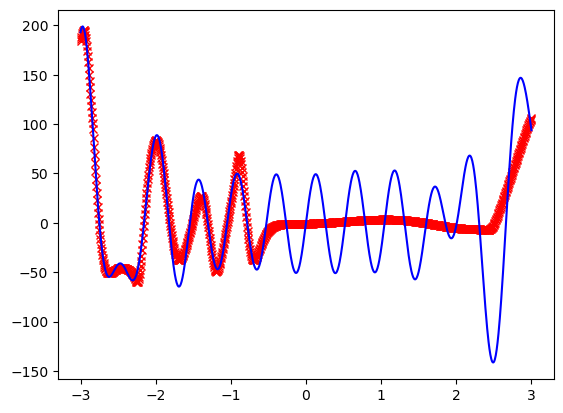

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [12]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.33695579904346107
